In [1]:
# imports
import numpy as np
import os
import glob
from astropy.io import fits
from astropy.io.fits import getdata
from astropy.stats import mad_std
from photutils import DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import shift
import PyTorchDIA_Newton
#import PyTorchDIA_FullLikelihood
#import PyTorchDIA_RobustLoss
import PyTorchDIA_RobustLoss_lossconv
#import PyTorchDIA_Student
import torch
%matplotlib inline

PyTorch version: 1.5.1
PyTorch version: 1.5.1


In [2]:
%load_ext Cython

In [3]:
%%cython

from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [4]:
# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

Reference FWHM: 5.625057500773691
Reference TOT_IM: 3000.0
Reference shape: (512, 512)


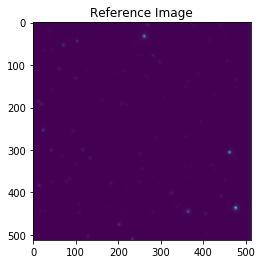

In [5]:
## path to images
path = 'OGLE-III-BLG101'

## reference image
ref_file = os.path.join(path, 'coll_OGLE-III-BLG101_Llr_2019-07-20_00048.fits')
ref_data = getdata(ref_file, header=True)
ref, ref_fwhm, ref_totim = ref_data[0], ref_data[1]['FWHM'], ref_data[1]['TOT_IM']
shape = ref.shape
print('Reference FWHM:', ref_fwhm)
print('Reference TOT_IM:', ref_totim)
print('Reference shape:', shape)

plt.title('Reference Image')
plt.imshow(ref)

Number of bright detected sources: 232


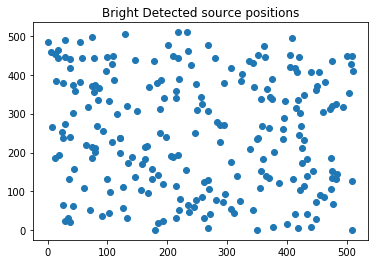

Number of bright (separated) detected sources: 232


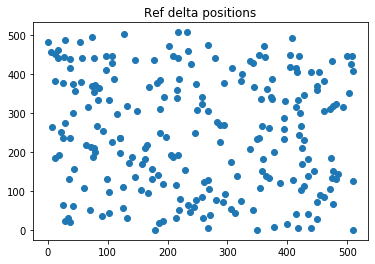

DBFs in ref_delta: 232


In [6]:
## bright stars for PSF inference
## find bright star peaks above given threshold (sky subtract)
sky, std = np.median(ref), mad_std(ref)
thrs = 5
daofind_bright = DAOStarFinder(fwhm=ref_fwhm, threshold=thrs*std)  
sources_bright = daofind_bright(ref - sky)

ref_delta_positions = np.transpose((sources_bright['xcentroid'], sources_bright['ycentroid'],
                                    sources_bright['peak']))

print('Number of bright detected sources:', len(ref_delta_positions))

plt.title('Bright Detected source positions')
plt.scatter(ref_delta_positions[:,0], ref_delta_positions[:,1])
plt.show()

'''
min_sep = 0
seps = []
mask = np.zeros(len(ref_delta_positions))

for i,pos1 in enumerate(ref_delta_positions):
    for j,pos2 in enumerate(ref_delta_positions):
        sep_x = np.abs(pos1[0] -  pos2[0])
        sep_y = np.abs(pos1[1] -  pos2[1])
        sep = np.sqrt(sep_x**2 + sep_y**2)
        if sep !=0 and sep not in seps and mask[j] != 1:
            seps.append(sep)
            if sep < min_sep:
                mask[i] = 1
                break
'''
mask = np.zeros(len(ref_delta_positions))
# delta function positions
dbf_x = ref_delta_positions[:,0][mask == 0].astype(int)
dbf_y = ref_delta_positions[:,1][mask == 0].astype(int)
#bright_peaks = ref_delta_positions[:,2][mask == 0].astype(int)
# check
print('Number of bright (separated) detected sources:', len(dbf_x))

# well distributed across image?
plt.title('Ref delta positions')
plt.scatter(dbf_x, dbf_y)
plt.show()


# mask non peak positions
mask_image = np.ones(shape)
# peaks
mask_image[dbf_y, dbf_x] = 0

ref_delta = np.copy(ref)
# apply mask
ref_delta[mask_image == 1] = 0.
#ref_delta[mask_image == 0] = 1.


# check
print('DBFs in ref_delta:', len(np.where(ref_delta!=0)[0]))

Detected 232 sources:


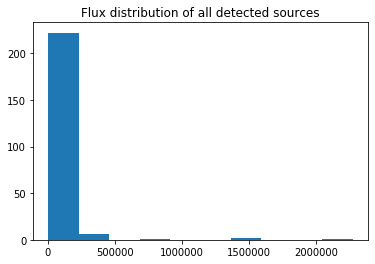

(232, 5)
(115, 5)
115 possible sources for the photometry:


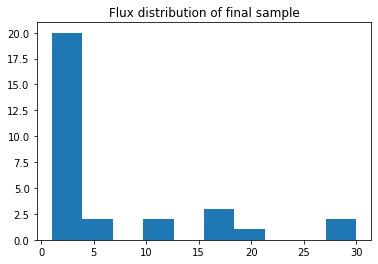

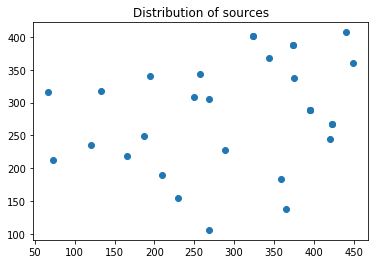

Using 30 sources to assess photometric accuracy.


In [7]:
# generate random list of stars for photometry

daofind = DAOStarFinder(fwhm=ref_fwhm, threshold=5.*std)  
sources = daofind_bright(ref - sky)


print('Detected %d sources:' % len(sources))
plt.title('Flux distribution of all detected sources')
plt.hist(sources['peak'])
plt.show()

#cut = 0
#peak_lower_bound = np.percentile(sources['peak'], cut)
#sources = sources[np.where(sources['peak']>peak_lower_bound)]
#print('Number of sources after removing %d percent faintest detected sources: %d' % (cut, len(sources)))
#plt.hist(sources['peak'])
#plt.show()

# extract positions, and avoid images edges (half reference-image pair size boundary)
positions = np.transpose((sources['xcentroid'], sources['ycentroid'], sources['id'],
                          sources['flux'], sources['peak']))
positions = positions.astype(int)
print(positions.shape)
positions = positions[np.where(positions[:,0] > 50)]
positions = positions[np.where(positions[:,0] < ref.shape[0] - 50)]
positions = positions[np.where(positions[:,1] > 100)]
positions = positions[np.where(positions[:,1] < ref.shape[1] - 100)]
print(positions.shape)


print('%d possible sources for the photometry:' % len(positions))

# measure light curves of nsources = 30
np.random.seed(84)
nsources = 30
rand_sources = np.random.randint(0, len(positions), nsources)
positions = positions[rand_sources]

plt.title('Flux distribution of final sample')
plt.hist(positions[:,3])
plt.show()


# uniformly distributed??
plt.title('Distribution of sources')
plt.scatter(positions[:,0], positions[:,1])
plt.show()

print('Using %d sources to assess photometric accuracy.' % len(positions))

In [8]:
# source flux as a fraction of total measured flux

source_ids = np.array([])
F_fracs = np.array([])

max_separation = np.sqrt(2 * (50-1.5*ref_fwhm)**2)
for k,p in enumerate(positions):
    fluxes = []
    index = np.where(sources['id'] == p[2])[0][0]
    x0, y0, flux = p[0], p[1], p[3]
    for s in sources:
        x, y = s['xcentroid'], s['ycentroid']
        delta_x = np.abs(x - x0)
        delta_y = np.abs(y - y0)
        sep = np.sqrt(delta_x**2 + delta_y**2)
        if sep < max_separation and s['id'] != index:
            fluxes.append(s['flux'])
            
    F_frac = flux / np.sum(fluxes)
    source_ids = np.append(source_ids, k)
    F_fracs = np.append(F_fracs, F_frac)
    

source_flux_fraction = np.vstack((source_ids, F_fracs)).T
np.savetxt('Flux_fraction.txt', source_flux_fraction)

['2019-07-21', '2019-07-28', '2019-07-27', '2019-07-20', '2019-07-30', '2019-07-26', '2019-07-29', '2019-07-24', '2019-07-17', '2019-07-25', '2019-07-18', '2019-07-19']
(512, 512) (249, 512, 512) (12, 512, 512)
Median FWHM: 8.877233982225084
['coll_OGLE-III-BLG101_Llr_2019-07-26_00010.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-26_00035.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-28_00001.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-19_00116.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-18_00067.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-27_00070.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-25_00023.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-18_00042.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-27_00067.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-25_00003.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-27_00042.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-26_00025.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-25_00001.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-18_00008.fits', 'coll_OGLE-III-BLG101_Llr_2019-07-18_00007.fits', 'coll_O

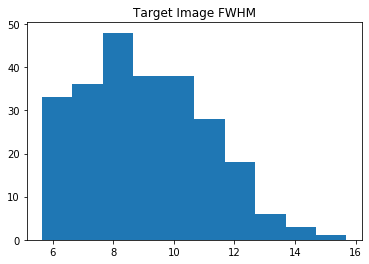

In [9]:
## master flat
#path = 'LOB190560Z'

#flat_file = os.path.join(path, 'master_flat.fits')
#master_flat = getdata(flat_file, 0, header=True)[0]

## shifts
shift_info = os.path.join(path, 'Shift_info.txt')
shifts = np.genfromtxt(shift_info, delimiter="\t", dtype=str) # filename | xs | ys

## crop reference and master flat ##
crop = 0
ref = ref[crop:ref.shape[0]-crop, crop:ref.shape[1]-crop]
#master_flat = master_flat[crop:master_flat.shape[0]-crop, crop:master_flat.shape[1]-crop]

# and crop ref_delta
ref_delta = ref_delta[crop:ref_delta.shape[0]-crop, crop:ref_delta.shape[1]-crop]

## ensure dtype=np.float32
ref = np.array(ref, dtype=np.float32)
#master_flat = np.array(master_flat, dtype=np.float32)

fnames = []
images = []
FWHMs = []
Tot_ims = []

for image_file in glob.glob(os.path.join(path, "*coll*")):
    #print(image_file)
    # avoid reference
    if ref_file not in image_file and '2019-07-28_00000.fits' not in image_file:
        #if 'coll_OGLE-III-BLG101_Llr_2019-07-19_00116.fits' in image_file or 'coll_OGLE-III-BLG101_Llr_2019-07-18_00067.fits' in image_file:
        #print(image_file.split('/')[-1])
        image_data = getdata(image_file, header=True)
        image, header = image_data[0], image_data[1]
        #image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]
        # there are some 30Hz exposures here, so avoid those
        if header['TOT_IM'] <= 3000.0:
            fnames.append(image_file.split('/')[-1])
            images.append(image)
            FWHMs.append(header['FWHM'])
            Tot_ims.append(header['TOT_IM'])
        

# flats
master_flats = []
master_flat_dates = []
for image_file in glob.glob(os.path.join(path, "Master_flats_OGLE-III-BLG101/*.fits")):
    master_flat_dates.append(image_file.split('_')[-1].split('.')[0])
    image_data = getdata(image_file, header=True)
    image, header = image_data[0], image_data[1]
    image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]    
    master_flats.append(image)


# convert to numpy arrays (float32)
images, FWHMs, Tot_ims = np.array(images, dtype=np.float32), np.array(FWHMs), np.array(Tot_ims, dtype=np.int)
master_flats = np.array(master_flats, dtype=np.float32)

print(master_flat_dates)

print(ref.shape, images.shape, master_flats.shape)

# distribution of FWHMs
plt.figure()
plt.hist(FWHMs)
plt.title('Target Image FWHM')
print('Median FWHM:', np.median(FWHMs))

print(fnames)

In [10]:
## run this cell once to load gpu, then run again for actual test
## gpu overhead associated with first loading it will screw with the
## actual solutiontimes for the very first image

# extend image prior to convoliving with kernel
def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    
    # crop image edges to exlcude convolution artefacts
    #M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    #I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    #noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    #mask = mask[kernel_size:mask.shape[0]-kernel_size, kernel_size:mask.shape[1]-kernel_size]
    
    # calculate metrics
    #x[~np.array(mask)]
    N_data = len(I[mask == 0].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    x_centroid, y_centroid = pos[1], pos[0]
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout

## sky subtract reference
ref -= np.median(ref)

## iterate through target images
start_time = time.time()
for i, image in enumerate(images):
    
    ##### pick up from where we last left off ####
    if i > 174:
    
        #out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
        #                 image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd)).T

        image_FWHMs_pd = []
        image_SNRs_pd = []
        MFBs_pd = []
        MFVs_pd = []
        Ps_normalised_pd = []
        B0s_pd = []
        norm_phot_resids_pd = []
        stamp_ids_pd = []

        image_FWHMs_pt = []
        image_SNRs_pt = []    
        MFBs_pt = []
        MFVs_pt = []
        Ps_normalised_pt = []
        B0s_pt = []
        norm_phot_resids_pt = []
        stamp_ids_pt = []

        print('Image %d of %d' % (i, len(images)))
        print('Consisting of %d frames' % Tot_ims[i])

        # load corresponding flat
        name = fnames[i]
        print(name)
        date = name.split('_')[3]
        flat_index = np.where(np.array(master_flat_dates) == date)[0][0]
        print('Using flat:', master_flat_dates[flat_index])
        master_flat = master_flats[flat_index]

        fwhm = FWHMs[i]
        print('Image FWHM:', fwhm)
        # kernel stamp radius is 1 fwhm
        ss = np.int(2*fwhm)
        if ss % 2 == 0:
            ss += 1

        print('Stamp size:', ss)

        file_name = fnames[i]
        ys, xs = shifts[:,1][np.where(shifts[:,0] == file_name)][0], shifts[:,2][np.where(shifts[:,0] == file_name)][0]

        # x and y switched
        shiftxy = np.array([xs.astype(int), ys.astype(int)])

        #print('Aligning flat with (xs, ys) shifts:',xs.astype(int), ys.astype(int))
        # shift flat and delta function scene to target image
        #flat = shift(master_flat, (ys.astype(int),xs.astype(int)), cval=0.)

        # store values for photometric accuracy metrics
        # requires relative P for P_true
        photometric_scale_factors_pd = []
        F_measured_values_pd = []
        photometric_scale_factors_pt = []
        F_measured_values_pt = []    
        target_psf_objects = []
        pixel_uncertanties_list = []


        ## for each image, divide this into image and reference stamps centered on a star ##
        ## solve a kernel and background term for each, and perform psf fitting at the    ##
        ## position of the star in the difference image.

        ## deal with nans on first pass ##
        if fwhm != 1e99:
            for j,pos in enumerate(positions[:, [0,1]]):

                if j != 1e99:

                    try:

                        if 50 < pos[0] < image.shape[0] - 50 and 100 < pos[1] < image.shape[1] - 100:
                            # add shifts to positions to we get the right part of the reference and flat
                            print('Ref position:', pos)
                            print('Shift:', shiftxy)
                            cutout_size = 100
                            image_stamp = make_stamp(image, pos + shiftxy, cutout_size)
                            ref_stamp = make_stamp(ref, pos, cutout_size)
                            flat_stamp = make_stamp(master_flat, pos + shiftxy, cutout_size)
                            ref_delta_stamp = make_stamp(ref_delta, pos, cutout_size)

                            ## run pyDANDIA to build the bad pixel mask and pixel uncertanties so we compare
                            ## like with like when calculating metrics
                            mask = np.zeros(image_stamp.shape)
                            for iters in range(0, 4):

                                # build bad pixel mask
                                gain_CCD = 25.8 # CCD gain
                                gain_EM = 300. # EM gain
                                G = gain_CCD / gain_EM # Total gain
                                excess_noise_factor = 2 # EMCCD fudge factor
                                if iters == 0:
                                    shot_noise = image_stamp/(G*flat_stamp)
                                else:
                                    shot_noise = model_pd/(G*flat_stamp)   

                                var_model = excess_noise_factor*shot_noise
                                pixel_uncertanties = np.sqrt(var_model) 

                                # Noise Model
                                weights_stamp = 1./var_model
                                # mask outliers
                                if iters > 1:
                                    # update mask on third and fourth iterations only
                                    norm_resids = np.sqrt(weights_stamp)*(image_stamp - model_pd)
                                    mask[np.where(np.abs(norm_resids)>5)] = 1
                                weights_stamp[np.where(mask == 1)] = 1e-198
                                print('\nMasked pixels (pyDANDIA):', np.sum(mask))

                                print('\npyDANDIA solution, iter %d' % iters)
                                ext_ref = extend_image(ref_stamp, ss)
                                ext_imag = extend_image(image_stamp, ss)
                                ext_weights = extend_image(weights_stamp, ss)

                                U, b = construct_kernel_and_matrices(ss, ext_ref, ext_imag, ext_weights)
                                kernel_pd, B0_pd = lstsq_solution(ext_ref, ext_imag, U, b, ss)
                                print('P:', np.sum(kernel_pd))
                                print('B0:', B0_pd)

                                ext_ref_stamp = extend_image(ref_stamp, ss)
                                ext_model_pd = convolve2d(ext_ref_stamp, kernel_pd, mode='same') + B0_pd
                                model_pd = ext_model_pd[ss:ext_model_pd.shape[0]-ss, ss:ext_model_pd.shape[1]-ss]


                                if iters == 3:
                                    # calculate pixel uncertanties on the final, fourth iteration
                                    gain_CCD = 25.8 # CCD gain
                                    gain_EM = 300. # EM gain
                                    G = gain_CCD / gain_EM # Total gain
                                    excess_noise_factor = 2 # EMCCD fudge factor
                                    shot_noise = model_pd/(G*flat_stamp)
                                    var_model = excess_noise_factor*shot_noise
                                    pixel_uncertanties = np.sqrt(var_model) # Noise Model



                            SD_steps = 25000
                            # infer kernel via robust PyTorchDIA code
                            print('\nHuber Likelihood')
                            kernel_pt, B0_pt, failed = PyTorchDIA_RobustLoss_lossconv.DIA(ref_stamp,
                                       image_stamp,
                                       flat_stamp, # flatfield
                                       read_noise = 5.,
                                       ks = ss,
                                       lr_kernel = 1e-3,
                                       lr_B = 100,
                                       SD_steps = SD_steps,
                                       Newton_tol = 1e-6,
                                       poly_degree=0,
                                       fast=True,
                                       tol = 1e-9,
                                       max_iterations = SD_steps + 25,
                                       fisher=False,
                                       show_convergence_plots=False,
                                       c = 1.345)




                            # model image - pyDANDIA
                            ext_ref_stamp = extend_image(ref_stamp, ss)
                            ext_model_pd = convolve2d(ext_ref_stamp, kernel_pd, mode='same') + B0_pd
                            model_pd = ext_model_pd[ss:ext_model_pd.shape[0]-ss, ss:ext_model_pd.shape[1]-ss]
                            # model image - PyTorch
                            ext_ref_stamp = extend_image(ref_stamp, ss)
                            ext_model_pt = convolve2d(ext_ref_stamp, kernel_pt, mode='same') + B0_pt
                            model_pt = ext_model_pt[ss:ext_model_pt.shape[0]-ss, ss:ext_model_pt.shape[1]-ss]

                            # image models
                            models = [model_pd, model_pt]


                            #### PSF fitting photometry in difference image ####
                            #### infer PSF - this is unweighted ###
                            psf, placeholder, placeholder, placeholder, placeholder = PyTorchDIA_Newton.DIA(ref_delta_stamp,
                                                                                  image_stamp,
                                                                                  flat_stamp, # flatfield
                                                                                  read_noise = 0.,
                                                                                  tot_im = Tot_ims[i],
                                                                                  unweighted=True,
                                                                                  n_samples=1,
                                                                                  full_image=True,
                                                                                  display_stamps=False, 
                                                                                  sky_subtract = False,
                                                                                  iters=1,
                                                                                  ks = ss,
                                                                                  lr_kernel = 1e-2,
                                                                                  lr_B = 100,
                                                                                  SD_steps = 0,
                                                                                  Newton_tol = 1e-6,
                                                                                  poly_degree=0,
                                                                                  fast=True,
                                                                                  tol = 1e-9,
                                                                                  alpha = 0., 
                                                                                  max_iterations = 5000,
                                                                                  fisher=False,
                                                                                  show_convergence_plots=False,
                                                                                  display_D=False,
                                                                                  k=1e99,
                                                                                  precision=3,
                                                                                  display_masked_stamps=False,
                                                                                  display_M=False,
                                                                                  display_kernel=False,
                                                                                  display_B = False)

                            #stop = input()
                            psf /= np.sum(psf)

                            for m,model in enumerate(models):

                                if m == 0:
                                    print('\nCalculating pyDANDIA metrics')
                                else:
                                    print('\nCalculating PyTorchDIA metrics')

                                stamp_fit = make_fit_cutout(image_stamp - model, ss)
                                noise_stamp_fit = make_fit_cutout(pixel_uncertanties, ss)

                                ## psf fit
                                F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                                const = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                                print('Starting F_diff and const:', F_diff, const)

                                #print(model.shape, stamp_fit.shape, noise_stamp_fit.shape)

                                target_psf_object = torch.from_numpy(psf)
                                stamp_fit = torch.from_numpy(np.array(stamp_fit, dtype=np.float32))
                                noise_stamp_fit = torch.from_numpy(np.array(noise_stamp_fit, dtype=np.float32))

                                class log_likelihood(torch.nn.Module):

                                    def forward(model, stamp, noise_stamp):
                                        #print(stamp.size(), model.size(), noise_stamp.size())
                                        loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()
                                        return -loglikelihood

                                optimizer = torch.optim.Adam([F_diff, const], lr=1000)

                                tol = 1e-10
                                losses = []
                                for step in range(0, 150000):
                                    optimizer.zero_grad()
                                    psf_model = F_diff*target_psf_object + const
                                    loss = log_likelihood.forward(psf_model, stamp_fit, noise_stamp_fit)
                                    losses.append(loss.item())
                                    loss.backward()
                                    optimizer.step()

                                    if step>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                                        print('Converged')
                                        break


                                print('Final F and const:', F_diff, const)
                                #plt.plot(losses)

                                ## convert tensors back to numpy arrays
                                F_diff = F_diff.detach().numpy()
                                const = const.detach().numpy()
                                target_psf_object = target_psf_object.detach().numpy()
                                stamp_fit = stamp_fit.detach().numpy()
                                noise_stamp_fit = noise_stamp_fit.detach().numpy()

                                '''
                                # plot the stamp
                                plt.figure()
                                plt.title('Difference image stamp')
                                plt.imshow(stamp_fit)
                                plt.colorbar()
                                plt.show()

                                # plot the reference stamp - to check aligned OK
                                plt.figure()
                                plt.title('Reference Image stamp')
                                plt.imshow(make_fit_cutout(ref_stamp, ss))
                                plt.colorbar()
                                plt.show()


                                # plot the image stamp - to check psf accurate!
                                plt.figure()
                                plt.title('Data Image stamp')
                                plt.imshow(make_fit_cutout(image_stamp, ss))
                                plt.colorbar()
                                plt.show()

                                # plot the psf model
                                plt.figure()
                                plt.title('Normalised PSF model')
                                plt.imshow(target_psf_object)
                                plt.colorbar()
                                plt.show()

                                # plot the residuals
                                prediction = F_diff*target_psf_object + const
                                residuals = prediction - stamp_fit
                                plt.figure()
                                plt.title('Residuals from PSF fit to difference image stamp')
                                plt.imshow(residuals)
                                plt.colorbar()
                                plt.show()
                                '''

                                if m == 0:

                                    ## Difference flux of brightest star
                                    F_measured_pd = F_diff / np.sum(kernel_pd)

                                    # store values to cal
                                    F_measured_values_pd.append(F_measured_pd)
                                    photometric_scale_factors_pd.append(np.sum(kernel_pd))
                                    target_psf_objects.append(target_psf_object)
                                    pixel_uncertanties_list.append(noise_stamp_fit)

                                    # stamp number
                                    stamp_ids_pd.append(j)

                                    # image SNR
                                    sky = np.median(image_stamp)
                                    SNR = np.sum(image_stamp - sky) / np.sqrt(np.sum(pixel_uncertanties**2))
                                    image_SNRs_pd.append(SNR)
                                    image_FWHMs_pd.append(FWHMs[i])
                                    print('pd fwhms:', FWHMs[i])

                                    # apply bad pixel mask (same for both PyTorchDIA and pyDANDIA)
                                    masked_model_pd = np.ma.array(model, mask=mask)
                                    masked_image_stamp = np.ma.array(image_stamp, mask=mask)
                                    masked_pixel_uncertanties = np.ma.array(pixel_uncertanties, mask=mask)

                                    # metrics
                                    MFB_pd, MFV_pd = metrics(masked_model_pd, masked_image_stamp, masked_pixel_uncertanties,
                                                             ss, mask)
                                    print('P:', np.sum(kernel_pd))
                                    print('B0:', B0_pd)
                                    print('MFB:', MFB_pd)
                                    print('MFV:', MFV_pd)

                                    #Ps.append(np.sum(kernel))
                                    B0s_pd.append(B0_pd)
                                    MFBs_pd.append(MFB_pd)
                                    MFVs_pd.append(MFV_pd)

                                else:

                                    ## Difference flux of brightest star
                                    F_measured = F_diff / np.sum(kernel_pt)

                                    # store values to cal
                                    F_measured_values_pt.append(F_measured)
                                    photometric_scale_factors_pt.append(np.sum(kernel_pt))
                                    #target_psf_objects.append(target_psf_object)
                                    #pixel_uncertanties_list.append(noise_stamp_fit)

                                    # stamp number
                                    stamp_ids_pt.append(j)

                                    # image SNR
                                    sky = np.median(image_stamp)
                                    SNR = np.sum(image_stamp - sky) / np.sqrt(np.sum(pixel_uncertanties**2))
                                    image_SNRs_pt.append(SNR)
                                    print('pt fwhm:', FWHMs[i])
                                    image_FWHMs_pt.append(FWHMs[i])

                                    # apply bad pixel mask (same for both PyTorchDIA and pyDANDIA)
                                    masked_model_pt = np.ma.array(model, mask=mask)
                                    masked_image_stamp = np.ma.array(image_stamp, mask=mask)
                                    masked_pixel_uncertanties = np.ma.array(pixel_uncertanties, mask=mask)

                                    # metrics
                                    MFB_pt, MFV_pt = metrics(masked_model_pt, masked_image_stamp, masked_pixel_uncertanties,
                                                             ss, mask)
                                    print('P:', np.sum(kernel_pt))
                                    print('B0:', B0_pt)
                                    print('MFB:', MFB_pt)
                                    print('MFV:', MFV_pt)

                                    #Ps.append(np.sum(kernel))
                                    B0s_pt.append(B0_pt)
                                    MFBs_pt.append(MFB_pt)
                                    MFVs_pt.append(MFV_pt)

                    except ValueError:
                        print('Skipping reference-image pair... target too close to border for this imge FWHM')



        # pyDANDIA - calcualte theoretical min_var for each stamp
        #P_true_pd = np.median(photometric_scale_factors_pd)

        # as with 'true' pixel uncertanties, use pyDANDIA to calculate
        # 'true' photometric scale factor
        P_true = np.median(photometric_scale_factors_pd)

        print('\npyDANDIA photometric residuals')
        for s in range(0, len(photometric_scale_factors_pd)):
            P_normalised = photometric_scale_factors_pd[s]/P_true
            Ps_normalised_pd.append(P_normalised)
            min_var = (1./P_true**2) * (np.sum((target_psf_objects[s]**2/pixel_uncertanties_list[s]**2)))**(-1)
            F_measured_sigma_min = F_measured_values_pd[s] / np.sqrt(min_var)
            norm_phot_resids_pd.append(F_measured_sigma_min)
            print('F_measure / sigma_min:', F_measured_sigma_min)

        # PyTorch - calcualte theoretical min_var for each stamp
        #P_true_pt = np.median(photometric_scale_factors_pt)
        print('\nPyTorchDIA photometric residuals')
        for s in range(0, len(photometric_scale_factors_pt)):
            P_normalised = photometric_scale_factors_pt[s]/P_true
            Ps_normalised_pt.append(P_normalised)
            min_var = (1./P_true**2) * (np.sum((target_psf_objects[s]**2/pixel_uncertanties_list[s]**2)))**(-1)
            F_measured_sigma_min = F_measured_values_pt[s] / np.sqrt(min_var)
            norm_phot_resids_pt.append(F_measured_sigma_min)
            print('F_measure / sigma_min:', F_measured_sigma_min)



        out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
                         image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd)).T

        out_pt = np.vstack((MFBs_pt, MFVs_pt, Ps_normalised_pt, np.array(norm_phot_resids_pt).flatten(),
                         image_SNRs_pt, image_FWHMs_pt, stamp_ids_pt)).T

        #path = '/media/james/Seagate_Expansion_Drive#2'
        path = os.getcwd()

        filename = os.path.join(path, 'pyDANDIA_OGLE_BLG101_lossconvtest#2.txt')
        with open(filename, 'a') as f:
            np.savetxt(f, out_pd)

        filename = os.path.join(path, 'PyTorchDIA_OGLE_BLG101_lossconvtest#2.txt')
        with open(filename, 'a') as f:
            np.savetxt(f, out_pt)


print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids))
print('Total time:', time.time() - start_time)

Image 175 of 249
Consisting of 3000 frames
coll_OGLE-III-BLG101_Llr_2019-07-25_00024.fits
Using flat: 2019-07-25
Image FWHM: 10.4135210850724
Stamp size: 21
Ref position: [ 73 213]
Shift: [-1 -8]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.2758471965789795 seconds ---
P: 1.103594902651841
B0: 5908.1059817751075

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1596453189849854 seconds ---
P: 1.1062437743724391
B0: 5960.4254695006275

Masked pixels (pyDANDIA): 208.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1844711303710938 seconds ---
P: 1.1093281604131275
B0: 5912.02564367867

Masked pixels (pyDANDIA): 218.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.3773887157440186 seconds ---
P: 1.1106995958371222
B0: 5908.743922128041

Huber Likelihood
--- Time to move data onto GPU: 1.4412293434143066 ---
Switching to Quasi-Newton step after 1635 SD st

--- Finished U and b construction in 2.140195846557617 seconds ---
P: 1.2174174815186796
B0: 5820.841257314739

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2730302810668945 seconds ---
P: 1.2919412212124217
B0: 5878.517799448068

Masked pixels (pyDANDIA): 247.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.241800308227539 seconds ---
P: 1.1338409596879337
B0: 5822.563056275899

Masked pixels (pyDANDIA): 262.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1423447132110596 seconds ---
P: 1.1247791878437137
B0: 5817.778757800614

Huber Likelihood
--- Time to move data onto GPU: 0.0005133152008056641 ---
Switching to Quasi-Newton step after 269 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8854639530181885 seconds ---
Parameter containing:
tensor([5839.8330], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 2.157916307449341 seconds ---
P: 1.0404924886637268
B0: 5800.448835514372

Masked pixels (pyDANDIA): 34.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2603564262390137 seconds ---
P: 1.0407312652527936
B0: 5800.08817367261

Huber Likelihood
--- Time to move data onto GPU: 0.0002086162567138672 ---
Switching to Quasi-Newton step after 1378 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.189216136932373 seconds ---
Parameter containing:
tensor([5786.3940], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0408, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5786.39404296875
--- Finished in a total of 9.194980382919312 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0007562637329101562 ---
Switching to Quasi-Newton step
33.937477111816406 6384.86181640625
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 1175 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.221445083618164 seconds ---
Parameter containing:
tensor([5715.4785], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0488, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5715.478515625
--- Finished in a total of 6.2255635261535645 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002117156982421875 ---
36.508934020996094 5386.63623046875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12414073944091797 seconds ---
Parameter containing:
tensor([5386.6362], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.5089, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5386.63623046875
Photometric Scale Factor: 36.508934
Converged in 1 iterations
--- Finished in a total of 0.1439192295074463 seconds ---

Calculating pyDANDI

Switching to Quasi-Newton step
37.20310974121094 5256.45751953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16384458541870117 seconds ---
Parameter containing:
tensor([5256.4575], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(37.2031, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5256.45751953125
Photometric Scale Factor: 37.20311
Converged in 1 iterations
--- Finished in a total of 0.1839139461517334 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-26327.5566], requires_grad=True) Parameter containing:
tensor([4.8339], requires_grad=True)
pd fwhms: 10.4135210850724
P: 1.0807677315548831
B0: 5745.8933544433
MFB: 0.0009938032711454487
MFV: 1.287978152310079

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], 

Converged
Final F and const: Parameter containing:
tensor([-6724.0513], requires_grad=True) Parameter containing:
tensor([1.5694], requires_grad=True)
pd fwhms: 10.4135210850724
P: 1.1012358048183812
B0: 5846.3729247620295
MFB: 0.0015636363158266786
MFV: 1.3425121160850482

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-6292.2275], requires_grad=True) Parameter containing:
tensor([-4.2190], requires_grad=True)
pt fwhm: 10.4135210850724
P: 1.0993354
B0: 5851.32958984375
MFB: -0.005402139388888661
MFV: 1.3662539223162296
Ref position: [268 306]
Shift: [-1 -8]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1973793506622314 seconds ---
P: 1.0548277771519454
B0: 5655.291659718316

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 2.1893696784973145 seconds ---
P: 1.1506061941766885
B0: 5864.769112113772

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.237215757369995 seconds ---
P: 1.1660988736280369
B0: 5896.561320344276

Masked pixels (pyDANDIA): 265.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.165130138397217 seconds ---
P: 1.1176520636397171
B0: 5911.213252700388

Masked pixels (pyDANDIA): 283.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1875619888305664 seconds ---
P: 1.108585004744366
B0: 5913.31813283172

Huber Likelihood
--- Time to move data onto GPU: 0.0001697540283203125 ---
Switching to Quasi-Newton step after 989 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.092406988143921 seconds ---
Parameter containing:
tensor([5854.0239], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1

--- Finished U and b construction in 2.1248412132263184 seconds ---
P: 1.1131842922829192
B0: 5784.246142584783

Masked pixels (pyDANDIA): 38.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1482791900634766 seconds ---
P: 1.108294447665226
B0: 5783.782547413297

Huber Likelihood
--- Time to move data onto GPU: 0.0006518363952636719 ---
Switching to Quasi-Newton step after 284 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.586862325668335 seconds ---
Parameter containing:
tensor([5775.3691], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1148, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5775.369140625
--- Finished in a total of 2.591493606567383 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00016307830810546875 ---
Switching to Quasi-Newton step
39.46992492675781 5175.248046875
'Speedy' convergence reached!
--- Fini

--- Finished U and b construction in 2.1795883178710938 seconds ---
P: 1.0520359457558557
B0: 5781.5050073340335

Huber Likelihood
--- Time to move data onto GPU: 0.0005815029144287109 ---
Switching to Quasi-Newton step after 262 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.380242347717285 seconds ---
Parameter containing:
tensor([5764.8750], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0537, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5764.875
--- Finished in a total of 2.3840889930725098 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011658668518066406 ---
Switching to Quasi-Newton step
34.79057312011719 5387.267578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11798596382141113 seconds ---
Parameter containing:
tensor([5387.2676], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(3

Switching to Quasi-Newton step after 2200 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 12.765663146972656 seconds ---
Parameter containing:
tensor([5964.1475], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0613, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5964.1474609375
--- Finished in a total of 12.773088932037354 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00026154518127441406 ---
Switching to Quasi-Newton step
36.70890808105469 6192.14892578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.33350205421447754 seconds ---
Parameter containing:
tensor([6192.1489], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.7089, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6192.14892578125
Photometric Scale Factor: 36.708908
Converged in 1 iterations
--- Finished in a total of 0.3558120727539062

Switching to Quasi-Newton step
34.930850982666016 5905.12353515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.31522393226623535 seconds ---
Parameter containing:
tensor([5905.1235], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.9309, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5905.12353515625
Photometric Scale Factor: 34.930855
Converged in 1 iterations
--- Finished in a total of 0.3313784599304199 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-16096.3398], requires_grad=True) Parameter containing:
tensor([-151.7346], requires_grad=True)
pd fwhms: 8.299143909187858
P: 1.0443366669190035
B0: 5866.245834799912
MFB: 0.00011221725696918035
MFV: 1.4632869594935969

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
ten

Converged
Final F and const: Parameter containing:
tensor([-3863.3220], requires_grad=True) Parameter containing:
tensor([-57.3981], requires_grad=True)
pd fwhms: 8.299143909187858
P: 1.0708053318286381
B0: 5739.855006938873
MFB: 0.0001931083970295312
MFV: 1.2516474104238233

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-8283.7549], requires_grad=True) Parameter containing:
tensor([-60.9251], requires_grad=True)
pt fwhm: 8.299143909187858
P: 1.0825727
B0: 5739.77294921875
MFB: 0.007817429081591323
MFV: 1.2904844330578027
Ref position: [133 318]
Shift: [ 5 -7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8973910808563232 seconds ---
P: 1.0439709138454432
B0: 5684.188717094021

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

Converged
Final F and const: Parameter containing:
tensor([-30327.1934], requires_grad=True) Parameter containing:
tensor([-67.1022], requires_grad=True)
pt fwhm: 8.299143909187858
P: 1.0098714
B0: 5743.30029296875
MFB: 0.030860160134801164
MFV: 1.7953815839209608
Ref position: [324 401]
Shift: [ 5 -7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9490828514099121 seconds ---
P: 1.0412189602110489
B0: 5820.729464823358

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9720990657806396 seconds ---
P: 1.0425502308991295
B0: 5851.907601839845

Masked pixels (pyDANDIA): 17.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.0024561882019043 seconds ---
P: 1.042724554930832
B0: 5848.3932012518235

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9432883262634277 seconds ---
P: 1.0426221579418278
B0: 5848.412473084928

Huber Likelih

--- Finished U and b construction in 0.8811779022216797 seconds ---
P: 1.0657805001362237
B0: 5703.011240072176

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8902831077575684 seconds ---
P: 1.074254817736053
B0: 5743.995056774915

Masked pixels (pyDANDIA): 124.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8567585945129395 seconds ---
P: 1.059116777079111
B0: 5711.079617484222

Masked pixels (pyDANDIA): 143.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8601284027099609 seconds ---
P: 1.05867565487309
B0: 5707.912358241524

Huber Likelihood
--- Time to move data onto GPU: 0.0001690387725830078 ---
Switching to Quasi-Newton step after 299 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6161866188049316 seconds ---
Parameter containing:
tensor([5722.9248], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.9052708148956299 seconds ---
P: 1.0494947802307564
B0: 5806.551303748594

Masked pixels (pyDANDIA): 93.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8855626583099365 seconds ---
P: 1.0445844657838637
B0: 5804.838176167374

Huber Likelihood
--- Time to move data onto GPU: 0.00033211708068847656 ---
Switching to Quasi-Newton step after 316 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7357547283172607 seconds ---
Parameter containing:
tensor([5792.0811], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0452, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5792.0810546875
--- Finished in a total of 3.739856719970703 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012969970703125 ---
Switching to Quasi-Newton step
34.5268669128418 5820.86376953125
'Speedy' convergence reached!
--- Fi

Switching to Quasi-Newton step after 1105 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.382725954055786 seconds ---
Parameter containing:
tensor([5626.0186], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0200, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5626.0185546875
--- Finished in a total of 4.38686990737915 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00015211105346679688 ---
33.582550048828125 5351.10546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14281940460205078 seconds ---
Parameter containing:
tensor([5351.1055], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.5826, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5351.10546875
Photometric Scale Factor: 33.58255
Converged in 1 iterations
--- Finished in a total of 0.15725183486938477 seconds ---

Calculating pyDANDIA metr

Switching to Quasi-Newton step
34.01826858520508 7036.54248046875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16971540451049805 seconds ---
Parameter containing:
tensor([7036.5425], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.0183, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7036.54248046875
Photometric Scale Factor: 34.018272
Converged in 1 iterations
--- Finished in a total of 0.18669414520263672 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-4449.8657], requires_grad=True) Parameter containing:
tensor([-132.6168], requires_grad=True)
pd fwhms: 8.299143909187858
P: 1.096371671071945
B0: 5912.44266890812
MFB: 0.0003037905237044643
MFV: 1.7047973801876863

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Photometric Scale Factor: 33.984703
Converged in 1 iterations
--- Finished in a total of 0.17009758949279785 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-58.4625], requires_grad=True) Parameter containing:
tensor([-121.9320], requires_grad=True)
pd fwhms: 8.299143909187858
P: 1.0701558873689248
B0: 5723.400496179341
MFB: -0.0009110863882137075
MFV: 1.2863413601637235

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-74.3482], requires_grad=True) Parameter containing:
tensor([-122.5085], requires_grad=True)
pt fwhm: 8.299143909187858
P: 1.0774715
B0: 5720.06689453125
MFB: 0.006535309385511009
MFV: 1.3024461508306626
Ref 

Converged
Final F and const: Parameter containing:
tensor([-25499.2363], requires_grad=True) Parameter containing:
tensor([-17.8814], requires_grad=True)
pt fwhm: 8.299143909187858
P: 1.0285134
B0: 5719.3837890625
MFB: 0.016298140739890277
MFV: 1.289460984187261
Ref position: [230 154]
Shift: [ 5 -7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9409816265106201 seconds ---
P: 1.0294506469051319
B0: 5785.796253244998

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.958843469619751 seconds ---
P: 1.0292038868157454
B0: 5812.716941319723

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9396998882293701 seconds ---
P: 1.028983669688126
B0: 5809.950134098141

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9322357177734375 seconds ---
P: 1.0289770352786352
B0: 5809.9595189111715

Huber Likelihood

--- Finished U and b construction in 0.8791482448577881 seconds ---
P: 1.0494482852643632
B0: 5707.822511823766

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8996262550354004 seconds ---
P: 1.0517632473862646
B0: 5753.3596773416575

Masked pixels (pyDANDIA): 127.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8816118240356445 seconds ---
P: 1.0479561819713752
B0: 5713.102101321557

Masked pixels (pyDANDIA): 139.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8975231647491455 seconds ---
P: 1.0476820835658096
B0: 5710.678195508371

Huber Likelihood
--- Time to move data onto GPU: 0.00017118453979492188 ---
Switching to Quasi-Newton step after 1086 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.9700751304626465 seconds ---
Parameter containing:
tensor([5708.6660], device='cuda:0', requires_grad=True)
Photometric scaling: te

--- Finished U and b construction in 2.3055579662323 seconds ---
P: 0.9298967273312972
B0: 6212.809828773176

Huber Likelihood
--- Time to move data onto GPU: 0.0008485317230224609 ---
Switching to Quasi-Newton step after 317 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.437556743621826 seconds ---
Parameter containing:
tensor([6175.5811], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9317, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6175.5810546875
--- Finished in a total of 8.44653844833374 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.894371032714844e-05 ---
37.95672607421875 7960.16015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14687299728393555 seconds ---
Parameter containing:
tensor([7960.1602], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(37.9567, device='cuda:0', grad_fn

36.91234588623047 5908.02880859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2869579792022705 seconds ---
Parameter containing:
tensor([5908.0288], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.9123, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5908.02880859375
Photometric Scale Factor: 36.912354
Converged in 1 iterations
--- Finished in a total of 0.30796289443969727 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-184676.4688], requires_grad=True) Parameter containing:
tensor([111.5719], requires_grad=True)
pd fwhms: 10.19150223724289
P: 0.9660216162532538
B0: 5951.709434131398
MFB: 0.0059666700547808885
MFV: 1.4874042869652861

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Par

Converged
Final F and const: Parameter containing:
tensor([-18532.3379], requires_grad=True) Parameter containing:
tensor([-324.0124], requires_grad=True)
pd fwhms: 10.19150223724289
P: 0.9697731324989454
B0: 6010.8985733816835
MFB: 0.003656719191475694
MFV: 1.6206828997277252

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-6022.9883], requires_grad=True) Parameter containing:
tensor([-306.9762], requires_grad=True)
pt fwhm: 10.19150223724289
P: 0.9739951
B0: 5944.125
MFB: 0.14440021431139421
MFV: 1.635431183251496
Ref position: [344 368]
Shift: [  1 -14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1860835552215576 seconds ---
P: 0.9461161787987578
B0: 5943.898212933573

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construc

Converged
Final F and const: Parameter containing:
tensor([-39492.7109], requires_grad=True) Parameter containing:
tensor([-61.5542], requires_grad=True)
pt fwhm: 10.19150223724289
P: 0.9985593
B0: 5936.13671875
MFB: 0.020391087046173925
MFV: 1.6314174975285423
Ref position: [209 189]
Shift: [  1 -14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1480066776275635 seconds ---
P: 0.9493643936835803
B0: 5932.563226129668

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1447534561157227 seconds ---
P: 0.9490800675330294
B0: 5959.470730994907

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2142350673675537 seconds ---
P: 0.9490034337988075
B0: 5957.455001590352

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.349984645843506 seconds ---
P: 0.9490003623976571
B0: 5957.457096950107

Huber Likelihoo

--- Finished U and b construction in 2.3100202083587646 seconds ---
P: 1.0872565431799224
B0: 5876.8873749575405

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.299609899520874 seconds ---
P: 1.1282253778605122
B0: 5930.823794957034

Masked pixels (pyDANDIA): 117.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1900627613067627 seconds ---
P: 1.022891942657382
B0: 5856.242238529721

Masked pixels (pyDANDIA): 135.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.338423728942871 seconds ---
P: 1.012975675944507
B0: 5848.553542376693

Huber Likelihood
--- Time to move data onto GPU: 0.000164031982421875 ---
Switching to Quasi-Newton step after 366 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0461978912353516 seconds ---
Parameter containing:
tensor([5824.3638], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 2.3471837043762207 seconds ---
P: 0.9705304756382108
B0: 6015.161032172227

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2871103286743164 seconds ---
P: 0.9699313755404605
B0: 6011.155164427441

Masked pixels (pyDANDIA): 32.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.209453821182251 seconds ---
P: 0.9697731324989454
B0: 6010.8985733816835

Huber Likelihood
--- Time to move data onto GPU: 0.00016951560974121094 ---
Switching to Quasi-Newton step after 9778 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 44.0333731174469 seconds ---
Parameter containing:
tensor([5948.0820], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9735, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5948.08203125
--- Finished in a total of 44.03759813308716 seconds ---

Sample: 0
Not subtracting sky prior to kerne

--- Finished U and b construction in 2.3014373779296875 seconds ---
P: 0.939924721452688
B0: 5831.360453919073

Huber Likelihood
--- Time to move data onto GPU: 0.00042557716369628906 ---
Switching to Quasi-Newton step after 1647 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.752935647964478 seconds ---
Parameter containing:
tensor([5826.3232], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9395, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5826.3232421875
--- Finished in a total of 9.757754802703857 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001537799835205078 ---
Switching to Quasi-Newton step
29.63166046142578 5375.64404296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1823112964630127 seconds ---
Parameter containing:
tensor([5375.6440], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 1159 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.040919065475464 seconds ---
Parameter containing:
tensor([5936.1367], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9985, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5936.13671875
--- Finished in a total of 5.047646760940552 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002224445343017578 ---
Switching to Quasi-Newton step
29.103347778320312 5718.68701171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3572819232940674 seconds ---
Parameter containing:
tensor([5718.6870], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.1033, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5718.68701171875
Photometric Scale Factor: 29.103348
Converged in 1 iterations
--- Finished in a total of 0.38077640533447266 sec

Switching to Quasi-Newton step
31.306720733642578 5921.56640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.403186559677124 seconds ---
Parameter containing:
tensor([5921.5664], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.3067, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5921.56640625
Photometric Scale Factor: 31.30672
Converged in 1 iterations
--- Finished in a total of 0.42623090744018555 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-5861.0469], requires_grad=True) Parameter containing:
tensor([23.9479], requires_grad=True)
pd fwhms: 10.19150223724289
P: 0.9523049920032027
B0: 6006.322291243655
MFB: 0.003296342559011135
MFV: 1.1681627660475637

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], req

Converged
Final F and const: Parameter containing:
tensor([-36599.8555], requires_grad=True) Parameter containing:
tensor([-31.4159], requires_grad=True)
pt fwhm: 10.19150223724289
P: 0.94666857
B0: 5944.24609375
MFB: -0.05011841508619765
MFV: 1.5625212798397838

pyDANDIA photometric residuals
F_measure / sigma_min: [-6.4099717]
F_measure / sigma_min: [7.52263]
F_measure / sigma_min: [-3.5836372]
F_measure / sigma_min: [-0.749677]
F_measure / sigma_min: [-14.088251]
F_measure / sigma_min: [-8.427124]
F_measure / sigma_min: [-1.7524391]
F_measure / sigma_min: [-1.3930306]
F_measure / sigma_min: [-3.4461997]
F_measure / sigma_min: [-1.694339]
F_measure / sigma_min: [-6.3104534]
F_measure / sigma_min: [-1.6262429]
F_measure / sigma_min: [-2.8553154]
F_measure / sigma_min: [-16.883064]
F_measure / sigma_min: [4.8588133]
F_measure / sigma_min: [-0.5777998]
F_measure / sigma_min: [5.873935]
F_measure / sigma_min: [-1.3930305]
F_measure / sigma_min: [-1.7524391]
F_measure / sigma_min: [1.8862

--- Finished U and b construction in 2.221388578414917 seconds ---
P: 0.9135110485761152
B0: 8658.844307918755

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1919867992401123 seconds ---
P: 0.9134957637065719
B0: 8658.861826452896

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.174837827682495 seconds ---
P: 0.9134954293539763
B0: 8658.862216014548

Huber Likelihood
--- Time to move data onto GPU: 0.0005259513854980469 ---
Switching to Quasi-Newton step after 532 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.293126583099365 seconds ---
Parameter containing:
tensor([8582.3535], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9320, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8582.353515625
--- Finished in a total of 4.29757285118103 seconds ---

Sample: 0
Not subtracting sky prior to kernel sol

--- Finished U and b construction in 2.6888957023620605 seconds ---
P: 1.0145103298340303
B0: 8873.300572986684

Huber Likelihood
--- Time to move data onto GPU: 0.0002467632293701172 ---
Switching to Quasi-Newton step after 500 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.228135108947754 seconds ---
Parameter containing:
tensor([8738.8516], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0520, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8738.8515625
--- Finished in a total of 3.2342517375946045 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00015807151794433594 ---
Switching to Quasi-Newton step
26.286640167236328 9592.28515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.6282577514648438 seconds ---
Parameter containing:
tensor([9592.2852], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

Switching to Quasi-Newton step after 510 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9751782417297363 seconds ---
Parameter containing:
tensor([8651.7910], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9243, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8651.791015625
--- Finished in a total of 2.9857590198516846 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010466575622558594 ---
Switching to Quasi-Newton step
30.0899600982666 8590.9716796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15070152282714844 seconds ---
Parameter containing:
tensor([8590.9717], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0900, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8590.9716796875
Photometric Scale Factor: 30.089958
Converged in 1 iterations
--- Finished in a total of 0.1695244312286377 seco

Switching to Quasi-Newton step
30.25857925415039 8428.2080078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1990675926208496 seconds ---
Parameter containing:
tensor([8428.2080], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.2586, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8428.2080078125
Photometric Scale Factor: 30.258581
Converged in 1 iterations
--- Finished in a total of 0.22041583061218262 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-39414.0430], requires_grad=True) Parameter containing:
tensor([-78.1539], requires_grad=True)
pd fwhms: 10.69838217578015
P: 0.9133897242152185
B0: 8727.688285943825
MFB: 0.0008387627737684875
MFV: 1.1337244312289065

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([

--- Finished U and b construction in 2.3664205074310303 seconds ---
P: 0.9740819264592843
B0: 8692.221459305998

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.663135528564453 seconds ---
P: 0.975676507776079
B0: 8720.228679673608

Masked pixels (pyDANDIA): 17.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2539479732513428 seconds ---
P: 0.9750255425632555
B0: 8716.028291358643

Masked pixels (pyDANDIA): 22.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.106259822845459 seconds ---
P: 0.9736380343212183
B0: 8714.27820698094

Huber Likelihood
--- Time to move data onto GPU: 0.00016236305236816406 ---
Switching to Quasi-Newton step after 453 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.340097427368164 seconds ---
Parameter containing:
tensor([8644.9277], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.98

--- Finished U and b construction in 2.184779644012451 seconds ---
P: 0.9427019219333823
B0: 8783.370191263624

Masked pixels (pyDANDIA): 145.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.136995792388916 seconds ---
P: 0.9425697667940561
B0: 8757.099108164795

Masked pixels (pyDANDIA): 162.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1797373294830322 seconds ---
P: 0.9430717107020679
B0: 8753.70574214186

Huber Likelihood
--- Time to move data onto GPU: 0.00018072128295898438 ---
Switching to Quasi-Newton step after 503 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.13192868232727 seconds ---
Parameter containing:
tensor([8691.8545], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9456, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8691.8544921875
--- Finished in a total of 9.138633728027344 seconds ---

Sample: 0
Not subtracting sky prior to kerne

--- Finished U and b construction in 2.1831939220428467 seconds ---
P: 1.0145103298340303
B0: 8873.300572986684

Huber Likelihood
--- Time to move data onto GPU: 0.00018262863159179688 ---
Switching to Quasi-Newton step after 500 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.8852646350860596 seconds ---
Parameter containing:
tensor([8738.8516], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0520, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8738.8515625
--- Finished in a total of 2.889237880706787 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
26.286640167236328 9592.28515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.26763916015625 seconds ---
Parameter containing:
tensor([9592.2852], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

Switching to Quasi-Newton step after 469 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.225651979446411 seconds ---
Parameter containing:
tensor([8668.3574], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9816, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8668.357421875
--- Finished in a total of 4.230265140533447 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001404285430908203 ---
Switching to Quasi-Newton step
27.755340576171875 8555.3857421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.22995233535766602 seconds ---
Parameter containing:
tensor([8555.3857], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.7553, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8555.3857421875
Photometric Scale Factor: 27.75534
Converged in 1 iterations
--- Finished in a total of 0.25806450843811035 secon

Photometric scaling: tensor(30.8742, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8604.7783203125
Photometric Scale Factor: 30.874168
Converged in 1 iterations
--- Finished in a total of 0.16037678718566895 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([56744.5000], requires_grad=True) Parameter containing:
tensor([-151.5851], requires_grad=True)
pd fwhms: 10.69838217578015
P: 0.9383812525167069
B0: 8781.138057272892
MFB: 0.00015493377588753977
MFV: 1.0697246202767206

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([60482.4844], requires_grad=True) Parameter containing:
tensor([-150.7806], requires_grad=True)
pt fwhm: 10.

--- Finished U and b construction in 2.2524449825286865 seconds ---
P: 0.9224774028834916
B0: 10703.273898470268

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.147771120071411 seconds ---
P: 0.9218911925602298
B0: 10767.158935451029

Masked pixels (pyDANDIA): 240.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1464664936065674 seconds ---
P: 0.9281121950286548
B0: 10677.064938319254

Masked pixels (pyDANDIA): 253.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.15626859664917 seconds ---
P: 0.929831588541876
B0: 10672.605319573071

Huber Likelihood
--- Time to move data onto GPU: 0.00024390220642089844 ---
Switching to Quasi-Newton step after 676 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.0243752002716064 seconds ---
Parameter containing:
tensor([10545.1572], device='cuda:0', requires_grad=True)
Photometric scaling: ten

--- Finished U and b construction in 2.1049351692199707 seconds ---
P: 1.1310666842290549
B0: 10643.363343749814

Masked pixels (pyDANDIA): 211.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.085777521133423 seconds ---
P: 0.9800937427196604
B0: 10600.3142681701

Masked pixels (pyDANDIA): 236.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1507718563079834 seconds ---
P: 0.963949069620128
B0: 10593.29613370603

Huber Likelihood
--- Time to move data onto GPU: 0.0002307891845703125 ---
Switching to Quasi-Newton step after 668 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.349781513214111 seconds ---
Parameter containing:
tensor([10513.8096], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9911, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10513.8095703125
--- Finished in a total of 6.354611396789551 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 2.2256178855895996 seconds ---
P: 0.9068145694359313
B0: 10664.398774719655

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.177427291870117 seconds ---
P: 0.9068498850906798
B0: 10663.960148686781

Huber Likelihood
--- Time to move data onto GPU: 0.000843048095703125 ---
Switching to Quasi-Newton step after 581 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.595243692398071 seconds ---
Parameter containing:
tensor([10514.0498], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9114, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10514.0498046875
--- Finished in a total of 7.599640846252441 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001010894775390625 ---
Switching to Quasi-Newton step
29.294918060302734 11177.53125
'Speedy' convergence reached!
--- Fin

Switching to Quasi-Newton step after 725 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.799839496612549 seconds ---
Parameter containing:
tensor([10492.9570], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8759, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10492.95703125
--- Finished in a total of 4.804989576339722 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001316070556640625 ---
29.23534393310547 10295.3125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1254417896270752 seconds ---
Parameter containing:
tensor([10295.3125], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.2353, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10295.3125
Photometric Scale Factor: 29.235344
Converged in 1 iterations
--- Finished in a total of 0.14453792572021484 seconds ---

Calculating pyDANDIA metrics
Sta

30.732044219970703 10156.10546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.22528862953186035 seconds ---
Parameter containing:
tensor([10156.1055], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.7320, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10156.10546875
Photometric Scale Factor: 30.732042
Converged in 1 iterations
--- Finished in a total of 0.24866724014282227 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-642.5793], requires_grad=True) Parameter containing:
tensor([26.0708], requires_grad=True)
pd fwhms: 10.41496924203726
P: 0.9189624957516237
B0: 10565.361471121867
MFB: 0.0003176224465493206
MFV: 1.0964019372119764

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramet

Converged
Final F and const: Parameter containing:
tensor([-11674.5400], requires_grad=True) Parameter containing:
tensor([-44.2772], requires_grad=True)
pd fwhms: 10.41496924203726
P: 0.9149617701447784
B0: 10574.154711109597
MFB: 0.0005417987570837141
MFV: 1.2133061236824079

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-8133.3750], requires_grad=True) Parameter containing:
tensor([39.3414], requires_grad=True)
pt fwhm: 10.41496924203726
P: 0.92866904
B0: 10494.6806640625
MFB: 0.16428697516851212
MFV: 1.296773976890841
Ref position: [268 306]
Shift: [-12  -1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1970059871673584 seconds ---
P: 0.8710348375437826
B0: 10498.594494915022

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b 

Converged
Final F and const: Parameter containing:
tensor([-36710.5156], requires_grad=True) Parameter containing:
tensor([101.9585], requires_grad=True)
pt fwhm: 10.41496924203726
P: 0.91136956
B0: 10514.0498046875
MFB: 0.2738138556303808
MFV: 1.584537550194512
Ref position: [449 360]
Shift: [-12  -1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1885995864868164 seconds ---
P: 1.1439822745492771
B0: 10652.323613288214

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2150959968566895 seconds ---
P: 1.2163157006288066
B0: 10675.125378243984

Masked pixels (pyDANDIA): 556.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2150988578796387 seconds ---
P: 1.0774055430336649
B0: 10778.660579050918

Masked pixels (pyDANDIA): 598.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1978344917297363 seconds ---
P: 1.0456391338362279
B0: 10786.86459333159

Huber Li

--- Finished U and b construction in 2.10402774810791 seconds ---
P: 0.933510256472746
B0: 10481.602627315302

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1291589736938477 seconds ---
P: 0.9347876296414385
B0: 10505.38396146393

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.233311653137207 seconds ---
P: 0.9347519631104615
B0: 10505.411578025467

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1356754302978516 seconds ---
P: 0.9347534666874472
B0: 10505.41062225438

Huber Likelihood
--- Time to move data onto GPU: 0.00021886825561523438 ---
Switching to Quasi-Newton step after 706 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.020889043807983 seconds ---
Parameter containing:
tensor([10450.7578], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

--- Finished U and b construction in 2.205482244491577 seconds ---
P: 0.8786228169226122
B0: 10539.233378388659

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1149096488952637 seconds ---
P: 0.8779989993658661
B0: 10533.227785347048

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0951735973358154 seconds ---
P: 0.8777621839508633
B0: 10531.032528038555

Huber Likelihood
--- Time to move data onto GPU: 0.00016880035400390625 ---
Switching to Quasi-Newton step after 713 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9497225284576416 seconds ---
Parameter containing:
tensor([10474.1221], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8896, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10474.1220703125
--- Finished in a total of 3.9536285400390625 seconds ---

Sample: 0
Not subtracting sky prior 

--- Finished U and b construction in 2.1091201305389404 seconds ---
P: 0.8950573148762317
B0: 10844.23564270642

Masked pixels (pyDANDIA): 92.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0990357398986816 seconds ---
P: 0.8953036103819128
B0: 10841.511538465154

Huber Likelihood
--- Time to move data onto GPU: 0.0003941059112548828 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.303789138793945 seconds ---
Parameter containing:
tensor([10758.4639], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9110, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10758.4638671875
--- Finished in a total of 4.308712959289551 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010585784912109375 ---
Switching to Quasi-Newton step
29.888851165771484 11115.7177734375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.197708

Switching to Quasi-Newton step
33.51239776611328 9438.599609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 1.1841650009155273 seconds ---
Parameter containing:
tensor([9438.5996], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.5124, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9438.599609375
Photometric Scale Factor: 33.512398
Converged in 1 iterations
--- Finished in a total of 1.204127311706543 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-72769.0781], requires_grad=True) Parameter containing:
tensor([-145.5167], requires_grad=True)
pd fwhms: 9.738142548847362
P: 1.0283514708309396
B0: 9322.0487223303
MFB: -0.0024566583758767846
MFV: 1.3527866285289678

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.],

--- Finished U and b construction in 1.3926005363464355 seconds ---
P: 0.9989425139443568
B0: 9252.461940179031

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.5240871906280518 seconds ---
P: 1.0004430870340857
B0: 9280.706830088106

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4331517219543457 seconds ---
P: 0.9974255510339074
B0: 9275.697848174003

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4340479373931885 seconds ---
P: 0.9972068417897209
B0: 9274.816021873956

Huber Likelihood
--- Time to move data onto GPU: 0.0001659393310546875 ---
Switching to Quasi-Newton step after 586 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.535621404647827 seconds ---
Parameter containing:
tensor([9215.9072], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 1.4062209129333496 seconds ---
P: 0.9956955812918866
B0: 9271.008456134197

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4110584259033203 seconds ---
P: 0.9956962052380613
B0: 9271.008671605545

Huber Likelihood
--- Time to move data onto GPU: 0.000213623046875 ---
Switching to Quasi-Newton step after 862 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 10.946691989898682 seconds ---
Parameter containing:
tensor([9216.5986], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9985, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9216.5986328125
--- Finished in a total of 10.959961175918579 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00026726722717285156 ---
Switching to Quasi-Newton step
37.237205505371094 9449.14453125
'Speedy' convergence reached!
--- Finis

Switching to Quasi-Newton step after 514 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.2337634563446045 seconds ---
Parameter containing:
tensor([9158.8604], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0323, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9158.8603515625
--- Finished in a total of 5.238860130310059 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020384788513183594 ---
Switching to Quasi-Newton step
31.453857421875 8934.3046875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3032054901123047 seconds ---
Parameter containing:
tensor([8934.3047], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.4539, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8934.3046875
Photometric Scale Factor: 31.453857
Converged in 1 iterations
--- Finished in a total of 0.3207216262817383 seconds ---


Photometric Scale Factor: 34.41618
Converged in 1 iterations
--- Finished in a total of 0.16568541526794434 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-105001.6953], requires_grad=True) Parameter containing:
tensor([44.1194], requires_grad=True)
pd fwhms: 9.738142548847362
P: 0.996994008410805
B0: 9362.281093611155
MFB: 0.0010985557272768336
MFV: 1.4444498298455206

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-103071.3359], requires_grad=True) Parameter containing:
tensor([93.3648], requires_grad=True)
pt fwhm: 9.738142548847362
P: 1.0111536
B0: 9269.203125
MFB: 0.16211033933564942
MFV: 1.4884165353850534
Ref posit

Converged
Final F and const: Parameter containing:
tensor([50958.0156], requires_grad=True) Parameter containing:
tensor([-43.2916], requires_grad=True)
pt fwhm: 9.738142548847362
P: 0.9876678
B0: 9108.763671875
MFB: 0.10552809101366926
MFV: 1.0931267870930228
Ref position: [324 401]
Shift: [ 7 -4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.363036870956421 seconds ---
P: 0.9952357832355125
B0: 9245.455956492833

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3960049152374268 seconds ---
P: 0.9957571731183609
B0: 9272.051204249356

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3940134048461914 seconds ---
P: 0.9956955812918866
B0: 9271.008456134197

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3628191947937012 seconds ---
P: 0.9956962052380613
B0: 9271.008671605545

Huber Likelihood
---

--- Finished U and b construction in 1.3950223922729492 seconds ---
P: 0.9843452481433694
B0: 9126.969624186388

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4470531940460205 seconds ---
P: 0.984251419165761
B0: 9150.608894964123

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.379396677017212 seconds ---
P: 0.983551566275932
B0: 9149.412899026334

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.378584384918213 seconds ---
P: 0.983400881143135
B0: 9149.117749328656

Huber Likelihood
--- Time to move data onto GPU: 0.00023984909057617188 ---
Switching to Quasi-Newton step after 566 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8864595890045166 seconds ---
Parameter containing:
tensor([9106.8154], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9760

--- Finished U and b construction in 1.484537124633789 seconds ---
P: 1.0176806530595783
B0: 9232.114589713907

Masked pixels (pyDANDIA): 103.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.5052576065063477 seconds ---
P: 1.017311170117512
B0: 9229.26486590058

Huber Likelihood
--- Time to move data onto GPU: 0.0001633167266845703 ---
Switching to Quasi-Newton step after 514 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.381927728652954 seconds ---
Parameter containing:
tensor([9158.8604], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0322, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9158.8603515625
--- Finished in a total of 2.3854331970214844 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011205673217773438 ---
Switching to Quasi-Newton step
31.453857421875 8934.3046875
'Speedy' convergence reached!
--- Finishe

Switching to Quasi-Newton step after 973 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9726099967956543 seconds ---
Parameter containing:
tensor([9251.8398], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9813, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9251.83984375
--- Finished in a total of 3.976384401321411 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001232624053955078 ---
Switching to Quasi-Newton step
32.46337127685547 9170.9462890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14095473289489746 seconds ---
Parameter containing:
tensor([9170.9463], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.4634, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9170.9462890625
Photometric Scale Factor: 32.46337
Converged in 1 iterations
--- Finished in a total of 0.15755438804626465 second

31.780651092529297 8954.9169921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2020716667175293 seconds ---
Parameter containing:
tensor([8954.9170], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.7807, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8954.9169921875
Photometric Scale Factor: 31.780651
Converged in 1 iterations
--- Finished in a total of 0.21918559074401855 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1265.6571], requires_grad=True) Parameter containing:
tensor([-19.7368], requires_grad=True)
pd fwhms: 9.738142548847362
P: 0.9834649110278006
B0: 9246.443670194085
MFB: 0.0010280928568926328
MFV: 1.202929306523264

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramete

Converged
Final F and const: Parameter containing:
tensor([89111.2109], requires_grad=True) Parameter containing:
tensor([29.8267], requires_grad=True)
pt fwhm: 10.40740623819914
P: 1.0380728
B0: 5873.9794921875
MFB: 0.13456959015672965
MFV: 2.1017232911926818
Ref position: [257 343]
Shift: [-3 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.346304178237915 seconds ---
P: 1.0725905111732996
B0: 5599.062883060434

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.3040599822998047 seconds ---
P: 1.0725274847914865
B0: 5625.178444064852

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2920594215393066 seconds ---
P: 1.0725010097705474
B0: 5625.20902268337

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.303586006164551 seconds ---
P: 1.0725004450788747
B0: 5625.2096925535625

Huber Likelihood
--- 

--- Finished U and b construction in 2.3577709197998047 seconds ---
P: 1.197040443583155
B0: 5833.092530904422

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.243687152862549 seconds ---
P: 1.2524894116907292
B0: 5888.30892748576

Masked pixels (pyDANDIA): 496.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2949061393737793 seconds ---
P: 1.1654320562975682
B0: 5843.450532127169

Masked pixels (pyDANDIA): 527.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.247725009918213 seconds ---
P: 1.156811791577015
B0: 5839.39394199429

Huber Likelihood
--- Time to move data onto GPU: 0.00028777122497558594 ---
Switching to Quasi-Newton step after 362 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3903679847717285 seconds ---
Parameter containing:
tensor([5832.1025], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1

P: 1.0720246202431343
B0: 5712.66816622889

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2518656253814697 seconds ---
P: 1.0716845657393097
B0: 5711.451444353694

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2470169067382812 seconds ---
P: 1.0714975327718164
B0: 5711.266321312842

Huber Likelihood
--- Time to move data onto GPU: 0.0009398460388183594 ---
Switching to Quasi-Newton step after 253 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4344658851623535 seconds ---
Parameter containing:
tensor([5686.7046], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0727, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5686.70458984375
--- Finished in a total of 2.4414429664611816 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012350082397460938 -

--- Finished U and b construction in 2.2903294563293457 seconds ---
P: 1.0618403590157437
B0: 5730.475542365021

Huber Likelihood
--- Time to move data onto GPU: 0.00016355514526367188 ---
Switching to Quasi-Newton step after 1703 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.231419563293457 seconds ---
Parameter containing:
tensor([5727.0244], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0612, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5727.0244140625
--- Finished in a total of 6.235641241073608 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011324882507324219 ---
Switching to Quasi-Newton step
36.92926025390625 5326.3876953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.282820463180542 seconds ---
Parameter containing:
tensor([5326.3877], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5763661861419678 seconds ---
Parameter containing:
tensor([5607.3667], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0723, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5607.36669921875
--- Finished in a total of 1.5802974700927734 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001506805419921875 ---
18.56299591064453 5224.8330078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11877655982971191 seconds ---
Parameter containing:
tensor([5224.8330], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(18.5630, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5224.8330078125
Photometric Scale Factor: 18.562998
Converged in 1 iterations
--- Finished in a total of 0.13882827758789062 seconds ---

Calculating pyDANDI

41.73322296142578 5841.708984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2442636489868164 seconds ---
Parameter containing:
tensor([5841.7090], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(41.7332, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5841.708984375
Photometric Scale Factor: 41.733223
Converged in 1 iterations
--- Finished in a total of 0.26539015769958496 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([4438.6309], requires_grad=True) Parameter containing:
tensor([-198.5194], requires_grad=True)
pd fwhms: 10.40740623819914
P: 1.0735378347429507
B0: 5792.489555413282
MFB: 0.007335059893544162
MFV: 1.4551203585204213

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter 

--- Finished U and b construction in 2.094837188720703 seconds ---
P: 1.197040443583155
B0: 5833.092530904422

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.110614538192749 seconds ---
P: 1.2524894116907292
B0: 5888.30892748576

Masked pixels (pyDANDIA): 496.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1693484783172607 seconds ---
P: 1.1654320562975682
B0: 5843.450532127169

Masked pixels (pyDANDIA): 527.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.171935796737671 seconds ---
P: 1.156811791577015
B0: 5839.39394199429

Huber Likelihood
--- Time to move data onto GPU: 0.00016808509826660156 ---
Switching to Quasi-Newton step after 362 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0178720951080322 seconds ---
Parameter containing:
tensor([5832.1025], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.15

--- Finished U and b construction in 2.164407253265381 seconds ---
P: 1.120608546060105
B0: 5699.194301631324

Masked pixels (pyDANDIA): 138.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1427195072174072 seconds ---
P: 1.096689444573808
B0: 5661.939324585909

Masked pixels (pyDANDIA): 156.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1560773849487305 seconds ---
P: 1.095331777948437
B0: 5658.615362298509

Huber Likelihood
--- Time to move data onto GPU: 0.0001647472381591797 ---
Switching to Quasi-Newton step after 284 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8418965339660645 seconds ---
Parameter containing:
tensor([5680.7437], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0982, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5680.74365234375
--- Finished in a total of 1.845499038696289 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 2.1090261936187744 seconds ---
P: 1.0738309782877271
B0: 5745.138382171352

Huber Likelihood
--- Time to move data onto GPU: 0.0001709461212158203 ---
Switching to Quasi-Newton step after 1297 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.4691078662872314 seconds ---
Parameter containing:
tensor([5737.8486], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0745, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5737.8486328125
--- Finished in a total of 5.472801685333252 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00014019012451171875 ---
Switching to Quasi-Newton step
37.04786682128906 5498.06201171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13036775588989258 seconds ---
Parameter containing:
tensor([5498.0620], device='cuda:0', requires_grad=True)
Photometric scaling:

--- Finished U and b construction in 0.5109579563140869 seconds ---
P: 0.9854912276639298
B0: 10811.028872026965

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5056698322296143 seconds ---
P: 0.9866231889915082
B0: 10848.68001875536

Masked pixels (pyDANDIA): 109.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5015091896057129 seconds ---
P: 0.9895768277274424
B0: 10819.344161856356

Masked pixels (pyDANDIA): 117.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5812489986419678 seconds ---
P: 0.9904114661165311
B0: 10816.950164544513

Huber Likelihood
--- Time to move data onto GPU: 0.0001418590545654297 ---
Switching to Quasi-Newton step after 786 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.676336765289307 seconds ---
Parameter containing:
tensor([10768.0850], device='cuda:0', requires_grad=True)
Photometric scaling: te

--- Finished U and b construction in 0.5075740814208984 seconds ---
P: 1.0196628949303257
B0: 10655.680199726503

Masked pixels (pyDANDIA): 155.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5429363250732422 seconds ---
P: 1.0123932596195466
B0: 10651.417039305998

Huber Likelihood
--- Time to move data onto GPU: 0.0002238750457763672 ---
Switching to Quasi-Newton step after 614 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.357183456420898 seconds ---
Parameter containing:
tensor([10544.0938], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0378, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10544.09375
--- Finished in a total of 4.365208625793457 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020813941955566406 ---
Switching to Quasi-Newton step
23.564096450805664 10693.6494140625
'Speedy' convergence reached!
---

--- Finished U and b construction in 0.5737159252166748 seconds ---
P: 0.9806432947777852
B0: 10709.083786043248

Huber Likelihood
--- Time to move data onto GPU: 0.0001423358917236328 ---
Switching to Quasi-Newton step after 664 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.275654554367065 seconds ---
Parameter containing:
tensor([10619.9092], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9835, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10619.9091796875
--- Finished in a total of 4.2796759605407715 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
Switching to Quasi-Newton step
28.317962646484375 11938.8974609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15542078018188477 seconds ---
Parameter containing:
tensor([11938.8975], device='cuda:0', requires_grad=True)
Photometric scal

Switching to Quasi-Newton step after 667 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.5 seconds ---
Parameter containing:
tensor([10580.2529], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9550, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10580.2529296875
--- Finished in a total of 2.503621816635132 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010442733764648438 ---
Switching to Quasi-Newton step
29.621694564819336 10459.7890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1439378261566162 seconds ---
Parameter containing:
tensor([10459.7891], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.6217, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10459.7890625
Photometric Scale Factor: 29.621693
Converged in 1 iterations
--- Finished in a total of 0.15595650672912598 seconds ---

Calcu

28.94231414794922 10307.1591796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19927072525024414 seconds ---
Parameter containing:
tensor([10307.1592], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.9423, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10307.1591796875
Photometric Scale Factor: 28.942314
Converged in 1 iterations
--- Finished in a total of 0.21218538284301758 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([12757.0498], requires_grad=True) Parameter containing:
tensor([-65.6763], requires_grad=True)
pd fwhms: 7.623445485033343
P: 0.9822419909491857
B0: 10632.993965605994
MFB: 0.00072670862488416
MFV: 1.1460606147830144

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Para

Converged
Final F and const: Parameter containing:
tensor([923.2666], requires_grad=True) Parameter containing:
tensor([-7.6689], requires_grad=True)
pd fwhms: 7.623445485033343
P: 0.9914256170357428
B0: 10682.02262969683
MFB: 0.0006610060044642743
MFV: 1.1866987652686762

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([3759.5491], requires_grad=True) Parameter containing:
tensor([-11.6754], requires_grad=True)
pt fwhm: 7.623445485033343
P: 0.9887653
B0: 10674.953125
MFB: 0.01726643560533213
MFV: 1.1954421004386735
Ref position: [268 306]
Shift: [-8 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.513892412185669 seconds ---
P: 0.9503112249442612
B0: 10603.306801987572

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction

--- Finished U and b construction in 0.5036170482635498 seconds ---
P: 1.1505623290790932
B0: 10738.926162466962

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5917267799377441 seconds ---
P: 1.1888044052967468
B0: 10760.1888443978

Masked pixels (pyDANDIA): 390.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5395679473876953 seconds ---
P: 1.0859889789840669
B0: 10825.628184796791

Masked pixels (pyDANDIA): 422.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5048530101776123 seconds ---
P: 1.0644791971578538
B0: 10830.24260526023

Huber Likelihood
--- Time to move data onto GPU: 0.00018024444580078125 ---
Switching to Quasi-Newton step after 745 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.533330917358398 seconds ---
Parameter containing:
tensor([10692.3916], device='cuda:0', requires_grad=True)
Photometric scaling: ten

--- Finished U and b construction in 0.5405960083007812 seconds ---
P: 1.0008405511271297
B0: 10649.978457427462

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.532963752746582 seconds ---
P: 0.99885633203855
B0: 10649.958723548702

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5181801319122314 seconds ---
P: 0.9964059390554377
B0: 10649.715152566438

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 687 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.6580164432525635 seconds ---
Parameter containing:
tensor([10596.0176], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9995, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10596.017578125
--- Finished in a total of 2.6617724895477295 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 0.5220475196838379 seconds ---
P: 0.9541380675981137
B0: 10679.640308924787

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5256030559539795 seconds ---
P: 0.9538967186946555
B0: 10678.9783401761

Huber Likelihood
--- Time to move data onto GPU: 0.0005319118499755859 ---
Switching to Quasi-Newton step after 717 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.52164626121521 seconds ---
Parameter containing:
tensor([10625.0322], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9597, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10625.0322265625
--- Finished in a total of 3.526254892349243 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.799003601074219e-05 ---
Switching to Quasi-Newton step
27.732589721679688 10431.2841796875
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 781 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.088360548019409 seconds ---
Parameter containing:
tensor([10837.1553], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9847, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10837.1552734375
--- Finished in a total of 4.093206167221069 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011181831359863281 ---
Switching to Quasi-Newton step
29.335285186767578 11377.306640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11801362037658691 seconds ---
Parameter containing:
tensor([11377.3066], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.3353, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11377.306640625
Photometric Scale Factor: 29.335283
Converged in 1 iterations
--- Finished in a total of 0.1296391487121582 

36.316551208496094 5639.1572265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1964869499206543 seconds ---
Parameter containing:
tensor([5639.1572], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.3166, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5639.1572265625
Photometric Scale Factor: 36.31655
Converged in 1 iterations
--- Finished in a total of 0.20836877822875977 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-744.2292], requires_grad=True) Parameter containing:
tensor([-89.3953], requires_grad=True)
pd fwhms: 7.014153930609573
P: 1.0362538878930998
B0: 5645.537532671036
MFB: 0.0015266916305411208
MFV: 1.3032678523712873

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramete

--- Finished U and b construction in 0.5141744613647461 seconds ---
P: 1.040356633240267
B0: 5509.369716099489

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5136563777923584 seconds ---
P: 1.0405905048161137
B0: 5537.449789238272

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5139007568359375 seconds ---
P: 1.0392955618401918
B0: 5536.186107503742

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5389487743377686 seconds ---
P: 1.0393030842632431
B0: 5536.164665813048

Huber Likelihood
--- Time to move data onto GPU: 0.0001633167266845703 ---
Switching to Quasi-Newton step after 334 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8930797576904297 seconds ---
Parameter containing:
tensor([5525.9966], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0

--- Finished U and b construction in 0.6149938106536865 seconds ---
P: 1.0405622901603002
B0: 5590.16335136535

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5881149768829346 seconds ---
P: 1.0405666004766487
B0: 5590.153217018334

Huber Likelihood
--- Time to move data onto GPU: 0.00016689300537109375 ---
Switching to Quasi-Newton step after 296 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.999173641204834 seconds ---
Parameter containing:
tensor([5573.8110], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0411, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5573.81103515625
--- Finished in a total of 5.004955530166626 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001583099365234375 ---
Switching to Quasi-Newton step
38.762489318847656 5888.25927734375
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.5706443786621094 seconds ---
Parameter containing:
tensor([5525.4375], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0442, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5525.4375
--- Finished in a total of 3.5765891075134277 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003266334533691406 ---
Switching to Quasi-Newton step
33.45305633544922 5188.80908203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.4550909996032715 seconds ---
Parameter containing:
tensor([5188.8091], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.4531, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5188.80908203125
Photometric Scale Factor: 33.453056
Converged in 1 iterations
--- Finished in a total of 0.47023510932922363 seconds

35.63965606689453 5542.8076171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19152355194091797 seconds ---
Parameter containing:
tensor([5542.8076], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.6397, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5542.8076171875
Photometric Scale Factor: 35.639656
Converged in 1 iterations
--- Finished in a total of 0.20356988906860352 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-19443.3848], requires_grad=True) Parameter containing:
tensor([-63.6462], requires_grad=True)
pd fwhms: 7.014153930609573
P: 1.0354943181604215
B0: 5565.329000729723
MFB: 6.3595458643699046e-06
MFV: 1.330259780027091

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Param

Converged
Final F and const: Parameter containing:
tensor([11424.9609], requires_grad=True) Parameter containing:
tensor([27.5149], requires_grad=True)
pt fwhm: 7.014153930609573
P: 1.0271144
B0: 5495.16650390625
MFB: 0.02288339961329609
MFV: 1.1478512293941794
Ref position: [324 401]
Shift: [-4 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5158674716949463 seconds ---
P: 1.0402201237346853
B0: 5564.166232063302

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5972034931182861 seconds ---
P: 1.0404905145686127
B0: 5591.84224975327

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5039441585540771 seconds ---
P: 1.0405622901603002
B0: 5590.16335136535

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5048394203186035 seconds ---
P: 1.0405666004766487
B0: 5590.153217018334

Huber Likelihood
---

--- Finished U and b construction in 0.5671632289886475 seconds ---
P: 1.0210120447480442
B0: 5536.706517727736

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5862565040588379 seconds ---
P: 1.021384099943345
B0: 5562.684315928685

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.506312370300293 seconds ---
P: 1.0209497410820643
B0: 5560.976371352583

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5087792873382568 seconds ---
P: 1.020964873292924
B0: 5560.714216218783

Huber Likelihood
--- Time to move data onto GPU: 0.0001404285430908203 ---
Switching to Quasi-Newton step after 427 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7318956851959229 seconds ---
Parameter containing:
tensor([5548.8345], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.017

--- Finished U and b construction in 0.6272923946380615 seconds ---
P: 1.0464534679727269
B0: 5528.580146119471

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5259625911712646 seconds ---
P: 1.0458833344246414
B0: 5526.954589237164

Huber Likelihood
--- Time to move data onto GPU: 0.00017523765563964844 ---
Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.806579351425171 seconds ---
Parameter containing:
tensor([5525.4375], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0442, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5525.4375
--- Finished in a total of 1.8098437786102295 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011277198791503906 ---
33.45305633544922 5188.80908203125
'Speedy' convergence reached!
--- Finished kernel and background fit 

Switching to Quasi-Newton step after 367 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.402425765991211 seconds ---
Parameter containing:
tensor([5612.1885], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0326, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5612.1884765625
--- Finished in a total of 4.4130494594573975 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00018286705017089844 ---
Switching to Quasi-Newton step
33.76177215576172 5547.97509765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.40888190269470215 seconds ---
Parameter containing:
tensor([5547.9751], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.7618, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5547.97509765625
Photometric Scale Factor: 33.761772
Converged in 1 iterations
--- Finished in a total of 0.4234025478363037 s

Converged
Final F and const: Parameter containing:
tensor([-2189.3872], requires_grad=True) Parameter containing:
tensor([-46.9944], requires_grad=True)
pd fwhms: 7.014153930609573
P: 1.050261236233601
B0: 5551.414845888588
MFB: 0.0004963364612203147
MFV: 1.2409401849099213

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-3101.0303], requires_grad=True) Parameter containing:
tensor([-51.7464], requires_grad=True)
pt fwhm: 7.014153930609573
P: 1.0502291
B0: 5559.5361328125
MFB: -0.020145097326137895
MFV: 1.2473899925530403

pyDANDIA photometric residuals
F_measure / sigma_min: [-0.11279427]
F_measure / sigma_min: [7.1873865]
F_measure / sigma_min: [0.10695215]
F_measure / sigma_min: [0.41548768]
F_measure / sigma_min: [-4.3916388]
F_measure / sigma_min: [0.1846944]
F_measure / sigma_min: [-12.038761]
F_measure

--- Finished U and b construction in 3.1082937717437744 seconds ---
P: 0.9291988643093567
B0: 6097.665124167982

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.202874183654785 seconds ---
P: 0.9284431494251388
B0: 6123.526885616076

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.103839874267578 seconds ---
P: 0.92853365298764
B0: 6123.248582097264

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.275397539138794 seconds ---
P: 0.9285343219752005
B0: 6123.247723539186

Huber Likelihood
--- Time to move data onto GPU: 0.00022482872009277344 ---
Switching to Quasi-Newton step after 304 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.420619964599609 seconds ---
Parameter containing:
tensor([6070.4683], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9413,

--- Finished U and b construction in 3.1274380683898926 seconds ---
P: 1.2036126040084802
B0: 6477.76976846242

Masked pixels (pyDANDIA): 816.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.218613386154175 seconds ---
P: 1.0617171054197283
B0: 6385.150219568967

Masked pixels (pyDANDIA): 869.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1889657974243164 seconds ---
P: 1.0461260289721332
B0: 6374.167855393798

Huber Likelihood
--- Time to move data onto GPU: 0.00016164779663085938 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.8635003566741943 seconds ---
Parameter containing:
tensor([6358.5869], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0584, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6358.5869140625
--- Finished in a total of 2.867278814315796 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 3.272509813308716 seconds ---
P: 0.9350491514557575
B0: 6218.513934907229

Huber Likelihood
--- Time to move data onto GPU: 0.00016045570373535156 ---
Switching to Quasi-Newton step after 292 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7241246700286865 seconds ---
Parameter containing:
tensor([6180.0820], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9416, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6180.08203125
--- Finished in a total of 2.727687120437622 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.894371032714844e-05 ---
31.081111907958984 6071.478515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13811540603637695 seconds ---
Parameter containing:
tensor([6071.4785], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.0811, device='cuda:0', gr

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.484339952468872 seconds ---
Parameter containing:
tensor([6139.5933], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9329, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6139.59326171875
--- Finished in a total of 2.4887638092041016 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010514259338378906 ---
Switching to Quasi-Newton step
31.522586822509766 5846.76904296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.21630048751831055 seconds ---
Parameter containing:
tensor([5846.7690], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.5226, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5846.76904296875
Photometric Scale Factor: 31.522587
Converged in 1 iterations
--- Finished in a total of 0.23763418197631836 seconds ---

Calculating pyDANDIA metrics
Starti

Switching to Quasi-Newton step
11.93223762512207 5761.14306640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.36928772926330566 seconds ---
Parameter containing:
tensor([5761.1431], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(11.9322, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5761.14306640625
Photometric Scale Factor: 11.932238
Converged in 1 iterations
--- Finished in a total of 0.39080309867858887 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([20356.4199], requires_grad=True) Parameter containing:
tensor([-163.4259], requires_grad=True)
pd fwhms: 11.23222085596002
P: 1.0208294041752262
B0: 6082.337575135687
MFB: -0.00017568096401734834
MFV: 1.2286951559168384

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
ten

Converged
Final F and const: Parameter containing:
tensor([-40612.9805], requires_grad=True) Parameter containing:
tensor([-185.2649], requires_grad=True)
pt fwhm: 11.23222085596002
P: 0.9655879
B0: 6185.37841796875
MFB: 0.14205233229420297
MFV: 1.6351012577350286
Ref position: [423 268]
Shift: [ 5 -8]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 3.1154837608337402 seconds ---
P: 0.9081618527731545
B0: 6198.550061762196

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.1442031860351562 seconds ---
P: 0.9104490836572807
B0: 6235.307881667779

Masked pixels (pyDANDIA): 166.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.11089825630188 seconds ---
P: 0.9088044160262057
B0: 6210.632145280294

Masked pixels (pyDANDIA): 175.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.2620303630828857 seconds ---
P: 0.9097627843470373
B0: 6209.075477468039

Huber Likelih

--- Finished U and b construction in 3.1011712551116943 seconds ---
P: 1.0997555166918542
B0: 6396.979044037066

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.272876024246216 seconds ---
P: 1.2036126040084802
B0: 6477.76976846242

Masked pixels (pyDANDIA): 816.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.2884180545806885 seconds ---
P: 1.0617171054197283
B0: 6385.150219568967

Masked pixels (pyDANDIA): 869.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.2006845474243164 seconds ---
P: 1.0461260289721332
B0: 6374.167855393798

Huber Likelihood
--- Time to move data onto GPU: 0.00016832351684570312 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.517837047576904 seconds ---
Parameter containing:
tensor([6358.5869], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 3.1237986087799072 seconds ---
P: 1.0142653675350193
B0: 6281.560096986011

Masked pixels (pyDANDIA): 234.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.1632931232452393 seconds ---
P: 0.9807579140569358
B0: 6214.986808183136

Masked pixels (pyDANDIA): 255.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1642956733703613 seconds ---
P: 0.978512042073315
B0: 6210.580609211948

Huber Likelihood
--- Time to move data onto GPU: 0.0001690387725830078 ---
Switching to Quasi-Newton step after 318 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.227999448776245 seconds ---
Parameter containing:
tensor([6220.8252], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9829, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6220.8251953125
--- Finished in a total of 2.2319014072418213 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 3.1668384075164795 seconds ---
P: 0.9512640137771875
B0: 6207.090006625642

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1595606803894043 seconds ---
P: 0.9512649731989471
B0: 6207.089307538586

Huber Likelihood
--- Time to move data onto GPU: 0.0002834796905517578 ---
Switching to Quasi-Newton step after 266 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.510463237762451 seconds ---
Parameter containing:
tensor([6160.2993], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9625, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6160.29931640625
--- Finished in a total of 2.51535701751709 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020623207092285156 ---
Switching to Quasi-Newton step
32.26148223876953 6005.99462890625
'Speedy' convergence reached!
--- F

--- Finished U and b construction in 0.541085958480835 seconds ---
P: 1.060833888386452
B0: 5739.152041161593

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6214559078216553 seconds ---
P: 1.06308809310832
B0: 5772.789328964513

Masked pixels (pyDANDIA): 73.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.6620070934295654 seconds ---
P: 1.0613379986275264
B0: 5761.469301459137

Masked pixels (pyDANDIA): 82.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.532853364944458 seconds ---
P: 1.0620642360931245
B0: 5760.0685684405325

Huber Likelihood
--- Time to move data onto GPU: 0.0011718273162841797 ---
Switching to Quasi-Newton step after 351 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1025617122650146 seconds ---
Parameter containing:
tensor([5754.9556], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.06

--- Finished U and b construction in 0.5324561595916748 seconds ---
P: 1.0742585446482673
B0: 5645.116061843275

Masked pixels (pyDANDIA): 171.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5547599792480469 seconds ---
P: 1.0730830501696564
B0: 5643.089529293501

Huber Likelihood
--- Time to move data onto GPU: 0.000133514404296875 ---
Switching to Quasi-Newton step after 357 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.555358648300171 seconds ---
Parameter containing:
tensor([5646.1450], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0829, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5646.14501953125
--- Finished in a total of 1.559190273284912 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010991096496582031 ---
27.162540435791016 5656.61474609375
'Speedy' convergence reached!
--- Finished kernel and backgroun

Switching to Quasi-Newton step after 276 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.6682162284851074 seconds ---
Parameter containing:
tensor([5630.6094], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0203, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5630.609375
--- Finished in a total of 2.672297477722168 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011682510375976562 ---
30.53101348876953 6739.12060546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13009095191955566 seconds ---
Parameter containing:
tensor([6739.1206], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5310, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6739.12060546875
Photometric Scale Factor: 30.531012
Converged in 1 iterations
--- Finished in a total of 0.14281749725341797 seconds ---

Calculating pyDANDIA m

Converged
Final F and const: Parameter containing:
tensor([9142.5088], requires_grad=True) Parameter containing:
tensor([-98.1973], requires_grad=True)
pd fwhms: 7.497248217294476
P: 1.0370175914364173
B0: 5568.6425372786425
MFB: 0.0023926830819140893
MFV: 1.2202634803550978

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([7983.3657], requires_grad=True) Parameter containing:
tensor([-86.0069], requires_grad=True)
pt fwhm: 7.497248217294476
P: 1.0367732
B0: 5566.4794921875
MFB: 0.009576969564576085
MFV: 1.2259064706800236
Ref position: [395 288]
Shift: [10 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5395750999450684 seconds ---
P: 1.0833964110650212
B0: 5565.578279181006

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.5715358257293701 seconds ---
P: 1.0686152911532771
B0: 5629.569647625673

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5316710472106934 seconds ---
P: 1.07323530012887
B0: 5664.366260559182

Masked pixels (pyDANDIA): 84.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5298140048980713 seconds ---
P: 1.062250496052991
B0: 5656.591766457646

Masked pixels (pyDANDIA): 105.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5407516956329346 seconds ---
P: 1.056288142557026
B0: 5653.307713908705

Huber Likelihood
--- Time to move data onto GPU: 0.00013709068298339844 ---
Switching to Quasi-Newton step after 393 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1641321182250977 seconds ---
Parameter containing:
tensor([5641.2910], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.6177904605865479 seconds ---
P: 1.0365910056382734
B0: 5548.568462602718

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.6182153224945068 seconds ---
P: 1.0365917826610673
B0: 5548.567203978836

Huber Likelihood
--- Time to move data onto GPU: 0.0006642341613769531 ---
Switching to Quasi-Newton step after 267 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7352125644683838 seconds ---
Parameter containing:
tensor([5542.3228], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0362, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5542.32275390625
--- Finished in a total of 1.7419376373291016 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011849403381347656 ---
Switching to Quasi-Newton step
33.94588088989258 5265.6044921875
'Speedy' convergence reached!
---

Switching to Quasi-Newton step after 388 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3230199813842773 seconds ---
Parameter containing:
tensor([5762.7490], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0830, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5762.7490234375
--- Finished in a total of 2.326936960220337 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011610984802246094 ---
Switching to Quasi-Newton step
34.398887634277344 6598.9619140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1330552101135254 seconds ---
Parameter containing:
tensor([6598.9619], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.3989, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6598.9619140625
Photometric Scale Factor: 34.398888
Converged in 1 iterations
--- Finished in a total of 0.146134614944458 seco

33.30771255493164 5212.34375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17593932151794434 seconds ---
Parameter containing:
tensor([5212.3438], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.3077, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5212.34375
Photometric Scale Factor: 33.30771
Converged in 1 iterations
--- Finished in a total of 0.18829917907714844 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2999.9285], requires_grad=True) Parameter containing:
tensor([-37.2542], requires_grad=True)
pd fwhms: 7.497248217294476
P: 1.0743245968500175
B0: 5637.659070100285
MFB: 0.00026024772560543453
MFV: 1.2712560302068616

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter contain

Converged
Final F and const: Parameter containing:
tensor([-31222.0098], requires_grad=True) Parameter containing:
tensor([56.9776], requires_grad=True)
pd fwhms: 7.497248217294476
P: 1.0415439437761256
B0: 5630.210866691133
MFB: 0.0017124771937259721
MFV: 1.2663659463717487

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-29864.0254], requires_grad=True) Parameter containing:
tensor([63.1146], requires_grad=True)
pt fwhm: 7.497248217294476
P: 1.0412914
B0: 5622.947265625
MFB: 0.021745693911956982
MFV: 1.2690732271320018
Ref position: [230 154]
Shift: [10 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5400950908660889 seconds ---
P: 1.0449538919289354
B0: 5697.191224372075

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.540647029876709 seconds ---
P: 1.0773529222479046
B0: 5612.0588033600325

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6154210567474365 seconds ---
P: 1.0796955925374
B0: 5650.206385446535

Masked pixels (pyDANDIA): 78.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5293965339660645 seconds ---
P: 1.0756301629286575
B0: 5626.143964870015

Masked pixels (pyDANDIA): 88.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.6629490852355957 seconds ---
P: 1.0752337428985834
B0: 5624.146498245859

Huber Likelihood
--- Time to move data onto GPU: 0.0011594295501708984 ---
Switching to Quasi-Newton step after 291 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6237401962280273 seconds ---
Parameter containing:
tensor([5636.5903], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0

--- Finished U and b construction in 0.9515547752380371 seconds ---
P: 0.981850727894289
B0: 11069.414555072137

Huber Likelihood
--- Time to move data onto GPU: 0.0002562999725341797 ---
Switching to Quasi-Newton step after 841 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.249143838882446 seconds ---
Parameter containing:
tensor([11000.4648], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9856, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11000.46484375
--- Finished in a total of 6.253286123275757 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010895729064941406 ---
38.79491424560547 13237.64453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1361086368560791 seconds ---
Parameter containing:
tensor([13237.6445], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.7949, device='cuda:0', g

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.339658260345459 seconds ---
Parameter containing:
tensor([10791.6074], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0008, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10791.607421875
--- Finished in a total of 3.3433985710144043 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012087821960449219 ---
Switching to Quasi-Newton step
36.33797836303711 10856.6904296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11929917335510254 seconds ---
Parameter containing:
tensor([10856.6904], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.3380, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10856.6904296875
Photometric Scale Factor: 36.33798
Converged in 1 iterations
--- Finished in a total of 0.1340022087097168 seconds ---

Calculating pyDANDIA metrics
Starting

Switching to Quasi-Newton step
35.73387908935547 11181.2158203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3220858573913574 seconds ---
Parameter containing:
tensor([11181.2158], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.7339, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11181.2158203125
Photometric Scale Factor: 35.73388
Converged in 1 iterations
--- Finished in a total of 0.33757495880126953 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([48137.1094], requires_grad=True) Parameter containing:
tensor([-462.0219], requires_grad=True)
pd fwhms: 8.091627909420296
P: 0.9904669019380368
B0: 10875.824180719332
MFB: 0.004182348655920328
MFV: 1.38043380399624

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([

Converged
Final F and const: Parameter containing:
tensor([-37969.1094], requires_grad=True) Parameter containing:
tensor([26.3266], requires_grad=True)
pt fwhm: 8.091627909420296
P: 1.027759
B0: 10725.2373046875
MFB: 0.12047468420890704
MFV: 1.4138941368220983
Ref position: [209 189]
Shift: [5 0]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9187107086181641 seconds ---
P: 0.9758558946550882
B0: 10753.920121980313

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.0209133625030518 seconds ---
P: 0.9758026422349314
B0: 10778.212091580668

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9554812908172607 seconds ---
P: 0.9758423865932253
B0: 10777.573670293254

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9514279365539551 seconds ---
P: 0.9758429737353942
B0: 10777.573561506142

Huber Likelihood

--- Finished U and b construction in 0.9392366409301758 seconds ---
P: 1.0507814102969886
B0: 10737.372596998166

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.0240812301635742 seconds ---
P: 1.065530188561759
B0: 10772.470590674471

Masked pixels (pyDANDIA): 46.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.953467607498169 seconds ---
P: 1.034061348596313
B0: 10743.694088845556

Masked pixels (pyDANDIA): 68.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9362363815307617 seconds ---
P: 1.0190194817010643
B0: 10730.038580790668

Huber Likelihood
--- Time to move data onto GPU: 0.0006549358367919922 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.113616704940796 seconds ---
Parameter containing:
tensor([10649.3232], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8378, device='cuda:0', grad_fn=<SumBackward0>)


--- Finished U and b construction in 0.9458110332489014 seconds ---
P: 0.9904752745469744
B0: 10875.805485140412

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9860055446624756 seconds ---
P: 0.9904669019380368
B0: 10875.824180719332

Huber Likelihood
--- Time to move data onto GPU: 0.00027680397033691406 ---
Switching to Quasi-Newton step after 768 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.840096473693848 seconds ---
Parameter containing:
tensor([10790.2900], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9958, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10790.2900390625
--- Finished in a total of 4.8445117473602295 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012683868408203125 ---
Switching to Quasi-Newton step
35.73387908935547 11181.21484375
'Speedy' convergence reached!
-

--- Finished U and b construction in 1.014460802078247 seconds ---
P: 0.9693543572451297
B0: 10662.49608398557

Huber Likelihood
--- Time to move data onto GPU: 0.00066375732421875 ---
Switching to Quasi-Newton step after 682 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.810035228729248 seconds ---
Parameter containing:
tensor([10598.3037], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9613, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10598.3037109375
--- Finished in a total of 2.8173880577087402 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000118255615234375 ---
29.25704002380371 10199.7255859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12316608428955078 seconds ---
Parameter containing:
tensor([10199.7256], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.2570, device='cuda:0', 

Switching to Quasi-Newton step after 718 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7914180755615234 seconds ---
Parameter containing:
tensor([10725.2373], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0279, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10725.2373046875
--- Finished in a total of 2.7963151931762695 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011181831359863281 ---
Switching to Quasi-Newton step
30.226245880126953 10521.33203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17674565315246582 seconds ---
Parameter containing:
tensor([10521.3320], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.2262, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10521.33203125
Photometric Scale Factor: 30.226244
Converged in 1 iterations
--- Finished in a total of 0.1911780834197998 

Converged
Final F and const: Parameter containing:
tensor([-1666.2552], requires_grad=True) Parameter containing:
tensor([-29.1212], requires_grad=True)
pd fwhms: 8.091627909420296
P: 0.9745089945122163
B0: 10790.745272262411
MFB: 0.0012411251902743334
MFV: 1.1117881091129753

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-1349.6152], requires_grad=True) Parameter containing:
tensor([21.2898], requires_grad=True)
pt fwhm: 8.091627909420296
P: 0.98140347
B0: 10740.048828125
MFB: 0.08530180025821466
MFV: 1.115349183544046
Ref position: [365 138]
Shift: [5 0]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8998508453369141 seconds ---
P: 0.9895991501005273
B0: 10748.913401705242

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 2.091630697250366 seconds ---
P: 0.9822094939137085
B0: 6298.8438547637

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1091465950012207 seconds ---
P: 0.9862152397935392
B0: 6367.709976128696

Masked pixels (pyDANDIA): 308.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1773486137390137 seconds ---
P: 0.9850059726558764
B0: 6283.21161408874

Masked pixels (pyDANDIA): 324.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.103285551071167 seconds ---
P: 0.9869283297869729
B0: 6279.054537823331

Huber Likelihood
--- Time to move data onto GPU: 0.0001728534698486328 ---
Switching to Quasi-Newton step after 295 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.914055109024048 seconds ---
Parameter containing:
tensor([6288.9219], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.98

--- Finished U and b construction in 2.1046643257141113 seconds ---
P: 1.251703605481819
B0: 6203.631856577395

Masked pixels (pyDANDIA): 336.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1740458011627197 seconds ---
P: 1.032581208298011
B0: 6134.048468335618

Masked pixels (pyDANDIA): 377.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2029595375061035 seconds ---
P: 1.0111424447541557
B0: 6122.363574687171

Huber Likelihood
--- Time to move data onto GPU: 0.00017261505126953125 ---
Switching to Quasi-Newton step after 311 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.855133056640625 seconds ---
Parameter containing:
tensor([6134.9619], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0203, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6134.9619140625
--- Finished in a total of 1.8589503765106201 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 2.164287805557251 seconds ---
P: 0.9199712199407973
B0: 6136.879473517222

Masked pixels (pyDANDIA): 129.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.153308868408203 seconds ---
P: 0.9200771161299622
B0: 6135.467374792806

Huber Likelihood
--- Time to move data onto GPU: 0.00015926361083984375 ---
Switching to Quasi-Newton step after 278 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.918867111206055 seconds ---
Parameter containing:
tensor([6128.0195], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9216, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6128.01953125
--- Finished in a total of 5.925809860229492 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00034880638122558594 ---
28.88079071044922 6780.26318359375
'Speedy' convergence reached!
--- Finished kernel and background fi

Switching to Quasi-Newton step after 1257 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.107820749282837 seconds ---
Parameter containing:
tensor([6060.0518], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9329, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6060.0517578125
--- Finished in a total of 5.112003803253174 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013113021850585938 ---
Switching to Quasi-Newton step
30.859724044799805 5820.931640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13422489166259766 seconds ---
Parameter containing:
tensor([5820.9316], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.8597, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5820.931640625
Photometric Scale Factor: 30.859722
Converged in 1 iterations
--- Finished in a total of 0.15298748016357422 sec

31.963285446166992 5646.22705078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17165136337280273 seconds ---
Parameter containing:
tensor([5646.2271], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.9633, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5646.22705078125
Photometric Scale Factor: 31.963285
Converged in 1 iterations
--- Finished in a total of 0.19449973106384277 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1068.1975], requires_grad=True) Parameter containing:
tensor([-36.2531], requires_grad=True)
pd fwhms: 10.47982140514657
P: 0.9716886407445993
B0: 6058.885396752724
MFB: 0.001015338965477113
MFV: 1.2723267356146233

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Param

Converged
Final F and const: Parameter containing:
tensor([-33163.6289], requires_grad=True) Parameter containing:
tensor([-4.1951], requires_grad=True)
pt fwhm: 10.47982140514657
P: 1.0047907
B0: 6155.8544921875
MFB: 0.023716019978462868
MFV: 1.379921659842213
Ref position: [268 306]
Shift: [ -3 -21]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.16103196144104 seconds ---
P: 0.9365246978764197
B0: 6012.792491481042

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.0976054668426514 seconds ---
P: 0.9357250349668177
B0: 6041.530273647435

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.118741989135742 seconds ---
P: 0.9364284211235112
B0: 6036.147423402082

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1460535526275635 seconds ---
P: 0.9364317223024492
B0: 6036.142589248709

Huber Likelihood


--- Finished U and b construction in 2.1992812156677246 seconds ---
P: 1.1326084771319376
B0: 6215.177655731547

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.173954963684082 seconds ---
P: 1.1918569120766942
B0: 6246.781626973922

Masked pixels (pyDANDIA): 556.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.084671974182129 seconds ---
P: 1.0894742576229144
B0: 6295.952542449185

Masked pixels (pyDANDIA): 587.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.092623710632324 seconds ---
P: 1.0691000649518423
B0: 6298.726950261219

Huber Likelihood
--- Time to move data onto GPU: 0.0001773834228515625 ---
Switching to Quasi-Newton step after 690 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.126459121704102 seconds ---
Parameter containing:
tensor([6201.3022], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 2.159122943878174 seconds ---
P: 0.9886027778140435
B0: 6059.161020990485

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.243309259414673 seconds ---
P: 0.9849980629155116
B0: 6058.861607872615

Huber Likelihood
--- Time to move data onto GPU: 0.00022530555725097656 ---
Switching to Quasi-Newton step after 1384 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.303601503372192 seconds ---
Parameter containing:
tensor([6055.1851], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9785, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6055.18505859375
--- Finished in a total of 8.307662725448608 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010919570922851562 ---
Switching to Quasi-Newton step
32.00405502319336 5587.68505859375
'Speedy' convergence reached!
--- 

--- Finished U and b construction in 2.1363391876220703 seconds ---
P: 0.9282283492581722
B0: 6094.351290713369

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 1441 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.254431247711182 seconds ---
Parameter containing:
tensor([6088.0376], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9290, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6088.03759765625
--- Finished in a total of 6.261077165603638 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005295276641845703 ---
Switching to Quasi-Newton step
28.86785125732422 5810.40673828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.32247304916381836 seconds ---
Parameter containing:
tensor([5810.4067], device='cuda:0', requires_grad=True)
Photometric scaling:

Switching to Quasi-Newton step after 348 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.8655219078063965 seconds ---
Parameter containing:
tensor([6426.1250], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9817, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6426.125
--- Finished in a total of 2.8692777156829834 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001087188720703125 ---
31.226356506347656 6873.1103515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13776683807373047 seconds ---
Parameter containing:
tensor([6873.1104], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2264, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6873.1103515625
Photometric Scale Factor: 31.226355
Converged in 1 iterations
--- Finished in a total of 0.16247344017028809 seconds ---

Calculating pyDANDIA metri

Switching to Quasi-Newton step
31.313426971435547 6181.3857421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.5457596778869629 seconds ---
Parameter containing:
tensor([6181.3857], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.3134, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6181.3857421875
Photometric Scale Factor: 31.313425
Converged in 1 iterations
--- Finished in a total of 0.5624186992645264 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-49723.5586], requires_grad=True) Parameter containing:
tensor([-211.1430], requires_grad=True)
pd fwhms: 9.767408019993308
P: 0.9957015167571912
B0: 6013.726897284307
MFB: -0.0012045750280304905
MFV: 1.6375277303458429

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor

Converged
Final F and const: Parameter containing:
tensor([-34208.0352], requires_grad=True) Parameter containing:
tensor([-27.2627], requires_grad=True)
pd fwhms: 9.767408019993308
P: 1.0257497538863962
B0: 5889.57980125123
MFB: 4.770314787120656e-06
MFV: 1.336171612552561

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-35888.0273], requires_grad=True) Parameter containing:
tensor([-64.1648], requires_grad=True)
pt fwhm: 9.767408019993308
P: 1.0354242
B0: 5902.623046875
MFB: -0.02674178992066951
MFV: 1.3742434055916266
Ref position: [133 318]
Shift: [  2 -11]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4681360721588135 seconds ---
P: 0.9721234205526279
B0: 5903.653184569451

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

Converged
Final F and const: Parameter containing:
tensor([17855.8027], requires_grad=True) Parameter containing:
tensor([-145.2509], requires_grad=True)
pt fwhm: 9.767408019993308
P: 0.93801945
B0: 5914.82568359375
MFB: 0.005249786056360681
MFV: 1.8735328251390186
Ref position: [324 401]
Shift: [  2 -11]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3627285957336426 seconds ---
P: 0.9686034152284517
B0: 5963.5648463761945

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.367182970046997 seconds ---
P: 0.9708316556092198
B0: 5996.739062575893

Masked pixels (pyDANDIA): 74.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4022657871246338 seconds ---
P: 0.9703725117319069
B0: 5985.969716721936

Masked pixels (pyDANDIA): 75.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4150617122650146 seconds ---
P: 0.970361513394632
B0: 5985.821534813031

Huber Likel

--- Finished U and b construction in 1.416166067123413 seconds ---
P: 1.0136369318351022
B0: 5905.132198724692

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.410463571548462 seconds ---
P: 1.0273246556718165
B0: 5951.919291098327

Masked pixels (pyDANDIA): 180.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4558773040771484 seconds ---
P: 1.0053852822470484
B0: 5907.280560071143

Masked pixels (pyDANDIA): 198.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4563055038452148 seconds ---
P: 1.0042302375516439
B0: 5903.593660385233

Huber Likelihood
--- Time to move data onto GPU: 0.00024318695068359375 ---
Switching to Quasi-Newton step after 312 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.108086109161377 seconds ---
Parameter containing:
tensor([5916.1128], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 1.4009301662445068 seconds ---
P: 0.9776227528460304
B0: 6059.864339133232

Masked pixels (pyDANDIA): 143.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.406663179397583 seconds ---
P: 0.963973233474879
B0: 6040.710275754032

Masked pixels (pyDANDIA): 154.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.367548942565918 seconds ---
P: 0.9617940074248972
B0: 6038.797958465448

Huber Likelihood
--- Time to move data onto GPU: 0.00016689300537109375 ---
Switching to Quasi-Newton step after 302 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3383662700653076 seconds ---
Parameter containing:
tensor([6016.2192], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9681, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6016.21923828125
--- Finished in a total of 2.3422083854675293 seconds ---

Sample: 0
Not subtracting sky prior to k

--- Finished U and b construction in 1.5172560214996338 seconds ---
P: 0.9468539585665972
B0: 5826.723020619124

Masked pixels (pyDANDIA): 13.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4575352668762207 seconds ---
P: 0.9468481772364035
B0: 5826.726412742898

Huber Likelihood
--- Time to move data onto GPU: 0.0006232261657714844 ---
Switching to Quasi-Newton step after 255 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.424640417098999 seconds ---
Parameter containing:
tensor([5810.4985], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9480, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5810.49853515625
--- Finished in a total of 4.431162118911743 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003688335418701172 ---
Switching to Quasi-Newton step
30.92192840576172 5580.93408203125
'Speedy' convergence reached!
--- 

--- Finished U and b construction in 1.411292314529419 seconds ---
P: 1.0454327269126045
B0: 6104.137041742467

Huber Likelihood
--- Time to move data onto GPU: 0.00023484230041503906 ---
Switching to Quasi-Newton step after 370 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.445819139480591 seconds ---
Parameter containing:
tensor([6040.6543], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0707, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6040.654296875
--- Finished in a total of 2.449769973754883 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010037422180175781 ---
Switching to Quasi-Newton step
32.41090393066406 7073.90673828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14650630950927734 seconds ---
Parameter containing:
tensor([7073.9067], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 1329 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.98844575881958 seconds ---
Parameter containing:
tensor([5816.5195], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9993, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5816.51953125
--- Finished in a total of 5.992482900619507 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.965896606445312e-05 ---
Switching to Quasi-Newton step
31.806373596191406 5382.53369140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14825439453125 seconds ---
Parameter containing:
tensor([5382.5337], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.8064, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5382.53369140625
Photometric Scale Factor: 31.806374
Converged in 1 iterations
--- Finished in a total of 0.16418910026550293 second

Converged
Final F and const: Parameter containing:
tensor([-53571.2305], requires_grad=True) Parameter containing:
tensor([89.8523], requires_grad=True)
pd fwhms: 9.767408019993308
P: 0.9494214220887055
B0: 5860.00236154735
MFB: 0.001799542634683146
MFV: 1.311434398151126

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-50779.9531], requires_grad=True) Parameter containing:
tensor([93.4060], requires_grad=True)
pt fwhm: 9.767408019993308
P: 0.94969565
B0: 5850.97802734375
MFB: 0.026629427306865468
MFV: 1.3223054788607016
Ref position: [230 154]
Shift: [  2 -11]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4082646369934082 seconds ---
P: 0.9546516356375846
B0: 5935.555394110048

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 1.37205171585083 seconds ---
P: 0.9485734450510885
B0: 5898.62727260879

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4411630630493164 seconds ---
P: 0.950621050789053
B0: 5946.6260040549

Masked pixels (pyDANDIA): 156.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3910839557647705 seconds ---
P: 0.9481247781586231
B0: 5899.830987277065

Masked pixels (pyDANDIA): 169.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4125735759735107 seconds ---
P: 0.947825841882524
B0: 5897.165653950717

Huber Likelihood
--- Time to move data onto GPU: 0.0002849102020263672 ---
Switching to Quasi-Newton step after 278 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8476498126983643 seconds ---
Parameter containing:
tensor([5927.2529], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.945

--- Finished U and b construction in 0.280303955078125 seconds ---
P: 0.5217880529481674
B0: 5886.610705072025

Huber Likelihood
--- Time to move data onto GPU: 0.000141143798828125 ---
Switching to Quasi-Newton step after 331 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.9711997509002686 seconds ---
Parameter containing:
tensor([5878.3340], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5227, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5878.333984375
--- Finished in a total of 4.9748215675354 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.870529174804688e-05 ---
21.12981414794922 6952.10400390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10658693313598633 seconds ---
Parameter containing:
tensor([6952.1040], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(21.1298, device='cuda:0', grad

Converged
Final F and const: Parameter containing:
tensor([-36413.6133], requires_grad=True) Parameter containing:
tensor([240.4177], requires_grad=True)
pd fwhms: 6.248727068894308
P: 0.5290310266461258
B0: 5764.312680823595
MFB: -5.345414342384383e-05
MFV: 1.1742185959615103

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-48929.2891], requires_grad=True) Parameter containing:
tensor([256.1105], requires_grad=True)
pt fwhm: 6.248727068894308
P: 0.53161407
B0: 5744.76171875
MFB: 0.04739365644428198
MFV: 1.1785357335891735
Ref position: [374 388]
Shift: [ 8 14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.28037285804748535 seconds ---
P: 0.5426965517570987
B0: 5829.255020035996

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b co

Converged
Final F and const: Parameter containing:
tensor([9560.8486], requires_grad=True) Parameter containing:
tensor([-130.2726], requires_grad=True)
pt fwhm: 6.248727068894308
P: 0.5323084
B0: 5839.931640625
MFB: 0.05134851785786653
MFV: 1.1875151407492746
Ref position: [344 368]
Shift: [ 8 14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27894163131713867 seconds ---
P: 0.5256237018609146
B0: 5804.040299180818

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.36495184898376465 seconds ---
P: 0.5255671025042854
B0: 5828.935341054758

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2816617488861084 seconds ---
P: 0.5254888728934222
B0: 5828.2856330035365

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.280933141708374 seconds ---
P: 0.5255202181041579
B0: 5828.052938115353

Huber Likelihood


--- Finished U and b construction in 0.37293314933776855 seconds ---
P: 0.5226573574889315
B0: 5749.771287232688

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.31169915199279785 seconds ---
P: 0.5228524151091
B0: 5773.373539567209

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2863883972167969 seconds ---
P: 0.5228503363666681
B0: 5773.375479913192

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.31023263931274414 seconds ---
P: 0.522850209699127
B0: 5773.375564102661

Huber Likelihood
--- Time to move data onto GPU: 0.0004334449768066406 ---
Switching to Quasi-Newton step after 1036 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.3662474155426025 seconds ---
Parameter containing:
tensor([5768.2656], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 0.2795257568359375 seconds ---
P: 0.5147686028313601
B0: 5734.803084292531

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2800936698913574 seconds ---
P: 0.5147686404259337
B0: 5734.803089828207

Huber Likelihood
--- Time to move data onto GPU: 0.00014090538024902344 ---
Switching to Quasi-Newton step after 366 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.2248725891113281 seconds ---
Parameter containing:
tensor([5707.7573], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.4955, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5707.75732421875
--- Finished in a total of 1.2282366752624512 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
10.696914672851562 5511.5859375
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 302 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.141665935516357 seconds ---
Parameter containing:
tensor([5839.9316], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5323, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5839.931640625
--- Finished in a total of 5.147608995437622 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0007565021514892578 ---
Switching to Quasi-Newton step
19.547191619873047 6084.0546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.30710721015930176 seconds ---
Parameter containing:
tensor([6084.0547], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(19.5472, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6084.0546875
Photometric Scale Factor: 19.547192
Converged in 1 iterations
--- Finished in a total of 0.32079410552978516 seconds --

Converged
Final F and const: Parameter containing:
tensor([15489.8496], requires_grad=True) Parameter containing:
tensor([-101.3733], requires_grad=True)
pd fwhms: 6.248727068894308
P: 0.5327980047734346
B0: 5757.995722896097
MFB: -0.00016886401605518687
MFV: 1.0768169768017757

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([18582.5879], requires_grad=True) Parameter containing:
tensor([-108.1506], requires_grad=True)
pt fwhm: 6.248727068894308
P: 0.5325203
B0: 5750.55322265625
MFB: 0.020692820987989895
MFV: 1.078953968757816
Ref position: [374 388]
Shift: [ 8 14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2769591808319092 seconds ---
P: 0.5426965517570987
B0: 5829.255020035996

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b 

--- Finished U and b construction in 0.2794163227081299 seconds ---
P: 0.5372115633057981
B0: 5766.171242869904

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3681948184967041 seconds ---
P: 0.5376712183840929
B0: 5789.578276406743

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.28049612045288086 seconds ---
P: 0.5376694309760689
B0: 5789.578874412434

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.3085777759552002 seconds ---
P: 0.5376693314676538
B0: 5789.578906940929

Huber Likelihood
--- Time to move data onto GPU: 0.0001392364501953125 ---
Switching to Quasi-Newton step after 1227 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.528940439224243 seconds ---
Parameter containing:
tensor([5782.5137], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 0.28708410263061523 seconds ---
P: 0.535104770393436
B0: 5874.552245994748

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.410031795501709 seconds ---
P: 0.5351045049243814
B0: 5874.552743818307

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28859519958496094 seconds ---
P: 0.5351043448849382
B0: 5874.552844514127

Huber Likelihood
--- Time to move data onto GPU: 0.00021982192993164062 ---
Switching to Quasi-Newton step after 1077 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.345846891403198 seconds ---
Parameter containing:
tensor([5868.6924], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5365, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5868.6923828125
--- Finished in a total of 6.349945783615112 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 2.094068765640259 seconds ---
P: 1.0229384224130147
B0: 5937.540307141638

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.0979738235473633 seconds ---
P: 1.0254572920165148
B0: 5995.671998613983

Masked pixels (pyDANDIA): 246.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1816303730010986 seconds ---
P: 1.0250332466317547
B0: 5935.016467750976

Masked pixels (pyDANDIA): 259.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2354044914245605 seconds ---
P: 1.0266610895832924
B0: 5931.432832062642

Huber Likelihood
--- Time to move data onto GPU: 0.00014328956604003906 ---
Switching to Quasi-Newton step after 292 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.480762481689453 seconds ---
Parameter containing:
tensor([5951.0928], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 2.117750644683838 seconds ---
P: 1.1076636062322356
B0: 5811.936745004141

Masked pixels (pyDANDIA): 461.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0883500576019287 seconds ---
P: 1.081550118453559
B0: 5797.7023379593675

Huber Likelihood
--- Time to move data onto GPU: 0.00017142295837402344 ---
Switching to Quasi-Newton step after 352 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4221255779266357 seconds ---
Parameter containing:
tensor([5810.5571], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0965, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5810.55712890625
--- Finished in a total of 3.4278831481933594 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001735687255859375 ---
Switching to Quasi-Newton step
21.258358001708984 6043.57177734375
'Speedy' convergence reached!


--- Finished U and b construction in 2.1187939643859863 seconds ---
P: 0.9756804934125212
B0: 5828.850494587027

Huber Likelihood
--- Time to move data onto GPU: 0.0001652240753173828 ---
Switching to Quasi-Newton step after 1855 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 10.075008630752563 seconds ---
Parameter containing:
tensor([5811.9395], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9764, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5811.939453125
--- Finished in a total of 10.078846454620361 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010609626770019531 ---
30.056840896606445 6607.61279296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14714670181274414 seconds ---
Parameter containing:
tensor([6607.6128], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0568, device='cuda:

Switching to Quasi-Newton step
32.16968536376953 5477.96533203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.6576380729675293 seconds ---
Parameter containing:
tensor([5477.9653], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.1697, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5477.96533203125
Photometric Scale Factor: 32.16969
Converged in 1 iterations
--- Finished in a total of 0.6803429126739502 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-35391.4961], requires_grad=True) Parameter containing:
tensor([20.8795], requires_grad=True)
pd fwhms: 10.32635818901852
P: 0.9804913547177057
B0: 5732.0990593235265
MFB: 0.0025303742527949618
MFV: 1.2837013650725144

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([

Converged
Final F and const: Parameter containing:
tensor([-33204.0234], requires_grad=True) Parameter containing:
tensor([41.4292], requires_grad=True)
pd fwhms: 10.32635818901852
P: 1.0258690736132319
B0: 5738.747865260497
MFB: 0.0014054851375649526
MFV: 1.3648612124645394

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-30328.2988], requires_grad=True) Parameter containing:
tensor([49.1151], requires_grad=True)
pt fwhm: 10.32635818901852
P: 1.0229899
B0: 5733.958984375
MFB: 0.017974159663663072
MFV: 1.372695460317846
Ref position: [ 67 316]
Shift: [-12  -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.128157615661621 seconds ---
P: 1.0020370636851696
B0: 5945.5304882891905

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

--- Finished U and b construction in 2.2505128383636475 seconds ---
P: 0.9856662523604331
B0: 5665.85042336358

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.24383807182312 seconds ---
P: 0.98430234420954
B0: 5697.170826189988

Masked pixels (pyDANDIA): 19.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.294184684753418 seconds ---
P: 0.9850608026542113
B0: 5691.708079202953

Masked pixels (pyDANDIA): 19.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.243713140487671 seconds ---
P: 0.9850594362934648
B0: 5691.707391165168

Huber Likelihood
--- Time to move data onto GPU: 0.0002663135528564453 ---
Switching to Quasi-Newton step after 1390 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.532531261444092 seconds ---
Parameter containing:
tensor([5685.9482], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9853,


Masked pixels (pyDANDIA): 763.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2646679878234863 seconds ---
P: 1.1753091092019743
B0: 6017.850306826608

Masked pixels (pyDANDIA): 817.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2639143466949463 seconds ---
P: 1.1452287570636932
B0: 6020.5665617336435

Huber Likelihood
--- Time to move data onto GPU: 0.00016760826110839844 ---
Switching to Quasi-Newton step after 1089 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.033641815185547 seconds ---
Parameter containing:
tensor([5907.3726], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1967, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5907.37255859375
--- Finished in a total of 5.037722587585449 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001277923583984375 ---
Switching to Quasi-Newton step
35.26

--- Finished U and b construction in 2.2849366664886475 seconds ---
P: 1.0506427711220174
B0: 5715.887910328642

Huber Likelihood
--- Time to move data onto GPU: 0.000270843505859375 ---
Switching to Quasi-Newton step after 271 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.838028907775879 seconds ---
Parameter containing:
tensor([5706.0469], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0450, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5706.046875
--- Finished in a total of 1.8424689769744873 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012826919555664062 ---
Switching to Quasi-Newton step
34.36756896972656 5221.4814453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1793687343597412 seconds ---
Parameter containing:
tensor([5221.4814], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

Switching to Quasi-Newton step after 1632 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.77388596534729 seconds ---
Parameter containing:
tensor([5743.1099], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9903, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5743.10986328125
--- Finished in a total of 5.777615547180176 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011515617370605469 ---
30.579587936401367 5452.08056640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13556480407714844 seconds ---
Parameter containing:
tensor([5452.0806], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5796, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5452.08056640625
Photometric Scale Factor: 30.579588
Converged in 1 iterations
--- Finished in a total of 0.15545272827148438 seconds ---

Calculating pyDAN

Switching to Quasi-Newton step
32.754581451416016 6379.97119140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16592979431152344 seconds ---
Parameter containing:
tensor([6379.9712], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.7546, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6379.97119140625
Photometric Scale Factor: 32.754578
Converged in 1 iterations
--- Finished in a total of 0.1895277500152588 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([48238.3516], requires_grad=True) Parameter containing:
tensor([-18.6709], requires_grad=True)
pd fwhms: 10.32635818901852
P: 1.0122187625274086
B0: 6022.267441313592
MFB: 0.007416144156106782
MFV: 1.8660664799836508

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([-39571.1250], requires_grad=True) Parameter containing:
tensor([-209.4283], requires_grad=True)
pd fwhms: 9.198236163974709
P: 1.055805099908808
B0: 8839.223437887644
MFB: -0.0016429018669217195
MFV: 1.3814396030116716

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-43546.4102], requires_grad=True) Parameter containing:
tensor([-145.8596], requires_grad=True)
pt fwhm: 9.198236163974709
P: 1.0700392
B0: 8752.259765625
MFB: 0.16068594875604533
MFV: 1.399884707932129
Ref position: [440 407]
Shift: [-6 10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.5262696743011475 seconds ---
P: 1.0118343800473413
B0: 9043.968821419843

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 1.471215009689331 seconds ---
P: 1.034167236353741
B0: 8806.263542850502

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.528517246246338 seconds ---
P: 1.0357065705745172
B0: 8835.70983098677

Masked pixels (pyDANDIA): 32.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.505650281906128 seconds ---
P: 1.0309496459134442
B0: 8828.924954081476

Masked pixels (pyDANDIA): 36.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4554650783538818 seconds ---
P: 1.0298093056859734
B0: 8828.140692372497

Huber Likelihood
--- Time to move data onto GPU: 0.00016760826110839844 ---
Switching to Quasi-Newton step after 543 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.055123805999756 seconds ---
Parameter containing:
tensor([8775.1445], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.036

--- Finished U and b construction in 1.5284676551818848 seconds ---
P: 1.035044817472033
B0: 8859.00883404048

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.509387731552124 seconds ---
P: 1.0350367973640484
B0: 8859.033851414579

Huber Likelihood
--- Time to move data onto GPU: 0.0001728534698486328 ---
Switching to Quasi-Newton step after 786 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.929891347885132 seconds ---
Parameter containing:
tensor([8802.0918], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0397, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8802.091796875
--- Finished in a total of 4.933285713195801 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.870529174804688e-05 ---
38.796592712402344 9043.9228515625
'Speedy' convergence reached!
--- Finished kernel and background fit in

Switching to Quasi-Newton step after 472 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1794071197509766 seconds ---
Parameter containing:
tensor([8735.3408], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8735.3408203125
--- Finished in a total of 2.1831753253936768 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010442733764648438 ---
Switching to Quasi-Newton step
32.703147888183594 8495.8115234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14200186729431152 seconds ---
Parameter containing:
tensor([8495.8115], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.7031, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8495.8115234375
Photometric Scale Factor: 32.703148
Converged in 1 iterations
--- Finished in a total of 0.1583700180053711 s

Switching to Quasi-Newton step
35.653465270996094 8869.1904296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.23061800003051758 seconds ---
Parameter containing:
tensor([8869.1904], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.6535, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8869.1904296875
Photometric Scale Factor: 35.653465
Converged in 1 iterations
--- Finished in a total of 0.24883627891540527 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-124934.7969], requires_grad=True) Parameter containing:
tensor([83.3857], requires_grad=True)
pd fwhms: 9.198236163974709
P: 1.024919195961175
B0: 8934.065996116291
MFB: 0.0007994522264411748
MFV: 1.4573811795403724

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([12464.7871], requires_grad=True) Parameter containing:
tensor([21.2114], requires_grad=True)
pt fwhm: 9.198236163974709
P: 1.0120268
B0: 8657.5859375
MFB: 0.09502994277301852
MFV: 1.0884505805357818
Ref position: [324 401]
Shift: [-6 10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4148542881011963 seconds ---
P: 1.0344208672855149
B0: 8831.917045242106

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4242048263549805 seconds ---
P: 1.0356253632688734
B0: 8859.702317938465

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4140598773956299 seconds ---
P: 1.035044817472033
B0: 8859.00883404048

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4195399284362793 seconds ---
P: 1.0350367973640484
B0: 8859.033851414579

Huber Likelihood
--- Tim

--- Finished U and b construction in 1.4207637310028076 seconds ---
P: 1.0066821582533063
B0: 8646.39500502935

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.411184549331665 seconds ---
P: 1.0071012154153265
B0: 8669.982827706182

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3850727081298828 seconds ---
P: 1.0067647868056562
B0: 8669.357832541538

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3563721179962158 seconds ---
P: 1.0065167549921958
B0: 8669.002892859367

Huber Likelihood
--- Time to move data onto GPU: 0.0001647472381591797 ---
Switching to Quasi-Newton step after 518 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.456353187561035 seconds ---
Parameter containing:
tensor([8631.0752], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.000

--- Finished U and b construction in 1.4851202964782715 seconds ---
P: 1.0575722292777803
B0: 8804.836617454535

Masked pixels (pyDANDIA): 132.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.5165512561798096 seconds ---
P: 1.0572553631207393
B0: 8801.664144890658

Huber Likelihood
--- Time to move data onto GPU: 0.00022530555725097656 ---
Switching to Quasi-Newton step after 472 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.12412166595459 seconds ---
Parameter containing:
tensor([8735.3408], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8735.3408203125
--- Finished in a total of 4.127999782562256 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
Switching to Quasi-Newton step
32.703147888183594 8495.8115234375
'Speedy' convergence reached!
---

Switching to Quasi-Newton step after 562 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.881049871444702 seconds ---
Parameter containing:
tensor([8662.1699], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0189, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8662.169921875
--- Finished in a total of 5.886302709579468 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00016546249389648438 ---
Switching to Quasi-Newton step
33.683387756347656 8607.189453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.24074769020080566 seconds ---
Parameter containing:
tensor([8607.1895], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.6834, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8607.189453125
Photometric Scale Factor: 33.683388
Converged in 1 iterations
--- Finished in a total of 0.2567727565765381 second

Converged
Final F and const: Parameter containing:
tensor([-6542.6543], requires_grad=True) Parameter containing:
tensor([-47.3963], requires_grad=True)
pd fwhms: 9.198236163974709
P: 1.0140685412497055
B0: 8785.850629911201
MFB: 0.0008884830931962428
MFV: 1.2466022969910928

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-5178.3052], requires_grad=True) Parameter containing:
tensor([18.5079], requires_grad=True)
pt fwhm: 9.198236163974709
P: 1.0208759
B0: 8715.568359375
MFB: 0.15165688431599333
MFV: 1.2538747527159881

pyDANDIA photometric residuals
F_measure / sigma_min: [-4.478445]
F_measure / sigma_min: [2.3602893]
F_measure / sigma_min: [1.564588]
F_measure / sigma_min: [-1.8107947]
F_measure / sigma_min: [-8.179216]
F_measure / sigma_min: [-4.203923]
F_measure / sigma_min: [-0.37335676]
F_measure / sigm

--- Finished U and b construction in 1.3629775047302246 seconds ---
P: 0.950243183350916
B0: 5796.359865315723

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4012813568115234 seconds ---
P: 0.9492807264321889
B0: 5822.709216911513

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4309580326080322 seconds ---
P: 0.94934305624926
B0: 5822.436323964015

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4133846759796143 seconds ---
P: 0.9493436134268045
B0: 5822.435646274104

Huber Likelihood
--- Time to move data onto GPU: 0.0001728534698486328 ---
Switching to Quasi-Newton step after 269 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6715705394744873 seconds ---
Parameter containing:
tensor([5789.2617], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.953

--- Finished U and b construction in 1.4866468906402588 seconds ---
P: 1.0522121983489732
B0: 6051.939761982955

Masked pixels (pyDANDIA): 618.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4148318767547607 seconds ---
P: 1.0414665826004017
B0: 6043.318575591068

Huber Likelihood
--- Time to move data onto GPU: 0.0001678466796875 ---
Switching to Quasi-Newton step after 374 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2677202224731445 seconds ---
Parameter containing:
tensor([6042.3135], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0414, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6042.3134765625
--- Finished in a total of 2.271500587463379 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.942054748535156e-05 ---
Switching to Quasi-Newton step
27.989604949951172 6710.59326171875
'Speedy' convergence reached!
--- F

--- Finished U and b construction in 1.4564597606658936 seconds ---
P: 0.9488676408554237
B0: 5910.089886637125

Huber Likelihood
--- Time to move data onto GPU: 0.0007259845733642578 ---
Switching to Quasi-Newton step after 1162 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.946606159210205 seconds ---
Parameter containing:
tensor([5897.4424], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9492, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5897.4423828125
--- Finished in a total of 4.951183080673218 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
Switching to Quasi-Newton step
30.786808013916016 5786.326171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1228339672088623 seconds ---
Parameter containing:
tensor([5786.3262], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 959 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4418437480926514 seconds ---
Parameter containing:
tensor([5873.5176], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9587, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5873.517578125
--- Finished in a total of 3.445586681365967 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011467933654785156 ---
Switching to Quasi-Newton step
31.30710220336914 5576.37841796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14926505088806152 seconds ---
Parameter containing:
tensor([5576.3784], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.3071, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5576.37841796875
Photometric Scale Factor: 31.307106
Converged in 1 iterations
--- Finished in a total of 0.16727900505065918 s

Switching to Quasi-Newton step after 1413 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.707372426986694 seconds ---
Parameter containing:
tensor([5867.0898], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0188, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5867.08984375
--- Finished in a total of 4.716928720474243 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00014829635620117188 ---
Switching to Quasi-Newton step
31.44093894958496 5584.361328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12458419799804688 seconds ---
Parameter containing:
tensor([5584.3613], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.4409, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5584.361328125
Photometric Scale Factor: 31.440937
Converged in 1 iterations
--- Finished in a total of 0.14158105850219727 second

Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([3527.4937], requires_grad=True) Parameter containing:
tensor([-74.1168], requires_grad=True)
pd fwhms: 9.044870860816925
P: 0.9328951094162315
B0: 5877.56000054207
MFB: 0.021534196720506344
MFV: 1.7551671020661164

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([6438.2085], requires_grad=True) Parameter containing:
tensor([-86.1292], requires_grad=True)
pt fwhm: 9.044870860816925
P: 0.93440187
B0: 5881.24560546875
MFB: -0.002137285031437089
MFV: 1.7965803546751389
Ref position: [449 360]
Shift: [-19 -15]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3931000232696533 s

--- Finished U and b construction in 1.4741261005401611 seconds ---
P: 1.0002500267499732
B0: 5756.160698138976

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.412210464477539 seconds ---
P: 1.003046764804315
B0: 5782.346544152659

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.405822515487671 seconds ---
P: 0.9999943984693748
B0: 5782.100388865947

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4157311916351318 seconds ---
P: 0.997437198629073
B0: 5781.921677953851

Huber Likelihood
--- Time to move data onto GPU: 0.0016283988952636719 ---
Switching to Quasi-Newton step after 280 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.374905824661255 seconds ---
Parameter containing:
tensor([5770.4717], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9938,

--- Finished U and b construction in 1.4839434623718262 seconds ---
P: 0.9535820666647324
B0: 5819.173294546912

Masked pixels (pyDANDIA): 24.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.404555082321167 seconds ---
P: 0.9517245675981005
B0: 5812.6899260844875

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.40272855758667 seconds ---
P: 0.9514214230316091
B0: 5811.837789808217

Huber Likelihood
--- Time to move data onto GPU: 0.00016951560974121094 ---
Switching to Quasi-Newton step after 254 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7161564826965332 seconds ---
Parameter containing:
tensor([5800.5913], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9530, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5800.59130859375
--- Finished in a total of 1.71954345703125 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 1.414768934249878 seconds ---
P: 0.9787923658230359
B0: 6173.637025365903

Masked pixels (pyDANDIA): 95.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4140222072601318 seconds ---
P: 0.9788887329086378
B0: 6171.693309070422

Huber Likelihood
--- Time to move data onto GPU: 0.0007312297821044922 ---
Switching to Quasi-Newton step after 295 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.127414226531982 seconds ---
Parameter containing:
tensor([6128.6372], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9833, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6128.63720703125
--- Finished in a total of 5.132665634155273 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020575523376464844 ---
31.210975646972656 6540.46337890625
'Speedy' convergence reached!
--- Finished kernel and background

Switching to Quasi-Newton step
30.39834213256836 6397.69775390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 1.6695830821990967 seconds ---
Parameter containing:
tensor([6397.6978], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.3983, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6397.69775390625
Photometric Scale Factor: 30.398344
Converged in 1 iterations
--- Finished in a total of 1.6980690956115723 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-83238.7109], requires_grad=True) Parameter containing:
tensor([-208.9280], requires_grad=True)
pd fwhms: 13.35110432153911
P: 1.0139902964835708
B0: 6225.085876420264
MFB: -0.003752831409010958
MFV: 1.737754582427704

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

--- Finished U and b construction in 6.534055709838867 seconds ---
P: 0.9753853858031734
B0: 6046.132637593753

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.400460481643677 seconds ---
P: 0.975594145404239
B0: 6086.1990774382175

Masked pixels (pyDANDIA): 68.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.290734052658081 seconds ---
P: 0.9724685776211521
B0: 6069.705946428148

Masked pixels (pyDANDIA): 79.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.492184400558472 seconds ---
P: 0.9720764554332626
B0: 6067.257244320174

Huber Likelihood
--- Time to move data onto GPU: 0.001398324966430664 ---
Switching to Quasi-Newton step after 1832 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 12.192692756652832 seconds ---
Parameter containing:
tensor([6054.3174], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.97

P: 0.9915282684806936
B0: 6179.367181011064

Masked pixels (pyDANDIA): 13.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.717311143875122 seconds ---
P: 0.99178805006701
B0: 6175.9910884522915

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.795969247817993 seconds ---
P: 0.9918065960236009
B0: 6175.755564584321

Huber Likelihood
--- Time to move data onto GPU: 0.003603696823120117 ---
Switching to Quasi-Newton step after 1883 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 12.147848844528198 seconds ---
Parameter containing:
tensor([6093.5654], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0011, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6093.5654296875
--- Finished in a total of 12.155946493148804 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012445449829101562 --

P: 1.0331938606110842
B0: 6085.4505461898025

Masked pixels (pyDANDIA): 341.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.73077654838562 seconds ---
P: 1.0306011653171656
B0: 6080.292155881877

Huber Likelihood
--- Time to move data onto GPU: 0.01153254508972168 ---
Switching to Quasi-Newton step after 343 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9176511764526367 seconds ---
Parameter containing:
tensor([6099.5151], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0285, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6099.51513671875
--- Finished in a total of 2.932485818862915 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011563301086425781 ---
Switching to Quasi-Newton step
26.855140686035156 5955.69384765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3717670440673828 seconds --

P: 0.9581446006758141
B0: 6226.048282122224

Huber Likelihood
--- Time to move data onto GPU: 0.003496408462524414 ---
Switching to Quasi-Newton step after 968 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.520224094390869 seconds ---
Parameter containing:
tensor([6167.7852], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9758, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6167.78515625
--- Finished in a total of 6.527141809463501 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011658668518066406 ---
Switching to Quasi-Newton step
35.05364227294922 6087.16650390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.21660757064819336 seconds ---
Parameter containing:
tensor([6087.1665], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.0536, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6087.16650

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3950867652893066 seconds ---
Parameter containing:
tensor([5912.4438], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9640, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5912.44384765625
--- Finished in a total of 3.4009032249450684 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011372566223144531 ---
32.710235595703125 5648.37744140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12353348731994629 seconds ---
Parameter containing:
tensor([5648.3774], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.7102, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5648.37744140625
Photometric Scale Factor: 32.71024
Converged in 1 iterations
--- Finished in a total of 0.15087103843688965 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter 

38.27184295654297 7481.32568359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.153578519821167 seconds ---
Parameter containing:
tensor([7481.3257], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.2718, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7481.32568359375
Photometric Scale Factor: 38.27184
Converged in 1 iterations
--- Finished in a total of 0.18095850944519043 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([145809.3594], requires_grad=True) Parameter containing:
tensor([-726.7682], requires_grad=True)
pd fwhms: 13.35110432153911
P: 1.1667825816315727
B0: 6317.915140442295
MFB: -0.0008512474524617798
MFV: 2.1591317001324963

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Para

Converged
Final F and const: Parameter containing:
tensor([-59368.3828], requires_grad=True) Parameter containing:
tensor([51.2805], requires_grad=True)
pd fwhms: 13.35110432153911
P: 1.0486959073683033
B0: 6004.364077965713
MFB: -0.0024934662713240606
MFV: 1.274052405128316

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-50217.3477], requires_grad=True) Parameter containing:
tensor([67.3855], requires_grad=True)
pt fwhm: 13.35110432153911
P: 1.0436552
B0: 5978.90185546875
MFB: 0.07029133288934022
MFV: 1.2971148697745079
Ref position: [395 288]
Shift: [ -1 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 6.392083168029785 seconds ---
P: 1.0412248434567362
B0: 6110.063460737293

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

Converged
Final F and const: Parameter containing:
tensor([-32492.5059], requires_grad=True) Parameter containing:
tensor([38.0261], requires_grad=True)
pt fwhm: 13.35110432153911
P: 0.9593289
B0: 6009.18505859375
MFB: 0.06426942580706635
MFV: 1.3672034474652983
Ref position: [230 154]
Shift: [ -1 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 6.308785915374756 seconds ---
P: 0.9657018329895861
B0: 6132.891902272175

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.313151121139526 seconds ---
P: 0.9655319230768377
B0: 6159.177385918371

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.295195817947388 seconds ---
P: 0.964612590166055
B0: 6156.911254822525

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.361127614974976 seconds ---
P: 0.9645949808322598
B0: 6156.924451531133

Huber Likelihood
-

--- Finished U and b construction in 6.374155044555664 seconds ---
P: 0.9831668793024939
B0: 6073.682357545667

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.3461997509002686 seconds ---
P: 0.982302845660161
B0: 6140.739560432546

Masked pixels (pyDANDIA): 259.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.30861496925354 seconds ---
P: 0.9854237374523094
B0: 6054.823661557634

Masked pixels (pyDANDIA): 273.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.295227766036987 seconds ---
P: 0.985891278394259
B0: 6051.520383669146

Huber Likelihood
--- Time to move data onto GPU: 0.0012729167938232422 ---
Switching to Quasi-Newton step after 329 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8501744270324707 seconds ---
Parameter containing:
tensor([6073.6362], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.98

Switching to Quasi-Newton step after 1817 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 16.80317974090576 seconds ---
Parameter containing:
tensor([10507.3682], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9178, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10507.3681640625
--- Finished in a total of 16.806771993637085 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010275840759277344 ---
38.93286895751953 11967.681640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1394815444946289 seconds ---
Parameter containing:
tensor([11967.6816], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.9329, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11967.681640625
Photometric Scale Factor: 38.93287
Converged in 1 iterations
--- Finished in a total of 0.16102242469787598 seconds ---

Calculating pyDAND

Switching to Quasi-Newton step
35.75959777832031 10218.34375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2473161220550537 seconds ---
Parameter containing:
tensor([10218.3438], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.7596, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10218.34375
Photometric Scale Factor: 35.759598
Converged in 1 iterations
--- Finished in a total of 0.2701845169067383 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-119219.8594], requires_grad=True) Parameter containing:
tensor([5.1597], requires_grad=True)
pd fwhms: 11.57056309989276
P: 0.9123737073907292
B0: 10296.965228152165
MFB: 0.0023187521728417833
MFV: 1.3165494136430327

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], req

Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-55298.1250], requires_grad=True) Parameter containing:
tensor([-146.5554], requires_grad=True)
pt fwhm: 11.57056309989276
P: 0.9405966
B0: 10237.2783203125
MFB: 0.15582897210812283
MFV: 1.3182222778564674
Ref position: [344 368]
Shift: [-22  -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 3.1563363075256348 seconds ---
P: 0.9051154842074589
B0: 10254.292198269968

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.173706531524658 seconds ---
P: 0.904399702349326
B0: 10282.009326896768

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.213679552078247 seconds ---
P: 0.904560485537502
B0: 10281.267503331112

Masked pixels (pyDANDIA): 2.0

pyDANDIA solutio

--- Finished U and b construction in 3.1458239555358887 seconds ---
P: 0.8939481435171689
B0: 10197.4076029068

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.119936466217041 seconds ---
P: 0.8933327322296688
B0: 10221.446353374053

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.202936887741089 seconds ---
P: 0.8934701517609738
B0: 10220.491045437348

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.187121868133545 seconds ---
P: 0.8934701881116169
B0: 10220.490061410192

Huber Likelihood
--- Time to move data onto GPU: 0.0004444122314453125 ---
Switching to Quasi-Newton step after 679 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.197729349136353 seconds ---
Parameter containing:
tensor([10165.4590], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

--- Finished U and b construction in 3.0861656665802 seconds ---
P: 0.9387657922447508
B0: 10208.484105576794

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.2185747623443604 seconds ---
P: 0.9395382187256698
B0: 10235.231807123238

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.3073484897613525 seconds ---
P: 0.9397881648927549
B0: 10229.067877370573

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.17417573928833 seconds ---
P: 0.9397969847892549
B0: 10228.187276601311

Huber Likelihood
--- Time to move data onto GPU: 0.00018334388732910156 ---
Switching to Quasi-Newton step after 636 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.913158416748047 seconds ---
Parameter containing:
tensor([10166.2705], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 3.092971086502075 seconds ---
P: 0.9283100250921867
B0: 10326.613519866432

Masked pixels (pyDANDIA): 30.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.19347882270813 seconds ---
P: 0.9283054773022769
B0: 10325.914127474714

Huber Likelihood
--- Time to move data onto GPU: 0.0005557537078857422 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3498635292053223 seconds ---
Parameter containing:
tensor([10244.6982], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9303, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10244.6982421875
--- Finished in a total of 3.3537914752960205 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011014938354492188 ---
Switching to Quasi-Newton step
30.427217483520508 10733.0224609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.160442

Switching to Quasi-Newton step after 764 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.0104498863220215 seconds ---
Parameter containing:
tensor([10341.3516], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0364, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10341.3515625
--- Finished in a total of 6.014533042907715 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.775161743164062e-05 ---
Switching to Quasi-Newton step
26.365074157714844 11075.1494140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2552037239074707 seconds ---
Parameter containing:
tensor([11075.1494], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(26.3651, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11075.1494140625
Photometric Scale Factor: 26.365074
Converged in 1 iterations
--- Finished in a total of 0.2763235569000244 se

Switching to Quasi-Newton step
27.168315887451172 10129.361328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.21142148971557617 seconds ---
Parameter containing:
tensor([10129.3613], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.1683, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10129.361328125
Photometric Scale Factor: 27.168316
Converged in 1 iterations
--- Finished in a total of 0.23298406600952148 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-15351.3057], requires_grad=True) Parameter containing:
tensor([-85.5954], requires_grad=True)
pd fwhms: 11.57056309989276
P: 0.9380857681592547
B0: 10323.984051664813
MFB: 0.0006453065258363182
MFV: 1.487248912995327

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tenso

Converged
Final F and const: Parameter containing:
tensor([36702.0938], requires_grad=True) Parameter containing:
tensor([-39.9329], requires_grad=True)
pt fwhm: 11.57056309989276
P: 0.94132847
B0: 10159.990234375
MFB: 0.17771328665067992
MFV: 1.0172264334586596
Ref position: [269 106]
Shift: [-22  -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 3.2493183612823486 seconds ---
P: 0.9145465344238166
B0: 10503.248332107738

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.23653244972229 seconds ---
P: 0.9123053010721474
B0: 10549.705439580968

Masked pixels (pyDANDIA): 101.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.1506500244140625 seconds ---
P: 0.9179628671671105
B0: 10504.604119721587

Masked pixels (pyDANDIA): 115.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.175173282623291 seconds ---
P: 0.9183564203130099
B0: 10500.180612227829

Huber Like

--- Finished U and b construction in 1.408048152923584 seconds ---
P: 1.0173598529040968
B0: 8544.934469970589

Masked pixels (pyDANDIA): 184.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4327685832977295 seconds ---
P: 1.0180799630550437
B0: 8542.745521413382

Huber Likelihood
--- Time to move data onto GPU: 0.00016498565673828125 ---
Switching to Quasi-Newton step after 478 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0178310871124268 seconds ---
Parameter containing:
tensor([8474.7246], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0288, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8474.724609375
--- Finished in a total of 3.021500825881958 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001342296600341797 ---
Switching to Quasi-Newton step
32.77977752685547 8648.82421875
'Speedy' convergence reached!
--- Fin

Switching to Quasi-Newton step after 1642 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.31304669380188 seconds ---
Parameter containing:
tensor([8422.5596], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0751, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8422.5595703125
--- Finished in a total of 8.316989421844482 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013899803161621094 ---
23.150665283203125 8609.712890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.09794449806213379 seconds ---
Parameter containing:
tensor([8609.7129], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(23.1507, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8609.712890625
Photometric Scale Factor: 23.150665
Converged in 1 iterations
--- Finished in a total of 0.11420416831970215 seconds ---

Calculating pyDANDIA m

30.77002716064453 9369.3330078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.28656005859375 seconds ---
Parameter containing:
tensor([9369.3330], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.7700, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9369.3330078125
Photometric Scale Factor: 30.770027
Converged in 1 iterations
--- Finished in a total of 0.3063983917236328 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23908.1270], requires_grad=True) Parameter containing:
tensor([-64.1737], requires_grad=True)
pd fwhms: 9.940959902866398
P: 1.0010469803870263
B0: 8488.234312359635
MFB: 0.01341564148735512
MFV: 1.8057455464081955

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter c

Converged
Final F and const: Parameter containing:
tensor([6508.4155], requires_grad=True) Parameter containing:
tensor([-45.0900], requires_grad=True)
pd fwhms: 9.940959902866398
P: 0.971852693375189
B0: 8412.071793013482
MFB: 0.0015996676053258306
MFV: 1.1245127853718204

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([11025.4014], requires_grad=True) Parameter containing:
tensor([-28.5691], requires_grad=True)
pt fwhm: 9.940959902866398
P: 0.9775177
B0: 8362.7548828125
MFB: 0.10535722795326725
MFV: 1.1321941904421369
Ref position: [395 288]
Shift: [-4  7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3616209030151367 seconds ---
P: 1.0463004428831248
B0: 8491.601897192162

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

Converged
Final F and const: Parameter containing:
tensor([-28817.7871], requires_grad=True) Parameter containing:
tensor([71.8787], requires_grad=True)
pt fwhm: 9.940959902866398
P: 1.0166551
B0: 8347.0009765625
MFB: 0.1431063053098156
MFV: 1.1729581523728223
Ref position: [ 67 316]
Shift: [-4  7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.36747145652771 seconds ---
P: 0.9974155425853025
B0: 8621.337087052476

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4804584980010986 seconds ---
P: 1.0030287320174702
B0: 8656.826285428644

Masked pixels (pyDANDIA): 106.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.411914348602295 seconds ---
P: 0.9916839900244405
B0: 8639.79772907488

Masked pixels (pyDANDIA): 123.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4151201248168945 seconds ---
P: 0.9870347696844659
B0: 8636.534954119315

Huber Likelihood
--

--- Finished U and b construction in 1.373551607131958 seconds ---
P: 0.9758755402199333
B0: 8356.274234155964

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3860392570495605 seconds ---
P: 0.9751940968479103
B0: 8383.013333112405

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.380666971206665 seconds ---
P: 0.9758855577327474
B0: 8377.956542303313

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4824018478393555 seconds ---
P: 0.9758841974199345
B0: 8377.956422099613

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 481 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.6356968879699707 seconds ---
Parameter containing:
tensor([8333.6602], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 1.460953950881958 seconds ---
P: 1.1443725957090958
B0: 8586.522310375265

Masked pixels (pyDANDIA): 498.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4598748683929443 seconds ---
P: 1.1179751161463387
B0: 8592.25737962072

Huber Likelihood
--- Time to move data onto GPU: 0.00023627281188964844 ---
Switching to Quasi-Newton step after 667 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.53583288192749 seconds ---
Parameter containing:
tensor([8526.6426], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1363, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8526.642578125
--- Finished in a total of 6.5391669273376465 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0011429786682128906 ---
33.98389434814453 9667.3583984375
'Speedy' convergence reached!
--- Finished kernel and background fit

Switching to Quasi-Newton step after 479 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.243612289428711 seconds ---
Parameter containing:
tensor([8340.8184], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0371, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8340.818359375
--- Finished in a total of 5.2518768310546875 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002181529998779297 ---
Switching to Quasi-Newton step
33.125572204589844 7923.63037109375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3907332420349121 seconds ---
Parameter containing:
tensor([7923.6304], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.1256, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7923.63037109375
Photometric Scale Factor: 33.125572
Converged in 1 iterations
--- Finished in a total of 0.40842771530151367 se

Photometric Scale Factor: 30.13047
Converged in 1 iterations
--- Finished in a total of 0.15778017044067383 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-11428.2861], requires_grad=True) Parameter containing:
tensor([-43.9371], requires_grad=True)
pd fwhms: 9.940959902866398
P: 0.9731620098649965
B0: 8417.13150674495
MFB: 0.0011039701023559682
MFV: 1.1967885854549274

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-7499.1079], requires_grad=True) Parameter containing:
tensor([1.4423], requires_grad=True)
pt fwhm: 9.940959902866398
P: 0.9840573
B0: 8347.087890625
MFB: 0.14848746539909252
MFV: 1.2074106942496567
Ref posit

--- Finished U and b construction in 1.3704664707183838 seconds ---
P: 0.9874947627249605
B0: 8464.858454585623

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4691746234893799 seconds ---
P: 0.9886159043400344
B0: 8504.758189086413

Masked pixels (pyDANDIA): 105.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4636869430541992 seconds ---
P: 0.9899111185255282
B0: 8470.040212941916

Masked pixels (pyDANDIA): 114.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.400111436843872 seconds ---
P: 0.9897526565213941
B0: 8467.861894705502

Huber Likelihood
--- Time to move data onto GPU: 0.0001685619354248047 ---
Switching to Quasi-Newton step after 472 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.336057186126709 seconds ---
Parameter containing:
tensor([8418.4180], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

Switching to Quasi-Newton step after 1016 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.07592511177063 seconds ---
Parameter containing:
tensor([10582.2520], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9178, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10582.251953125
--- Finished in a total of 7.079725742340088 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010132789611816406 ---
38.59394836425781 12176.3359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13185763359069824 seconds ---
Parameter containing:
tensor([12176.3359], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.5939, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 12176.3359375
Photometric Scale Factor: 38.59395
Converged in 1 iterations
--- Finished in a total of 0.1504967212677002 seconds ---

Calculating pyDANDIA metr

35.17215347290039 10375.7744140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15188217163085938 seconds ---
Parameter containing:
tensor([10375.7744], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.1722, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10375.7744140625
Photometric Scale Factor: 35.172153
Converged in 1 iterations
--- Finished in a total of 0.17090439796447754 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-156454.3281], requires_grad=True) Parameter containing:
tensor([128.2436], requires_grad=True)
pd fwhms: 10.68731661860951
P: 0.906998459833389
B0: 10443.58122842402
MFB: 0.0021898503372525828
MFV: 1.2676315046967341

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Pa

Converged
Final F and const: Parameter containing:
tensor([-71125.0078], requires_grad=True) Parameter containing:
tensor([-181.0979], requires_grad=True)
pd fwhms: 10.68731661860951
P: 0.9271683767949437
B0: 10478.325696715172
MFB: -0.00018430613394429404
MFV: 1.3227570643759066

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-64188.8164], requires_grad=True) Parameter containing:
tensor([-143.0352], requires_grad=True)
pt fwhm: 10.68731661860951
P: 0.93369365
B0: 10385.1962890625
MFB: 0.14911459342420322
MFV: 1.3355852589229131
Ref position: [344 368]
Shift: [-21 -16]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1394824981689453 seconds ---
P: 0.9030815828517664
B0: 10413.575119782772

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U

Converged
Final F and const: Parameter containing:
tensor([-36006.4453], requires_grad=True) Parameter containing:
tensor([-13.3389], requires_grad=True)
pt fwhm: 10.68731661860951
P: 0.956778
B0: 10419.50390625
MFB: 0.11060507028587714
MFV: 1.4452134063236246
Ref position: [209 189]
Shift: [-21 -16]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.150324821472168 seconds ---
P: 0.9049700212587011
B0: 10415.943600601744

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1548588275909424 seconds ---
P: 0.9050528924871857
B0: 10440.30095377935

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.114825487136841 seconds ---
P: 0.905074063641888
B0: 10440.032127780465

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2889578342437744 seconds ---
P: 0.905073253299918
B0: 10440.032482273478

Huber Likelihood
-

--- Finished U and b construction in 2.124929428100586 seconds ---
P: 0.9529495802477863
B0: 10441.220966302697

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1176934242248535 seconds ---
P: 0.9552008702075779
B0: 10467.484875238877

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.11924409866333 seconds ---
P: 0.9545402351420567
B0: 10460.720852238785

Masked pixels (pyDANDIA): 29.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1369783878326416 seconds ---
P: 0.9537638896940877
B0: 10458.987026017294

Huber Likelihood
--- Time to move data onto GPU: 0.00021910667419433594 ---
Switching to Quasi-Newton step after 661 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.680477619171143 seconds ---
Parameter containing:
tensor([10405.8252], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 2.2723522186279297 seconds ---
P: 0.9267604686457073
B0: 10504.35169519763

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.3533828258514404 seconds ---
P: 0.9270095098549309
B0: 10502.39303991624

Masked pixels (pyDANDIA): 13.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.314692735671997 seconds ---
P: 0.9272556338193405
B0: 10501.38094840118

Huber Likelihood
--- Time to move data onto GPU: 0.000164031982421875 ---
Switching to Quasi-Newton step after 622 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.798904895782471 seconds ---
Parameter containing:
tensor([10402.7275], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9297, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10402.7275390625
--- Finished in a total of 4.803219318389893 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 2.2523393630981445 seconds ---
P: 0.9955378079893726
B0: 10564.107871443603

Huber Likelihood
--- Time to move data onto GPU: 0.00018453598022460938 ---
Switching to Quasi-Newton step after 756 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7743101119995117 seconds ---
Parameter containing:
tensor([10472.3184], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0177, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10472.318359375
--- Finished in a total of 3.7779383659362793 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012350082397460938 ---
Switching to Quasi-Newton step
27.434776306152344 11113.6474609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2725229263305664 seconds ---
Parameter containing:
tensor([11113.6475], device='cuda:0', requires_grad=True)
Photometric scal

Switching to Quasi-Newton step after 695 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0758509635925293 seconds ---
Parameter containing:
tensor([10419.5039], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9567, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10419.50390625
--- Finished in a total of 3.079925298690796 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011467933654785156 ---
Switching to Quasi-Newton step
27.991180419921875 10253.9453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.20793843269348145 seconds ---
Parameter containing:
tensor([10253.9453], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.9912, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10253.9453125
Photometric Scale Factor: 27.99118
Converged in 1 iterations
--- Finished in a total of 0.22771811485290527 secon

Photometric Scale Factor: 30.702753
Converged in 1 iterations
--- Finished in a total of 0.15273547172546387 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([15311.1279], requires_grad=True) Parameter containing:
tensor([-24.1135], requires_grad=True)
pd fwhms: 10.68731661860951
P: 0.9198870988997028
B0: 10534.414293117008
MFB: 9.890333389595614e-05
MFV: 1.0444167138582074

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([16472.1289], requires_grad=True) Parameter containing:
tensor([-31.0790], requires_grad=True)
pt fwhm: 10.68731661860951
P: 0.9211736
B0: 10526.1474609375
MFB: 0.015791320625057476
MFV: 1.0469550465854722
Re

--- Finished U and b construction in 0.9127421379089355 seconds ---
P: 1.015566308434405
B0: 7992.2827864167175

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9026923179626465 seconds ---
P: 1.0173499684960423
B0: 8035.334939963793

Masked pixels (pyDANDIA): 152.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.899885892868042 seconds ---
P: 1.018709144621904
B0: 7998.449688483208

Masked pixels (pyDANDIA): 158.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9585404396057129 seconds ---
P: 1.0195154796627781
B0: 7996.687856529227

Huber Likelihood
--- Time to move data onto GPU: 0.00014162063598632812 ---
Switching to Quasi-Newton step after 404 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4785990715026855 seconds ---
Parameter containing:
tensor([7921.3672], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.9040496349334717 seconds ---
P: 1.0495375642126676
B0: 7886.644437801002

Masked pixels (pyDANDIA): 210.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9523522853851318 seconds ---
P: 1.042888374562386
B0: 7882.550472241687

Huber Likelihood
--- Time to move data onto GPU: 0.00013947486877441406 ---
Switching to Quasi-Newton step after 1279 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.121537446975708 seconds ---
Parameter containing:
tensor([7877.4272], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0478, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7877.42724609375
--- Finished in a total of 4.125837564468384 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011587142944335938 ---
Switching to Quasi-Newton step
24.698654174804688 7938.29541015625
'Speedy' convergence reached!


--- Finished U and b construction in 0.9065182209014893 seconds ---
P: 1.001581290845587
B0: 7935.16262719694

Huber Likelihood
--- Time to move data onto GPU: 0.00013780593872070312 ---
Switching to Quasi-Newton step after 430 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9073362350463867 seconds ---
Parameter containing:
tensor([7884.5259], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0030, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7884.52587890625
--- Finished in a total of 3.9108500480651855 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011110305786132812 ---
30.69689178466797 8870.0458984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12543010711669922 seconds ---
Parameter containing:
tensor([8870.0459], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.6969, device='cuda:0'

Switching to Quasi-Newton step after 449 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7310357093811035 seconds ---
Parameter containing:
tensor([7843.0288], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9765, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7843.02880859375
--- Finished in a total of 2.734565496444702 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012946128845214844 ---
Switching to Quasi-Newton step
32.06927490234375 7622.22119140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17179298400878906 seconds ---
Parameter containing:
tensor([7622.2212], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.0693, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7622.22119140625
Photometric Scale Factor: 32.069275
Converged in 1 iterations
--- Finished in a total of 0.18699073791503906

Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-15.3278], requires_grad=True) Parameter containing:
tensor([15.0724], requires_grad=True)
pd fwhms: 8.323822617235232
P: 1.0061427405536607
B0: 7882.483992198993
MFB: 0.0008957691853758626
MFV: 1.165425402750423

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1574.7678], requires_grad=True) Parameter containing:
tensor([54.6369], requires_grad=True)
pt fwhm: 8.323822617235232
P: 1.0116719
B0: 7819.90234375
MFB: 0.1418691709441222
MFV: 1.1694849703834256
Ref position: [ 67 316]
Shift: [-13   0]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9204061031341553 seconds --

--- Finished U and b construction in 0.9201488494873047 seconds ---
P: 0.9734803720886626
B0: 7833.565303334304

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8989076614379883 seconds ---
P: 0.9731827624798414
B0: 7859.917084274523

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.0476176738739014 seconds ---
P: 0.9734369920368716
B0: 7856.521445139619

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9031598567962646 seconds ---
P: 0.9734370229112235
B0: 7856.520638507123

Huber Likelihood
--- Time to move data onto GPU: 0.0001380443572998047 ---
Switching to Quasi-Newton step after 449 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4063854217529297 seconds ---
Parameter containing:
tensor([7819.8647], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.9111795425415039 seconds ---
P: 1.111438239456497
B0: 8080.514072016384

Masked pixels (pyDANDIA): 422.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9106948375701904 seconds ---
P: 1.087529395658176
B0: 8085.8195725188

Huber Likelihood
--- Time to move data onto GPU: 0.0011830329895019531 ---
Switching to Quasi-Newton step after 1953 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.4347264766693115 seconds ---
Parameter containing:
tensor([8021.1323], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1033, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8021.13232421875
--- Finished in a total of 7.4436750411987305 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002262592315673828 ---
Switching to Quasi-Newton step
33.89692306518555 9135.181640625
'Speedy' convergence reached!
--- Fi

--- Finished U and b construction in 0.9391224384307861 seconds ---
P: 1.0178037764487753
B0: 7841.774269256039

Huber Likelihood
--- Time to move data onto GPU: 0.0006697177886962891 ---
Switching to Quasi-Newton step after 389 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1731414794921875 seconds ---
Parameter containing:
tensor([7785.2510], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0225, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7785.2509765625
--- Finished in a total of 2.178347587585449 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013685226440429688 ---
Switching to Quasi-Newton step
31.597087860107422 7416.16259765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1744852066040039 seconds ---
Parameter containing:
tensor([7416.1626], device='cuda:0', requires_grad=True)
Photometric scaling: 

Switching to Quasi-Newton step after 432 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.544508218765259 seconds ---
Parameter containing:
tensor([7823.7900], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9851, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7823.7900390625
--- Finished in a total of 4.550764560699463 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002148151397705078 ---
Switching to Quasi-Newton step
29.895523071289062 7572.71826171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.37669897079467773 seconds ---
Parameter containing:
tensor([7572.7183], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.8955, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7572.71826171875
Photometric Scale Factor: 29.895523
Converged in 1 iterations
--- Finished in a total of 0.39435267448425293 s

Switching to Quasi-Newton step
31.671886444091797 8422.701171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.34781360626220703 seconds ---
Parameter containing:
tensor([8422.7012], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.6719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8422.701171875
Photometric Scale Factor: 31.671885
Converged in 1 iterations
--- Finished in a total of 0.36425018310546875 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([20829.4609], requires_grad=True) Parameter containing:
tensor([54.3316], requires_grad=True)
pd fwhms: 8.323822617235232
P: 0.9894628261056457
B0: 8066.4754644170425
MFB: 0.004465385725706694
MFV: 1.4042799944709234

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.

--- Finished U and b construction in 0.8548541069030762 seconds ---
P: 0.9800847169770851
B0: 8056.688206452237

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8477625846862793 seconds ---
P: 0.9839911086332507
B0: 8110.416802681085

Masked pixels (pyDANDIA): 484.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8833153247833252 seconds ---
P: 0.9843256041692491
B0: 8017.087079373759

Masked pixels (pyDANDIA): 526.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8814144134521484 seconds ---
P: 0.9868086412286479
B0: 8003.945398941342

Huber Likelihood
--- Time to move data onto GPU: 0.0007498264312744141 ---
Switching to Quasi-Newton step after 540 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.79153323173523 seconds ---
Parameter containing:
tensor([7956.9150], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.8570466041564941 seconds ---
P: 0.9878798896738381
B0: 7721.191049022094

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8531451225280762 seconds ---
P: 0.987822410722012
B0: 7720.671366808935

Huber Likelihood
--- Time to move data onto GPU: 0.0001842975616455078 ---
Switching to Quasi-Newton step after 400 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.5481035709381104 seconds ---
Parameter containing:
tensor([7657.9551], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9938, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7657.955078125
--- Finished in a total of 3.5514955520629883 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011181831359863281 ---
Switching to Quasi-Newton step
35.6610107421875 7740.521484375
'Speedy' convergence reached!
--- Fin

Switching to Quasi-Newton step after 517 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.510761976242065 seconds ---
Parameter containing:
tensor([7760.5928], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9893, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7760.5927734375
--- Finished in a total of 4.515026330947876 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010275840759277344 ---
Switching to Quasi-Newton step
35.429725646972656 8143.44921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2427978515625 seconds ---
Parameter containing:
tensor([8143.4492], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.4297, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8143.44921875
Photometric Scale Factor: 35.429726
Converged in 1 iterations
--- Finished in a total of 0.2564823627471924 seconds ---

Switching to Quasi-Newton step
29.439048767089844 7496.5849609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.4097557067871094 seconds ---
Parameter containing:
tensor([7496.5850], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.4390, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7496.5849609375
Photometric Scale Factor: 29.43905
Converged in 1 iterations
--- Finished in a total of 0.42667460441589355 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-32784.5117], requires_grad=True) Parameter containing:
tensor([-55.8227], requires_grad=True)
pd fwhms: 8.508816040573553
P: 1.009972215964984
B0: 7722.451479457779
MFB: 0.0021381338452372287
MFV: 1.4827459218769425

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

Switching to Quasi-Newton step
16.38627052307129 7246.4072265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2835533618927002 seconds ---
Parameter containing:
tensor([7246.4072], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(16.3863, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7246.4072265625
Photometric Scale Factor: 16.386269
Converged in 1 iterations
--- Finished in a total of 0.3000223636627197 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([19921.8516], requires_grad=True) Parameter containing:
tensor([-189.9796], requires_grad=True)
pd fwhms: 8.508816040573553
P: 1.0012147756123568
B0: 7603.312230815345
MFB: -0.00032014403349696753
MFV: 1.1670827941153776

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([32541.2539], requires_grad=True) Parameter containing:
tensor([-577.5156], requires_grad=True)
pd fwhms: 8.508816040573553
P: 0.9883367857681467
B0: 7807.897592784911
MFB: 0.006396779296646179
MFV: 1.5838141717080778

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([41393.8828], requires_grad=True) Parameter containing:
tensor([-568.6571], requires_grad=True)
pt fwhm: 8.508816040573553
P: 0.98912436
B0: 7760.5927734375
MFB: 0.10824993803242772
MFV: 1.589514596054
Ref position: [423 268]
Shift: [-22 -18]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.873431921005249 seconds ---
P: 0.9914050113675633
B0: 7746.43298831012

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

--- Finished U and b construction in 0.8541631698608398 seconds ---
P: 1.0858987075282123
B0: 7856.260793506382

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9638106822967529 seconds ---
P: 1.1272537870572505
B0: 7902.431385643756

Masked pixels (pyDANDIA): 392.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8532483577728271 seconds ---
P: 1.058420671400978
B0: 7856.2775501484975

Masked pixels (pyDANDIA): 429.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.844613790512085 seconds ---
P: 1.0467444781013633
B0: 7848.9454864009895

Huber Likelihood
--- Time to move data onto GPU: 0.00017404556274414062 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7107980251312256 seconds ---
Parameter containing:
tensor([7789.1484], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0745, device='cuda:0', grad_fn=<SumBackward0>

--- Finished U and b construction in 0.8752052783966064 seconds ---
P: 1.0105154296977275
B0: 7725.292433421213

Masked pixels (pyDANDIA): 150.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8663039207458496 seconds ---
P: 1.009972215964984
B0: 7722.451479457779

Huber Likelihood
--- Time to move data onto GPU: 0.00015234947204589844 ---
Switching to Quasi-Newton step after 387 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9243934154510498 seconds ---
Parameter containing:
tensor([7673.5762], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0149, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7673.576171875
--- Finished in a total of 1.9322271347045898 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000102996826171875 ---
Switching to Quasi-Newton step
29.439050674438477 7496.5849609375
'Speedy' convergence reached!
--- 

--- Finished U and b construction in 0.940615177154541 seconds ---
P: 0.9926277231963921
B0: 7797.620638450952

Huber Likelihood
--- Time to move data onto GPU: 0.0002334117889404297 ---
Switching to Quasi-Newton step after 333 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.832840919494629 seconds ---
Parameter containing:
tensor([7685.3940], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0113, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7685.39404296875
--- Finished in a total of 2.8424272537231445 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005686283111572266 ---
31.244144439697266 7640.533203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17674040794372559 seconds ---
Parameter containing:
tensor([7640.5332], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2441, device='cuda:0', 

--- Finished U and b construction in 0.5095663070678711 seconds ---
P: 0.9673221866052124
B0: 10950.520573038879

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6444833278656006 seconds ---
P: 0.9677792261374405
B0: 10987.857386019139

Masked pixels (pyDANDIA): 104.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5094263553619385 seconds ---
P: 0.9706732169685617
B0: 10958.382342201478

Masked pixels (pyDANDIA): 112.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5369327068328857 seconds ---
P: 0.9726825778598236
B0: 10956.072412477408

Huber Likelihood
--- Time to move data onto GPU: 0.00021123886108398438 ---
Switching to Quasi-Newton step after 794 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.2781267166137695 seconds ---
Parameter containing:
tensor([10904.4648], device='cuda:0', requires_grad=True)
Photometric scaling:

--- Finished U and b construction in 0.5330960750579834 seconds ---
P: 1.1283056080516194
B0: 10851.392074421588

Masked pixels (pyDANDIA): 168.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5528182983398438 seconds ---
P: 1.016593990146806
B0: 10813.6003526323

Masked pixels (pyDANDIA): 181.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.6271061897277832 seconds ---
P: 1.010011185052484
B0: 10808.98111224388

Huber Likelihood
--- Time to move data onto GPU: 0.00014090538024902344 ---
Switching to Quasi-Newton step after 721 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.536356210708618 seconds ---
Parameter containing:
tensor([10756.7529], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0208, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10756.7529296875
--- Finished in a total of 2.539956569671631 seconds ---

Sample: 0
Not subtracting sky prior to k

--- Finished U and b construction in 0.5385634899139404 seconds ---
P: 0.9776660002228961
B0: 10888.553782649238

Huber Likelihood
--- Time to move data onto GPU: 0.000274658203125 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.97029447555542 seconds ---
Parameter containing:
tensor([10795.9385], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9766, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10795.9384765625
--- Finished in a total of 1.9742751121520996 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011730194091796875 ---
Switching to Quasi-Newton step
27.549455642700195 12202.951171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2580554485321045 seconds ---
Parameter containing:
tensor([12202.9512], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.5495, device='cuda:0', grad_fn=<SumBackwar

Converged
Final F and const: Parameter containing:
tensor([-31540.5996], requires_grad=True) Parameter containing:
tensor([89.6728], requires_grad=True)
pd fwhms: 7.865462459697214
P: 0.940468026452514
B0: 10802.493063475333
MFB: 0.001375005119797705
MFV: 1.1173985504141881

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-18414.4707], requires_grad=True) Parameter containing:
tensor([84.0378], requires_grad=True)
pt fwhm: 7.865462459697214
P: 0.9440272
B0: 10747.1357421875
MFB: 0.1071158005462471
MFV: 1.1209626704999969
Ref position: [395 288]
Shift: [-11  -1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5419816970825195 seconds ---
P: 0.9731504413733713
B0: 10857.550623176172

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 0.5437717437744141 seconds ---
P: 0.9575968144639344
B0: 10975.941653873237

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5319602489471436 seconds ---
P: 0.9590013879608845
B0: 11009.42802672106

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5358495712280273 seconds ---
P: 0.9594789530050392
B0: 10999.678827849817

Masked pixels (pyDANDIA): 33.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5303294658660889 seconds ---
P: 0.9592483671273345
B0: 10999.364804181081

Huber Likelihood
--- Time to move data onto GPU: 0.0002605915069580078 ---
Switching to Quasi-Newton step after 826 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.508355140686035 seconds ---
Parameter containing:
tensor([10937.5918], device='cuda:0', requires_grad=True)
Photometric scaling: tens

--- Finished U and b construction in 0.5294060707092285 seconds ---
P: 0.9432324660791966
B0: 10765.508951140677

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5343432426452637 seconds ---
P: 0.943433191800536
B0: 10762.943363608334

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5278279781341553 seconds ---
P: 0.9434722544119526
B0: 10762.65375041254

Huber Likelihood
--- Time to move data onto GPU: 0.0001678466796875 ---
Switching to Quasi-Newton step after 677 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.73469877243042 seconds ---
Parameter containing:
tensor([10684.5166], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9503, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10684.5166015625
--- Finished in a total of 2.7384278774261475 seconds ---

Sample: 0
Not subtracting sky prior to kernel

--- Finished U and b construction in 0.5807700157165527 seconds ---
P: 1.0856409217632557
B0: 11049.1617474876

Huber Likelihood
--- Time to move data onto GPU: 0.001180410385131836 ---
Switching to Quasi-Newton step after 805 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.2465033531188965 seconds ---
Parameter containing:
tensor([10920.9482], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1188, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10920.9482421875
--- Finished in a total of 3.253270387649536 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012063980102539062 ---
Switching to Quasi-Newton step
30.064205169677734 12388.484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13468027114868164 seconds ---
Parameter containing:
tensor([12388.4844], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 604 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4313697814941406 seconds ---
Parameter containing:
tensor([10653.8311], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9937, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10653.8310546875
--- Finished in a total of 2.435279607772827 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001220703125 ---
Switching to Quasi-Newton step
28.24224853515625 10451.7392578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11917710304260254 seconds ---
Parameter containing:
tensor([10451.7393], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.2422, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10451.7392578125
Photometric Scale Factor: 28.24225
Converged in 1 iterations
--- Finished in a total of 0.13218379020690918 secon

26.82701873779297 10592.380859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.5368707180023193 seconds ---
Parameter containing:
tensor([10592.3809], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(26.8270, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10592.380859375
Photometric Scale Factor: 26.827015
Converged in 1 iterations
--- Finished in a total of 0.5498776435852051 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1176.3533], requires_grad=True) Parameter containing:
tensor([-86.3535], requires_grad=True)
pd fwhms: 7.865462459697214
P: 0.9411329993075032
B0: 10813.237494330328
MFB: 0.000776792929066203
MFV: 1.1640931555091378

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramete

Converged
Final F and const: Parameter containing:
tensor([22569.3184], requires_grad=True) Parameter containing:
tensor([-35.1930], requires_grad=True)
pd fwhms: 7.865462459697214
P: 0.9643658065181926
B0: 11035.682982752985
MFB: 0.0031285099814922254
MFV: 1.4828625946810368

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([23518.5684], requires_grad=True) Parameter containing:
tensor([18.4855], requires_grad=True)
pt fwhm: 7.865462459697214
P: 0.9709368
B0: 10969.763671875
MFB: 0.10721317850867093
MFV: 1.4889914175045378
Ref position: [194 341]
Shift: [-11  -1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5391097068786621 seconds ---
P: 0.9527349510451051
B0: 10829.660989214446

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b co

--- Finished U and b construction in 1.465787410736084 seconds ---
P: 0.9325953949692745
B0: 6386.041075824773

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.5023977756500244 seconds ---
P: 0.9379374239872544
B0: 6450.136252049341

Masked pixels (pyDANDIA): 598.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4561553001403809 seconds ---
P: 0.9405156256605691
B0: 6335.722928235028

Masked pixels (pyDANDIA): 642.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.497856616973877 seconds ---
P: 0.9425805771828524
B0: 6322.893067929995

Huber Likelihood
--- Time to move data onto GPU: 0.00016641616821289062 ---
Switching to Quasi-Newton step after 352 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.30171012878418 seconds ---
Parameter containing:
tensor([6264.2168], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 1.4545893669128418 seconds ---
P: 0.9781458223877953
B0: 6042.811485941765

Masked pixels (pyDANDIA): 53.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4595451354980469 seconds ---
P: 0.9770969170480976
B0: 6041.707615072606

Huber Likelihood
--- Time to move data onto GPU: 0.00017189979553222656 ---
Switching to Quasi-Newton step after 1263 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.827864646911621 seconds ---
Parameter containing:
tensor([6035.1343], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9784, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6035.13427734375
--- Finished in a total of 4.834113597869873 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001220703125 ---
Switching to Quasi-Newton step
35.63174819946289 6062.67529296875
'Speedy' convergence reached!
--- Fini

--- Finished U and b construction in 1.5008373260498047 seconds ---
P: 0.9754565738691966
B0: 6129.170113468291

Huber Likelihood
--- Time to move data onto GPU: 0.0009322166442871094 ---
Switching to Quasi-Newton step after 1281 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.917134046554565 seconds ---
Parameter containing:
tensor([6036.7402], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9828, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6036.740234375
--- Finished in a total of 5.923717021942139 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012803077697753906 ---
Switching to Quasi-Newton step
34.70281219482422 6469.6328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2405414581298828 seconds ---
Parameter containing:
tensor([6469.6328], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

28.61812973022461 5807.03662109375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17079496383666992 seconds ---
Parameter containing:
tensor([5807.0366], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.6181, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5807.03662109375
Photometric Scale Factor: 28.618134
Converged in 1 iterations
--- Finished in a total of 0.18859577178955078 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-14153.5391], requires_grad=True) Parameter containing:
tensor([-103.7323], requires_grad=True)
pd fwhms: 9.84690551778556
P: 1.0011309736289065
B0: 6018.816754438666
MFB: 0.0029160588359893793
MFV: 1.6259768104185535

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Par

Converged
Final F and const: Parameter containing:
tensor([-154706.1406], requires_grad=True) Parameter containing:
tensor([26.3931], requires_grad=True)
pd fwhms: 9.84690551778556
P: 0.9689968123950182
B0: 6161.127065513657
MFB: 0.0021056328019543463
MFV: 1.7296951163828191

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-175905.1719], requires_grad=True) Parameter containing:
tensor([96.5893], requires_grad=True)
pt fwhm: 9.84690551778556
P: 0.97454894
B0: 6133.9169921875
MFB: 0.06432397919170678
MFV: 1.7778028786466062
Ref position: [187 249]
Shift: [-4 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4579758644104004 seconds ---
P: 1.0336712843929288
B0: 5916.8408370876095

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 1.466742992401123 seconds ---
P: 0.974731724090733
B0: 6105.468843880661

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.5324034690856934 seconds ---
P: 0.976841035047995
B0: 6140.062354701088

Masked pixels (pyDANDIA): 74.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4925873279571533 seconds ---
P: 0.975690477491034
B0: 6129.126889230498

Masked pixels (pyDANDIA): 77.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.5659661293029785 seconds ---
P: 0.9754565738691966
B0: 6129.170113468291

Huber Likelihood
--- Time to move data onto GPU: 0.00017380714416503906 ---
Switching to Quasi-Newton step after 1281 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.098510980606079 seconds ---
Parameter containing:
tensor([6036.7402], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

--- Finished U and b construction in 1.3795981407165527 seconds ---
P: 0.9520677907061741
B0: 5907.935623843122

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4287152290344238 seconds ---
P: 0.9520595105552517
B0: 5907.936001724479

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.530343770980835 seconds ---
P: 0.952058907706036
B0: 5907.935936770509

Huber Likelihood
--- Time to move data onto GPU: 0.0005362033843994141 ---
Switching to Quasi-Newton step after 255 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.093419313430786 seconds ---
Parameter containing:
tensor([5890.2856], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9489, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5890.28564453125
--- Finished in a total of 3.1005146503448486 seconds ---

Sample: 0
Not subtracting sky prior to kernel

--- Finished U and b construction in 1.3603897094726562 seconds ---
P: 1.0011309736289065
B0: 6018.816754438666

Huber Likelihood
--- Time to move data onto GPU: 0.00016832351684570312 ---
Switching to Quasi-Newton step after 309 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.637681245803833 seconds ---
Parameter containing:
tensor([6029.8452], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9995, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6029.84521484375
--- Finished in a total of 2.6414334774017334 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
Switching to Quasi-Newton step
28.61812973022461 5807.0361328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1730964183807373 seconds ---
Parameter containing:
tensor([5807.0361], device='cuda:0', requires_grad=True)
Photometric scaling: 

Switching to Quasi-Newton step after 293 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.067434787750244 seconds ---
Parameter containing:
tensor([6025.1108], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9656, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6025.11083984375
--- Finished in a total of 5.072886228561401 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005178451538085938 ---
Switching to Quasi-Newton step
30.378902435302734 6029.44091796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3568134307861328 seconds ---
Parameter containing:
tensor([6029.4409], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.3789, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6029.44091796875
Photometric Scale Factor: 30.378904
Converged in 1 iterations
--- Finished in a total of 0.376692533493042 sec

Converged
Final F and const: Parameter containing:
tensor([-9620.6719], requires_grad=True) Parameter containing:
tensor([-47.6074], requires_grad=True)
pd fwhms: 9.84690551778556
P: 0.9589598162607724
B0: 5999.817997768447
MFB: 0.0026993307222579763
MFV: 1.4979036360627214

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-12523.6338], requires_grad=True) Parameter containing:
tensor([-59.3487], requires_grad=True)
pt fwhm: 9.84690551778556
P: 0.95710725
B0: 6019.107421875
MFB: -0.044146019072445766
MFV: 1.510161295597226

pyDANDIA photometric residuals
F_measure / sigma_min: [-5.9968395]
F_measure / sigma_min: [9.601891]
F_measure / sigma_min: [0.0609211]
F_measure / sigma_min: [0.05326845]
F_measure / sigma_min: [-11.797825]
F_measure / sigma_min: [-5.3081527]
F_measure / sigma_min: [-0.55383086]
F_measure /

--- Finished U and b construction in 0.5083606243133545 seconds ---
P: 1.0636583945839642
B0: 5711.02696481995

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5045127868652344 seconds ---
P: 1.063670147558657
B0: 5736.637985436229

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5050725936889648 seconds ---
P: 1.0635922894366836
B0: 5736.448349239896

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5031957626342773 seconds ---
P: 1.063590225756399
B0: 5736.450880016005

Huber Likelihood
--- Time to move data onto GPU: 0.0001437664031982422 ---
Switching to Quasi-Newton step after 374 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0721449851989746 seconds ---
Parameter containing:
tensor([5716.9722], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.064

--- Finished U and b construction in 0.5080661773681641 seconds ---
P: 1.1098655877445993
B0: 5856.8750920670445

Masked pixels (pyDANDIA): 201.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.505305290222168 seconds ---
P: 1.1052533719546593
B0: 5853.349659151597

Huber Likelihood
--- Time to move data onto GPU: 0.0001666545867919922 ---
Switching to Quasi-Newton step after 504 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.139064788818359 seconds ---
Parameter containing:
tensor([5847.8882], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1087, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5847.88818359375
--- Finished in a total of 4.144801616668701 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005059242248535156 ---
Switching to Quasi-Newton step
34.131710052490234 6318.21826171875
'Speedy' convergence reached!
--

--- Finished U and b construction in 0.5217804908752441 seconds ---
P: 1.063828640189358
B0: 5785.400678419538

Huber Likelihood
--- Time to move data onto GPU: 0.0005598068237304688 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.2840361595153809 seconds ---
Parameter containing:
tensor([5766.9473], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0676, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5766.947265625
--- Finished in a total of 1.2894058227539062 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002028942108154297 ---
Switching to Quasi-Newton step
34.911407470703125 5624.7578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1898024082183838 seconds ---
Parameter containing:
tensor([5624.7578], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.9114, device='cuda:0', grad_fn=<SumBackward0>)

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3796873092651367 seconds ---
Parameter containing:
tensor([5812.6880], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0652, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5812.68798828125
--- Finished in a total of 1.3834829330444336 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001010894775390625 ---
35.08118438720703 5470.20556640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1538383960723877 seconds ---
Parameter containing:
tensor([5470.2056], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.0812, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5470.20556640625
Photometric Scale Factor: 35.081184
Converged in 1 iterations
--- Finished in a total of 0.1658935546875 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter contai

Converged
Final F and const: Parameter containing:
tensor([2132.7102], requires_grad=True) Parameter containing:
tensor([-47.1255], requires_grad=True)
pt fwhm: 7.206917621091054
P: 1.0684597
B0: 5715.345703125
MFB: 0.04528604347567476
MFV: 1.220832061609153
Ref position: [359 183]
Shift: [  0 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5080413818359375 seconds ---
P: 1.0981679047412922
B0: 5804.0026020683845

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5339748859405518 seconds ---
P: 1.1003932669039829
B0: 5831.998668637571

Masked pixels (pyDANDIA): 21.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5263707637786865 seconds ---
P: 1.0961744862578482
B0: 5825.448722361175

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.525519609451294 seconds ---
P: 1.094628323569628
B0: 5822.692721278099

Huber Likelihood
-

--- Finished U and b construction in 0.5314905643463135 seconds ---
P: 1.0334254778458858
B0: 5705.334272504088

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5175068378448486 seconds ---
P: 1.034483089925053
B0: 5734.584360528866

Masked pixels (pyDANDIA): 27.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.6028063297271729 seconds ---
P: 1.033444167284057
B0: 5730.431558101399

Masked pixels (pyDANDIA): 34.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5172135829925537 seconds ---
P: 1.033131475069097
B0: 5729.855055665742

Huber Likelihood
--- Time to move data onto GPU: 0.000255584716796875 ---
Switching to Quasi-Newton step after 342 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.039504528045654 seconds ---
Parameter containing:
tensor([5718.8433], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.032

--- Finished U and b construction in 0.5892555713653564 seconds ---
P: 1.1098655877445993
B0: 5856.8750920670445

Masked pixels (pyDANDIA): 201.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5728075504302979 seconds ---
P: 1.1052533719546593
B0: 5853.349659151597

Huber Likelihood
--- Time to move data onto GPU: 0.0001652240753173828 ---
Switching to Quasi-Newton step after 504 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.110746383666992 seconds ---
Parameter containing:
tensor([5847.8882], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1087, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5847.88818359375
--- Finished in a total of 4.11654806137085 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001304149627685547 ---
Switching to Quasi-Newton step
34.131710052490234 6318.2177734375
'Speedy' convergence reached!
---

--- Finished U and b construction in 0.5177817344665527 seconds ---
P: 1.087853035653807
B0: 5703.881154698473

Huber Likelihood
--- Time to move data onto GPU: 0.00035881996154785156 ---
Switching to Quasi-Newton step after 302 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3963067531585693 seconds ---
Parameter containing:
tensor([5700.3799], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0911, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5700.3798828125
--- Finished in a total of 3.401456594467163 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020503997802734375 ---
Switching to Quasi-Newton step
34.68903732299805 5347.2275390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.22465729713439941 seconds ---
Parameter containing:
tensor([5347.2275], device='cuda:0', requires_grad=True)
Photometric scaling: t

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.502140760421753 seconds ---
Parameter containing:
tensor([5817.5747], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0772, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5817.57470703125
--- Finished in a total of 1.5058445930480957 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013589859008789062 ---
Switching to Quasi-Newton step
34.83735275268555 5632.30078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.20553231239318848 seconds ---
Parameter containing:
tensor([5632.3008], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.8374, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5632.30078125
Photometric Scale Factor: 34.837357
Converged in 1 iterations
--- Finished in a total of 0.21950960159301758 seconds ---

Calculating pyDANDIA metrics
Starting F_di

--- Finished U and b construction in 0.8473942279815674 seconds ---
P: 0.5253660075888464
B0: 5477.0991076409

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8566751480102539 seconds ---
P: 0.5251813553142919
B0: 5504.661449421357

Masked pixels (pyDANDIA): 34.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8462963104248047 seconds ---
P: 0.5262055219747934
B0: 5498.845702810149

Masked pixels (pyDANDIA): 40.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8439548015594482 seconds ---
P: 0.5272798079508998
B0: 5497.653513972092

Huber Likelihood
--- Time to move data onto GPU: 0.00016498565673828125 ---
Switching to Quasi-Newton step after 278 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9014103412628174 seconds ---
Parameter containing:
tensor([5496.4810], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 0.876176118850708 seconds ---
P: 0.544489466019251
B0: 5523.808120322593

Masked pixels (pyDANDIA): 59.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8688364028930664 seconds ---
P: 0.5397057204540139
B0: 5521.725749945619

Huber Likelihood
--- Time to move data onto GPU: 0.00016736984252929688 ---
Switching to Quasi-Newton step after 1001 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.872936487197876 seconds ---
Parameter containing:
tensor([5518.2837], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5436, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5518.28369140625
--- Finished in a total of 4.878591537475586 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00019669532775878906 ---
Switching to Quasi-Newton step
14.479974746704102 5492.89111328125
'Speedy' convergence reached!
--

Switching to Quasi-Newton step after 1063 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.138479948043823 seconds ---
Parameter containing:
tensor([5519.8188], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5168, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5519.81884765625
--- Finished in a total of 6.14202356338501 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.846687316894531e-05 ---
Switching to Quasi-Newton step
16.696189880371094 5891.14453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14944720268249512 seconds ---
Parameter containing:
tensor([5891.1445], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(16.6962, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5891.14453125
Photometric Scale Factor: 16.69619
Converged in 1 iterations
--- Finished in a total of 0.16334748268127441 seconds

17.758075714111328 5358.9794921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2868783473968506 seconds ---
Parameter containing:
tensor([5358.9795], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(17.7581, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5358.9794921875
Photometric Scale Factor: 17.758076
Converged in 1 iterations
--- Finished in a total of 0.30338406562805176 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-2896.9824], requires_grad=True) Parameter containing:
tensor([-11.5135], requires_grad=True)
pd fwhms: 8.10124008260044
P: 0.5112080877736982
B0: 5525.281742675483
MFB: 0.0007162672170246666
MFV: 1.0599336188661175

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramet

Photometric scaling: tensor(17.5578, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5337.4267578125
Photometric Scale Factor: 17.557808
Converged in 1 iterations
--- Finished in a total of 0.17679595947265625 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([21168.2344], requires_grad=True) Parameter containing:
tensor([-118.0571], requires_grad=True)
pd fwhms: 8.10124008260044
P: 0.5303501723688212
B0: 5561.4009522171
MFB: 0.00033014944792367673
MFV: 1.0696115269436643

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([19290.3711], requires_grad=True) Parameter containing:
tensor([-110.9868], requires_grad=True)
pt fwhm: 8.1012

--- Finished U and b construction in 0.8428609371185303 seconds ---
P: 0.5122135403159039
B0: 5487.576271026016

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8970279693603516 seconds ---
P: 0.5121740428817168
B0: 5511.221025636644

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8759505748748779 seconds ---
P: 0.5123332489875011
B0: 5509.642648617517

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9283087253570557 seconds ---
P: 0.5123365709618163
B0: 5509.639707620759

Huber Likelihood
--- Time to move data onto GPU: 0.00016760826110839844 ---
Switching to Quasi-Newton step after 886 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.262042999267578 seconds ---
Parameter containing:
tensor([5503.7012], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 0.86545729637146 seconds ---
P: 0.5595414543444166
B0: 5480.201980319954

Masked pixels (pyDANDIA): 247.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8493587970733643 seconds ---
P: 0.5400223626737158
B0: 5554.472700662102

Masked pixels (pyDANDIA): 267.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8549549579620361 seconds ---
P: 0.5368127168420567
B0: 5557.782290441545

Huber Likelihood
--- Time to move data onto GPU: 0.00017786026000976562 ---
Switching to Quasi-Newton step after 352 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.2318506240844727 seconds ---
Parameter containing:
tensor([5543.9697], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5404, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5543.9697265625
--- Finished in a total of 3.2375593185424805 seconds ---

Sample: 0
Not subtracting sky prior to k

--- Finished U and b construction in 0.8482599258422852 seconds ---
P: 0.544545506240742
B0: 5488.232272527752

Huber Likelihood
--- Time to move data onto GPU: 0.00017189979553222656 ---
Switching to Quasi-Newton step after 986 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.6558918952941895 seconds ---
Parameter containing:
tensor([5485.6909], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5459, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5485.69091796875
--- Finished in a total of 4.660972356796265 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002231597900390625 ---
Switching to Quasi-Newton step
18.0145263671875 5232.38720703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14598798751831055 seconds ---
Parameter containing:
tensor([5232.3872], device='cuda:0', requires_grad=True)
Photometric scaling: t

Switching to Quasi-Newton step after 983 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.304486036300659 seconds ---
Parameter containing:
tensor([5472.7446], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.5063, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5472.74462890625
--- Finished in a total of 5.30856466293335 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012922286987304688 ---
Switching to Quasi-Newton step
16.734159469604492 5285.66650390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12293028831481934 seconds ---
Parameter containing:
tensor([5285.6665], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(16.7342, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5285.66650390625
Photometric Scale Factor: 16.73416
Converged in 1 iterations
--- Finished in a total of 0.13674283027648926 s

Converged
Final F and const: Parameter containing:
tensor([-4270.1338], requires_grad=True) Parameter containing:
tensor([-7.8985], requires_grad=True)
pd fwhms: 8.10124008260044
P: 0.5277963455153363
B0: 5745.11618189618
MFB: 0.001945303285070659
MFV: 1.1689648775273678

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-4170.4888], requires_grad=True) Parameter containing:
tensor([10.9400], requires_grad=True)
pt fwhm: 8.10124008260044
P: 0.53031826
B0: 5724.6201171875
MFB: 0.04475475382591453
MFV: 1.1712889117732292
Ref position: [194 341]
Shift: [11  7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.907752513885498 seconds ---
P: 0.5232277842852263
B0: 5530.55014123935

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction

--- Finished U and b construction in 0.9086487293243408 seconds ---
P: 0.9772554810995928
B0: 6186.527531225913

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.904717206954956 seconds ---
P: 0.9796265372971131
B0: 6224.729479901392

Masked pixels (pyDANDIA): 208.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9295752048492432 seconds ---
P: 0.9796440494764104
B0: 6194.432510138182

Masked pixels (pyDANDIA): 225.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8816959857940674 seconds ---
P: 0.9798424521974074
B0: 6191.258024077702

Huber Likelihood
--- Time to move data onto GPU: 0.0015997886657714844 ---
Switching to Quasi-Newton step after 302 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.938904047012329 seconds ---
Parameter containing:
tensor([6183.5034], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.8654909133911133 seconds ---
P: 1.0225843132838723
B0: 6011.445479396947

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8664467334747314 seconds ---
P: 1.0216148730516057
B0: 6010.375999552592

Huber Likelihood
--- Time to move data onto GPU: 0.0001690387725830078 ---
Switching to Quasi-Newton step after 1673 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.434829235076904 seconds ---
Parameter containing:
tensor([6005.2026], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0210, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6005.20263671875
--- Finished in a total of 6.440689325332642 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00021338462829589844 ---
Switching to Quasi-Newton step
38.12517547607422 5990.77001953125
'Speedy' convergence reached!
--

--- Finished U and b construction in 0.8763437271118164 seconds ---
P: 1.0163635228459513
B0: 6056.702174028023

Huber Likelihood
--- Time to move data onto GPU: 0.000225067138671875 ---
Switching to Quasi-Newton step after 569 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.996087074279785 seconds ---
Parameter containing:
tensor([6027.8628], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0172, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6027.86279296875
--- Finished in a total of 4.000131607055664 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.965896606445312e-05 ---
Switching to Quasi-Newton step
37.30010986328125 6360.51025390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2373361587524414 seconds ---
Parameter containing:
tensor([6360.5103], device='cuda:0', requires_grad=True)
Photometric scaling: ten

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.576730489730835 seconds ---
Parameter containing:
tensor([5982.9580], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0343, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5982.9580078125
--- Finished in a total of 1.5804417133331299 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00014209747314453125 ---
Switching to Quasi-Newton step
31.900285720825195 5674.03369140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.20309233665466309 seconds ---
Parameter containing:
tensor([5674.0337], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.9003, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5674.03369140625
Photometric Scale Factor: 31.900286
Converged in 1 iterations
--- Finished in a total of 0.2192215919494629 seconds ---

Calculating pyDANDIA metrics
Starting

Switching to Quasi-Newton step
34.798431396484375 6041.37451171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.4273524284362793 seconds ---
Parameter containing:
tensor([6041.3745], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.7984, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6041.37451171875
Photometric Scale Factor: 34.79843
Converged in 1 iterations
--- Finished in a total of 0.44878292083740234 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-115253.4219], requires_grad=True) Parameter containing:
tensor([19.5130], requires_grad=True)
pd fwhms: 8.058805087472253
P: 1.023299981630002
B0: 6065.774025004607
MFB: 0.0011946041097320632
MFV: 1.5020787920234442

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([1122.2584], requires_grad=True) Parameter containing:
tensor([116.7420], requires_grad=True)
pd fwhms: 8.058805087472253
P: 1.0030192369598634
B0: 5943.7283470881375
MFB: 0.0016624931856908478
MFV: 1.1615411163189349

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1271.2308], requires_grad=True) Parameter containing:
tensor([119.4661], requires_grad=True)
pt fwhm: 8.058805087472253
P: 1.0026091
B0: 5939.41845703125
MFB: 0.013758422234332863
MFV: 1.1636942235401693
Ref position: [324 401]
Shift: [-4 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8571383953094482 seconds ---
P: 1.0156742707221311
B0: 6028.663087139747

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

--- Finished U and b construction in 0.8502833843231201 seconds ---
P: 1.001914415315883
B0: 5912.89642149794

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8535130023956299 seconds ---
P: 1.0020386405424138
B0: 5937.376713088038

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.851597785949707 seconds ---
P: 1.0019349690918913
B0: 5937.040074773303

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8763113021850586 seconds ---
P: 1.0018490766493753
B0: 5936.739420616251

Huber Likelihood
--- Time to move data onto GPU: 0.0007162094116210938 ---
Switching to Quasi-Newton step after 1610 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.700304746627808 seconds ---
Parameter containing:
tensor([5930.9229], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.000

--- Finished U and b construction in 0.9007012844085693 seconds ---
P: 1.0389817043802672
B0: 5999.370454850489

Masked pixels (pyDANDIA): 63.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8697168827056885 seconds ---
P: 1.035498451541839
B0: 5987.057388778954

Masked pixels (pyDANDIA): 73.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8743801116943359 seconds ---
P: 1.0343084375864409
B0: 5984.725846335707

Huber Likelihood
--- Time to move data onto GPU: 0.00016927719116210938 ---
Switching to Quasi-Newton step after 279 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6389646530151367 seconds ---
Parameter containing:
tensor([5982.9580], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0345, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5982.9580078125
--- Finished in a total of 1.64237642288208 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 0.9483773708343506 seconds ---
P: 1.003085535984511
B0: 6024.377808059732

Huber Likelihood
--- Time to move data onto GPU: 0.00016641616821289062 ---
Switching to Quasi-Newton step after 308 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8850204944610596 seconds ---
Parameter containing:
tensor([6000.5566], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0053, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6000.556640625
--- Finished in a total of 1.8886682987213135 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012373924255371094 ---
32.539039611816406 5964.45654296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13073945045471191 seconds ---
Parameter containing:
tensor([5964.4565], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.5390, device='cuda:0

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.0601966381073 seconds ---
Parameter containing:
tensor([5982.2144], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0058, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5982.21435546875
--- Finished in a total of 4.064562082290649 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013685226440429688 ---
Switching to Quasi-Newton step
31.568302154541016 5694.8994140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11546564102172852 seconds ---
Parameter containing:
tensor([5694.8994], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.5683, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5694.8994140625
Photometric Scale Factor: 31.568302
Converged in 1 iterations
--- Finished in a total of 0.12984609603881836 seconds ---

Calculating pyDANDIA metrics
Starting F_

Converged
Final F and const: Parameter containing:
tensor([-38214.6992], requires_grad=True) Parameter containing:
tensor([399.3552], requires_grad=True)
pd fwhms: 6.724239749126681
P: 1.029431815999199
B0: 5807.11991694897
MFB: 0.03154802734449352
MFV: 1.9310436843200656

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-11499.6025], requires_grad=True) Parameter containing:
tensor([315.2925], requires_grad=True)
pt fwhm: 6.724239749126681
P: 1.026776
B0: 5792.0458984375
MFB: 0.06863177502122005
MFV: 1.9978160306306185
Ref position: [257 343]
Shift: [ 8 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27646541595458984 seconds ---
P: 1.0335810389520064
B0: 5616.66344686766

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construc

--- Finished U and b construction in 0.3174738883972168 seconds ---
P: 1.085023051811853
B0: 5740.043602865798

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3017456531524658 seconds ---
P: 1.0941796510827706
B0: 5775.295372462771

Masked pixels (pyDANDIA): 110.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2837076187133789 seconds ---
P: 1.0773970720637773
B0: 5762.26852039181

Masked pixels (pyDANDIA): 133.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.280426025390625 seconds ---
P: 1.073442643009563
B0: 5759.114140534113

Huber Likelihood
--- Time to move data onto GPU: 0.00016641616821289062 ---
Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4903693199157715 seconds ---
Parameter containing:
tensor([5762.6162], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 0.36722898483276367 seconds ---
P: 1.0367212343744359
B0: 5677.320214804074

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2797980308532715 seconds ---
P: 1.0357813841953925
B0: 5675.7934531361325

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2863140106201172 seconds ---
P: 1.0357910473378258
B0: 5675.7796323861

Huber Likelihood
--- Time to move data onto GPU: 0.00017380714416503906 ---
Switching to Quasi-Newton step after 494 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1174018383026123 seconds ---
Parameter containing:
tensor([5666.1543], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0357, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5666.154296875
--- Finished in a total of 2.1260921955108643 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 0.28005003929138184 seconds ---
P: 1.0391216351677925
B0: 5687.60030007509

Huber Likelihood
--- Time to move data onto GPU: 0.00015115737915039062 ---
Switching to Quasi-Newton step after 326 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.276211738586426 seconds ---
Parameter containing:
tensor([5679.1099], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0400, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5679.10986328125
--- Finished in a total of 2.2819058895111084 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003325939178466797 ---
Switching to Quasi-Newton step
32.530311584472656 5386.5419921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3422386646270752 seconds ---
Parameter containing:
tensor([5386.5420], device='cuda:0', requires_grad=True)
Photometric scaling: 

Switching to Quasi-Newton step after 325 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.0880742073059082 seconds ---
Parameter containing:
tensor([5596.5625], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0350, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5596.5625
--- Finished in a total of 1.0917153358459473 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.965896606445312e-05 ---
Switching to Quasi-Newton step
19.708820343017578 5192.37890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.0950169563293457 seconds ---
Parameter containing:
tensor([5192.3789], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(19.7088, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5192.37890625
Photometric Scale Factor: 19.70882
Converged in 1 iterations
--- Finished in a total of 0.10553908348083496 seconds ---



Converged
Final F and const: Parameter containing:
tensor([-9194.1260], requires_grad=True) Parameter containing:
tensor([-123.1458], requires_grad=True)
pt fwhm: 6.724239749126681
P: 1.0451872
B0: 5718.7373046875
MFB: 0.03475636747242276
MFV: 1.472641947835962
Ref position: [423 268]
Shift: [ 8 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27658843994140625 seconds ---
P: 1.0072921329596323
B0: 5607.7343823660585

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.30440258979797363 seconds ---
P: 1.0087821087652973
B0: 5638.333000255806

Masked pixels (pyDANDIA): 44.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.31655192375183105 seconds ---
P: 1.006913544130729
B0: 5632.638931218333

Masked pixels (pyDANDIA): 56.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2842681407928467 seconds ---
P: 1.0058394353241686
B0: 5631.086570502987

Huber Likelih

--- Finished U and b construction in 0.279055118560791 seconds ---
P: 1.085023051811853
B0: 5740.043602865798

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.280350923538208 seconds ---
P: 1.0941796510827706
B0: 5775.295372462771

Masked pixels (pyDANDIA): 110.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.364304780960083 seconds ---
P: 1.0773970720637773
B0: 5762.26852039181

Masked pixels (pyDANDIA): 133.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28053712844848633 seconds ---
P: 1.073442643009563
B0: 5759.114140534113

Huber Likelihood
--- Time to move data onto GPU: 0.00016546249389648438 ---
Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5677599906921387 seconds ---
Parameter containing:
tensor([5762.6162], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.2847611904144287 seconds ---
P: 1.050795453141338
B0: 5617.340365996949

Masked pixels (pyDANDIA): 41.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.3112626075744629 seconds ---
P: 1.0504588719834962
B0: 5615.149373857137

Huber Likelihood
--- Time to move data onto GPU: 0.001580953598022461 ---
Switching to Quasi-Newton step after 368 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9992711544036865 seconds ---
Parameter containing:
tensor([5607.2744], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0529, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5607.2744140625
--- Finished in a total of 3.0069782733917236 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010538101196289062 ---
31.41364288330078 5335.7138671875
'Speedy' convergence reached!
--- Finished kernel and background f

Switching to Quasi-Newton step after 337 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.373906135559082 seconds ---
Parameter containing:
tensor([5681.6577], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0525, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5681.65771484375
--- Finished in a total of 1.3775742053985596 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010037422180175781 ---
Switching to Quasi-Newton step
31.635974884033203 5548.890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10261774063110352 seconds ---
Parameter containing:
tensor([5548.8906], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.6360, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5548.890625
Photometric Scale Factor: 31.635973
Converged in 1 iterations
--- Finished in a total of 0.11229515075683594 seconds 

--- Finished U and b construction in 0.2788221836090088 seconds ---
P: 1.0648063020244445
B0: 5773.696092844269

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.36928653717041016 seconds ---
P: 1.065527640820747
B0: 5803.450278546928

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2810366153717041 seconds ---
P: 1.0628592709004283
B0: 5798.933292793827

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28597569465637207 seconds ---
P: 1.0633123303686514
B0: 5798.275049324501

Huber Likelihood
--- Time to move data onto GPU: 0.00014281272888183594 ---
Switching to Quasi-Newton step after 346 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3243539333343506 seconds ---
Parameter containing:
tensor([5793.4199], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.31694531440734863 seconds ---
P: 1.0862012103630987
B0: 5696.39020128312

Masked pixels (pyDANDIA): 86.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28271985054016113 seconds ---
P: 1.0787760945308709
B0: 5692.190144738209

Huber Likelihood
--- Time to move data onto GPU: 0.00014281272888183594 ---
Switching to Quasi-Newton step after 337 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3325834274291992 seconds ---
Parameter containing:
tensor([5693.3545], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0857, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5693.3544921875
--- Finished in a total of 1.336137056350708 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
27.569612503051758 5658.05419921875
'Speedy' convergence reached!
--- Finished kernel and backgro

Switching to Quasi-Newton step after 581 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3170809745788574 seconds ---
Parameter containing:
tensor([5674.3516], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0229, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5674.3515625
--- Finished in a total of 3.3208975791931152 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.894371032714844e-05 ---
Switching to Quasi-Newton step
29.83869171142578 6950.671875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19361472129821777 seconds ---
Parameter containing:
tensor([6950.6719], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.8387, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6950.671875
Photometric Scale Factor: 29.838694
Converged in 1 iterations
--- Finished in a total of 0.20454812049865723 seconds ---



Switching to Quasi-Newton step
33.41474914550781 5436.12548828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2671685218811035 seconds ---
Parameter containing:
tensor([5436.1255], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.4147, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5436.12548828125
Photometric Scale Factor: 33.41475
Converged in 1 iterations
--- Finished in a total of 0.28080034255981445 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-16021.0713], requires_grad=True) Parameter containing:
tensor([42.2866], requires_grad=True)
pd fwhms: 6.599607051731981
P: 1.0620879887264958
B0: 5661.371004460337
MFB: 0.0018809321196078313
MFV: 1.216005234083115

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

Converged
Final F and const: Parameter containing:
tensor([-11834.7979], requires_grad=True) Parameter containing:
tensor([46.9858], requires_grad=True)
pd fwhms: 6.599607051731981
P: 1.0742059701023028
B0: 5696.938366053588
MFB: 0.0007650885635806135
MFV: 1.24210378569547

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-12230.4551], requires_grad=True) Parameter containing:
tensor([66.6604], requires_grad=True)
pt fwhm: 6.599607051731981
P: 1.0728371
B0: 5686.69580078125
MFB: 0.02995720796447249
MFV: 1.2452127059103095
Ref position: [ 67 316]
Shift: [3 7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27911853790283203 seconds ---
P: 1.077482910222752
B0: 5754.867706381609

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construc

Converged
Final F and const: Parameter containing:
tensor([11642.0381], requires_grad=True) Parameter containing:
tensor([-21.6520], requires_grad=True)
pt fwhm: 6.599607051731981
P: 1.0828772
B0: 5719.89794921875
MFB: 0.016529114996759298
MFV: 1.224508177085799
Ref position: [268 306]
Shift: [3 7]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.33954429626464844 seconds ---
P: 1.061488357930756
B0: 5622.653103264517

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2812979221343994 seconds ---
P: 1.0613822914114492
B0: 5649.746157573637

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3036031723022461 seconds ---
P: 1.0613485931750555
B0: 5648.83937124407

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.27997636795043945 seconds ---
P: 1.06135451538522
B0: 5648.834548814183

Huber Likelihood
--- 

--- Finished U and b construction in 0.2786223888397217 seconds ---
P: 1.0925412444883893
B0: 5797.40331970828

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3656909465789795 seconds ---
P: 1.0982322268833768
B0: 5827.946023046313

Masked pixels (pyDANDIA): 90.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.36466169357299805 seconds ---
P: 1.0821828769208763
B0: 5828.892532338707

Masked pixels (pyDANDIA): 99.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.3894519805908203 seconds ---
P: 1.0791251405350983
B0: 5828.6957058769885

Huber Likelihood
--- Time to move data onto GPU: 0.00014066696166992188 ---
Switching to Quasi-Newton step after 360 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.5424153804779053 seconds ---
Parameter containing:
tensor([5819.5645], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.2844357490539551 seconds ---
P: 1.0729073074565412
B0: 5704.080270713821

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28563952445983887 seconds ---
P: 1.0711085614153733
B0: 5703.457554144414

Huber Likelihood
--- Time to move data onto GPU: 0.00014662742614746094 ---
Switching to Quasi-Newton step after 452 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.298835754394531 seconds ---
Parameter containing:
tensor([5693.9106], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0722, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5693.91064453125
--- Finished in a total of 4.304530143737793 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00017499923706054688 ---
Switching to Quasi-Newton step
31.628223419189453 5337.2978515625
'Speedy' convergence reached!
-

--- Finished U and b construction in 0.31285524368286133 seconds ---
P: 1.0545307228921064
B0: 5715.946346049179

Huber Likelihood
--- Time to move data onto GPU: 0.00016260147094726562 ---
Switching to Quasi-Newton step after 329 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.6619129180908203 seconds ---
Parameter containing:
tensor([5706.7539], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0547, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5706.75390625
--- Finished in a total of 3.668565034866333 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002193450927734375 ---
Switching to Quasi-Newton step
31.274120330810547 5417.66357421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.28852105140686035 seconds ---
Parameter containing:
tensor([5417.6636], device='cuda:0', requires_grad=True)
Photometric scaling: 

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.6668026447296143 seconds ---
Parameter containing:
tensor([5718.9351], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0535, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5718.93505859375
--- Finished in a total of 2.671337127685547 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001289844512939453 ---
32.327842712402344 6172.89111328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11078500747680664 seconds ---
Parameter containing:
tensor([6172.8911], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.3278, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6172.89111328125
Photometric Scale Factor: 32.327843
Converged in 1 iterations
--- Finished in a total of 0.12107992172241211 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter c

Switching to Quasi-Newton step
33.828948974609375 6200.99267578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18865513801574707 seconds ---
Parameter containing:
tensor([6200.9927], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.8289, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6200.99267578125
Photometric Scale Factor: 33.82895
Converged in 1 iterations
--- Finished in a total of 0.20064377784729004 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-16662.2148], requires_grad=True) Parameter containing:
tensor([-196.7235], requires_grad=True)
pd fwhms: 7.618815644034163
P: 1.0293585808222074
B0: 6078.211509209944
MFB: 0.0003370796803869626
MFV: 1.4539495244729157

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tens

--- Finished U and b construction in 0.5258476734161377 seconds ---
P: 1.0249622854609894
B0: 6002.99891680629

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5225615501403809 seconds ---
P: 1.0255359331637828
B0: 6031.918220166983

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.6022419929504395 seconds ---
P: 1.024083211511626
B0: 6030.458217967904

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5435512065887451 seconds ---
P: 1.0235686177895806
B0: 6030.132123089072

Huber Likelihood
--- Time to move data onto GPU: 0.0005340576171875 ---
Switching to Quasi-Newton step after 294 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.96319317817688 seconds ---
Parameter containing:
tensor([6011.2173], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0240, 

--- Finished U and b construction in 0.6079025268554688 seconds ---
P: 1.019399685052711
B0: 6076.639716967931

Masked pixels (pyDANDIA): 13.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.501758337020874 seconds ---
P: 1.019608076424526
B0: 6076.1636880456135

Huber Likelihood
--- Time to move data onto GPU: 0.00017595291137695312 ---
Switching to Quasi-Newton step after 332 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.553011178970337 seconds ---
Parameter containing:
tensor([6053.9912], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0200, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6053.9912109375
--- Finished in a total of 2.5588746070861816 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005145072937011719 ---
35.89979553222656 6531.45556640625
'Speedy' convergence reached!
--- Finished kernel and background f

Switching to Quasi-Newton step after 292 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.504835605621338 seconds ---
Parameter containing:
tensor([5994.3848], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0310, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5994.384765625
--- Finished in a total of 1.5088040828704834 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001437664031982422 ---
Switching to Quasi-Newton step
30.505664825439453 5725.65380859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15266108512878418 seconds ---
Parameter containing:
tensor([5725.6538], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5057, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5725.65380859375
Photometric Scale Factor: 30.505665
Converged in 1 iterations
--- Finished in a total of 0.16691017150878906 s

Converged
Final F and const: Parameter containing:
tensor([-70566.8359], requires_grad=True) Parameter containing:
tensor([-73.2153], requires_grad=True)
pd fwhms: 7.618815644034163
P: 1.0255339040516467
B0: 6077.572026424759
MFB: 0.001739663528485041
MFV: 1.4937177390144225

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-67890.9375], requires_grad=True) Parameter containing:
tensor([-65.4429], requires_grad=True)
pt fwhm: 7.618815644034163
P: 1.0278153
B0: 6055.5361328125
MFB: 0.056792533079890024
MFV: 1.5333321812917826
Ref position: [187 249]
Shift: [-1 -4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5098474025726318 seconds ---
P: 1.0400142803955919
B0: 5939.575177385514

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 0.5025162696838379 seconds ---
P: 1.018697067805155
B0: 6048.824033039483

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5491716861724854 seconds ---
P: 1.0196347066582647
B0: 6078.366957661356

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5198132991790771 seconds ---
P: 1.019399685052711
B0: 6076.639716967931

Masked pixels (pyDANDIA): 13.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5173811912536621 seconds ---
P: 1.019608076424526
B0: 6076.1636880456135

Huber Likelihood
--- Time to move data onto GPU: 0.0005404949188232422 ---
Switching to Quasi-Newton step after 332 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.858131170272827 seconds ---
Parameter containing:
tensor([6053.9912], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0

--- Finished U and b construction in 0.5429959297180176 seconds ---
P: 1.0045462164829222
B0: 5941.894530410444

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5452532768249512 seconds ---
P: 1.0044711205554449
B0: 5940.985849655156

Huber Likelihood
--- Time to move data onto GPU: 0.00024199485778808594 ---
Switching to Quasi-Newton step after 258 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.2214407920837402 seconds ---
Parameter containing:
tensor([5930.0723], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0024, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5930.072265625
--- Finished in a total of 3.227891445159912 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004761219024658203 ---
Switching to Quasi-Newton step
30.033618927001953 5474.46142578125
'Speedy' convergence reached!
---

--- Finished U and b construction in 0.5201833248138428 seconds ---
P: 1.0303242469630867
B0: 5994.824971742697

Huber Likelihood
--- Time to move data onto GPU: 0.0001671314239501953 ---
Switching to Quasi-Newton step after 292 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.355372667312622 seconds ---
Parameter containing:
tensor([5994.3848], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0310, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5994.384765625
--- Finished in a total of 1.3590404987335205 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.870529174804688e-05 ---
Switching to Quasi-Newton step
30.505664825439453 5725.65380859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1624588966369629 seconds ---
Parameter containing:
tensor([5725.6538], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 263 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.609525203704834 seconds ---
Parameter containing:
tensor([6003.6938], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0137, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6003.69384765625
--- Finished in a total of 3.6149497032165527 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020241737365722656 ---
Switching to Quasi-Newton step
31.414196014404297 6043.2509765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.33109354972839355 seconds ---
Parameter containing:
tensor([6043.2510], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.4142, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6043.2509765625
Photometric Scale Factor: 31.414194
Converged in 1 iterations
--- Finished in a total of 0.3537595272064209 s

30.489418029785156 5737.43310546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.28015661239624023 seconds ---
Parameter containing:
tensor([5737.4331], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4894, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5737.43310546875
Photometric Scale Factor: 30.489418
Converged in 1 iterations
--- Finished in a total of 0.29381704330444336 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-164.8171], requires_grad=True) Parameter containing:
tensor([-13.7437], requires_grad=True)
pd fwhms: 7.618815644034163
P: 1.0105351149287856
B0: 6002.630890246124
MFB: 0.0030825060209173504
MFV: 1.235219793454358

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Param

Converged
Final F and const: Parameter containing:
tensor([-4913.6104], requires_grad=True) Parameter containing:
tensor([-237.7431], requires_grad=True)
pd fwhms: 8.400712616627166
P: 0.9860593312897837
B0: 8119.137102534194
MFB: 0.02627159141752021
MFV: 2.3367577493213267

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-2672.0857], requires_grad=True) Parameter containing:
tensor([-177.5096], requires_grad=True)
pt fwhm: 8.400712616627166
P: 0.9909432
B0: 8040.6982421875
MFB: 0.15057033801112782
MFV: 2.4159630656422406
Ref position: [257 343]
Shift: [-8 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8722574710845947 seconds ---
P: 0.9680649416131413
B0: 7771.8806440261205

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

--- Finished U and b construction in 0.967512845993042 seconds ---
P: 1.0930993356150687
B0: 7969.888827791572

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8830969333648682 seconds ---
P: 1.1394332760508026
B0: 8018.7738631184075

Masked pixels (pyDANDIA): 422.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8698077201843262 seconds ---
P: 1.0690545201937467
B0: 7972.741894383607

Masked pixels (pyDANDIA): 463.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9184460639953613 seconds ---
P: 1.0603253896539093
B0: 7965.6881497344975

Huber Likelihood
--- Time to move data onto GPU: 0.00021529197692871094 ---
Switching to Quasi-Newton step after 512 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.601525068283081 seconds ---
Parameter containing:
tensor([7926.2661], device='cuda:0', requires_grad=True)
Photometric scaling: tens

--- Finished U and b construction in 0.9197609424591064 seconds ---
P: 0.9719595752830643
B0: 7852.793452251157

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8493237495422363 seconds ---
P: 0.971959690439502
B0: 7852.793307958678

Huber Likelihood
--- Time to move data onto GPU: 0.0001723766326904297 ---
Switching to Quasi-Newton step after 376 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.217682361602783 seconds ---
Parameter containing:
tensor([7755.3467], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9838, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7755.3466796875
--- Finished in a total of 2.221525192260742 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001010894775390625 ---
Switching to Quasi-Newton step
31.031856536865234 7743.658203125
'Speedy' convergence reached!
--- Fini

Switching to Quasi-Newton step after 766 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7945454120635986 seconds ---
Parameter containing:
tensor([7804.6201], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9790, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7804.6201171875
--- Finished in a total of 2.7983627319335938 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001087188720703125 ---
Switching to Quasi-Newton step
31.28655242919922 7517.15380859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1418623924255371 seconds ---
Parameter containing:
tensor([7517.1538], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2866, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7517.15380859375
Photometric Scale Factor: 31.286554
Converged in 1 iterations
--- Finished in a total of 0.15587663650512695 s

Converged
Final F and const: Parameter containing:
tensor([7908.3394], requires_grad=True) Parameter containing:
tensor([-110.1210], requires_grad=True)
pd fwhms: 8.400712616627166
P: 1.000744969395451
B0: 7728.708726688348
MFB: -0.0002584261698189378
MFV: 1.179720000106797

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1822.4324], requires_grad=True) Parameter containing:
tensor([-41.2676], requires_grad=True)
pt fwhm: 8.400712616627166
P: 0.97101367
B0: 7696.92431640625
MFB: 0.06307635872521727
MFV: 1.2012096920292132
Ref position: [359 183]
Shift: [-8 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8916599750518799 seconds ---
P: 1.0070512054004659
B0: 7772.617812496802

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

Converged
Final F and const: Parameter containing:
tensor([3323.7043], requires_grad=True) Parameter containing:
tensor([-423.7063], requires_grad=True)
pt fwhm: 8.400712616627166
P: 0.99272704
B0: 7850.48583984375
MFB: 0.17063467176969652
MFV: 1.5964888800762664
Ref position: [423 268]
Shift: [-8 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8624937534332275 seconds ---
P: 0.9920367335748239
B0: 7831.806482186691

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8785629272460938 seconds ---
P: 0.9949405156596272
B0: 7864.934101691893

Masked pixels (pyDANDIA): 95.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8994333744049072 seconds ---
P: 0.99502816851932
B0: 7850.951347279463

Masked pixels (pyDANDIA): 119.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9316935539245605 seconds ---
P: 0.9957244427382932
B0: 7847.013017452403

Huber Likelihoo

--- Finished U and b construction in 0.877429723739624 seconds ---
P: 1.0930993356150687
B0: 7969.888827791572

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8691766262054443 seconds ---
P: 1.1394332760508026
B0: 8018.7738631184075

Masked pixels (pyDANDIA): 422.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8703534603118896 seconds ---
P: 1.0690545201937467
B0: 7972.741894383607

Masked pixels (pyDANDIA): 463.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.848036527633667 seconds ---
P: 1.0603253896539093
B0: 7965.6881497344975

Huber Likelihood
--- Time to move data onto GPU: 0.00016498565673828125 ---
Switching to Quasi-Newton step after 512 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.413261890411377 seconds ---
Parameter containing:
tensor([7926.2661], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.8761506080627441 seconds ---
P: 1.028515019454725
B0: 7855.380511972215

Masked pixels (pyDANDIA): 110.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8999838829040527 seconds ---
P: 1.0169507553065373
B0: 7828.04373661352

Masked pixels (pyDANDIA): 126.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8766498565673828 seconds ---
P: 1.0161103855930755
B0: 7825.002451480472

Huber Likelihood
--- Time to move data onto GPU: 0.0005927085876464844 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4260361194610596 seconds ---
Parameter containing:
tensor([7759.6973], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0298, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7759.697265625
--- Finished in a total of 1.4301695823669434 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.632

--- Finished U and b construction in 0.8478784561157227 seconds ---
P: 0.9827264874848273
B0: 7812.625008882826

Huber Likelihood
--- Time to move data onto GPU: 0.0001647472381591797 ---
Switching to Quasi-Newton step after 448 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8304736614227295 seconds ---
Parameter containing:
tensor([7779.3882], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9879, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7779.38818359375
--- Finished in a total of 1.8341670036315918 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010061264038085938 ---
31.14687156677246 7648.591796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10692954063415527 seconds ---
Parameter containing:
tensor([7648.5918], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.1469, device='cuda:0'

--- Finished U and b construction in 0.8684923648834229 seconds ---
P: 0.9674185029165567
B0: 11034.785774589247

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8704986572265625 seconds ---
P: 0.968275368404406
B0: 11075.506179518488

Masked pixels (pyDANDIA): 128.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9315595626831055 seconds ---
P: 0.9736137618885699
B0: 11036.90737928492

Masked pixels (pyDANDIA): 139.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9000756740570068 seconds ---
P: 0.9748127801277011
B0: 11033.750796588636

Huber Likelihood
--- Time to move data onto GPU: 0.00016927719116210938 ---
Switching to Quasi-Newton step after 713 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.987385034561157 seconds ---
Parameter containing:
tensor([10921.5303], device='cuda:0', requires_grad=True)
Photometric scaling: te

--- Finished U and b construction in 0.8749268054962158 seconds ---
P: 1.1883000974719056
B0: 10841.936712318973

Masked pixels (pyDANDIA): 233.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8737304210662842 seconds ---
P: 1.0304004006637606
B0: 10788.306750914833

Masked pixels (pyDANDIA): 255.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.860736608505249 seconds ---
P: 1.0171389742284007
B0: 10780.840793063866

Huber Likelihood
--- Time to move data onto GPU: 0.00016546249389648438 ---
Switching to Quasi-Newton step after 677 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.668679714202881 seconds ---
Parameter containing:
tensor([10707.8018], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0435, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10707.8017578125
--- Finished in a total of 2.6725056171417236 seconds ---

Sample: 0
Not subtracting sky prior

--- Finished U and b construction in 0.8837578296661377 seconds ---
P: 0.9705476527649818
B0: 10872.032139843412

Masked pixels (pyDANDIA): 259.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8521862030029297 seconds ---
P: 0.971717643641222
B0: 10864.988254602955

Huber Likelihood
--- Time to move data onto GPU: 0.0001647472381591797 ---
Switching to Quasi-Newton step after 674 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.5574188232421875 seconds ---
Parameter containing:
tensor([10767.9531], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9762, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10767.953125
--- Finished in a total of 4.5635600090026855 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00021791458129882812 ---
Switching to Quasi-Newton step
28.37574577331543 12011.302734375
'Speedy' convergence reached!
---

Switching to Quasi-Newton step after 723 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.858729124069214 seconds ---
Parameter containing:
tensor([10732.3838], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9310, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10732.3837890625
--- Finished in a total of 5.862450361251831 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010609626770019531 ---
Switching to Quasi-Newton step
29.4631290435791 10580.1533203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11477231979370117 seconds ---
Parameter containing:
tensor([10580.1533], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.4631, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10580.1533203125
Photometric Scale Factor: 29.463127
Converged in 1 iterations
--- Finished in a total of 0.12868881225585938

Converged
Final F and const: Parameter containing:
tensor([-23082.8281], requires_grad=True) Parameter containing:
tensor([21.0392], requires_grad=True)
pd fwhms: 8.885150227875911
P: 0.9774300055012712
B0: 10785.135549540979
MFB: 0.000529831163134154
MFV: 1.1522166342458353

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23006.3906], requires_grad=True) Parameter containing:
tensor([79.7640], requires_grad=True)
pt fwhm: 8.885150227875911
P: 0.9845186
B0: 10704.9609375
MFB: 0.15547828401478855
MFV: 1.1574989778292335
Ref position: [ 67 316]
Shift: [ 8 -8]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8462996482849121 seconds ---
P: 0.9579302884184573
B0: 11055.632370573534

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 0.8592016696929932 seconds ---
P: 0.9289496173841724
B0: 10730.260609761279

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8784148693084717 seconds ---
P: 0.9286529172953011
B0: 10755.308339047642

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8778517246246338 seconds ---
P: 0.9288513306912474
B0: 10753.468920513465

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8908021450042725 seconds ---
P: 0.928846356387345
B0: 10753.472176224279

Huber Likelihood
--- Time to move data onto GPU: 0.00016164779663085938 ---
Switching to Quasi-Newton step after 682 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0019960403442383 seconds ---
Parameter containing:
tensor([10675.3633], device='cuda:0', requires_grad=True)
Photometric scaling: tens

--- Finished U and b construction in 0.97666335105896 seconds ---
P: 1.2389898908812707
B0: 10955.202025387287

Masked pixels (pyDANDIA): 544.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9677250385284424 seconds ---
P: 1.1019328028193844
B0: 11040.504590334314

Masked pixels (pyDANDIA): 587.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8954677581787109 seconds ---
P: 1.074791368615152
B0: 11043.829459203556

Huber Likelihood
--- Time to move data onto GPU: 0.00016355514526367188 ---
Switching to Quasi-Newton step after 895 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.6263766288757324 seconds ---
Parameter containing:
tensor([10933.3037], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1215, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10933.3037109375
--- Finished in a total of 3.6301496028900146 seconds ---

Sample: 0
Not subtracting sky prior 

--- Finished U and b construction in 0.8757951259613037 seconds ---
P: 1.0075818217975678
B0: 10809.322487681788

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9328746795654297 seconds ---
P: 1.0004646086789695
B0: 10809.431283230075

Huber Likelihood
--- Time to move data onto GPU: 0.0006301403045654297 ---
Switching to Quasi-Newton step after 713 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.994373321533203 seconds ---
Parameter containing:
tensor([10756.4795], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0011, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10756.4794921875
--- Finished in a total of 4.999714136123657 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011396408081054688 ---
Switching to Quasi-Newton step
30.084157943725586 10431.505859375
'Speedy' convergence reached!


--- Finished U and b construction in 0.8787705898284912 seconds ---
P: 0.9473735610743304
B0: 10850.32948655042

Huber Likelihood
--- Time to move data onto GPU: 0.0015799999237060547 ---
Switching to Quasi-Newton step after 747 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.827239751815796 seconds ---
Parameter containing:
tensor([10797.2471], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9560, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10797.2470703125
--- Finished in a total of 4.836755275726318 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
27.98895263671875 10594.8515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18713808059692383 seconds ---
Parameter containing:
tensor([10594.8516], device='cuda:0', requires_grad=True)
Photometric scaling: t

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.015053749084473 seconds ---
Parameter containing:
tensor([11074.1680], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9691, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11074.16796875
--- Finished in a total of 6.020808935165405 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002913475036621094 ---
Switching to Quasi-Newton step
29.303956985473633 11574.2919921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3486897945404053 seconds ---
Parameter containing:
tensor([11574.2920], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.3040, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11574.2919921875
Photometric Scale Factor: 29.303959
Converged in 1 iterations
--- Finished in a total of 0.3654193878173828 seconds ---

Calculating pyDANDIA metrics
Starting F

Switching to Quasi-Newton step
36.024810791015625 5657.337890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19527220726013184 seconds ---
Parameter containing:
tensor([5657.3379], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.0248, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5657.337890625
Photometric Scale Factor: 36.02481
Converged in 1 iterations
--- Finished in a total of 0.20383572578430176 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([37026.3047], requires_grad=True) Parameter containing:
tensor([-78.6536], requires_grad=True)
pd fwhms: 5.779598299989662
P: 1.0768076512206177
B0: 5554.464179689075
MFB: -0.0025860680836248704
MFV: 1.5917204414500468

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

Converged
Final F and const: Parameter containing:
tensor([3694.5881], requires_grad=True) Parameter containing:
tensor([16.6889], requires_grad=True)
pt fwhm: 5.779598299989662
P: 1.0882088
B0: 5494.0966796875
MFB: 0.01802865771138483
MFV: 1.3813912675431634
Ref position: [133 318]
Shift: [ 4 -4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.16111540794372559 seconds ---
P: 1.094373515102477
B0: 5463.774712392116

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.24517226219177246 seconds ---
P: 1.0967800666567797
B0: 5497.089275826986

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.19147920608520508 seconds ---
P: 1.0938986916206792
B0: 5494.205597442231

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14551949501037598 seconds ---
P: 1.0903958000856588
B0: 5491.821277322046

Huber Likelihoo

--- Finished U and b construction in 0.1465775966644287 seconds ---
P: 1.0989303188867616
B0: 5529.880154577784

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.174238920211792 seconds ---
P: 1.100424327953204
B0: 5564.234288315013

Masked pixels (pyDANDIA): 30.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.14413762092590332 seconds ---
P: 1.0995817755984476
B0: 5560.81727277389

Masked pixels (pyDANDIA): 39.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14449810981750488 seconds ---
P: 1.098305568578196
B0: 5559.0939969654755

Huber Likelihood
--- Time to move data onto GPU: 0.0002503395080566406 ---
Switching to Quasi-Newton step after 672 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.360382318496704 seconds ---
Parameter containing:
tensor([5538.8740], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.14557123184204102 seconds ---
P: 1.0858813893504724
B0: 5446.799410114031

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14334893226623535 seconds ---
P: 1.0824450445407021
B0: 5444.4113320144625

Huber Likelihood
--- Time to move data onto GPU: 0.0001399517059326172 ---
Switching to Quasi-Newton step after 345 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3460869789123535 seconds ---
Parameter containing:
tensor([5437.5933], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0815, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5437.59326171875
--- Finished in a total of 1.34952712059021 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.918212890625e-05 ---
Switching to Quasi-Newton step
33.10984420776367 5149.40087890625
'Speedy' convergence reached!
--- 

--- Finished U and b construction in 0.1437363624572754 seconds ---
P: 1.0953718963132164
B0: 5483.368628222193

Huber Likelihood
--- Time to move data onto GPU: 0.0001392364501953125 ---
Switching to Quasi-Newton step after 704 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.507340431213379 seconds ---
Parameter containing:
tensor([5468.8374], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0985, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5468.83740234375
--- Finished in a total of 2.510532855987549 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013136863708496094 ---
34.710044860839844 5634.98974609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.24196553230285645 seconds ---
Parameter containing:
tensor([5634.9897], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.7100, device='cuda:0

Switching to Quasi-Newton step after 328 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.855236530303955 seconds ---
Parameter containing:
tensor([5459.7480], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0890, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5459.748046875
--- Finished in a total of 1.8585155010223389 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010704994201660156 ---
Switching to Quasi-Newton step
34.28435516357422 5218.70654296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10167980194091797 seconds ---
Parameter containing:
tensor([5218.7065], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.2844, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5218.70654296875
Photometric Scale Factor: 34.284355
Converged in 1 iterations
--- Finished in a total of 0.10980916023254395 s

Converged
Final F and const: Parameter containing:
tensor([15799.1436], requires_grad=True) Parameter containing:
tensor([44.0862], requires_grad=True)
pd fwhms: 5.779598299989662
P: 1.0545585662104278
B0: 5582.685327231269
MFB: -0.0011923514542065885
MFV: 1.579105018631386

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([14497.3408], requires_grad=True) Parameter containing:
tensor([63.1090], requires_grad=True)
pt fwhm: 5.779598299989662
P: 1.0557414
B0: 5572.69189453125
MFB: 0.020491203693185717
MFV: 1.602565351281436
Ref position: [288 227]
Shift: [ 4 -4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.14098095893859863 seconds ---
P: 1.0850840055583746
B0: 5504.1401313391325

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

--- Finished U and b construction in 0.16820645332336426 seconds ---
P: 1.0843681600790682
B0: 5418.021836609179

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.14247751235961914 seconds ---
P: 1.0878636061487186
B0: 5449.364739798952

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.22466015815734863 seconds ---
P: 1.0858813893504724
B0: 5446.799410114031

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.15042591094970703 seconds ---
P: 1.0824450445407021
B0: 5444.4113320144625

Huber Likelihood
--- Time to move data onto GPU: 0.0001380443572998047 ---
Switching to Quasi-Newton step after 345 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6527349948883057 seconds ---
Parameter containing:
tensor([5437.5933], device='cuda:0', requires_grad=True)
Photometric scaling: te

--- Finished U and b construction in 0.21297931671142578 seconds ---
P: 1.086191932709407
B0: 5591.880560436221

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.21099519729614258 seconds ---
P: 1.0839700968080817
B0: 5589.830627930457

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14303374290466309 seconds ---
P: 1.0826243367848596
B0: 5588.640645589077

Huber Likelihood
--- Time to move data onto GPU: 0.0001621246337890625 ---
Switching to Quasi-Newton step after 662 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.47409987449646 seconds ---
Parameter containing:
tensor([5569.3418], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0817, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5569.341796875
--- Finished in a total of 2.4777235984802246 seconds ---

Sample: 0
Not subtracting sky prior to ker

--- Finished U and b construction in 0.22104191780090332 seconds ---
P: 1.09121905586299
B0: 5521.588491469816

Huber Likelihood
--- Time to move data onto GPU: 0.0007581710815429688 ---
Switching to Quasi-Newton step after 291 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.05267596244812 seconds ---
Parameter containing:
tensor([5525.5889], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0921, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5525.5888671875
--- Finished in a total of 3.0577120780944824 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020170211791992188 ---
32.16393280029297 5252.06591796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1482241153717041 seconds ---
Parameter containing:
tensor([5252.0659], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.1639, device='cuda:0', g

Converged
Final F and const: Parameter containing:
tensor([-43352.5781], requires_grad=True) Parameter containing:
tensor([-199.2090], requires_grad=True)
pd fwhms: 7.369335800436535
P: 1.1523847744328353
B0: 6038.84315959431
MFB: 0.002890224778093041
MFV: 1.3026910134268166

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-40495.2305], requires_grad=True) Parameter containing:
tensor([-206.2652], requires_grad=True)
pt fwhm: 7.369335800436535
P: 1.153898
B0: 6024.970703125
MFB: 0.035364787800127945
MFV: 1.304775510898868
Ref position: [420 244]
Shift: [22 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5001976490020752 seconds ---
P: 1.226377777515582
B0: 6156.142133959081

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 0.5254168510437012 seconds ---
P: 1.1158706050856289
B0: 6106.060607026212

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5915634632110596 seconds ---
P: 1.1174327994323265
B0: 6139.362492886621

Masked pixels (pyDANDIA): 55.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5026566982269287 seconds ---
P: 1.1150612527597086
B0: 6131.507424351447

Masked pixels (pyDANDIA): 69.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5047664642333984 seconds ---
P: 1.1141616147256588
B0: 6130.149296711089

Huber Likelihood
--- Time to move data onto GPU: 0.0001423358917236328 ---
Switching to Quasi-Newton step after 279 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.078752517700195 seconds ---
Parameter containing:
tensor([6117.5342], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 0.6412663459777832 seconds ---
P: 1.1408518577042117
B0: 6053.04506384833

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5197203159332275 seconds ---
P: 1.1405453422565732
B0: 6052.338945012095

Huber Likelihood
--- Time to move data onto GPU: 0.00021076202392578125 ---
Switching to Quasi-Newton step after 1435 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.459189414978027 seconds ---
Parameter containing:
tensor([6050.6294], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1409, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6050.62939453125
--- Finished in a total of 4.462857246398926 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.989738464355469e-05 ---
Switching to Quasi-Newton step
37.46017837524414 5754.9326171875
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 294 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.334765911102295 seconds ---
Parameter containing:
tensor([6043.3394], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1546, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6043.33935546875
--- Finished in a total of 3.3391342163085938 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013208389282226562 ---
Switching to Quasi-Newton step
36.229408264160156 5620.97314453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12046241760253906 seconds ---
Parameter containing:
tensor([5620.9731], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.2294, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5620.97314453125
Photometric Scale Factor: 36.22941
Converged in 1 iterations
--- Finished in a total of 0.13229846954345703

37.32096481323242 5889.61328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17416620254516602 seconds ---
Parameter containing:
tensor([5889.6133], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(37.3210, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5889.61328125
Photometric Scale Factor: 37.32096
Converged in 1 iterations
--- Finished in a total of 0.18586087226867676 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([3170.3477], requires_grad=True) Parameter containing:
tensor([56.4373], requires_grad=True)
pd fwhms: 7.369335800436535
P: 1.1929160518910529
B0: 6237.673477880099
MFB: 0.0008582212304692111
MFV: 1.3135752049427556

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter con

Converged
Final F and const: Parameter containing:
tensor([14637.0781], requires_grad=True) Parameter containing:
tensor([8.9921], requires_grad=True)
pt fwhm: 7.369335800436535
P: 1.116815
B0: 6117.5341796875
MFB: 0.039229091272993254
MFV: 1.6049674177404425
Ref position: [449 360]
Shift: [22 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5205936431884766 seconds ---
P: 1.233626773150054
B0: 6031.52497824161
Skipping reference-image pair... target too close to border for this imge FWHM
Ref position: [288 227]
Shift: [22 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5186498165130615 seconds ---
P: 1.1488125653080699
B0: 6173.111100507911

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5172374248504639 seconds ---
P: 1.1493434633352018
B0: 6201.360263995496

Masked pixels (pyDANDIA): 9.0

pyDANDIA solution, iter 2
--- Finished U an

--- Finished U and b construction in 0.522183895111084 seconds ---
P: 1.1706608975502175
B0: 6090.847941792963

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5112137794494629 seconds ---
P: 1.1727666162173778
B0: 6125.481734235181

Masked pixels (pyDANDIA): 46.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5045273303985596 seconds ---
P: 1.1706963608334948
B0: 6114.424432098226

Masked pixels (pyDANDIA): 60.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5330932140350342 seconds ---
P: 1.1701588586976626
B0: 6111.945058703148

Huber Likelihood
--- Time to move data onto GPU: 0.00016021728515625 ---
Switching to Quasi-Newton step after 269 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3822181224822998 seconds ---
Parameter containing:
tensor([6108.4912], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1

--- Finished U and b construction in 0.5243299007415771 seconds ---
P: 1.1503330591893681
B0: 6230.994746432936

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5271875858306885 seconds ---
P: 1.1503328450417953
B0: 6230.995225206955

Huber Likelihood
--- Time to move data onto GPU: 0.00017595291137695312 ---
Switching to Quasi-Newton step after 319 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7151987552642822 seconds ---
Parameter containing:
tensor([6203.3940], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1532, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6203.39404296875
--- Finished in a total of 1.7187104225158691 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
36.892032623291016 6179.005859375
'Speedy' convergence reached!
--- Finished kernel and backgroun

Switching to Quasi-Newton step after 285 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8821690082550049 seconds ---
Parameter containing:
tensor([6077.6479], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1859, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6077.64794921875
--- Finished in a total of 1.8862221240997314 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
36.599578857421875 5750.25830078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11140704154968262 seconds ---
Parameter containing:
tensor([5750.2583], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.5996, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5750.25830078125
Photometric Scale Factor: 36.59958
Converged in 1 iterations
--- Finished in a total of 0.12342500686645508 seconds ---

Calculating pyDA

Converged
Final F and const: Parameter containing:
tensor([58837.6797], requires_grad=True) Parameter containing:
tensor([74.2185], requires_grad=True)
pt fwhm: 10.69271863562893
P: 1.0344827
B0: 5943.54052734375
MFB: 0.145042819292239
MFV: 2.1299079429840084
Ref position: [257 343]
Shift: [ -3 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.183842658996582 seconds ---
P: 1.0572109508660645
B0: 5704.399058423643

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2400288581848145 seconds ---
P: 1.0564094901700196
B0: 5731.478589330637

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1736180782318115 seconds ---
P: 1.0563884173119855
B0: 5731.502456448731

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.182047128677368 seconds ---
P: 1.056387774732058
B0: 5731.503208998174

Huber Likelihood
--- 

--- Finished U and b construction in 2.252377510070801 seconds ---
P: 1.1819474500336533
B0: 5922.146580256989

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.150287628173828 seconds ---
P: 1.228198571450154
B0: 5974.981089248887

Masked pixels (pyDANDIA): 462.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.0941739082336426 seconds ---
P: 1.1507603641216684
B0: 5927.92081330086

Masked pixels (pyDANDIA): 490.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.107790231704712 seconds ---
P: 1.1414441024702529
B0: 5923.283877211349

Huber Likelihood
--- Time to move data onto GPU: 0.00016164779663085938 ---
Switching to Quasi-Newton step after 388 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.056958913803101 seconds ---
Parameter containing:
tensor([5918.6084], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1

--- Finished U and b construction in 2.176807165145874 seconds ---
P: 1.0627074371275762
B0: 5792.462042426338

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1194815635681152 seconds ---
P: 1.0627091145598737
B0: 5792.461947247093

Huber Likelihood
--- Time to move data onto GPU: 0.0001659393310546875 ---
Switching to Quasi-Newton step after 1498 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.5421884059906 seconds ---
Parameter containing:
tensor([5784.1772], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0618, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5784.17724609375
--- Finished in a total of 8.548274755477905 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002620220184326172 ---
Switching to Quasi-Newton step
36.42547607421875 5567.05419921875
'Speedy' convergence reached!
--- Fin

Switching to Quasi-Newton step after 1162 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.6938018798828125 seconds ---
Parameter containing:
tensor([5851.1880], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0558, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5851.18798828125
--- Finished in a total of 4.697670221328735 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.989738464355469e-05 ---
Switching to Quasi-Newton step
36.58311462402344 5456.6083984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16096949577331543 seconds ---
Parameter containing:
tensor([5456.6084], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.5831, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5456.6083984375
Photometric Scale Factor: 36.583115
Converged in 1 iterations
--- Finished in a total of 0.1793351173400879 se

Switching to Quasi-Newton step
17.983476638793945 5356.09814453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.24727320671081543 seconds ---
Parameter containing:
tensor([5356.0981], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(17.9835, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5356.09814453125
Photometric Scale Factor: 17.983477
Converged in 1 iterations
--- Finished in a total of 0.2663731575012207 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([18151.3633], requires_grad=True) Parameter containing:
tensor([-93.0270], requires_grad=True)
pd fwhms: 10.69271863562893
P: 1.1297961890848986
B0: 5758.816719789647
MFB: -0.00034820698797874617
MFV: 1.2723239180367152

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tens

Converged
Final F and const: Parameter containing:
tensor([7839.0449], requires_grad=True) Parameter containing:
tensor([-211.8290], requires_grad=True)
pt fwhm: 10.69271863562893
P: 1.0683461
B0: 5846.56689453125
MFB: 0.06765295479264152
MFV: 1.4418770801536398
Ref position: [423 268]
Shift: [ -3 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.16313099861145 seconds ---
P: 1.0400956257838019
B0: 5765.69710165365

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.201103687286377 seconds ---
P: 1.041477584881343
B0: 5796.555204684507

Masked pixels (pyDANDIA): 51.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.208855152130127 seconds ---
P: 1.0419978016341935
B0: 5790.183644360102

Masked pixels (pyDANDIA): 53.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.194838523864746 seconds ---
P: 1.0430119031001812
B0: 5789.271762180242

Huber Likelihood
---

--- Finished U and b construction in 2.1807918548583984 seconds ---
P: 1.228198571450154
B0: 5974.981089248887

Masked pixels (pyDANDIA): 462.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1799299716949463 seconds ---
P: 1.1507603641216684
B0: 5927.92081330086

Masked pixels (pyDANDIA): 490.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.165648937225342 seconds ---
P: 1.1414441024702529
B0: 5923.283877211349

Huber Likelihood
--- Time to move data onto GPU: 0.0002148151397705078 ---
Switching to Quasi-Newton step after 388 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4889965057373047 seconds ---
Parameter containing:
tensor([5918.6084], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1448, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5918.6083984375
--- Finished in a total of 3.4926300048828125 seconds ---

Sample: 0
Not subtracting sky prior to ker

--- Finished U and b construction in 2.2218353748321533 seconds ---
P: 1.0894073367537087
B0: 5758.257923237994

Huber Likelihood
--- Time to move data onto GPU: 0.00016641616821289062 ---
Switching to Quasi-Newton step after 279 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.904585361480713 seconds ---
Parameter containing:
tensor([5790.4224], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0869, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5790.42236328125
--- Finished in a total of 1.9081707000732422 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010514259338378906 ---
Switching to Quasi-Newton step
33.917144775390625 5482.6181640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1383192539215088 seconds ---
Parameter containing:
tensor([5482.6182], device='cuda:0', requires_grad=True)
Photometric scaling:

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.007889270782471 seconds ---
Parameter containing:
tensor([5876.7773], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0609, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5876.77734375
--- Finished in a total of 5.012434244155884 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001380443572998047 ---
Switching to Quasi-Newton step
36.500831604003906 5645.7744140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11410379409790039 seconds ---
Parameter containing:
tensor([5645.7744], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.5008, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5645.7744140625
Photometric Scale Factor: 36.50083
Converged in 1 iterations
--- Finished in a total of 0.1323866844177246 seconds ---

Calculating pyDANDIA metrics
Starting F_diff

--- Finished U and b construction in 4.571606159210205 seconds ---
P: 0.9999370071839331
B0: 6127.617159999959

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.532365083694458 seconds ---
P: 0.9979959564399125
B0: 6194.24185250507

Masked pixels (pyDANDIA): 283.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.621125936508179 seconds ---
P: 1.0073734221610673
B0: 6110.317735849841

Masked pixels (pyDANDIA): 300.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.690834999084473 seconds ---
P: 1.008396217673186
B0: 6105.67268018521

Huber Likelihood
--- Time to move data onto GPU: 0.0013730525970458984 ---
Switching to Quasi-Newton step after 459 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.030091047286987 seconds ---
Parameter containing:
tensor([6047.3027], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0253

--- Finished U and b construction in 4.520824670791626 seconds ---
P: 1.091390091342404
B0: 5967.077157967441

Masked pixels (pyDANDIA): 447.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.560885667800903 seconds ---
P: 1.063989694228256
B0: 5952.062315520826

Huber Likelihood
--- Time to move data onto GPU: 0.0016598701477050781 ---
Switching to Quasi-Newton step after 1761 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.614500522613525 seconds ---
Parameter containing:
tensor([5951.0098], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0799, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5951.009765625
--- Finished in a total of 8.620762825012207 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013017654418945312 ---
19.28649139404297 6228.72998046875
'Speedy' convergence reached!
--- Finished kernel and background fit

P: 0.9533969209067836
B0: 6006.639454312268

Huber Likelihood
--- Time to move data onto GPU: 0.0013165473937988281 ---
Switching to Quasi-Newton step after 289 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.895311117172241 seconds ---
Parameter containing:
tensor([6008.4937], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9551, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6008.49365234375
--- Finished in a total of 6.902178764343262 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011205673217773438 ---
31.357006072998047 6380.71337890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15548276901245117 seconds ---
Parameter containing:
tensor([6380.7134], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.3570, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6380.71337890625
Photometric Scale F

32.333805084228516 5606.4267578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14814305305480957 seconds ---
Parameter containing:
tensor([5606.4268], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.3338, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5606.4267578125
Photometric Scale Factor: 32.33381
Converged in 1 iterations
--- Finished in a total of 0.17215394973754883 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-3562.0649], requires_grad=True) Parameter containing:
tensor([-6.2607], requires_grad=True)
pd fwhms: 12.57794886271967
P: 0.9574740166625287
B0: 5891.785631277043
MFB: 0.0019293062470084402
MFV: 1.2268228303457276

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramet

Converged
Final F and const: Parameter containing:
tensor([-88763.7734], requires_grad=True) Parameter containing:
tensor([62.5924], requires_grad=True)
pd fwhms: 12.57794886271967
P: 1.0144114365816217
B0: 5928.202638616748
MFB: 0.0011635267855675268
MFV: 1.3766447481140112

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-79321.8906], requires_grad=True) Parameter containing:
tensor([44.4336], requires_grad=True)
pt fwhm: 12.57794886271967
P: 1.0124006
B0: 5922.283203125
MFB: 0.019265255047128674
MFV: 1.3939311259100815
Ref position: [ 67 316]
Shift: [10  8]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 4.472132682800293 seconds ---
P: 0.9731180749302911
B0: 6199.424678174421

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 4.598702907562256 seconds ---
P: 0.9632899543725442
B0: 5828.822563684887

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.552847623825073 seconds ---
P: 0.9616935956795182
B0: 5858.827199356949

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.56122350692749 seconds ---
P: 0.962599498228083
B0: 5854.807173322843

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.487717390060425 seconds ---
P: 0.9626079843704017
B0: 5854.800989469549

Huber Likelihood
--- Time to move data onto GPU: 0.0013365745544433594 ---
Switching to Quasi-Newton step after 251 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3347623348236084 seconds ---
Parameter containing:
tensor([5822.0776], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9693

P: 1.4034223210342913
B0: 6058.676606300586

Masked pixels (pyDANDIA): 936.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.63163685798645 seconds ---
P: 1.2116273058083495
B0: 6149.406578542106

Masked pixels (pyDANDIA): 996.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.605085134506226 seconds ---
P: 1.1764197403664087
B0: 6153.014365781814

Huber Likelihood
--- Time to move data onto GPU: 0.0012736320495605469 ---
Switching to Quasi-Newton step after 1653 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 11.425302028656006 seconds ---
Parameter containing:
tensor([6024.2397], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.2485, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6024.23974609375
--- Finished in a total of 11.430060386657715 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001082420349121093

--- Finished U and b construction in 4.533798456192017 seconds ---
P: 1.0382312595622119
B0: 5891.035810732799

Huber Likelihood
--- Time to move data onto GPU: 0.0012745857238769531 ---
Switching to Quasi-Newton step after 2568 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 13.195507526397705 seconds ---
Parameter containing:
tensor([5887.8345], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0388, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5887.83447265625
--- Finished in a total of 13.200400590896606 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010323524475097656 ---
Switching to Quasi-Newton step
36.31767272949219 5331.43359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2573826313018799 seconds ---
Parameter containing:
tensor([5331.4336], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 2053 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 11.542151927947998 seconds ---
Parameter containing:
tensor([5921.9673], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9704, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5921.96728515625
--- Finished in a total of 11.547115564346313 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010204315185546875 ---
Switching to Quasi-Newton step
31.26991844177246 5607.9443359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13816189765930176 seconds ---
Parameter containing:
tensor([5607.9443], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2699, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5607.9443359375
Photometric Scale Factor: 31.269918
Converged in 1 iterations
--- Finished in a total of 0.16242694854736328

33.28170394897461 6355.40234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14994525909423828 seconds ---
Parameter containing:
tensor([6355.4023], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.2817, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6355.40234375
Photometric Scale Factor: 33.281704
Converged in 1 iterations
--- Finished in a total of 0.17454004287719727 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([20125.4121], requires_grad=True) Parameter containing:
tensor([17.4455], requires_grad=True)
pd fwhms: 12.57794886271967
P: 0.9760657128195285
B0: 6090.135270255508
MFB: 0.004538106189789275
MFV: 1.5733138323303817

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter co

Converged
Final F and const: Parameter containing:
tensor([-94581.3984], requires_grad=True) Parameter containing:
tensor([-172.2389], requires_grad=True)
pt fwhm: 12.12493694964374
P: 1.0372784
B0: 7595.42041015625
MFB: 0.12859593828977478
MFV: 1.5953831591354184
Ref position: [440 407]
Shift: [-7 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 4.700340986251831 seconds ---
P: 0.9340469593481341
B0: 7748.829844184394

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.51732063293457 seconds ---
P: 0.9353166440820672
B0: 7788.395999438758

Masked pixels (pyDANDIA): 81.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.486668586730957 seconds ---
P: 0.9357010171652849
B0: 7776.30022330308

Masked pixels (pyDANDIA): 85.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.616528272628784 seconds ---
P: 0.9357953966008137
B0: 7775.165764445326

Huber Likelihood
--

--- Finished U and b construction in 4.525557041168213 seconds ---
P: 0.9450384053326661
B0: 7605.261251770973

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.583855867385864 seconds ---
P: 0.9464336236096826
B0: 7636.513699446679

Masked pixels (pyDANDIA): 39.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.543458461761475 seconds ---
P: 0.9427409331919554
B0: 7629.674576155628

Masked pixels (pyDANDIA): 45.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.505673170089722 seconds ---
P: 0.9420350027617141
B0: 7628.224476140895

Huber Likelihood
--- Time to move data onto GPU: 0.0012819766998291016 ---
Switching to Quasi-Newton step after 384 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.134504318237305 seconds ---
Parameter containing:
tensor([7537.6064], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.953

--- Finished U and b construction in 4.481492280960083 seconds ---
P: 0.9560534080718388
B0: 7582.320336624065

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.575232744216919 seconds ---
P: 0.9561605906743924
B0: 7581.045324227693

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.544383764266968 seconds ---
P: 0.9561601920510652
B0: 7581.047997760807

Huber Likelihood
--- Time to move data onto GPU: 0.0012748241424560547 ---
Switching to Quasi-Newton step after 9695 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 48.20725774765015 seconds ---
Parameter containing:
tensor([7457.7915], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9711, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7457.79150390625
--- Finished in a total of 48.21211862564087 seconds ---

Sample: 0
Not subtracting sky prior to kernel 


Masked pixels (pyDANDIA): 185.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.59398078918457 seconds ---
P: 0.9696806842694223
B0: 7645.402256685865

Huber Likelihood
--- Time to move data onto GPU: 0.0012803077697753906 ---
Switching to Quasi-Newton step after 399 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7945473194122314 seconds ---
Parameter containing:
tensor([7602.3169], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9829, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7602.31689453125
--- Finished in a total of 2.8008828163146973 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002319812774658203 ---
Switching to Quasi-Newton step
28.800251007080078 7408.046875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.34279704093933105 seconds ---
Parameter containing:
tensor([7408.0469], dev

Switching to Quasi-Newton step after 2784 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 12.924752712249756 seconds ---
Parameter containing:
tensor([7685.9634], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9475, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7685.96337890625
--- Finished in a total of 12.931762933731079 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020742416381835938 ---
Switching to Quasi-Newton step
34.399295806884766 7553.119140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.7853684425354004 seconds ---
Parameter containing:
tensor([7553.1191], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.3993, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7553.119140625
Photometric Scale Factor: 34.399296
Converged in 1 iterations
--- Finished in a total of 0.8135709762573242 se

Switching to Quasi-Newton step
32.411231994628906 7218.0595703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.33438611030578613 seconds ---
Parameter containing:
tensor([7218.0596], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.4112, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7218.0595703125
Photometric Scale Factor: 32.411232
Converged in 1 iterations
--- Finished in a total of 0.3637878894805908 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([40495.5117], requires_grad=True) Parameter containing:
tensor([55.5640], requires_grad=True)
pd fwhms: 12.12493694964374
P: 0.9254718378216631
B0: 7526.023083411707
MFB: 0.0007439483979444826
MFV: 1.112122061918752

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.

Converged
Final F and const: Parameter containing:
tensor([82317.2578], requires_grad=True) Parameter containing:
tensor([-425.2483], requires_grad=True)
pt fwhm: 12.12493694964374
P: 1.1439443
B0: 7582.80126953125
MFB: 0.0908622946934555
MFV: 1.87713270587428
Ref position: [288 227]
Shift: [-7 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 4.519681215286255 seconds ---
P: 0.9295263090202772
B0: 7482.76989596361

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.556108236312866 seconds ---
P: 0.9297927483985695
B0: 7505.781449999004

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.544463396072388 seconds ---
P: 0.9295636728349732
B0: 7505.2322813287965

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.758026838302612 seconds ---
P: 0.9293703753160757
B0: 7504.9498963209235

Huber Likelihood
--- T

--- Finished U and b construction in 4.7798967361450195 seconds ---
P: 0.9795349369801077
B0: 7654.619593635997

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.797715663909912 seconds ---
P: 0.9905707890280058
B0: 7701.859330784497

Masked pixels (pyDANDIA): 178.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.672863006591797 seconds ---
P: 0.9705334632429043
B0: 7646.742109200184

Masked pixels (pyDANDIA): 185.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.683849811553955 seconds ---
P: 0.9696806842694223
B0: 7645.402256685865

Huber Likelihood
--- Time to move data onto GPU: 0.0013301372528076172 ---
Switching to Quasi-Newton step after 399 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7838494777679443 seconds ---
Parameter containing:
tensor([7602.3169], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 4.549001455307007 seconds ---
P: 0.928800397899362
B0: 7611.212416560718

Masked pixels (pyDANDIA): 22.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.644754409790039 seconds ---
P: 0.9287632898631006
B0: 7610.995739063412

Huber Likelihood
--- Time to move data onto GPU: 0.0018551349639892578 ---
Switching to Quasi-Newton step after 475 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.439974069595337 seconds ---
Parameter containing:
tensor([7542.3428], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9428, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7542.3427734375
--- Finished in a total of 5.445739507675171 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010371208190917969 ---
Switching to Quasi-Newton step
32.48961639404297 7439.00439453125
'Speedy' convergence reached!
--- Fin

Switching to Quasi-Newton step after 396 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.157166242599487 seconds ---
Parameter containing:
tensor([7564.7739], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9313, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7564.77392578125
--- Finished in a total of 5.161979913711548 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011920928955078125 ---
Switching to Quasi-Newton step
30.693784713745117 7344.90283203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.28954291343688965 seconds ---
Parameter containing:
tensor([7344.9028], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.6938, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7344.90283203125
Photometric Scale Factor: 30.693785
Converged in 1 iterations
--- Finished in a total of 0.31392621994018555

Converged
Final F and const: Parameter containing:
tensor([64398.8008], requires_grad=True) Parameter containing:
tensor([-204.3276], requires_grad=True)
pd fwhms: 8.333741925841199
P: 0.9581166897839823
B0: 6211.794874095431
MFB: 0.04741671952171362
MFV: 2.229918995065985

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([68037.7188], requires_grad=True) Parameter containing:
tensor([-217.4986], requires_grad=True)
pt fwhm: 8.333741925841199
P: 0.9605127
B0: 6213.681640625
MFB: 0.022885956638883993
MFV: 2.315981740950395
Ref position: [257 343]
Shift: [ -9 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8452727794647217 seconds ---
P: 0.9727873963885438
B0: 5918.625209535535

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.9564554691314697 seconds ---
P: 1.0767305567153875
B0: 6118.465810297736

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9841232299804688 seconds ---
P: 1.1203487851840677
B0: 6171.407112875878

Masked pixels (pyDANDIA): 447.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.977391242980957 seconds ---
P: 1.0517200351721474
B0: 6121.768527844976

Masked pixels (pyDANDIA): 478.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8545818328857422 seconds ---
P: 1.0409371724341572
B0: 6113.998210572017

Huber Likelihood
--- Time to move data onto GPU: 0.00017452239990234375 ---
Switching to Quasi-Newton step after 380 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.032543897628784 seconds ---
Parameter containing:
tensor([6107.1250], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.8754994869232178 seconds ---
P: 0.9738909335694038
B0: 5998.473392672651

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8858304023742676 seconds ---
P: 0.9738895919882732
B0: 5998.473967497407

Huber Likelihood
--- Time to move data onto GPU: 0.0002281665802001953 ---
Switching to Quasi-Newton step after 275 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.926509141921997 seconds ---
Parameter containing:
tensor([5973.1406], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9756, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5973.140625
--- Finished in a total of 2.9304702281951904 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012922286987304688 ---
31.08293914794922 5890.3935546875
'Speedy' convergence reached!
--- Finished kernel and background fit i

Switching to Quasi-Newton step after 1018 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.5300188064575195 seconds ---
Parameter containing:
tensor([5969.3789], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9810, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5969.37890625
--- Finished in a total of 5.5347230434417725 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020956993103027344 ---
Switching to Quasi-Newton step
31.44521713256836 5677.37451171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.259899377822876 seconds ---
Parameter containing:
tensor([5677.3745], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.4452, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5677.37451171875
Photometric Scale Factor: 31.445217
Converged in 1 iterations
--- Finished in a total of 0.2755885124206543 sec

Converged
Final F and const: Parameter containing:
tensor([9488.4756], requires_grad=True) Parameter containing:
tensor([-172.5732], requires_grad=True)
pd fwhms: 8.333741925841199
P: 1.0026651368081383
B0: 5881.018760144237
MFB: -0.00014462471698225855
MFV: 1.2008444621275154

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([423.8553], requires_grad=True) Parameter containing:
tensor([-121.8151], requires_grad=True)
pt fwhm: 8.333741925841199
P: 0.98690236
B0: 5863.35693359375
MFB: 0.04431218138200781
MFV: 1.2215576293024204
Ref position: [359 183]
Shift: [ -9 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8513154983520508 seconds ---
P: 1.0263811027531946
B0: 5951.767680081661

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b 

Converged
Final F and const: Parameter containing:
tensor([9034.7041], requires_grad=True) Parameter containing:
tensor([-283.7260], requires_grad=True)
pt fwhm: 8.333741925841199
P: 0.99299586
B0: 5935.8681640625
MFB: 0.2108378084574606
MFV: 1.5599630186184237
Ref position: [423 268]
Shift: [ -9 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8813595771789551 seconds ---
P: 0.9507107357676439
B0: 5964.312443733059

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8776171207427979 seconds ---
P: 0.9535718466483709
B0: 5996.58577385004

Masked pixels (pyDANDIA): 142.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.897559642791748 seconds ---
P: 0.9527931550600756
B0: 5977.891325599367

Masked pixels (pyDANDIA): 163.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8980093002319336 seconds ---
P: 0.9515820255640867
B0: 5975.659660106515

Huber Likeliho

--- Finished U and b construction in 0.8574199676513672 seconds ---
P: 1.0767305567153875
B0: 6118.465810297736

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8740906715393066 seconds ---
P: 1.1203487851840677
B0: 6171.407112875878

Masked pixels (pyDANDIA): 447.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8821179866790771 seconds ---
P: 1.0517200351721474
B0: 6121.768527844976

Masked pixels (pyDANDIA): 478.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8752527236938477 seconds ---
P: 1.0409371724341572
B0: 6113.998210572017

Huber Likelihood
--- Time to move data onto GPU: 0.00024056434631347656 ---
Switching to Quasi-Newton step after 374 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9007558822631836 seconds ---
Parameter containing:
tensor([6107.2437], device='cuda:0', requires_grad=True)
Photometric scaling: tens

--- Finished U and b construction in 0.9608395099639893 seconds ---
P: 1.008468761186827
B0: 5995.12966971527

Masked pixels (pyDANDIA): 96.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8990421295166016 seconds ---
P: 1.0000421487985969
B0: 5972.234907400791

Masked pixels (pyDANDIA): 108.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9251952171325684 seconds ---
P: 0.999217966565074
B0: 5970.125701950275

Huber Likelihood
--- Time to move data onto GPU: 0.0004258155822753906 ---
Switching to Quasi-Newton step after 265 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.366068124771118 seconds ---
Parameter containing:
tensor([5978.9849], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9972, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5978.98486328125
--- Finished in a total of 3.372093915939331 seconds ---

Sample: 0
Not subtracting sky prior to kerne

--- Finished U and b construction in 0.9170217514038086 seconds ---
P: 0.9968312725146804
B0: 6002.890568416527

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8569753170013428 seconds ---
P: 0.9968313583668623
B0: 6002.890487682179

Huber Likelihood
--- Time to move data onto GPU: 0.00017023086547851562 ---
Switching to Quasi-Newton step after 1004 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.79107666015625 seconds ---
Parameter containing:
tensor([5998.3101], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9953, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5998.31005859375
--- Finished in a total of 5.796350717544556 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004506111145019531 ---
Switching to Quasi-Newton step
31.33325958251953 5843.630859375
'Speedy' convergence reached!
--- Fi

--- Finished U and b construction in 0.5023281574249268 seconds ---
P: 0.6334184578298145
B0: 5547.045915425682

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6160666942596436 seconds ---
P: 0.633831208463663
B0: 5575.098113258729

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5033564567565918 seconds ---
P: 0.634435780575128
B0: 5569.514230298383

Masked pixels (pyDANDIA): 42.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5059962272644043 seconds ---
P: 0.6351838704699372
B0: 5568.861151639724

Huber Likelihood
--- Time to move data onto GPU: 0.0001385211944580078 ---
Switching to Quasi-Newton step after 315 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.477426052093506 seconds ---
Parameter containing:
tensor([5563.6128], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6

--- Finished U and b construction in 0.5066056251525879 seconds ---
P: 0.640350940063806
B0: 5599.53483750529

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5055680274963379 seconds ---
P: 0.6378480108152835
B0: 5597.939620682381

Huber Likelihood
--- Time to move data onto GPU: 0.00016808509826660156 ---
Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3099751472473145 seconds ---
Parameter containing:
tensor([5591.9653], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6376, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5591.96533203125
--- Finished in a total of 1.3137133121490479 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.679794311523438e-05 ---
Switching to Quasi-Newton step
17.77786636352539 5536.63916015625
'Speedy' convergence reached!
---

--- Finished U and b construction in 0.5029096603393555 seconds ---
P: 0.6161033695570985
B0: 5588.055921017458

Huber Likelihood
--- Time to move data onto GPU: 0.00014066696166992188 ---
Switching to Quasi-Newton step after 272 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.7188498973846436 seconds ---
Parameter containing:
tensor([5583.9741], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6156, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5583.97412109375
--- Finished in a total of 5.723214626312256 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00021028518676757812 ---
Switching to Quasi-Newton step
19.864543914794922 6042.30810546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13668036460876465 seconds ---
Parameter containing:
tensor([6042.3081], device='cuda:0', requires_grad=True)
Photometric scalin

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.829542875289917 seconds ---
Parameter containing:
tensor([5593.0708], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6191, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5593.07080078125
--- Finished in a total of 3.833733558654785 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010275840759277344 ---
Switching to Quasi-Newton step
21.379432678222656 5406.09765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11038970947265625 seconds ---
Parameter containing:
tensor([5406.0977], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(21.3794, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5406.09765625
Photometric Scale Factor: 21.379435
Converged in 1 iterations
--- Finished in a total of 0.1221315860748291 seconds ---

Calculating pyDANDIA metrics
Starting F_dif

Converged
Final F and const: Parameter containing:
tensor([14079.7461], requires_grad=True) Parameter containing:
tensor([-14.1578], requires_grad=True)
pd fwhms: 7.20048514793311
P: 0.6255798683036786
B0: 5631.219453090731
MFB: 0.0004138524108569712
MFV: 1.0777682917370743

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([13945.7803], requires_grad=True) Parameter containing:
tensor([-7.7572], requires_grad=True)
pt fwhm: 7.20048514793311
P: 0.62532824
B0: 5624.1201171875
MFB: 0.020393667442221153
MFV: 1.0797332217819897
Ref position: [ 67 316]
Shift: [5 4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.4994082450866699 seconds ---
P: 0.6368928304679359
B0: 5528.600825246672

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construc

--- Finished U and b construction in 0.5949499607086182 seconds ---
P: 0.6193446747837029
B0: 5564.915438052682

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5929863452911377 seconds ---
P: 0.6192425891686036
B0: 5589.301719751666

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5074658393859863 seconds ---
P: 0.6193025136699541
B0: 5586.876056579226

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.519129753112793 seconds ---
P: 0.6193099452595968
B0: 5586.870994339202

Huber Likelihood
--- Time to move data onto GPU: 0.00031280517578125 ---
Switching to Quasi-Newton step after 268 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3052449226379395 seconds ---
Parameter containing:
tensor([5575.8989], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.620

--- Finished U and b construction in 0.5693416595458984 seconds ---
P: 0.5997641099351638
B0: 5659.984228997617

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5051405429840088 seconds ---
P: 0.60077365502403
B0: 5659.135067802412

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.507070779800415 seconds ---
P: 0.6009178067599523
B0: 5658.715635042935

Huber Likelihood
--- Time to move data onto GPU: 0.00013947486877441406 ---
Switching to Quasi-Newton step after 261 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6102879047393799 seconds ---
Parameter containing:
tensor([5629.0259], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6075, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5629.02587890625
--- Finished in a total of 1.6140551567077637 seconds ---

Sample: 0
Not subtracting sky prior to ker

--- Finished U and b construction in 0.6297938823699951 seconds ---
P: 0.6406755772108852
B0: 5563.55535428439

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5183520317077637 seconds ---
P: 0.6376666395387525
B0: 5563.383358497487

Huber Likelihood
--- Time to move data onto GPU: 0.0003199577331542969 ---
Switching to Quasi-Newton step after 284 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9230904579162598 seconds ---
Parameter containing:
tensor([5555.7402], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6379, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5555.740234375
--- Finished in a total of 1.926877498626709 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.846687316894531e-05 ---
Switching to Quasi-Newton step
20.718704223632812 5273.63916015625
'Speedy' convergence reached!
--- F

Switching to Quasi-Newton step after 1170 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.602402448654175 seconds ---
Parameter containing:
tensor([5545.7275], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.6113, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5545.7275390625
--- Finished in a total of 4.610634803771973 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001266002655029297 ---
Switching to Quasi-Newton step
20.02755355834961 5321.27490234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11124157905578613 seconds ---
Parameter containing:
tensor([5321.2749], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(20.0276, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5321.27490234375
Photometric Scale Factor: 20.027554
Converged in 1 iterations
--- Finished in a total of 0.12283182144165039 s

Converged
Final F and const: Parameter containing:
tensor([-3711.9116], requires_grad=True) Parameter containing:
tensor([58.0719], requires_grad=True)
pd fwhms: 7.20048514793311
P: 0.6283255964888244
B0: 5785.001687024549
MFB: 0.0016301131299644104
MFV: 1.128612679237471

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-3471.0381], requires_grad=True) Parameter containing:
tensor([69.5870], requires_grad=True)
pt fwhm: 7.20048514793311
P: 0.62957954
B0: 5770.69189453125
MFB: 0.03355223517051227
MFV: 1.1307628450027163
Ref position: [194 341]
Shift: [5 4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5333449840545654 seconds ---
P: 0.6225665594153805
B0: 5587.901509315564

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constructi

--- Finished U and b construction in 6.317674875259399 seconds ---
P: 0.8798205920633605
B0: 6946.90986863363

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.504260301589966 seconds ---
P: 0.8825284112007213
B0: 7013.058470044319

Masked pixels (pyDANDIA): 390.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.365659713745117 seconds ---
P: 0.8830679811993076
B0: 6924.908101319894

Masked pixels (pyDANDIA): 423.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.33797550201416 seconds ---
P: 0.8834475500530685
B0: 6918.26520344445

Huber Likelihood
--- Time to move data onto GPU: 0.001268625259399414 ---
Switching to Quasi-Newton step after 657 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 12.993661642074585 seconds ---
Parameter containing:
tensor([6816.7075], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8889

P: 0.9189412840819957
B0: 6623.060665318561

Masked pixels (pyDANDIA): 69.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.451478004455566 seconds ---
P: 0.913647348231644
B0: 6606.603467375076

Masked pixels (pyDANDIA): 75.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.285626649856567 seconds ---
P: 0.9134113810908436
B0: 6605.022340939974

Huber Likelihood
--- Time to move data onto GPU: 0.001264810562133789 ---
Switching to Quasi-Newton step after 283 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7736260890960693 seconds ---
Parameter containing:
tensor([6537.2085], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9245, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6537.20849609375
--- Finished in a total of 3.7783806324005127 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010395050048828125 --

--- Finished U and b construction in 6.353137969970703 seconds ---
P: 0.9332936253076234
B0: 6626.513729675408

Huber Likelihood
--- Time to move data onto GPU: 0.0013349056243896484 ---
Switching to Quasi-Newton step after 2908 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 17.700008392333984 seconds ---
Parameter containing:
tensor([6546.1172], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9413, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6546.1171875
--- Finished in a total of 17.705166578292847 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011539459228515625 ---
Switching to Quasi-Newton step
36.599021911621094 6574.9267578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.41129255294799805 seconds ---
Parameter containing:
tensor([6574.9268], device='cuda:0', requires_grad=True)
Photometric scaling: te

Switching to Quasi-Newton step after 2107 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 13.126973390579224 seconds ---
Parameter containing:
tensor([6601.1323], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9753, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6601.13232421875
--- Finished in a total of 13.131667613983154 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010991096496582031 ---
Switching to Quasi-Newton step
25.190725326538086 6492.25732421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.31766724586486816 seconds ---
Parameter containing:
tensor([6492.2573], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(25.1907, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6492.25732421875
Photometric Scale Factor: 25.190725
Converged in 1 iterations
--- Finished in a total of 0.34499573707580

Switching to Quasi-Newton step after 501 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.7812142372131348 seconds ---
Parameter containing:
tensor([6391.6636], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9129, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6391.66357421875
--- Finished in a total of 2.7965877056121826 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012826919555664062 ---
Switching to Quasi-Newton step
7.219682693481445 6180.953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16756248474121094 seconds ---
Parameter containing:
tensor([6180.9531], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(7.2197, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6180.953125
Photometric Scale Factor: 7.219683
Converged in 1 iterations
--- Finished in a total of 0.19646334648132324 seconds --

Switching to Quasi-Newton step
36.599021911621094 6574.92626953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.5425183773040771 seconds ---
Parameter containing:
tensor([6574.9263], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.5990, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6574.92626953125
Photometric Scale Factor: 36.599022
Converged in 1 iterations
--- Finished in a total of 0.5720195770263672 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-79375.7812], requires_grad=True) Parameter containing:
tensor([-171.3204], requires_grad=True)
pd fwhms: 13.15896044635939
P: 0.9332936253076234
B0: 6626.513729675408
MFB: -0.0006230101912618938
MFV: 1.5952125025946893

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tens

--- Finished U and b construction in 6.298173427581787 seconds ---
P: 1.0973431521341326
B0: 6822.394497708112

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.317003011703491 seconds ---
P: 1.222404208930648
B0: 6916.448272950023

Masked pixels (pyDANDIA): 962.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.414548873901367 seconds ---
P: 1.073553139160028
B0: 6788.906022381655

Masked pixels (pyDANDIA): 1014.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.416537046432495 seconds ---
P: 1.0549736933154876
B0: 6780.047344949232

Huber Likelihood
--- Time to move data onto GPU: 0.0013191699981689453 ---
Switching to Quasi-Newton step after 4373 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 24.338018894195557 seconds ---
Parameter containing:
tensor([6641.3174], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

P: 1.0049839011174158
B0: 6705.363060291521

Masked pixels (pyDANDIA): 292.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.469698667526245 seconds ---
P: 0.9742611054224395
B0: 6613.239859497279

Masked pixels (pyDANDIA): 319.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.354331970214844 seconds ---
P: 0.9715189447213484
B0: 6606.482083360155

Huber Likelihood
--- Time to move data onto GPU: 0.0013306140899658203 ---
Switching to Quasi-Newton step after 2107 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 13.90193486213684 seconds ---
Parameter containing:
tensor([6601.1323], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9749, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6601.13232421875
--- Finished in a total of 13.906972646713257 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001096725463867187

--- Finished U and b construction in 6.537495136260986 seconds ---
P: 0.9202700367223635
B0: 6599.412700879938

Huber Likelihood
--- Time to move data onto GPU: 0.0014147758483886719 ---
Switching to Quasi-Newton step after 317 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.2153351306915283 seconds ---
Parameter containing:
tensor([6547.4268], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9378, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6547.4267578125
--- Finished in a total of 3.2225887775421143 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00014448165893554688 ---
32.10281753540039 6388.45947265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15470099449157715 seconds ---
Parameter containing:
tensor([6388.4595], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.1028, device='cuda:0'

--- Finished U and b construction in 0.5074872970581055 seconds ---
P: 1.0659563638028748
B0: 5981.317224448033

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5545206069946289 seconds ---
P: 1.0672788057491644
B0: 6014.060296785571

Masked pixels (pyDANDIA): 72.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5044584274291992 seconds ---
P: 1.0673402313392728
B0: 5999.541320816795

Masked pixels (pyDANDIA): 81.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5020120143890381 seconds ---
P: 1.0677833136147101
B0: 5998.2297898580855

Huber Likelihood
--- Time to move data onto GPU: 0.00016808509826660156 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.795698881149292 seconds ---
Parameter containing:
tensor([5993.4688], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.5841457843780518 seconds ---
P: 1.0943779089350691
B0: 5893.97861326548

Masked pixels (pyDANDIA): 143.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5522854328155518 seconds ---
P: 1.0899453055753852
B0: 5890.898341684793

Huber Likelihood
--- Time to move data onto GPU: 0.00016570091247558594 ---
Switching to Quasi-Newton step after 317 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.477722406387329 seconds ---
Parameter containing:
tensor([5894.4150], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0996, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5894.4150390625
--- Finished in a total of 1.4816055297851562 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.655952453613281e-05 ---
27.25518035888672 5891.20166015625
'Speedy' convergence reached!
--- Finished kernel and background

Switching to Quasi-Newton step after 267 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.794846773147583 seconds ---
Parameter containing:
tensor([5888.6904], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0215, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5888.6904296875
--- Finished in a total of 2.7990169525146484 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000110626220703125 ---
Switching to Quasi-Newton step
30.40192413330078 7025.083984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1172783374786377 seconds ---
Parameter containing:
tensor([7025.0840], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4019, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7025.083984375
Photometric Scale Factor: 30.401924
Converged in 1 iterations
--- Finished in a total of 0.12881755828857422 seconds

Converged
Final F and const: Parameter containing:
tensor([-10650.9287], requires_grad=True) Parameter containing:
tensor([-88.7712], requires_grad=True)
pd fwhms: 7.886172089707311
P: 1.0416988223135495
B0: 5862.147153589308
MFB: 0.002673091199112438
MFV: 1.1367966178366502

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-11928.6602], requires_grad=True) Parameter containing:
tensor([-66.5833], requires_grad=True)
pt fwhm: 7.886172089707311
P: 1.0422629
B0: 5849.888671875
MFB: 0.03545601893046481
MFV: 1.139983304162144
Ref position: [395 288]
Shift: [0 2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5062053203582764 seconds ---
P: 1.0707109819264087
B0: 5858.388794843604

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construc

Converged
Final F and const: Parameter containing:
tensor([-947.7896], requires_grad=True) Parameter containing:
tensor([5.4958], requires_grad=True)
pt fwhm: 7.886172089707311
P: 1.0639517
B0: 5879.90771484375
MFB: 0.008822015161755157
MFV: 1.241158323173701
Ref position: [ 67 316]
Shift: [0 2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5272543430328369 seconds ---
P: 1.0661479129258105
B0: 5957.821804366727

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5231709480285645 seconds ---
P: 1.0696749003126467
B0: 5989.532483075219

Masked pixels (pyDANDIA): 55.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5185792446136475 seconds ---
P: 1.0661975728900912
B0: 5984.598210261897

Masked pixels (pyDANDIA): 69.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5362000465393066 seconds ---
P: 1.0639547512500882
B0: 5983.672711019484

Huber Likelihood
---

--- Finished U and b construction in 0.5363578796386719 seconds ---
P: 1.0420442282238356
B0: 5819.759450442658

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5863974094390869 seconds ---
P: 1.0416297622882222
B0: 5846.162068543258

Masked pixels (pyDANDIA): 9.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5136697292327881 seconds ---
P: 1.0416629498033114
B0: 5843.535313792538

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5020847320556641 seconds ---
P: 1.0416831937000837
B0: 5843.324620831193

Huber Likelihood
--- Time to move data onto GPU: 0.00016951560974121094 ---
Switching to Quasi-Newton step after 261 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6249160766601562 seconds ---
Parameter containing:
tensor([5828.2661], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.610468864440918 seconds ---
P: 1.1089620086593241
B0: 6003.179563270398

Masked pixels (pyDANDIA): 274.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5263020992279053 seconds ---
P: 1.0946436274869833
B0: 6005.850769190967

Huber Likelihood
--- Time to move data onto GPU: 0.00017547607421875 ---
Switching to Quasi-Newton step after 531 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.5574870109558105 seconds ---
Parameter containing:
tensor([5991.3052], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0981, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5991.30517578125
--- Finished in a total of 2.563314199447632 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004181861877441406 ---
Switching to Quasi-Newton step
33.75545120239258 7008.61962890625
'Speedy' convergence reached!
--- F

Switching to Quasi-Newton step after 305 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5054585933685303 seconds ---
Parameter containing:
tensor([5886.4390], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0769, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5886.43896484375
--- Finished in a total of 1.5128273963928223 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010132789611816406 ---
Switching to Quasi-Newton step
33.0360221862793 5477.11181640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12659811973571777 seconds ---
Parameter containing:
tensor([5477.1118], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.0360, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5477.11181640625
Photometric Scale Factor: 33.03602
Converged in 1 iterations
--- Finished in a total of 0.138624906539917 se

31.551280975341797 5590.09619140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.297382116317749 seconds ---
Parameter containing:
tensor([5590.0962], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.5513, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5590.09619140625
Photometric Scale Factor: 31.551285
Converged in 1 iterations
--- Finished in a total of 0.31446170806884766 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-11379.4629], requires_grad=True) Parameter containing:
tensor([-12.5391], requires_grad=True)
pd fwhms: 7.886172089707311
P: 1.04583563998769
B0: 5896.889628464169
MFB: 0.001357276858462443
MFV: 1.1780014008758748

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Paramet

Converged
Final F and const: Parameter containing:
tensor([11359.9756], requires_grad=True) Parameter containing:
tensor([-7.2811], requires_grad=True)
pt fwhm: 7.886172089707311
P: 1.0489419
B0: 5960.5400390625
MFB: 0.03494988964366488
MFV: 1.2274405822769603
Ref position: [194 341]
Shift: [0 2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5252935886383057 seconds ---
P: 1.072614450809378
B0: 5903.127794366029

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.519716739654541 seconds ---
P: 1.0743736354250015
B0: 5937.851925872969

Masked pixels (pyDANDIA): 61.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5215482711791992 seconds ---
P: 1.0710901185733097
B0: 5919.221765662294

Masked pixels (pyDANDIA): 70.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5254456996917725 seconds ---
P: 1.0707246900769045
B0: 5917.288549915729

Huber Likelihood
--- 

--- Finished U and b construction in 0.2827174663543701 seconds ---
P: 0.8218794789413816
B0: 5962.713822326881

Masked pixels (pyDANDIA): 53.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28103208541870117 seconds ---
P: 0.8219096524439176
B0: 5962.829965224766

Huber Likelihood
--- Time to move data onto GPU: 0.00013780593872070312 ---
Switching to Quasi-Newton step after 416 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.145545721054077 seconds ---
Parameter containing:
tensor([5956.6807], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8220, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5956.6806640625
--- Finished in a total of 3.14922833442688 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012302398681640625 ---
32.749420166015625 7728.08984375
'Speedy' convergence reached!
--- Finished kernel and background f

Switching to Quasi-Newton step after 337 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6790626049041748 seconds ---
Parameter containing:
tensor([5902.1797], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8341, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5902.1796875
--- Finished in a total of 1.6826131343841553 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
29.64715576171875 5944.7548828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10833311080932617 seconds ---
Parameter containing:
tensor([5944.7549], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.6472, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5944.7548828125
Photometric Scale Factor: 29.647158
Converged in 1 iterations
--- Finished in a total of 0.11820530891418457 seconds ---

Calculating pyDANDIA m

Switching to Quasi-Newton step
30.146930694580078 6337.1005859375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3100876808166504 seconds ---
Parameter containing:
tensor([6337.1006], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.1469, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6337.1005859375
Photometric Scale Factor: 30.146933
Converged in 1 iterations
--- Finished in a total of 0.3237268924713135 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([39526.6445], requires_grad=True) Parameter containing:
tensor([-113.9071], requires_grad=True)
pd fwhms: 6.876179508939805
P: 0.8309006763215465
B0: 5955.265122376378
MFB: -0.0007591665654100041
MFV: 1.2226054691803188

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

tensor([2023.2728], requires_grad=True) Parameter containing:
tensor([-75.1077], requires_grad=True)
pd fwhms: 6.876179508939805
P: 0.8288864474156535
B0: 5909.5118131999225
MFB: 0.00010506709352596646
MFV: 1.1785041206903202

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([1533.5238], requires_grad=True) Parameter containing:
tensor([-64.6727], requires_grad=True)
pt fwhm: 6.876179508939805
P: 0.8304325
B0: 5901.0205078125
MFB: 0.022511490045436077
MFV: 1.1810591455693291
Ref position: [209 189]
Shift: [0 0]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27781033515930176 seconds ---
P: 0.8208035395038411
B0: 5915.662524113835

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2852661609649658 seconds ---
P: 0.8206

--- Finished U and b construction in 0.3562898635864258 seconds ---
P: 0.8327364416865239
B0: 5872.801246671165

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.34872937202453613 seconds ---
P: 0.8327143608314831
B0: 5897.810930822489

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3627626895904541 seconds ---
P: 0.8316468282461561
B0: 5896.460575250077

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28409385681152344 seconds ---
P: 0.8313162395777803
B0: 5896.105788090814

Huber Likelihood
--- Time to move data onto GPU: 0.0001404285430908203 ---
Switching to Quasi-Newton step after 497 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6552369594573975 seconds ---
Parameter containing:
tensor([5872.5303], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.35494256019592285 seconds ---
P: 0.8308994619795244
B0: 5955.272250717488

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28919529914855957 seconds ---
P: 0.8309006763215465
B0: 5955.265122376378

Huber Likelihood
--- Time to move data onto GPU: 0.00016880035400390625 ---
Switching to Quasi-Newton step after 299 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.110485792160034 seconds ---
Parameter containing:
tensor([5934.4014], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8317, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5934.4013671875
--- Finished in a total of 2.1142666339874268 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010204315185546875 ---
Switching to Quasi-Newton step
30.146930694580078 6337.1005859375
'Speedy' convergence reached!
-

--- Finished U and b construction in 0.28707027435302734 seconds ---
P: 0.8212261254612133
B0: 5907.37098067488

Huber Likelihood
--- Time to move data onto GPU: 0.0001404285430908203 ---
Switching to Quasi-Newton step after 331 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2204413414001465 seconds ---
Parameter containing:
tensor([5896.3457], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8203, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5896.345703125
--- Finished in a total of 2.2306745052337646 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010180473327636719 ---
Switching to Quasi-Newton step
25.386674880981445 5511.49658203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14898419380187988 seconds ---
Parameter containing:
tensor([5511.4966], device='cuda:0', requires_grad=True)
Photometric scaling:

Switching to Quasi-Newton step after 316 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.365511178970337 seconds ---
Parameter containing:
tensor([5901.0205], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8304, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5901.0205078125
--- Finished in a total of 1.3691816329956055 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010442733764648438 ---
Switching to Quasi-Newton step
26.352577209472656 5653.40869140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10210800170898438 seconds ---
Parameter containing:
tensor([5653.4087], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(26.3526, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5653.40869140625
Photometric Scale Factor: 26.352577
Converged in 1 iterations
--- Finished in a total of 0.11200308799743652

Switching to Quasi-Newton step
26.19106674194336 5949.1591796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.28223443031311035 seconds ---
Parameter containing:
tensor([5949.1592], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(26.1911, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5949.1591796875
Photometric Scale Factor: 26.191067
Converged in 1 iterations
--- Finished in a total of 0.2962813377380371 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([8606.6279], requires_grad=True) Parameter containing:
tensor([-34.7919], requires_grad=True)
pd fwhms: 6.876179508939805
P: 0.8238301131009393
B0: 5976.916618325544
MFB: 0.00111366503726835
MFV: 1.12130251208218

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], r


Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4268698692321777 seconds ---
P: 0.9797021843376705
B0: 6187.897960814847

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4117133617401123 seconds ---
P: 0.9819251540791241
B0: 6236.929921208258

Masked pixels (pyDANDIA): 215.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.410752773284912 seconds ---
P: 0.9830201419842451
B0: 6187.466050288429

Masked pixels (pyDANDIA): 225.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4251813888549805 seconds ---
P: 0.9842486793364592
B0: 6185.445424821751

Huber Likelihood
--- Time to move data onto GPU: 0.0001876354217529297 ---
Switching to Quasi-Newton step after 289 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.220056772232056 seconds ---
Parameter containing:
tensor([6189.3901], device=

--- Finished U and b construction in 1.359663486480713 seconds ---
P: 1.2705480346812519
B0: 6122.313359308913

Masked pixels (pyDANDIA): 358.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.483344316482544 seconds ---
P: 1.0450177552936577
B0: 6047.600788129737

Masked pixels (pyDANDIA): 399.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.419355869293213 seconds ---
P: 1.0209214770230672
B0: 6034.794046731734

Huber Likelihood
--- Time to move data onto GPU: 0.00035381317138671875 ---
Switching to Quasi-Newton step after 335 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.2853262424468994 seconds ---
Parameter containing:
tensor([6049.0239], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0323, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6049.02392578125
--- Finished in a total of 3.288907766342163 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 1.375349760055542 seconds ---
P: 0.932069979983575
B0: 6069.023087475255

Masked pixels (pyDANDIA): 275.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4400064945220947 seconds ---
P: 0.9330705348146733
B0: 6066.564049609858

Huber Likelihood
--- Time to move data onto GPU: 0.0001823902130126953 ---
Switching to Quasi-Newton step after 310 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.02231764793396 seconds ---
Parameter containing:
tensor([6070.4365], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9343, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6070.4365234375
--- Finished in a total of 6.0280985832214355 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0007033348083496094 ---
27.94240951538086 7012.119140625
'Speedy' convergence reached!
--- Finished kernel and background fit 

Switching to Quasi-Newton step after 899 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7496888637542725 seconds ---
Parameter containing:
tensor([6010.7148], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9396, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6010.71484375
--- Finished in a total of 3.7538201808929443 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010323524475097656 ---
Switching to Quasi-Newton step
30.45626449584961 5789.978515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11866283416748047 seconds ---
Parameter containing:
tensor([5789.9785], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4563, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5789.978515625
Photometric Scale Factor: 30.456264
Converged in 1 iterations
--- Finished in a total of 0.1347649097442627 second

31.10458755493164 5641.90966796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1624736785888672 seconds ---
Parameter containing:
tensor([5641.9097], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.1046, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5641.90966796875
Photometric Scale Factor: 31.104588
Converged in 1 iterations
--- Finished in a total of 0.17884516716003418 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-30073.2988], requires_grad=True) Parameter containing:
tensor([37.3005], requires_grad=True)
pd fwhms: 9.605223187348507
P: 0.9830442400282458
B0: 6010.6148493460305
MFB: 0.0013531228136577616
MFV: 1.2685056483142432

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Para

Photometric Scale Factor: 30.904299
Converged in 1 iterations
--- Finished in a total of 0.1532599925994873 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2958.8704], requires_grad=True) Parameter containing:
tensor([-36.4707], requires_grad=True)
pd fwhms: 9.605223187348507
P: 1.00334417216717
B0: 6046.121602065826
MFB: 0.0016172413168841306
MFV: 1.3279134193992905

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([4138.1523], requires_grad=True) Parameter containing:
tensor([-28.5859], requires_grad=True)
pt fwhm: 9.605223187348507
P: 1.0036104
B0: 6035.5224609375
MFB: 0.03500940289962934
MFV: 1.3484284752856015
Ref positi

--- Finished U and b construction in 1.3565757274627686 seconds ---
P: 1.1231016536911602
B0: 6202.0060996263755

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.512202262878418 seconds ---
P: 1.177112105449356
B0: 6237.705549583821

Masked pixels (pyDANDIA): 544.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4119269847869873 seconds ---
P: 1.0845450717233749
B0: 6270.7114145534515

Masked pixels (pyDANDIA): 591.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3847196102142334 seconds ---
P: 1.0593352502017557
B0: 6271.66695029276

Huber Likelihood
--- Time to move data onto GPU: 0.00021505355834960938 ---
Switching to Quasi-Newton step after 391 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.412177562713623 seconds ---
Parameter containing:
tensor([6195.6514], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 1.3831231594085693 seconds ---
P: 1.0031545506200263
B0: 5985.704617204262

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4846456050872803 seconds ---
P: 0.9954581327979224
B0: 5985.442728783141

Huber Likelihood
--- Time to move data onto GPU: 0.00022649765014648438 ---
Switching to Quasi-Newton step after 1214 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.7555177211761475 seconds ---
Parameter containing:
tensor([5980.7549], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9953, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5980.7548828125
--- Finished in a total of 4.761263132095337 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013399124145507812 ---
Switching to Quasi-Newton step
31.485572814941406 5558.66162109375
'Speedy' convergence reached!


--- Finished U and b construction in 1.385749101638794 seconds ---
P: 0.9418513730901793
B0: 6022.157385749025

Huber Likelihood
--- Time to move data onto GPU: 0.00016546249389648438 ---
Switching to Quasi-Newton step after 1313 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.322519063949585 seconds ---
Parameter containing:
tensor([6013.0283], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9432, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6013.0283203125
--- Finished in a total of 4.326489210128784 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013136863708496094 ---
Switching to Quasi-Newton step
28.785886764526367 5740.01220703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.25438427925109863 seconds ---
Parameter containing:
tensor([5740.0122], device='cuda:0', requires_grad=True)
Photometric scaling:

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.524423599243164 seconds ---
Parameter containing:
tensor([6285.1021], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6285.10205078125
--- Finished in a total of 5.532051086425781 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00030112266540527344 ---
Switching to Quasi-Newton step
30.425384521484375 6706.34228515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.29171037673950195 seconds ---
Parameter containing:
tensor([6706.3423], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4254, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6706.34228515625
Photometric Scale Factor: 30.425383
Converged in 1 iterations
--- Finished in a total of 0.31017637252807617 seconds ---

Calculating pyDANDIA metrics
Startin

Switching to Quasi-Newton step
34.199501037597656 5902.43603515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3162541389465332 seconds ---
Parameter containing:
tensor([5902.4360], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.1995, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5902.43603515625
Photometric Scale Factor: 34.1995
Converged in 1 iterations
--- Finished in a total of 0.32854413986206055 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-6141.8291], requires_grad=True) Parameter containing:
tensor([0.1318], requires_grad=True)
pd fwhms: 6.642479681686237
P: 1.026971504769501
B0: 5796.417000411745
MFB: 0.00032975276072595293
MFV: 1.3632373886025824

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.

Converged
Final F and const: Parameter containing:
tensor([-75037.9297], requires_grad=True) Parameter containing:
tensor([199.1779], requires_grad=True)
pd fwhms: 6.642479681686237
P: 1.036017739758187
B0: 5686.046644818146
MFB: 0.0017399755017750132
MFV: 1.3616703109603314

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-79884.5234], requires_grad=True) Parameter containing:
tensor([178.8528], requires_grad=True)
pt fwhm: 6.642479681686237
P: 1.0373455
B0: 5681.35009765625
MFB: 0.013142767508875114
MFV: 1.367317138085655
Ref position: [374 388]
Shift: [ 28 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2789134979248047 seconds ---
P: 1.0713834579272192
B0: 5759.666706831116

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b c

--- Finished U and b construction in 0.27701282501220703 seconds ---
P: 1.0194075926713806
B0: 5677.435717798636

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.28051042556762695 seconds ---
P: 1.0196823999882345
B0: 5705.305390516213

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.30167174339294434 seconds ---
P: 1.0187426396012949
B0: 5704.018976009698

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2795875072479248 seconds ---
P: 1.0185621406305447
B0: 5703.80862973297

Huber Likelihood
--- Time to move data onto GPU: 0.0001418590545654297 ---
Switching to Quasi-Newton step after 472 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0725250244140625 seconds ---
Parameter containing:
tensor([5689.0322], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.27997279167175293 seconds ---
P: 1.0218028607506278
B0: 5753.254633831342

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2819802761077881 seconds ---
P: 1.0218037819576604
B0: 5753.253981659678

Huber Likelihood
--- Time to move data onto GPU: 0.00013875961303710938 ---
Switching to Quasi-Newton step after 320 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4041392803192139 seconds ---
Parameter containing:
tensor([5745.6792], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0219, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5745.67919921875
--- Finished in a total of 1.40773606300354 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
31.965377807617188 5458.6611328125
'Speedy' convergence reached!
--

--- Finished U and b construction in 0.31329870223999023 seconds ---
P: 1.049901846274627
B0: 5687.333668555983

Huber Likelihood
--- Time to move data onto GPU: 0.0001633167266845703 ---
Switching to Quasi-Newton step after 565 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7731883525848389 seconds ---
Parameter containing:
tensor([5662.2261], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0319, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5662.22607421875
--- Finished in a total of 1.7820372581481934 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010061264038085938 ---
19.25509262084961 5251.10986328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.08409786224365234 seconds ---
Parameter containing:
tensor([5251.1099], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(19.2551, device='cuda:

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4617462158203125 seconds ---
Parameter containing:
tensor([5732.2378], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0303, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5732.23779296875
--- Finished in a total of 3.46714448928833 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00017118453979492188 ---
Switching to Quasi-Newton step
35.789222717285156 6375.28125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3473834991455078 seconds ---
Parameter containing:
tensor([6375.2812], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.7892, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6375.28125
Photometric Scale Factor: 35.789223
Converged in 1 iterations
--- Finished in a total of 0.36057257652282715 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and 

Switching to Quasi-Newton step after 375 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.312131881713867 seconds ---
Parameter containing:
tensor([5774.3965], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0586, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5774.396484375
--- Finished in a total of 3.3157811164855957 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011444091796875 ---
Switching to Quasi-Newton step
31.282743453979492 6244.77392578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1614058017730713 seconds ---
Parameter containing:
tensor([6244.7739], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2827, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6244.77392578125
Photometric Scale Factor: 31.282742
Converged in 1 iterations
--- Finished in a total of 0.17117524147033691 seco

Converged
Final F and const: Parameter containing:
tensor([4853.8076], requires_grad=True) Parameter containing:
tensor([-123.6352], requires_grad=True)
pt fwhm: 6.642479681686237
P: 1.0405401
B0: 5624.2373046875
MFB: 0.025558204307846596
MFV: 1.3453467338787215
Ref position: [121 236]
Shift: [ 28 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.31395602226257324 seconds ---
P: 1.0182531749279762
B0: 5677.574849993235

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3020627498626709 seconds ---
P: 1.019606093985206
B0: 5706.200365416203

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2800426483154297 seconds ---
P: 1.0185652536173255
B0: 5705.138615370104

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.3046579360961914 seconds ---
P: 1.0184839971825648
B0: 5704.918380662322

Huber Likelihoo

--- Finished U and b construction in 0.2780733108520508 seconds ---
P: 1.0284825188456377
B0: 5847.403268218259

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2818448543548584 seconds ---
P: 1.0288487353501603
B0: 5875.02491589202

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2814333438873291 seconds ---
P: 1.0288291710184545
B0: 5872.596970242511

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2996795177459717 seconds ---
P: 1.028828993190126
B0: 5872.41095084361

Huber Likelihood
--- Time to move data onto GPU: 0.00016641616821289062 ---
Switching to Quasi-Newton step after 747 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.108038902282715 seconds ---
Parameter containing:
tensor([5862.7651], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0

Switching to Quasi-Newton step after 331 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.803654670715332 seconds ---
Parameter containing:
tensor([5840.5620], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0366, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5840.56201171875
--- Finished in a total of 1.8073949813842773 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001239776611328125 ---
Switching to Quasi-Newton step
35.29016876220703 5895.8291015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.20081257820129395 seconds ---
Parameter containing:
tensor([5895.8291], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.2902, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5895.8291015625
Photometric Scale Factor: 35.29017
Converged in 1 iterations
--- Finished in a total of 0.21237468719482422 sec

Converged
Final F and const: Parameter containing:
tensor([2068.3296], requires_grad=True) Parameter containing:
tensor([-96.7834], requires_grad=True)
pt fwhm: 6.433544054575363
P: 1.0581989
B0: 5717.2470703125
MFB: 0.019458826289402705
MFV: 1.2357533438855532
Ref position: [133 318]
Shift: [18 -9]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.3013339042663574 seconds ---
P: 1.0471039483224005
B0: 5719.46574279301

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.28014707565307617 seconds ---
P: 1.047990536445206
B0: 5748.167261059251

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.30084824562072754 seconds ---
P: 1.0484538302060444
B0: 5747.232940984406

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28150415420532227 seconds ---
P: 1.048470654538899
B0: 5747.204064376315

Huber Likelihood

--- Finished U and b construction in 0.28400588035583496 seconds ---
P: 1.0388374320329397
B0: 5785.354260985221

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.28923463821411133 seconds ---
P: 1.0395592285264785
B0: 5814.154374019188

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.28206706047058105 seconds ---
P: 1.0391475779836372
B0: 5812.8910592971215

Masked pixels (pyDANDIA): 17.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.38992857933044434 seconds ---
P: 1.038623472034846
B0: 5812.404719000263

Huber Likelihood
--- Time to move data onto GPU: 0.0001342296600341797 ---
Switching to Quasi-Newton step after 541 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.97379207611084 seconds ---
Parameter containing:
tensor([5793.2583], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.28340625762939453 seconds ---
P: 1.0478759467771028
B0: 5702.655393363414

Masked pixels (pyDANDIA): 27.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2812538146972656 seconds ---
P: 1.0477045528134064
B0: 5701.6008839548485

Huber Likelihood
--- Time to move data onto GPU: 0.0001399517059326172 ---
Switching to Quasi-Newton step after 404 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9701526165008545 seconds ---
Parameter containing:
tensor([5691.6655], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0494, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5691.66552734375
--- Finished in a total of 1.973513126373291 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012755393981933594 ---
Switching to Quasi-Newton step
32.28038787841797 5395.51904296875
'Speedy' convergence reached!


--- Finished U and b construction in 0.2886226177215576 seconds ---
P: 1.0517300858241392
B0: 5796.428155076123

Huber Likelihood
--- Time to move data onto GPU: 0.0001690387725830078 ---
Switching to Quasi-Newton step after 391 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8792996406555176 seconds ---
Parameter containing:
tensor([5782.3618], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0521, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5782.36181640625
--- Finished in a total of 1.8828132152557373 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010132789611816406 ---
Switching to Quasi-Newton step
34.392250061035156 5858.32861328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14524531364440918 seconds ---
Parameter containing:
tensor([5858.3286], device='cuda:0', requires_grad=True)
Photometric scalin

Switching to Quasi-Newton step after 438 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.887394905090332 seconds ---
Parameter containing:
tensor([5696.5205], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0346, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5696.5205078125
--- Finished in a total of 1.8910815715789795 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
33.274017333984375 5437.8408203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15102028846740723 seconds ---
Parameter containing:
tensor([5437.8408], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.2740, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5437.8408203125
Photometric Scale Factor: 33.274014
Converged in 1 iterations
--- Finished in a total of 0.16077947616577148 seconds ---

Calculating pyDANDI

Switching to Quasi-Newton step after 500 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.859863042831421 seconds ---
Parameter containing:
tensor([5715.2241], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0346, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5715.22412109375
--- Finished in a total of 3.8638572692871094 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013136863708496094 ---
31.30099868774414 5244.65283203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10092854499816895 seconds ---
Parameter containing:
tensor([5244.6528], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.3010, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5244.65283203125
Photometric Scale Factor: 31.301
Converged in 1 iterations
--- Finished in a total of 0.11095690727233887 seconds ---

Calculating pyDANDIA

Converged
Final F and const: Parameter containing:
tensor([-875.3492], requires_grad=True) Parameter containing:
tensor([6.6944], requires_grad=True)
pd fwhms: 6.433544054575363
P: 1.0477045528134064
B0: 5701.6008839548485
MFB: -2.0762162050089106e-05
MFV: 1.3216513046151737

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-1084.6584], requires_grad=True) Parameter containing:
tensor([16.5699], requires_grad=True)
pt fwhm: 6.433544054575363
P: 1.0493743
B0: 5691.66552734375
MFB: 0.026033198611166722
MFV: 1.32545704255916
Ref position: [395 288]
Shift: [18 -9]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.301959753036499 seconds ---
P: 1.0438741971895376
B0: 5677.070361129796

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

--- Finished U and b construction in 0.2861907482147217 seconds ---
P: 1.049720280889733
B0: 5789.168888753472

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2833676338195801 seconds ---
P: 1.0502531570435902
B0: 5814.101551557646

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3371098041534424 seconds ---
P: 1.0496918140154652
B0: 5813.820355406413

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2877469062805176 seconds ---
P: 1.0492099509257216
B0: 5813.562956074467

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 277 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3614006042480469 seconds ---
Parameter containing:
tensor([5802.7632], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.8698785305023193 seconds ---
P: 0.985097947108799
B0: 11025.561978802885

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8449375629425049 seconds ---
P: 0.9855334608979984
B0: 11063.48396729287

Masked pixels (pyDANDIA): 111.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8795416355133057 seconds ---
P: 0.9882865480466226
B0: 11031.830494182228

Masked pixels (pyDANDIA): 120.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8474905490875244 seconds ---
P: 0.989733385712559
B0: 11029.151128067399

Huber Likelihood
--- Time to move data onto GPU: 0.00013780593872070312 ---
Switching to Quasi-Newton step after 749 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.229326009750366 seconds ---
Parameter containing:
tensor([10945.9180], device='cuda:0', requires_grad=True)
Photometric scaling: ten

--- Finished U and b construction in 0.9732584953308105 seconds ---
P: 1.0520490427469236
B0: 10876.580671345704

Masked pixels (pyDANDIA): 225.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9347541332244873 seconds ---
P: 1.0412193217018824
B0: 10870.633410981334

Huber Likelihood
--- Time to move data onto GPU: 0.0001614093780517578 ---
Switching to Quasi-Newton step after 739 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.561035633087158 seconds ---
Parameter containing:
tensor([10816.9414], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0494, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10816.94140625
--- Finished in a total of 2.566287040710449 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001220703125 ---
Switching to Quasi-Newton step
23.695215225219727 10960.7685546875
'Speedy' convergence reached!
--- Fin

--- Finished U and b construction in 0.9366497993469238 seconds ---
P: 0.9819635490542336
B0: 10944.08310455998

Huber Likelihood
--- Time to move data onto GPU: 0.0005469322204589844 ---
Switching to Quasi-Newton step after 680 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.84613561630249 seconds ---
Parameter containing:
tensor([10841.9893], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9838, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10841.9892578125
--- Finished in a total of 5.850288152694702 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012922286987304688 ---
29.470882415771484 11959.1181640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13372159004211426 seconds ---
Parameter containing:
tensor([11959.1182], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.4709, device='cuda:

Switching to Quasi-Newton step after 722 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.807424306869507 seconds ---
Parameter containing:
tensor([10772.9863], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9512, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10772.986328125
--- Finished in a total of 4.813388347625732 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00023245811462402344 ---
Switching to Quasi-Newton step
30.693952560424805 10600.5751953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.30604124069213867 seconds ---
Parameter containing:
tensor([10600.5752], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.6940, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10600.5751953125
Photometric Scale Factor: 30.693954
Converged in 1 iterations
--- Finished in a total of 0.3231081962585449

B_0: 10468.6533203125
Photometric Scale Factor: 30.60961
Converged in 1 iterations
--- Finished in a total of 0.17409586906433105 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-22796.6074], requires_grad=True) Parameter containing:
tensor([54.6442], requires_grad=True)
pd fwhms: 8.284830930809806
P: 0.9894048356716032
B0: 10828.37656986138
MFB: 0.0007962263922411093
MFV: 1.1246835634228225

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23324.5410], requires_grad=True) Parameter containing:
tensor([99.0648], requires_grad=True)
pt fwhm: 8.284830930809806
P: 0.99486935
B0: 10769.1337890625
MFB: 0.11486691597744354
MFV: 1

--- Finished U and b construction in 0.8419113159179688 seconds ---
P: 0.9476201939989379
B0: 10783.107398340486

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8703656196594238 seconds ---
P: 0.9473642474475799
B0: 10808.388638720071

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8736958503723145 seconds ---
P: 0.9476082874064964
B0: 10806.123737068358

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8785207271575928 seconds ---
P: 0.9476063317731798
B0: 10806.1248522101

Huber Likelihood
--- Time to move data onto GPU: 0.00043082237243652344 ---
Switching to Quasi-Newton step after 740 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.250375509262085 seconds ---
Parameter containing:
tensor([10750.1611], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.876788854598999 seconds ---
P: 1.1180391638059426
B0: 11075.904685109283

Masked pixels (pyDANDIA): 477.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9510543346405029 seconds ---
P: 1.0914224915339399
B0: 11083.440558116446

Huber Likelihood
--- Time to move data onto GPU: 0.0005958080291748047 ---
Switching to Quasi-Newton step after 977 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.793237924575806 seconds ---
Parameter containing:
tensor([11011.8154], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1079, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11011.8154296875
--- Finished in a total of 7.797160863876343 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010776519775390625 ---
Switching to Quasi-Newton step
33.30263137817383 12177.8349609375
'Speedy' convergence reached!


--- Finished U and b construction in 0.8490965366363525 seconds ---
P: 1.0067965502324396
B0: 10837.370893910347

Huber Likelihood
--- Time to move data onto GPU: 0.00016927719116210938 ---
Switching to Quasi-Newton step after 679 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.0341134071350098 seconds ---
Parameter containing:
tensor([10763.3604], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0090, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10763.3603515625
--- Finished in a total of 3.0401194095611572 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00024819374084472656 ---
Switching to Quasi-Newton step
30.879554748535156 10435.0341796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3524010181427002 seconds ---
Parameter containing:
tensor([10435.0342], device='cuda:0', requires_grad=True)
Photometric sca

Switching to Quasi-Newton step after 750 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.608475208282471 seconds ---
Parameter containing:
tensor([10829.7383], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9609, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10829.73828125
--- Finished in a total of 5.6130218505859375 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.870529174804688e-05 ---
Switching to Quasi-Newton step
28.874622344970703 10604.3623046875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11401915550231934 seconds ---
Parameter containing:
tensor([10604.3623], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.8746, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10604.3623046875
Photometric Scale Factor: 28.874622
Converged in 1 iterations
--- Finished in a total of 0.12748241424560547

Switching to Quasi-Newton step
30.557884216308594 11461.8125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.38507914543151855 seconds ---
Parameter containing:
tensor([11461.8125], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5579, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11461.8125
Photometric Scale Factor: 30.557884
Converged in 1 iterations
--- Finished in a total of 0.4022669792175293 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2039.9248], requires_grad=True) Parameter containing:
tensor([-24.8460], requires_grad=True)
pd fwhms: 8.284830930809806
P: 0.9707174287955994
B0: 11094.83983589114
MFB: 0.0029852302553851164
MFV: 1.4201025763882755

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requi

Converged
Final F and const: Parameter containing:
tensor([-88505.2500], requires_grad=True) Parameter containing:
tensor([-164.6624], requires_grad=True)
pd fwhms: 10.62399743014234
P: 0.9377460221097054
B0: 10536.447805601683
MFB: -0.0017590620764498632
MFV: 1.5098904082656464

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-89294.4453], requires_grad=True) Parameter containing:
tensor([-132.2373], requires_grad=True)
pt fwhm: 10.62399743014234
P: 0.9489452
B0: 10482.03515625
MFB: 0.08736846364379237
MFV: 1.534456070307797
Ref position: [440 407]
Shift: [-8  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.102827548980713 seconds ---
P: 0.8927134265727454
B0: 10871.69146134101

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b co

--- Finished U and b construction in 2.192776918411255 seconds ---
P: 0.9016985126610177
B0: 10499.049978223382

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.177962064743042 seconds ---
P: 0.9033396581572571
B0: 10528.372823066038

Masked pixels (pyDANDIA): 29.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.117877244949341 seconds ---
P: 0.8998333946351942
B0: 10522.549909847132

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.207469940185547 seconds ---
P: 0.899442683692055
B0: 10522.289972244278

Huber Likelihood
--- Time to move data onto GPU: 0.000164031982421875 ---
Switching to Quasi-Newton step after 747 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.353511333465576 seconds ---
Parameter containing:
tensor([10459.9697], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 2.1228349208831787 seconds ---
P: 0.9131941579716301
B0: 10565.133124952812

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1079838275909424 seconds ---
P: 0.913192020679708
B0: 10565.137730277913

Huber Likelihood
--- Time to move data onto GPU: 0.00016999244689941406 ---
Switching to Quasi-Newton step after 733 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.131016969680786 seconds ---
Parameter containing:
tensor([10474.6719], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9206, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10474.671875
--- Finished in a total of 7.13462495803833 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001068115234375 ---
Switching to Quasi-Newton step
33.958736419677734 10665.595703125
'Speedy' convergence reached!
--- Finish

Switching to Quasi-Newton step after 653 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4783828258514404 seconds ---
Parameter containing:
tensor([10455.7217], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9484, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10455.7216796875
--- Finished in a total of 3.4829750061035156 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013399124145507812 ---
27.0777587890625 10331.033203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18739724159240723 seconds ---
Parameter containing:
tensor([10331.0332], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.0778, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10331.033203125
Photometric Scale Factor: 27.077759
Converged in 1 iterations
--- Finished in a total of 0.20664143562316895 seconds ---

Calculating pyDAN

Photometric Scale Factor: 30.390686
Converged in 1 iterations
--- Finished in a total of 0.15318870544433594 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-147951.4844], requires_grad=True) Parameter containing:
tensor([73.2561], requires_grad=True)
pd fwhms: 10.62399743014234
P: 0.8894076026340414
B0: 10614.852830307196
MFB: 0.0007349316544181793
MFV: 1.50407286616686

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-133312.6094], requires_grad=True) Parameter containing:
tensor([104.1746], requires_grad=True)
pt fwhm: 10.62399743014234
P: 0.9062319
B0: 10511.4482421875
MFB: 0.16324433916204667
MFV: 1.5482508606304828
Re

Converged
Final F and const: Parameter containing:
tensor([32933.5000], requires_grad=True) Parameter containing:
tensor([93.4605], requires_grad=True)
pt fwhm: 10.62399743014234
P: 0.8906079
B0: 10301.9482421875
MFB: 0.14893822081581004
MFV: 1.1178426946617694
Ref position: [324 401]
Shift: [-8  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.080862045288086 seconds ---
P: 0.9120603722866817
B0: 10537.670273771317

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2862343788146973 seconds ---
P: 0.9133085261936338
B0: 10565.57579883116

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.137254476547241 seconds ---
P: 0.9131941579716301
B0: 10565.133124952812

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0948715209960938 seconds ---
P: 0.913192020679708
B0: 10565.137730277913

Huber Likelihood
-

--- Finished U and b construction in 2.1461315155029297 seconds ---
P: 0.8576329538886406
B0: 10322.7628221881

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.213239908218384 seconds ---
P: 0.8577050733839885
B0: 10345.499839428516

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1591110229492188 seconds ---
P: 0.8577018497650943
B0: 10345.499857785659

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1364357471466064 seconds ---
P: 0.8577017202660118
B0: 10345.499840694847

Huber Likelihood
--- Time to move data onto GPU: 0.00018024444580078125 ---
Switching to Quasi-Newton step after 1149 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.244994878768921 seconds ---
Parameter containing:
tensor([10303.8525], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 2.0884974002838135 seconds ---
P: 0.949109585501452
B0: 10596.731469828783

Masked pixels (pyDANDIA): 146.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2184786796569824 seconds ---
P: 0.9274583682710775
B0: 10548.421489911449

Masked pixels (pyDANDIA): 157.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0947506427764893 seconds ---
P: 0.9262256558712689
B0: 10545.368279877272

Huber Likelihood
--- Time to move data onto GPU: 0.00017213821411132812 ---
Switching to Quasi-Newton step after 653 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.031515598297119 seconds ---
Parameter containing:
tensor([10455.7217], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9485, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10455.7216796875
--- Finished in a total of 3.0349576473236084 seconds ---

Sample: 0
Not subtracting sky prior

--- Finished U and b construction in 2.092721939086914 seconds ---
P: 0.882219537076379
B0: 10469.77533599029

Masked pixels (pyDANDIA): 9.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1688852310180664 seconds ---
P: 0.8822032107310163
B0: 10469.79638686417

Huber Likelihood
--- Time to move data onto GPU: 0.000614166259765625 ---
Switching to Quasi-Newton step after 785 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.4332475662231445 seconds ---
Parameter containing:
tensor([10405.0068], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8927, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10405.0068359375
--- Finished in a total of 6.437664985656738 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001246929168701172 ---
Switching to Quasi-Newton step
29.259796142578125 10382.2421875
'Speedy' convergence reached!
--- Fini

--- Finished U and b construction in 2.118885040283203 seconds ---
P: 0.8702129695755446
B0: 10485.110085893972

Huber Likelihood
--- Time to move data onto GPU: 0.00016736984252929688 ---
Switching to Quasi-Newton step after 692 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8263440132141113 seconds ---
Parameter containing:
tensor([10426.3975], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8788, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10426.3974609375
--- Finished in a total of 3.834082841873169 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003306865692138672 ---
Switching to Quasi-Newton step
27.759801864624023 10246.361328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.32526302337646484 seconds ---
Parameter containing:
tensor([10246.3613], device='cuda:0', requires_grad=True)
Photometric scalin

Converged
Final F and const: Parameter containing:
tensor([-58938.1953], requires_grad=True) Parameter containing:
tensor([532.1271], requires_grad=True)
pd fwhms: 6.963165247024542
P: 1.0147091292322532
B0: 5967.453839935106
MFB: 0.02518006216779555
MFV: 2.0654502407866753

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-39969.3008], requires_grad=True) Parameter containing:
tensor([456.6850], requires_grad=True)
pt fwhm: 6.963165247024542
P: 1.0133889
B0: 5962.4599609375
MFB: 0.026460641941549116
MFV: 2.1807781696659747
Ref position: [257 343]
Shift: [ 21 -16]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2770543098449707 seconds ---
P: 1.0318856028579364
B0: 5811.174838536654

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b co

Converged
Final F and const: Parameter containing:
tensor([-148111.4062], requires_grad=True) Parameter containing:
tensor([228.2287], requires_grad=True)
pt fwhm: 6.963165247024542
P: 1.0531347
B0: 5865.21435546875
MFB: 0.024606665387263086
MFV: 1.369856805813279
Ref position: [374 388]
Shift: [ 21 -16]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2919280529022217 seconds ---
P: 1.0980183129986136
B0: 5951.427412445211

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2826700210571289 seconds ---
P: 1.1194686467521635
B0: 5990.56798803708

Masked pixels (pyDANDIA): 192.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.28122925758361816 seconds ---
P: 1.0852183915701996
B0: 5971.375262189309

Masked pixels (pyDANDIA): 214.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2821080684661865 seconds ---
P: 1.080339835735253
B0: 5967.787217088898

Huber Like

--- Finished U and b construction in 0.3525235652923584 seconds ---
P: 1.0280700872841533
B0: 5858.471986870358

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3751058578491211 seconds ---
P: 1.0282491522079362
B0: 5886.7536044858825

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3544957637786865 seconds ---
P: 1.0278574225740797
B0: 5886.255594482088

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2848381996154785 seconds ---
P: 1.0272728048330295
B0: 5885.566530816062

Huber Likelihood
--- Time to move data onto GPU: 0.00017333030700683594 ---
Switching to Quasi-Newton step after 272 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.571554183959961 seconds ---
Parameter containing:
tensor([5872.8638], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 0.28507304191589355 seconds ---
P: 1.026460077449267
B0: 5954.6902464683735

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.286848783493042 seconds ---
P: 1.0264621526769453
B0: 5954.6881744508955

Huber Likelihood
--- Time to move data onto GPU: 0.0004298686981201172 ---
Switching to Quasi-Newton step after 295 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3057668209075928 seconds ---
Parameter containing:
tensor([5944.6572], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0282, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5944.6572265625
--- Finished in a total of 3.311722993850708 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00024056434631347656 ---
Switching to Quasi-Newton step
31.661075592041016 5673.94775390625
'Speedy' convergence reached!
--

--- Finished U and b construction in 0.28658437728881836 seconds ---
P: 1.0470339704949176
B0: 5857.627897702347

Huber Likelihood
--- Time to move data onto GPU: 0.00023674964904785156 ---
Switching to Quasi-Newton step after 547 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.6189520359039307 seconds ---
Parameter containing:
tensor([5832.8071], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0297, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5832.80712890625
--- Finished in a total of 3.623924732208252 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002052783966064453 ---
19.099945068359375 5432.5185546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1243734359741211 seconds ---
Parameter containing:
tensor([5432.5186], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(19.0999, device='cuda:0

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.72633695602417 seconds ---
Parameter containing:
tensor([5917.9087], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0371, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5917.90869140625
--- Finished in a total of 2.7298707962036133 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.822845458984375e-05 ---
Switching to Quasi-Newton step
35.17255401611328 6634.20068359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1119680404663086 seconds ---
Parameter containing:
tensor([6634.2007], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.1726, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6634.20068359375
Photometric Scale Factor: 35.172554
Converged in 1 iterations
--- Finished in a total of 0.12213349342346191 seconds ---

Calculating pyDANDIA metrics
Starting F

Switching to Quasi-Newton step after 346 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5584509372711182 seconds ---
Parameter containing:
tensor([5966.8721], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0788, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5966.8720703125
--- Finished in a total of 1.5622444152832031 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.775161743164062e-05 ---
Switching to Quasi-Newton step
30.67890167236328 6504.8232421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1830458641052246 seconds ---
Parameter containing:
tensor([6504.8232], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.6789, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6504.8232421875
Photometric Scale Factor: 30.678902
Converged in 1 iterations
--- Finished in a total of 0.19304323196411133 sec

30.70522689819336 5542.40966796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.21883368492126465 seconds ---
Parameter containing:
tensor([5542.4097], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.7052, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5542.40966796875
Photometric Scale Factor: 30.705227
Converged in 1 iterations
--- Finished in a total of 0.22924447059631348 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-9627.2969], requires_grad=True) Parameter containing:
tensor([-24.3610], requires_grad=True)
pd fwhms: 6.963165247024542
P: 1.0519253641464057
B0: 5815.335118531397
MFB: 0.0014966660107305772
MFV: 1.3134423826717323

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Para

Converged
Final F and const: Parameter containing:
tensor([29723.0430], requires_grad=True) Parameter containing:
tensor([-134.2820], requires_grad=True)
pd fwhms: 6.963165247024542
P: 1.0451228982613432
B0: 5984.968854411952
MFB: -0.00034891805700720227
MFV: 1.137228237907779

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([31564.2305], requires_grad=True) Parameter containing:
tensor([-134.1444], requires_grad=True)
pt fwhm: 6.963165247024542
P: 1.046206
B0: 5969.5439453125
MFB: 0.040046219718512306
MFV: 1.138931409524919
Ref position: [269 106]
Shift: [ 21 -16]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.32053065299987793 seconds ---
P: 1.0403389537319583
B0: 6083.651830022564

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b 

--- Finished U and b construction in 0.5018367767333984 seconds ---
P: 1.0626486796298091
B0: 6003.763987011916

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5275967121124268 seconds ---
P: 1.0628614501336457
B0: 6034.036962707242

Masked pixels (pyDANDIA): 40.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5522997379302979 seconds ---
P: 1.063574462365232
B0: 6024.345824812532

Masked pixels (pyDANDIA): 45.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5192756652832031 seconds ---
P: 1.0638321990201098
B0: 6023.506714474914

Huber Likelihood
--- Time to move data onto GPU: 0.00022673606872558594 ---
Switching to Quasi-Newton step after 414 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.736085891723633 seconds ---
Parameter containing:
tensor([6015.0713], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 0.5055601596832275 seconds ---
P: 1.0847123649546675
B0: 5924.33403322073

Masked pixels (pyDANDIA): 59.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5010573863983154 seconds ---
P: 1.0790015771465362
B0: 5920.7251660733

Huber Likelihood
--- Time to move data onto GPU: 0.00014400482177734375 ---
Switching to Quasi-Newton step after 351 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3934502601623535 seconds ---
Parameter containing:
tensor([5914.3403], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0804, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5914.34033203125
--- Finished in a total of 1.39723539352417 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.918212890625e-05 ---
Switching to Quasi-Newton step
29.535911560058594 5819.3642578125
'Speedy' convergence reached!
--- Finis

Switching to Quasi-Newton step after 349 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.267167806625366 seconds ---
Parameter containing:
tensor([5897.2593], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0274, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5897.25927734375
--- Finished in a total of 3.271113634109497 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010347366333007812 ---
32.05674362182617 6832.0166015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1218709945678711 seconds ---
Parameter containing:
tensor([6832.0166], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.0567, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6832.0166015625
Photometric Scale Factor: 32.056747
Converged in 1 iterations
--- Finished in a total of 0.1337897777557373 seconds ---

Calculating pyDANDIA m

Converged
Final F and const: Parameter containing:
tensor([-51272.2148], requires_grad=True) Parameter containing:
tensor([209.0626], requires_grad=True)
pd fwhms: 7.129331340948756
P: 1.0582857461373723
B0: 5946.784121937981
MFB: 0.001936109294751835
MFV: 1.1623116176006554

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-42299.9414], requires_grad=True) Parameter containing:
tensor([200.6563], requires_grad=True)
pt fwhm: 7.129331340948756
P: 1.0582991
B0: 5931.89501953125
MFB: 0.04089072068206281
MFV: 1.165143467917609
Ref position: [395 288]
Shift: [ 5 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.512148380279541 seconds ---
P: 1.0683358438194752
B0: 5907.46143927626

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

--- Finished U and b construction in 0.5064027309417725 seconds ---
P: 1.0774147487263457
B0: 5992.101575617641

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.512258768081665 seconds ---
P: 1.0799339933110195
B0: 6022.156305737897

Masked pixels (pyDANDIA): 38.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5045597553253174 seconds ---
P: 1.0713932402946205
B0: 6016.483905609286

Masked pixels (pyDANDIA): 46.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5032980442047119 seconds ---
P: 1.067409260903901
B0: 6014.499041455383

Huber Likelihood
--- Time to move data onto GPU: 0.00016832351684570312 ---
Switching to Quasi-Newton step after 353 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9188446998596191 seconds ---
Parameter containing:
tensor([5996.3101], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 0.5418157577514648 seconds ---
P: 1.0574984394207685
B0: 5932.981684754716

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5261094570159912 seconds ---
P: 1.0575651196379814
B0: 5930.754101666161

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5282518863677979 seconds ---
P: 1.0575616034097264
B0: 5930.757061102102

Huber Likelihood
--- Time to move data onto GPU: 0.00039386749267578125 ---
Switching to Quasi-Newton step after 264 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6386399269104004 seconds ---
Parameter containing:
tensor([5910.6450], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0580, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5910.64501953125
--- Finished in a total of 1.6427984237670898 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 0.5472681522369385 seconds ---
P: 1.0900088167786872
B0: 5938.901980646426

Huber Likelihood
--- Time to move data onto GPU: 0.00032639503479003906 ---
Switching to Quasi-Newton step after 677 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.469435214996338 seconds ---
Parameter containing:
tensor([5929.2515], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0945, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5929.25146484375
--- Finished in a total of 6.475301265716553 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002675056457519531 ---
34.994422912597656 6913.89599609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2715482711791992 seconds ---
Parameter containing:
tensor([6913.8960], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.9944, device='cuda:0'

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4062578678131104 seconds ---
Parameter containing:
tensor([5956.7017], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0896, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5956.70166015625
--- Finished in a total of 1.4105689525604248 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001361370086669922 ---
Switching to Quasi-Newton step
34.857383728027344 5505.34228515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2072601318359375 seconds ---
Parameter containing:
tensor([5505.3423], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.8574, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5505.34228515625
Photometric Scale Factor: 34.857384
Converged in 1 iterations
--- Finished in a total of 0.22340154647827148 seconds ---

Calculating pyDANDIA metrics
Startin

Converged
Final F and const: Parameter containing:
tensor([-9210.6543], requires_grad=True) Parameter containing:
tensor([64.7984], requires_grad=True)
pt fwhm: 7.129331340948756
P: 1.0542545
B0: 5958.4755859375
MFB: 0.026539290627958113
MFV: 1.1995351922497224
Ref position: [230 154]
Shift: [ 5 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5025537014007568 seconds ---
P: 1.054541752999357
B0: 5978.495149158464

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6098401546478271 seconds ---
P: 1.0544369692359745
B0: 6003.265542877252

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5277650356292725 seconds ---
P: 1.0544044310064442
B0: 6003.076741986156

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5314109325408936 seconds ---
P: 1.0544034993269544
B0: 6003.078118167137

Huber Likelihood
--

--- Finished U and b construction in 0.5019187927246094 seconds ---
P: 1.0795316344735593
B0: 5973.974069908499

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.6510684490203857 seconds ---
P: 1.0814996691071093
B0: 6009.36227450038

Masked pixels (pyDANDIA): 63.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5047883987426758 seconds ---
P: 1.0778012947895634
B0: 5988.251640327667

Masked pixels (pyDANDIA): 71.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5049352645874023 seconds ---
P: 1.0774731489204208
B0: 5986.413547980546

Huber Likelihood
--- Time to move data onto GPU: 0.00016427040100097656 ---
Switching to Quasi-Newton step after 254 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9092669486999512 seconds ---
Parameter containing:
tensor([5989.7153], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.8578751087188721 seconds ---
P: 1.0323965584535466
B0: 6283.076351611178

Huber Likelihood
--- Time to move data onto GPU: 0.0001823902130126953 ---
Switching to Quasi-Newton step after 724 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 10.778892993927002 seconds ---
Parameter containing:
tensor([6197.1489], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0375, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6197.14892578125
--- Finished in a total of 10.784645080566406 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00033354759216308594 ---
42.052608489990234 8257.4365234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.33998918533325195 seconds ---
Parameter containing:
tensor([8257.4365], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(42.0526, device='cuda:

Converged
Final F and const: Parameter containing:
tensor([-78376.2031], requires_grad=True) Parameter containing:
tensor([0.2468], requires_grad=True)
pd fwhms: 8.160478353380825
P: 1.0684421980455676
B0: 5999.719946484975
MFB: 0.0038869222243908944
MFV: 1.3517647140511326

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-73308.5938], requires_grad=True) Parameter containing:
tensor([0.9961], requires_grad=True)
pt fwhm: 8.160478353380825
P: 1.0694818
B0: 5983.06640625
MFB: 0.045160358859637116
MFV: 1.3592141673606557
Ref position: [374 388]
Shift: [-3  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8513286113739014 seconds ---
P: 1.1543146689671007
B0: 6161.66946338822

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construct

Converged
Final F and const: Parameter containing:
tensor([38164.6211], requires_grad=True) Parameter containing:
tensor([-428.8087], requires_grad=True)
pt fwhm: 8.160478353380825
P: 1.074496
B0: 6057.27880859375
MFB: 0.18659198978264713
MFV: 1.5020350184091782
Ref position: [344 368]
Shift: [-3  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8713550567626953 seconds ---
P: 1.0582445159221145
B0: 6029.5425361628495

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8693997859954834 seconds ---
P: 1.0578974047286622
B0: 6058.997502865625

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8624410629272461 seconds ---
P: 1.0581077236525585
B0: 6057.259163572131

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8687076568603516 seconds ---
P: 1.0581108028941646
B0: 6057.252730824162

Huber Likelihood

--- Finished U and b construction in 0.9155340194702148 seconds ---
P: 1.0505733451728072
B0: 6016.133520058676

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.0265684127807617 seconds ---
P: 1.0504471144204448
B0: 6042.389730217372

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.959606409072876 seconds ---
P: 1.0504358632282362
B0: 6042.397629422578

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9603297710418701 seconds ---
P: 1.0504354041939645
B0: 6042.397915992777

Huber Likelihood
--- Time to move data onto GPU: 0.00018143653869628906 ---
Switching to Quasi-Newton step after 265 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6565732955932617 seconds ---
Parameter containing:
tensor([6021.4346], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.9005584716796875 seconds ---
P: 1.1143866512284206
B0: 5994.818290918249

Masked pixels (pyDANDIA): 41.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9045193195343018 seconds ---
P: 1.0935150457067508
B0: 5974.993548880098

Masked pixels (pyDANDIA): 55.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9117319583892822 seconds ---
P: 1.0863171556255165
B0: 5967.550837652301

Huber Likelihood
--- Time to move data onto GPU: 0.0001437664031982422 ---
Switching to Quasi-Newton step after 363 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.3752453327178955 seconds ---
Parameter containing:
tensor([5929.4966], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0490, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5929.49658203125
--- Finished in a total of 1.3789284229278564 seconds ---

Sample: 0
Not subtracting sky prior to k

--- Finished U and b construction in 0.9068357944488525 seconds ---
P: 1.0665283663578906
B0: 6146.94122605692

Huber Likelihood
--- Time to move data onto GPU: 0.00017023086547851562 ---
Switching to Quasi-Newton step after 4077 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 13.581664323806763 seconds ---
Parameter containing:
tensor([6057.2710], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0745, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6057.27099609375
--- Finished in a total of 13.586625576019287 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011897087097167969 ---
Switching to Quasi-Newton step
39.73503112792969 6414.48291015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.24295878410339355 seconds ---
Parameter containing:
tensor([6414.4829], device='cuda:0', requires_grad=True)
Photometric scalin

Switching to Quasi-Newton step after 1430 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.623434543609619 seconds ---
Parameter containing:
tensor([5977.8315], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0487, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5977.83154296875
--- Finished in a total of 4.6296751499176025 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011801719665527344 ---
Switching to Quasi-Newton step
32.6797981262207 5464.12109375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13544631004333496 seconds ---
Parameter containing:
tensor([5464.1211], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.6798, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5464.12109375
Photometric Scale Factor: 32.679794
Converged in 1 iterations
--- Finished in a total of 0.15010380744934082 secon

Converged
Final F and const: Parameter containing:
tensor([-29207.6113], requires_grad=True) Parameter containing:
tensor([14.9212], requires_grad=True)
pd fwhms: 8.160478353380825
P: 1.0893523800533393
B0: 5992.809291405149
MFB: 0.0024015648562035184
MFV: 1.3870438537078673

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-32728.3672], requires_grad=True) Parameter containing:
tensor([32.0920], requires_grad=True)
pt fwhm: 8.160478353380825
P: 1.0935571
B0: 5988.32861328125
MFB: 0.013732110505495485
MFV: 1.3999897346559107
Ref position: [395 288]
Shift: [-3  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9194257259368896 seconds ---
P: 1.0925239731765966
B0: 5980.785326671733

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

Converged
Final F and const: Parameter containing:
tensor([-12827.3369], requires_grad=True) Parameter containing:
tensor([42.2051], requires_grad=True)
pt fwhm: 8.160478353380825
P: 1.0487769
B0: 6024.17333984375
MFB: 0.06303622110988136
MFV: 1.1558882679406748
Ref position: [365 138]
Shift: [-3  3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.915238618850708 seconds ---
P: 1.0584943851995163
B0: 6006.676460433282

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9500668048858643 seconds ---
P: 1.0578860097911225
B0: 6030.477671803186

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.974698543548584 seconds ---
P: 1.057880100426588
B0: 6030.481344089262

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.0213301181793213 seconds ---
P: 1.0578797587363895
B0: 6030.481550996934

Huber Likelihood
---

--- Finished U and b construction in 0.3105659484863281 seconds ---
P: 1.012490767947903
B0: 7377.45209497529

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3420405387878418 seconds ---
P: 1.012643099982562
B0: 7405.961279987866

Masked pixels (pyDANDIA): 17.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3080477714538574 seconds ---
P: 1.0137156672614736
B0: 7399.3145379826565

Masked pixels (pyDANDIA): 22.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.37815237045288086 seconds ---
P: 1.0135112239375563
B0: 7397.9868710369265

Huber Likelihood
--- Time to move data onto GPU: 0.0009050369262695312 ---
Switching to Quasi-Newton step after 871 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4108388423919678 seconds ---
Parameter containing:
tensor([7393.1440], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.3700110912322998 seconds ---
P: 1.0317974506076635
B0: 7403.460826663478

Masked pixels (pyDANDIA): 29.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.33942604064941406 seconds ---
P: 1.0287714509583483
B0: 7401.878425506266

Huber Likelihood
--- Time to move data onto GPU: 0.00014710426330566406 ---
Switching to Quasi-Newton step after 447 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7023811340332031 seconds ---
Parameter containing:
tensor([7384.6221], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0323, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7384.6220703125
--- Finished in a total of 1.7058680057525635 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011730194091796875 ---
Switching to Quasi-Newton step
28.034725189208984 7293.57861328125
'Speedy' convergence reached!

--- Finished U and b construction in 0.29129767417907715 seconds ---
P: 1.0096444701612775
B0: 7394.875709161771

Huber Likelihood
--- Time to move data onto GPU: 0.00016379356384277344 ---
Switching to Quasi-Newton step after 406 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4386954307556152 seconds ---
Parameter containing:
tensor([7369.2710], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0113, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7369.27099609375
--- Finished in a total of 3.442119598388672 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011920928955078125 ---
Switching to Quasi-Newton step
30.843833923339844 8425.779296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.150346040725708 seconds ---
Parameter containing:
tensor([8425.7793], device='cuda:0', requires_grad=True)
Photometric scaling: 

Switching to Quasi-Newton step after 509 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2823545932769775 seconds ---
Parameter containing:
tensor([7370.2446], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0130, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7370.24462890625
--- Finished in a total of 2.2882840633392334 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000125885009765625 ---
Switching to Quasi-Newton step
33.014892578125 7126.97705078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10887742042541504 seconds ---
Parameter containing:
tensor([7126.9771], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.0149, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7126.97705078125
Photometric Scale Factor: 33.014893
Converged in 1 iterations
--- Finished in a total of 0.1197059154510498 sec

Converged
Final F and const: Parameter containing:
tensor([11028.3770], requires_grad=True) Parameter containing:
tensor([-36.0495], requires_grad=True)
pd fwhms: 6.412210011714929
P: 1.015753294887016
B0: 7393.280979995928
MFB: 0.0008319136355203641
MFV: 1.1493007051205602

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([10615.6172], requires_grad=True) Parameter containing:
tensor([-26.5236], requires_grad=True)
pt fwhm: 6.412210011714929
P: 1.0162805
B0: 7378.20947265625
MFB: 0.03741704723348684
MFV: 1.15123441144845
Ref position: [ 67 316]
Shift: [-2 -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.29968976974487305 seconds ---
P: 1.0211975545025918
B0: 7384.975688712291

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constr

Converged
Final F and const: Parameter containing:
tensor([1163.3823], requires_grad=True) Parameter containing:
tensor([53.4771], requires_grad=True)
pt fwhm: 6.412210011714929
P: 1.0261376
B0: 7376.0390625
MFB: 0.1093009590656308
MFV: 1.1167354157796723
Ref position: [268 306]
Shift: [-2 -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.29998278617858887 seconds ---
P: 1.0102426368194977
B0: 7359.982673227532

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.38071584701538086 seconds ---
P: 1.010377606349763
B0: 7384.708290103142

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3793463706970215 seconds ---
P: 1.010405818459943
B0: 7382.799879190025

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2910141944885254 seconds ---
P: 1.0104032125474915
B0: 7382.802407213838

Huber Likelihood
--- Tim

--- Finished U and b construction in 0.3008430004119873 seconds ---
P: 1.0569713759579205
B0: 7380.614950108888

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2880566120147705 seconds ---
P: 1.0714734218088493
B0: 7412.905889516462

Masked pixels (pyDANDIA): 156.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2913789749145508 seconds ---
P: 1.0417560382267792
B0: 7417.756167365259

Masked pixels (pyDANDIA): 169.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.293734073638916 seconds ---
P: 1.0325956636571099
B0: 7417.964314375142

Huber Likelihood
--- Time to move data onto GPU: 0.0001361370086669922 ---
Switching to Quasi-Newton step after 484 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3566412925720215 seconds ---
Parameter containing:
tensor([7390.9810], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.29076504707336426 seconds ---
P: 1.0212503142093337
B0: 7396.143187471467

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2868363857269287 seconds ---
P: 1.0200589875003405
B0: 7395.72459918833

Huber Likelihood
--- Time to move data onto GPU: 0.00016427040100097656 ---
Switching to Quasi-Newton step after 363 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.710538387298584 seconds ---
Parameter containing:
tensor([7352.1938], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0234, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7352.19384765625
--- Finished in a total of 1.7143008708953857 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001266002655029297 ---
Switching to Quasi-Newton step
31.075565338134766 7015.31591796875
'Speedy' convergence reached!
--

Switching to Quasi-Newton step after 468 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7716691493988037 seconds ---
Parameter containing:
tensor([7362.8921], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0152, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7362.89208984375
--- Finished in a total of 1.7773494720458984 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011110305786132812 ---
Switching to Quasi-Newton step
30.73324966430664 7081.46484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1091451644897461 seconds ---
Parameter containing:
tensor([7081.4648], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.7332, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7081.46484375
Photometric Scale Factor: 30.73325
Converged in 1 iterations
--- Finished in a total of 0.11935901641845703 second

Converged
Final F and const: Parameter containing:
tensor([-14178.5889], requires_grad=True) Parameter containing:
tensor([63.0546], requires_grad=True)
pd fwhms: 6.412210011714929
P: 1.0131312561314194
B0: 7456.661370453253
MFB: 0.0007740106712336006
MFV: 1.1513686036062678

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-13875.7783], requires_grad=True) Parameter containing:
tensor([106.1293], requires_grad=True)
pt fwhm: 6.412210011714929
P: 1.0192087
B0: 7404.48828125
MFB: 0.09919196660169657
MFV: 1.1564293600250435
Ref position: [194 341]
Shift: [-2 -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.29902219772338867 seconds ---
P: 1.0131759655118902
B0: 7360.336920512713

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.9192514419555664 seconds ---
P: 0.9712933638409722
B0: 6264.456975481015

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.0126681327819824 seconds ---
P: 0.9741574374710293
B0: 6306.125725414233

Masked pixels (pyDANDIA): 275.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9571213722229004 seconds ---
P: 0.9751444288612721
B0: 6262.344967795041

Masked pixels (pyDANDIA): 291.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9793932437896729 seconds ---
P: 0.9762152366428885
B0: 6257.143233904267

Huber Likelihood
--- Time to move data onto GPU: 0.0009326934814453125 ---
Switching to Quasi-Newton step after 299 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.177178621292114 seconds ---
Parameter containing:
tensor([6255.9346], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.9094812870025635 seconds ---
P: 1.0154539561421645
B0: 6059.837514330275

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9263126850128174 seconds ---
P: 1.0140433056169584
B0: 6058.618493549396

Huber Likelihood
--- Time to move data onto GPU: 0.00016427040100097656 ---
Switching to Quasi-Newton step after 1426 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.920991897583008 seconds ---
Parameter containing:
tensor([6051.8940], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0154, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6051.89404296875
--- Finished in a total of 4.924612760543823 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012040138244628906 ---
37.63093566894531 6045.52099609375
'Speedy' convergence reached!
--- Finished kernel and backgrou

Switching to Quasi-Newton step after 743 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.197393417358398 seconds ---
Parameter containing:
tensor([6048.8794], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0170, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6048.87939453125
--- Finished in a total of 4.201552867889404 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001087188720703125 ---
Switching to Quasi-Newton step
36.913021087646484 6458.8369140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.22574138641357422 seconds ---
Parameter containing:
tensor([6458.8369], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.9130, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6458.8369140625
Photometric Scale Factor: 36.913017
Converged in 1 iterations
--- Finished in a total of 0.2412106990814209 sec

Converged
Final F and const: Parameter containing:
tensor([-33439.7266], requires_grad=True) Parameter containing:
tensor([14.3657], requires_grad=True)
pd fwhms: 8.227112401519221
P: 1.0424872465879154
B0: 6049.3397060529505
MFB: 0.0022721417435161446
MFV: 1.4260543974220845

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-35786.8008], requires_grad=True) Parameter containing:
tensor([32.5241], requires_grad=True)
pt fwhm: 8.227112401519221
P: 1.0447437
B0: 6041.568359375
MFB: 0.021631791018779933
MFV: 1.4395312636271305
Ref position: [209 189]
Shift: [-2 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9177942276000977 seconds ---
P: 1.0002085406091537
B0: 6015.104693364251

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

Converged
Final F and const: Parameter containing:
tensor([-94253.2188], requires_grad=True) Parameter containing:
tensor([4.4998], requires_grad=True)
pt fwhm: 8.227112401519221
P: 1.018281
B0: 6107.57470703125
MFB: 0.06014446380041517
MFV: 1.5699498112619723
Ref position: [187 249]
Shift: [-2 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.8862888813018799 seconds ---
P: 1.0273805784636982
B0: 5961.24709144876

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8781595230102539 seconds ---
P: 1.0379493924361256
B0: 5993.850700781618

Masked pixels (pyDANDIA): 32.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9074892997741699 seconds ---
P: 1.0232618595823455
B0: 5979.122047922497

Masked pixels (pyDANDIA): 42.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9249875545501709 seconds ---
P: 1.017537888192506
B0: 5973.0821729318295

Huber Likelihood
-

--- Finished U and b construction in 0.8856716156005859 seconds ---
P: 1.0122790463751425
B0: 6086.98977094634

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.894780158996582 seconds ---
P: 1.0136165670197732
B0: 6117.352706082281

Masked pixels (pyDANDIA): 24.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9163811206817627 seconds ---
P: 1.0125910528107505
B0: 6115.242262538439

Masked pixels (pyDANDIA): 26.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8652405738830566 seconds ---
P: 1.0124536818891832
B0: 6115.254712072096

Huber Likelihood
--- Time to move data onto GPU: 0.00016760826110839844 ---
Switching to Quasi-Newton step after 743 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.888021945953369 seconds ---
Parameter containing:
tensor([6048.8794], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.8913784027099609 seconds ---
P: 1.0032301153156076
B0: 5972.883717830913

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9556212425231934 seconds ---
P: 1.00322953711072
B0: 5972.883648110602

Huber Likelihood
--- Time to move data onto GPU: 0.0004360675811767578 ---
Switching to Quasi-Newton step after 273 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.4528048038482666 seconds ---
Parameter containing:
tensor([5958.7759], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5958.77587890625
--- Finished in a total of 3.4589624404907227 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00023412704467773438 ---
Switching to Quasi-Newton step
30.63634490966797 5486.50390625
'Speedy' convergence reached!
--- Fin

--- Finished U and b construction in 0.8749942779541016 seconds ---
P: 1.0424872465879154
B0: 6049.3397060529505

Huber Likelihood
--- Time to move data onto GPU: 0.00016689300537109375 ---
Switching to Quasi-Newton step after 1357 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.622482538223267 seconds ---
Parameter containing:
tensor([6041.5684], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0447, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6041.568359375
--- Finished in a total of 8.627360105514526 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005996227264404297 ---
Switching to Quasi-Newton step
31.74034881591797 5749.7138671875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18706154823303223 seconds ---
Parameter containing:
tensor([5749.7139], device='cuda:0', requires_grad=True)
Photometric scaling: t

Switching to Quasi-Newton step after 305 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6934411525726318 seconds ---
Parameter containing:
tensor([6035.3809], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0002, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6035.380859375
--- Finished in a total of 1.6972203254699707 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010085105895996094 ---
Switching to Quasi-Newton step
32.023990631103516 6013.90966796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14290952682495117 seconds ---
Parameter containing:
tensor([6013.9097], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.0240, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6013.90966796875
Photometric Scale Factor: 32.02399
Converged in 1 iterations
--- Finished in a total of 0.1569814682006836 s

Converged
Final F and const: Parameter containing:
tensor([-4124.5820], requires_grad=True) Parameter containing:
tensor([-22.7022], requires_grad=True)
pd fwhms: 8.227112401519221
P: 1.001997457693029
B0: 6040.603633470503
MFB: 0.0023868916100434406
MFV: 1.276074596921715

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-5174.1724], requires_grad=True) Parameter containing:
tensor([-23.1779], requires_grad=True)
pt fwhm: 8.227112401519221
P: 1.0002425
B0: 6044.818359375
MFB: -0.005139953548004752
MFV: 1.286103508757023

pyDANDIA photometric residuals
F_measure / sigma_min: [-5.091775]
F_measure / sigma_min: [7.9792395]
F_measure / sigma_min: [-0.32110867]
F_measure / sigma_min: [-0.3186493]
F_measure / sigma_min: [-10.391163]
F_measure / sigma_min: [-5.2002563]
F_measure / sigma_min: [-1.2108144]
F_measure / 

--- Finished U and b construction in 0.8457601070404053 seconds ---
P: 0.9580537167615714
B0: 5968.362751792536

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.860112190246582 seconds ---
P: 0.9577393307007245
B0: 5994.633815554886

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8542325496673584 seconds ---
P: 0.9577085770299238
B0: 5994.669819940638

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8700201511383057 seconds ---
P: 0.9577079696937287
B0: 5994.670531269337

Huber Likelihood
--- Time to move data onto GPU: 0.00018453598022460938 ---
Switching to Quasi-Newton step after 1086 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.399697542190552 seconds ---
Parameter containing:
tensor([5993.2183], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 0.9110610485076904 seconds ---
P: 1.0630765964025244
B0: 6205.336555354322

Masked pixels (pyDANDIA): 601.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9087734222412109 seconds ---
P: 1.051621508263545
B0: 6196.486905548026

Huber Likelihood
--- Time to move data onto GPU: 0.0005347728729248047 ---
Switching to Quasi-Newton step after 372 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0718462467193604 seconds ---
Parameter containing:
tensor([6192.9976], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0533, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6192.99755859375
--- Finished in a total of 2.0761682987213135 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013303756713867188 ---
Switching to Quasi-Newton step
27.674694061279297 6903.79833984375
'Speedy' convergence reached!


Switching to Quasi-Newton step after 272 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8427441120147705 seconds ---
Parameter containing:
tensor([6040.7925], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9670, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6040.79248046875
--- Finished in a total of 1.8467590808868408 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001010894775390625 ---
Switching to Quasi-Newton step
30.047327041625977 5993.9892578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11369514465332031 seconds ---
Parameter containing:
tensor([5993.9893], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0473, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5993.9892578125
Photometric Scale Factor: 30.047329
Converged in 1 iterations
--- Finished in a total of 0.1272602081298828 s

Switching to Quasi-Newton step
30.30047035217285 5767.73095703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2963387966156006 seconds ---
Parameter containing:
tensor([5767.7310], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.3005, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5767.73095703125
Photometric Scale Factor: 30.300472
Converged in 1 iterations
--- Finished in a total of 0.31048059463500977 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23436.3438], requires_grad=True) Parameter containing:
tensor([-147.0522], requires_grad=True)
pd fwhms: 8.836452880878044
P: 0.96701379713723
B0: 6039.662261814694
MFB: 0.0015876007014232365
MFV: 1.2123099124772685

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

--- Finished U and b construction in 0.88966965675354 seconds ---
P: 1.0194410154494016
B0: 6001.596108439011

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.8697333335876465 seconds ---
P: 1.0227700871413772
B0: 6031.032529876457

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8788905143737793 seconds ---
P: 1.0195279262662607
B0: 6023.202601652743

Masked pixels (pyDANDIA): 34.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9833991527557373 seconds ---
P: 1.0191643864030335
B0: 6022.407876353911

Huber Likelihood
--- Time to move data onto GPU: 0.00016689300537109375 ---
Switching to Quasi-Newton step after 947 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.573853015899658 seconds ---
Parameter containing:
tensor([6012.5024], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.8471269607543945 seconds ---
P: 0.9469114284616212
B0: 6072.763871862514

Masked pixels (pyDANDIA): 225.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.8766963481903076 seconds ---
P: 0.9488970718468702
B0: 6042.914756718677

Masked pixels (pyDANDIA): 253.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8781759738922119 seconds ---
P: 0.9502113969124935
B0: 6038.082521549649

Huber Likelihood
--- Time to move data onto GPU: 0.0005643367767333984 ---
Switching to Quasi-Newton step after 258 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.8932225704193115 seconds ---
Parameter containing:
tensor([6053.3867], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9500, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6053.38671875
--- Finished in a total of 7.899096488952637 seconds ---

Sample: 0
Not subtracting sky prior to ker

--- Finished U and b construction in 0.8502156734466553 seconds ---
P: 1.0630765964025244
B0: 6205.336555354322

Masked pixels (pyDANDIA): 601.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.8551161289215088 seconds ---
P: 1.051621508263545
B0: 6196.486905548026

Huber Likelihood
--- Time to move data onto GPU: 0.00014710426330566406 ---
Switching to Quasi-Newton step after 372 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.1574647426605225 seconds ---
Parameter containing:
tensor([6192.9976], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0532, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6192.99755859375
--- Finished in a total of 3.1635162830352783 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00022268295288085938 ---
Switching to Quasi-Newton step
27.674694061279297 6903.79833984375
'Speedy' convergence reached!

--- Finished U and b construction in 0.8709285259246826 seconds ---
P: 1.0142552194706123
B0: 6034.478609212352

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 1150 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7569997310638428 seconds ---
Parameter containing:
tensor([6024.6279], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0181, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6024.6279296875
--- Finished in a total of 3.760948896408081 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001010894775390625 ---
Switching to Quasi-Newton step
28.6965389251709 5810.08203125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15178394317626953 seconds ---
Parameter containing:
tensor([5810.0820], device='cuda:0', requires_grad=True)
Photometric scaling: ten

Switching to Quasi-Newton step after 272 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.444524049758911 seconds ---
Parameter containing:
tensor([6032.5142], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9914, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6032.51416015625
--- Finished in a total of 2.4494519233703613 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00020360946655273438 ---
30.410816192626953 5916.84619140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18459820747375488 seconds ---
Parameter containing:
tensor([5916.8462], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4108, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5916.84619140625
Photometric Scale Factor: 30.410816
Converged in 1 iterations
--- Finished in a total of 0.20056915283203125 seconds ---

Calculating pyDA

P: 0.9946300890534988
B0: 6280.302970480247

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.14360380172729492 seconds ---
P: 0.9949087677584776
B0: 6307.947022616564

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.16829776763916016 seconds ---
P: 0.9947424653508412
B0: 6307.163504315814

Masked pixels (pyDANDIA): 9.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.1433849334716797 seconds ---
P: 0.994180709141548
B0: 6306.570855853122

Huber Likelihood
--- Time to move data onto GPU: 0.00014638900756835938 ---
Switching to Quasi-Newton step after 511 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.4695823192596436 seconds ---
Parameter containing:
tensor([6300.1382], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9955, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6300.138183593

--- Finished U and b construction in 0.14541959762573242 seconds ---
P: 1.003877485283187
B0: 6249.345997271884

Huber Likelihood
--- Time to move data onto GPU: 0.0002982616424560547 ---
Switching to Quasi-Newton step after 307 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.791961431503296 seconds ---
Parameter containing:
tensor([6235.1597], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0044, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6235.15966796875
--- Finished in a total of 2.7973616123199463 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004706382751464844 ---
Switching to Quasi-Newton step
25.995895385742188 6173.26416015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17567801475524902 seconds ---
Parameter containing:
tensor([6173.2642], device='cuda:0', requires_grad=True)
Photometric scaling:

Switching to Quasi-Newton step after 875 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.993800401687622 seconds ---
Parameter containing:
tensor([6237.0195], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9956, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6237.01953125
--- Finished in a total of 6.998020887374878 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.608268737792969e-05 ---
Switching to Quasi-Newton step
28.259780883789062 7629.48291015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11407613754272461 seconds ---
Parameter containing:
tensor([7629.4829], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.2598, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7629.48291015625
Photometric Scale Factor: 28.25978
Converged in 1 iterations
--- Finished in a total of 0.12226343154907227 seco

Switching to Quasi-Newton step
30.165916442871094 6080.66455078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2355649471282959 seconds ---
Parameter containing:
tensor([6080.6646], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.1659, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6080.66455078125
Photometric Scale Factor: 30.165918
Converged in 1 iterations
--- Finished in a total of 0.24682116508483887 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([34075.8242], requires_grad=True) Parameter containing:
tensor([-283.1824], requires_grad=True)
pd fwhms: 5.992526027292525
P: 0.99298659232961
B0: 6254.910460450385
MFB: -0.00039912467712573455
MFV: 1.1374524405470683

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tenso

Converged
Final F and const: Parameter containing:
tensor([8956.6836], requires_grad=True) Parameter containing:
tensor([18.2207], requires_grad=True)
pd fwhms: 5.992526027292525
P: 0.9994010423709095
B0: 6242.201208274714
MFB: -0.0003988076168632181
MFV: 1.1954577896908254

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([10328.4189], requires_grad=True) Parameter containing:
tensor([24.1508], requires_grad=True)
pt fwhm: 5.992526027292525
P: 0.9986192
B0: 6226.60595703125
MFB: 0.04097572401449071
MFV: 1.1973615049896207
Ref position: [ 67 316]
Shift: [ 12 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.14081263542175293 seconds ---
P: 1.007135291580461
B0: 6251.176598654108

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b cons

--- Finished U and b construction in 0.14788222312927246 seconds ---
P: 0.9936173164342961
B0: 6218.852710227486

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.1460893154144287 seconds ---
P: 0.9938324811095945
B0: 6244.41263515553

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.17780756950378418 seconds ---
P: 0.9932582563532985
B0: 6243.5305985155765

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14391589164733887 seconds ---
P: 0.9932754917769085
B0: 6243.519133081912

Huber Likelihood
--- Time to move data onto GPU: 0.00023102760314941406 ---
Switching to Quasi-Newton step after 271 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0625061988830566 seconds ---
Parameter containing:
tensor([6217.9434], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.15045666694641113 seconds ---
P: 1.0068589484318482
B0: 6204.772806814115

Huber Likelihood
--- Time to move data onto GPU: 0.00013899803161621094 ---
Switching to Quasi-Newton step after 758 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.175572872161865 seconds ---
Parameter containing:
tensor([6205.3804], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0060, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6205.38037109375
--- Finished in a total of 5.181885719299316 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004334449768066406 ---
Switching to Quasi-Newton step
30.10671615600586 6989.8115234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3332085609436035 seconds ---
Parameter containing:
tensor([6989.8115], device='cuda:0', requires_grad=True)
Photometric scaling: t

Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2672317028045654 seconds ---
Parameter containing:
tensor([6253.9639], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0026, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6253.9638671875
--- Finished in a total of 2.2714922428131104 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.608268737792969e-05 ---
28.091854095458984 5977.58837890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.10485053062438965 seconds ---
Parameter containing:
tensor([5977.5884], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.0919, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5977.58837890625
Photometric Scale Factor: 28.091856
Converged in 1 iterations
--- Finished in a total of 0.11292004585266113 seconds ---

Calculating pyDAN

Converged
Final F and const: Parameter containing:
tensor([-5137.3311], requires_grad=True) Parameter containing:
tensor([112.6184], requires_grad=True)
pt fwhm: 5.992526027292525
P: 0.99102557
B0: 6257.13037109375
MFB: 0.027481457927645253
MFV: 1.1667444278642594
Ref position: [230 154]
Shift: [ 12 -10]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.14196228981018066 seconds ---
P: 0.9961588575033125
B0: 6275.756417957369

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.15894222259521484 seconds ---
P: 0.99638551421001
B0: 6300.078036592084

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.1511673927307129 seconds ---
P: 0.9960940391943095
B0: 6299.910801873717

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.14283370971679688 seconds ---
P: 0.9957815847801375
B0: 6299.721260240715

Huber Likeli

--- Finished U and b construction in 0.1482255458831787 seconds ---
P: 0.9990751140799692
B0: 6247.955509871677

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.1423790454864502 seconds ---
P: 1.0000929540661974
B0: 6276.020268786111

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.14359045028686523 seconds ---
P: 0.997853746204584
B0: 6271.160777728356

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.22811555862426758 seconds ---
P: 0.9967627760311063
B0: 6269.4674972219245

Huber Likelihood
--- Time to move data onto GPU: 0.0007252693176269531 ---
Switching to Quasi-Newton step after 274 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9489600658416748 seconds ---
Parameter containing:
tensor([6253.5659], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 2.1722147464752197 seconds ---
P: 0.99584390603573
B0: 6501.229134481985

Huber Likelihood
--- Time to move data onto GPU: 0.0002162456512451172 ---
Switching to Quasi-Newton step after 466 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.3158652782440186 seconds ---
Parameter containing:
tensor([6391.2788], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0044, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6391.27880859375
--- Finished in a total of 7.320084095001221 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.894371032714844e-05 ---
41.55723571777344 8174.51806640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14429998397827148 seconds ---
Parameter containing:
tensor([8174.5181], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(41.5572, device='cuda:0', 

Switching to Quasi-Newton step
40.14574432373047 6106.41845703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.38495898246765137 seconds ---
Parameter containing:
tensor([6106.4185], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(40.1457, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6106.41845703125
Photometric Scale Factor: 40.145744
Converged in 1 iterations
--- Finished in a total of 0.40713047981262207 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-162264.5312], requires_grad=True) Parameter containing:
tensor([114.1702], requires_grad=True)
pd fwhms: 10.20676034984679
P: 1.030653933056438
B0: 6194.307713804981
MFB: 0.00497200981759532
MFV: 1.4514364905938661

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([43082.3359], requires_grad=True) Parameter containing:
tensor([-311.8974], requires_grad=True)
pd fwhms: 10.20676034984679
P: 1.031331362262467
B0: 6328.5143958089575
MFB: 0.00801250549162868
MFV: 1.5586031546864882

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([47803.1758], requires_grad=True) Parameter containing:
tensor([-291.7415], requires_grad=True)
pt fwhm: 10.20676034984679
P: 1.0388393
B0: 6244.0146484375
MFB: 0.16953519656539887
MFV: 1.5775087445270732
Ref position: [344 368]
Shift: [ 6 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1820995807647705 seconds ---
P: 1.0244270958865882
B0: 6196.406036773794

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

Converged
Final F and const: Parameter containing:
tensor([-22428.5195], requires_grad=True) Parameter containing:
tensor([-125.0708], requires_grad=True)
pt fwhm: 10.20676034984679
P: 1.0596896
B0: 6228.7255859375
MFB: -0.037959077966913765
MFV: 1.5530433149476672
Ref position: [209 189]
Shift: [ 6 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1296803951263428 seconds ---
P: 1.0195334357653858
B0: 6222.572246839529

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1874496936798096 seconds ---
P: 1.0191596876574807
B0: 6249.99754079374

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1381750106811523 seconds ---
P: 1.0191564216389883
B0: 6248.632238326031

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1109554767608643 seconds ---
P: 1.0191568838614637
B0: 6248.631624061008

Huber Likelihoo

--- Finished U and b construction in 2.1716864109039307 seconds ---
P: 1.159130233199117
B0: 6196.866127756617

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1896004676818848 seconds ---
P: 1.1982828871429858
B0: 6250.507305568657

Masked pixels (pyDANDIA): 111.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.0971126556396484 seconds ---
P: 1.0888247290300304
B0: 6173.756442252071

Masked pixels (pyDANDIA): 127.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.0946972370147705 seconds ---
P: 1.0794835720955032
B0: 6166.601024734001

Huber Likelihood
--- Time to move data onto GPU: 0.0001728534698486328 ---
Switching to Quasi-Newton step after 400 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.56333065032959 seconds ---
Parameter containing:
tensor([6134.5601], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 2.1082093715667725 seconds ---
P: 1.032547760744394
B0: 6330.456802437841

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.0873823165893555 seconds ---
P: 1.031449182523747
B0: 6328.54971180402

Masked pixels (pyDANDIA): 21.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2578206062316895 seconds ---
P: 1.031331362262467
B0: 6328.5143958089575

Huber Likelihood
--- Time to move data onto GPU: 0.0003266334533691406 ---
Switching to Quasi-Newton step after 1206 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.003897190093994 seconds ---
Parameter containing:
tensor([6244.0151], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0389, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6244.01513671875
--- Finished in a total of 8.010353565216064 seconds ---

Sample: 0
Not subtracting sky prior to kerne

--- Finished U and b construction in 2.125757932662964 seconds ---
P: 0.993960647469029
B0: 6150.217705868728

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1681244373321533 seconds ---
P: 0.9939470851095633
B0: 6150.212602005094

Huber Likelihood
--- Time to move data onto GPU: 0.00016307830810546875 ---
Switching to Quasi-Newton step after 272 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1988327503204346 seconds ---
Parameter containing:
tensor([6125.2012], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9900, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6125.201171875
--- Finished in a total of 2.204578161239624 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000217437744140625 ---
Switching to Quasi-Newton step
32.213218688964844 5656.2421875
'Speedy' convergence reached!
--- Finishe

Switching to Quasi-Newton step after 314 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.200340747833252 seconds ---
Parameter containing:
tensor([6228.7256], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0596, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6228.7255859375
--- Finished in a total of 2.204087972640991 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010204315185546875 ---
31.602523803710938 5980.5947265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1372830867767334 seconds ---
Parameter containing:
tensor([5980.5947], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.6025, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5980.5947265625
Photometric Scale Factor: 31.602524
Converged in 1 iterations
--- Finished in a total of 0.15648555755615234 seconds ---

Calculating pyDANDIA 

34.2861328125 6135.49365234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1481494903564453 seconds ---
Parameter containing:
tensor([6135.4937], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.2861, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6135.49365234375
Photometric Scale Factor: 34.286133
Converged in 1 iterations
--- Finished in a total of 0.16657209396362305 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-2571.0762], requires_grad=True) Parameter containing:
tensor([-6.2651], requires_grad=True)
pd fwhms: 10.20676034984679
P: 1.0132503721268276
B0: 6266.001886248385
MFB: 0.0025744166003656326
MFV: 1.156224911493348

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter c

Photometric Scale Factor: 32.514587
Converged in 1 iterations
--- Finished in a total of 0.14414358139038086 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([11101.2900], requires_grad=True) Parameter containing:
tensor([-78.8580], requires_grad=True)
pd fwhms: 10.20676034984679
P: 1.022212649593468
B0: 6203.7939469022285
MFB: 0.0026849130492559666
MFV: 1.4321126763022896

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([9662.8955], requires_grad=True) Parameter containing:
tensor([-98.0141], requires_grad=True)
pt fwhm: 10.20676034984679
P: 1.0187033
B0: 6225.4140625
MFB: -0.04811886115913087
MFV: 1.4454121097481027

pyDANDI

--- Finished U and b construction in 3.2379751205444336 seconds ---
P: 0.9036950892219787
B0: 9126.919215760823

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.15753436088562 seconds ---
P: 0.9031033797740528
B0: 9151.2619788119

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.1706759929656982 seconds ---
P: 0.9030921480580315
B0: 9151.27478629105

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1105942726135254 seconds ---
P: 0.9030918730015267
B0: 9151.275110839928

Huber Likelihood
--- Time to move data onto GPU: 0.00019073486328125 ---
Switching to Quasi-Newton step after 628 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.987591981887817 seconds ---
Parameter containing:
tensor([9068.9023], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9233, de

--- Finished U and b construction in 3.3468191623687744 seconds ---
P: 1.0340750330347481
B0: 9423.016654431825

Masked pixels (pyDANDIA): 601.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.3160533905029297 seconds ---
P: 1.0240147894471698
B0: 9419.379570711693

Huber Likelihood
--- Time to move data onto GPU: 0.0005753040313720703 ---
Switching to Quasi-Newton step after 689 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.496784210205078 seconds ---
Parameter containing:
tensor([9350.5273], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0334, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9350.52734375
--- Finished in a total of 6.500931024551392 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012040138244628906 ---
Switching to Quasi-Newton step
25.984052658081055 10109.083984375
'Speedy' convergence reached!
--- F

P: 0.9086024431702633
B0: 9236.67300390761

Huber Likelihood
--- Time to move data onto GPU: 0.000164031982421875 ---
Switching to Quasi-Newton step after 565 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.492370367050171 seconds ---
Parameter containing:
tensor([9139.4688], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9265, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9139.46875
--- Finished in a total of 3.4962961673736572 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010275840759277344 ---
Switching to Quasi-Newton step
30.59371566772461 9070.87890625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2315077781677246 seconds ---
Parameter containing:
tensor([9070.8789], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5937, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9070.87890625
Pho

Switching to Quasi-Newton step
30.504776000976562 8930.6572265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.22565984725952148 seconds ---
Parameter containing:
tensor([8930.6572], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.5048, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8930.6572265625
Photometric Scale Factor: 30.504776
Converged in 1 iterations
--- Finished in a total of 0.25063109397888184 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2557.1248], requires_grad=True) Parameter containing:
tensor([-125.4696], requires_grad=True)
pd fwhms: 11.12515168568753
P: 0.8994976468435774
B0: 9242.05215512615
MFB: 0.0006074629938444009
MFV: 1.158794508559255

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

--- Finished U and b construction in 3.112830400466919 seconds ---
P: 0.9626621792381838
B0: 9214.38683857526

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.2820308208465576 seconds ---
P: 0.9636936372182213
B0: 9242.505074523924

Masked pixels (pyDANDIA): 18.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.2625644207000732 seconds ---
P: 0.9638702171999676
B0: 9236.991133737361

Masked pixels (pyDANDIA): 19.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1719465255737305 seconds ---
P: 0.9637870246507503
B0: 9236.694770226193

Huber Likelihood
--- Time to move data onto GPU: 0.0001671314239501953 ---
Switching to Quasi-Newton step after 541 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.7476367950439453 seconds ---
Parameter containing:
tensor([9183.3740], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.


Masked pixels (pyDANDIA): 134.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.092700481414795 seconds ---
P: 0.9267262881073304
B0: 9271.23830730058

Masked pixels (pyDANDIA): 148.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.147907018661499 seconds ---
P: 0.9279882389255945
B0: 9267.782903706146

Huber Likelihood
--- Time to move data onto GPU: 0.00016188621520996094 ---
Switching to Quasi-Newton step after 542 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.885154724121094 seconds ---
Parameter containing:
tensor([9193.0283], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9304, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9193.0283203125
--- Finished in a total of 7.888960599899292 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.751319885253906e-05 ---
Switching to Quasi-Newton step
30.16300582

--- Finished U and b construction in 3.217817544937134 seconds ---
P: 1.0240147894471698
B0: 9419.379570711693

Huber Likelihood
--- Time to move data onto GPU: 0.0001652240753173828 ---
Switching to Quasi-Newton step after 689 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.798941373825073 seconds ---
Parameter containing:
tensor([9350.5273], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0334, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9350.52734375
--- Finished in a total of 5.804661989212036 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00022172927856445312 ---
Switching to Quasi-Newton step
25.984052658081055 10109.083984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.7782509326934814 seconds ---
Parameter containing:
tensor([10109.0840], device='cuda:0', requires_grad=True)
Photometric scaling: tens

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.471534252166748 seconds ---
Parameter containing:
tensor([9183.0576], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9768, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9183.0576171875
--- Finished in a total of 4.47569727897644 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010418891906738281 ---
Switching to Quasi-Newton step
27.008760452270508 9081.083984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1749858856201172 seconds ---
Parameter containing:
tensor([9081.0840], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.0088, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9081.083984375
Photometric Scale Factor: 27.008762
Converged in 1 iterations
--- Finished in a total of 0.19651508331298828 seconds ---

Calculating pyDANDIA metrics
Starting F_dif

Switching to Quasi-Newton step
31.286062240600586 9111.45703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16257929801940918 seconds ---
Parameter containing:
tensor([9111.4570], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2861, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9111.45703125
Photometric Scale Factor: 31.28606
Converged in 1 iterations
--- Finished in a total of 0.18366670608520508 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([31104.4629], requires_grad=True) Parameter containing:
tensor([-56.8505], requires_grad=True)
pd fwhms: 11.12515168568753
P: 0.92283802219403
B0: 9305.0654725313
MFB: 0.00013966616019822997
MFV: 1.0607263629900447

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], re

--- Finished U and b construction in 0.2810385227203369 seconds ---
P: 0.9710173807487876
B0: 5988.219025814404

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.35774993896484375 seconds ---
P: 0.971617129466546
B0: 6018.937880750839

Masked pixels (pyDANDIA): 28.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.27973198890686035 seconds ---
P: 0.972240441812504
B0: 6013.885339899459

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.30686140060424805 seconds ---
P: 0.9701062259682915
B0: 6011.572169167618

Huber Likelihood
--- Time to move data onto GPU: 0.0001652240753173828 ---
Switching to Quasi-Newton step after 339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8860139846801758 seconds ---
Parameter containing:
tensor([6004.7300], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.2837066650390625 seconds ---
P: 0.9707263566639851
B0: 6011.819138445577

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28183698654174805 seconds ---
P: 0.9707326477492147
B0: 6011.813306541122

Huber Likelihood
--- Time to move data onto GPU: 0.00016117095947265625 ---
Switching to Quasi-Newton step after 418 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4172241687774658 seconds ---
Parameter containing:
tensor([5998.0591], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9710, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5998.05908203125
--- Finished in a total of 1.4208195209503174 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
27.362144470214844 5882.73193359375
'Speedy' convergence reached!
--- Finished kernel and backgr

Switching to Quasi-Newton step after 649 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.344695568084717 seconds ---
Parameter containing:
tensor([5982.2930], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9535, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5982.29296875
--- Finished in a total of 5.348611831665039 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010728836059570312 ---
Switching to Quasi-Newton step
30.071746826171875 6836.7001953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.21126770973205566 seconds ---
Parameter containing:
tensor([6836.7002], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0717, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6836.7001953125
Photometric Scale Factor: 30.071747
Converged in 1 iterations
--- Finished in a total of 0.22280621528625488 seco

Converged
Final F and const: Parameter containing:
tensor([4644.2153], requires_grad=True) Parameter containing:
tensor([-8.5321], requires_grad=True)
pd fwhms: 6.355885678453447
P: 0.9592309194727707
B0: 5992.129198579538
MFB: -0.0003945782690450084
MFV: 1.1837412357864374

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([13496.], requires_grad=True) Parameter containing:
tensor([-26.9144], requires_grad=True)
pt fwhm: 6.355885678453447
P: 0.9588152
B0: 5976.50830078125
MFB: 0.040860250279317306
MFV: 1.1860876155156348
Ref position: [395 288]
Shift: [-4 14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.39094042778015137 seconds ---
P: 0.9557057271984104
B0: 5970.045603034456

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

--- Finished U and b construction in 0.2801387310028076 seconds ---
P: 0.9724934959130821
B0: 5984.704385675314

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.31450486183166504 seconds ---
P: 0.9729826616943964
B0: 6013.298716780151

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3813767433166504 seconds ---
P: 0.9717843909759039
B0: 6012.378340872097

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28594374656677246 seconds ---
P: 0.9708284627270098
B0: 6011.5841175305395

Huber Likelihood
--- Time to move data onto GPU: 0.00023698806762695312 ---
Switching to Quasi-Newton step after 764 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.987484931945801 seconds ---
Parameter containing:
tensor([6000.2847], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.37943434715270996 seconds ---
P: 0.9579063538235455
B0: 5989.590617654609

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2856152057647705 seconds ---
P: 0.9578974917735968
B0: 5988.930568270134

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28270506858825684 seconds ---
P: 0.957899878433778
B0: 5988.928979513446

Huber Likelihood
--- Time to move data onto GPU: 0.0002334117889404297 ---
Switching to Quasi-Newton step after 301 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8351538181304932 seconds ---
Parameter containing:
tensor([5968.0933], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9575, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5968.09326171875
--- Finished in a total of 1.8386883735656738 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 0.2823803424835205 seconds ---
P: 0.933875234549824
B0: 6046.788538368182

Masked pixels (pyDANDIA): 33.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2870626449584961 seconds ---
P: 0.933699186065795
B0: 6046.147162866501

Huber Likelihood
--- Time to move data onto GPU: 0.00016069412231445312 ---
Switching to Quasi-Newton step after 298 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5929737091064453 seconds ---
Parameter containing:
tensor([6018.3101], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9416, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6018.31005859375
--- Finished in a total of 1.5970749855041504 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010371208190917969 ---
Switching to Quasi-Newton step
31.789535522460938 6682.1748046875
'Speedy' convergence reached!
--

--- Finished U and b construction in 0.2810995578765869 seconds ---
P: 0.9607688101943398
B0: 5990.6232203512955

Huber Likelihood
--- Time to move data onto GPU: 0.000141143798828125 ---
Switching to Quasi-Newton step after 440 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.7845370769500732 seconds ---
Parameter containing:
tensor([5979.6406], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9610, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5979.640625
--- Finished in a total of 1.7882764339447021 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.894371032714844e-05 ---
30.007373809814453 5603.62939453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11898922920227051 seconds ---
Parameter containing:
tensor([5603.6294], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0074, device='cuda:0', g

Switching to Quasi-Newton step after 323 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5303113460540771 seconds ---
Parameter containing:
tensor([5987.7959], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9603, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5987.7958984375
--- Finished in a total of 1.5350193977355957 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010180473327636719 ---
29.842506408691406 5692.33349609375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1249549388885498 seconds ---
Parameter containing:
tensor([5692.3335], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.8425, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5692.33349609375
Photometric Scale Factor: 29.842506
Converged in 1 iterations
--- Finished in a total of 0.1350693702697754 seconds ---

Calculating pyDAND

Converged
Final F and const: Parameter containing:
tensor([2333.1680], requires_grad=True) Parameter containing:
tensor([60.8611], requires_grad=True)
pd fwhms: 6.355885678453447
P: 0.9551643388690634
B0: 5951.973960766075
MFB: -0.0020646911082650393
MFV: 1.2786029229689868

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2347.4207], requires_grad=True) Parameter containing:
tensor([65.7533], requires_grad=True)
pt fwhm: 6.355885678453447
P: 0.95563745
B0: 5945.29638671875
MFB: 0.012482601911123273
MFV: 1.2821444319080786
Ref position: [194 341]
Shift: [-4 14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2777225971221924 seconds ---
P: 0.9730410835057486
B0: 5997.578910209788

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.24957966804504395 seconds ---
P: 1.0040429075630668
B0: 6394.606745918662

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.23370885848999023 seconds ---
P: 1.0037099807304903
B0: 6394.030175696148

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.22419214248657227 seconds ---
P: 1.0027828633076796
B0: 6393.723789826672

Huber Likelihood
--- Time to move data onto GPU: 0.0004570484161376953 ---
Switching to Quasi-Newton step after 1304 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.477729797363281 seconds ---
Parameter containing:
tensor([6384.2529], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0014, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6384.2529296875
--- Finished in a total of 6.482424974441528 seconds ---

Sample: 0
Not subtracting sky prior to k

--- Finished U and b construction in 0.14327788352966309 seconds ---
P: 1.011304757247072
B0: 6396.662613025632

Huber Likelihood
--- Time to move data onto GPU: 0.00013709068298339844 ---
Switching to Quasi-Newton step after 382 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6206474304199219 seconds ---
Parameter containing:
tensor([6385.2729], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0111, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6385.27294921875
--- Finished in a total of 1.623988389968872 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.632110595703125e-05 ---
Switching to Quasi-Newton step
33.09001159667969 6551.36279296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11765599250793457 seconds ---
Parameter containing:
tensor([6551.3628], device='cuda:0', requires_grad=True)
Photometric scaling:

Switching to Quasi-Newton step after 899 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.380252361297607 seconds ---
Parameter containing:
tensor([6363.2676], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0056, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6363.267578125
--- Finished in a total of 5.385789632797241 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002918243408203125 ---
Switching to Quasi-Newton step
34.08586502075195 7138.9306640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3287031650543213 seconds ---
Parameter containing:
tensor([7138.9307], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.0859, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7138.9306640625
Photometric Scale Factor: 34.08587
Converged in 1 iterations
--- Finished in a total of 0.33985447883605957 seconds

Switching to Quasi-Newton step
29.68703842163086 6125.98193359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.27904653549194336 seconds ---
Parameter containing:
tensor([6125.9819], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.6870, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6125.98193359375
Photometric Scale Factor: 29.687038
Converged in 1 iterations
--- Finished in a total of 0.2900514602661133 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-13.3094], requires_grad=True) Parameter containing:
tensor([-57.2057], requires_grad=True)
pd fwhms: 5.962166169327562
P: 1.0106605961559907
B0: 6383.649035959871
MFB: -0.0008376437906430257
MFV: 1.1874906698568557

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([

Converged
Final F and const: Parameter containing:
tensor([-18200.6426], requires_grad=True) Parameter containing:
tensor([99.7600], requires_grad=True)
pd fwhms: 5.962166169327562
P: 1.005811208445725
B0: 6404.199060471215
MFB: -0.0018425469011080543
MFV: 1.2399888456490091

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-22828.3867], requires_grad=True) Parameter containing:
tensor([127.3553], requires_grad=True)
pt fwhm: 5.962166169327562
P: 1.0077639
B0: 6394.19775390625
MFB: 0.021004118831128158
MFV: 1.244462370143698
Ref position: [187 249]
Shift: [ 2 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2286384105682373 seconds ---
P: 1.0221880870289934
B0: 6374.615812314556

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

Converged
Final F and const: Parameter containing:
tensor([6327.5161], requires_grad=True) Parameter containing:
tensor([-102.0008], requires_grad=True)
pt fwhm: 5.962166169327562
P: 1.0030717
B0: 6362.13330078125
MFB: 0.040388392910153996
MFV: 1.1173436034961512
Ref position: [324 401]
Shift: [ 2 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.15483999252319336 seconds ---
P: 1.0076210126409169
B0: 6354.5884165194575

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2347111701965332 seconds ---
P: 1.0078640197235549
B0: 6381.6442592954245

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2312026023864746 seconds ---
P: 1.0063849935045988
B0: 6380.587162773309

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.23404908180236816 seconds ---
P: 1.0058823949984024
B0: 6380.263114168801

Huber Likeli

P: 1.0031404010248537
B0: 6350.074594997311

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.14380455017089844 seconds ---
P: 1.0038201510941216
B0: 6376.856524314328

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.14486360549926758 seconds ---
P: 1.001938888059875
B0: 6373.7792709238465

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.18056941032409668 seconds ---
P: 1.0015673078596223
B0: 6373.043740645918

Huber Likelihood
--- Time to move data onto GPU: 0.0005905628204345703 ---
Switching to Quasi-Newton step after 317 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5377228260040283 seconds ---
Parameter containing:
tensor([6355.7637], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9986, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6355.76367187

--- Finished U and b construction in 0.2153334617614746 seconds ---
P: 1.0107280063541144
B0: 6384.140177128923

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.23428773880004883 seconds ---
P: 1.0106605961559907
B0: 6383.649035959871

Huber Likelihood
--- Time to move data onto GPU: 0.0001373291015625 ---
Switching to Quasi-Newton step after 557 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.0270121097564697 seconds ---
Parameter containing:
tensor([6370.6445], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0093, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6370.64453125
--- Finished in a total of 2.0352189540863037 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.703636169433594e-05 ---
29.68703842163086 6125.98193359375
'Speedy' convergence reached!
--- Finished kernel and background fit

Switching to Quasi-Newton step after 810 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9362900257110596 seconds ---
Parameter containing:
tensor([6383.8271], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0054, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6383.8271484375
--- Finished in a total of 2.941356658935547 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.465217590332031e-05 ---
Switching to Quasi-Newton step
29.732553482055664 6461.92578125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11727786064147949 seconds ---
Parameter containing:
tensor([6461.9258], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.7326, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6461.92578125
Photometric Scale Factor: 29.732553
Converged in 1 iterations
--- Finished in a total of 0.12589263916015625 second

Converged
Final F and const: Parameter containing:
tensor([-923.8370], requires_grad=True) Parameter containing:
tensor([-21.1971], requires_grad=True)
pd fwhms: 5.962166169327562
P: 1.00179961377491
B0: 6387.021980504437
MFB: -0.0002808918524238057
MFV: 1.1734155627716139

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-550.7506], requires_grad=True) Parameter containing:
tensor([-10.3151], requires_grad=True)
pt fwhm: 5.962166169327562
P: 1.0014201
B0: 6374.8408203125
MFB: 0.03167638914947298
MFV: 1.1749267810880628

pyDANDIA photometric residuals
F_measure / sigma_min: [2.6132581]
F_measure / sigma_min: [-0.59989107]
F_measure / sigma_min: [3.402566]
F_measure / sigma_min: [-2.4356077]
F_measure / sigma_min: [0.74248654]
F_measure / sigma_min: [0.5632314]
F_measure / sigma_min: [-1.0034245]
F_measure / sig

--- Finished U and b construction in 1.4127006530761719 seconds ---
P: 0.9600964988879319
B0: 5536.813860238348

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4194815158843994 seconds ---
P: 0.9596433012910217
B0: 5562.729157153359

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.409618854522705 seconds ---
P: 0.9596166058691942
B0: 5562.760220077736

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4105427265167236 seconds ---
P: 0.95961596901944
B0: 5562.760964845925

Huber Likelihood
--- Time to move data onto GPU: 0.0007083415985107422 ---
Switching to Quasi-Newton step after 273 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.955272912979126 seconds ---
Parameter containing:
tensor([5542.2090], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9623

--- Finished U and b construction in 1.4168481826782227 seconds ---
P: 1.0560305318632979
B0: 5738.066134012737

Masked pixels (pyDANDIA): 490.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4169611930847168 seconds ---
P: 1.0446825677780953
B0: 5731.495254340087

Huber Likelihood
--- Time to move data onto GPU: 0.0004875659942626953 ---
Switching to Quasi-Newton step after 353 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.519484043121338 seconds ---
Parameter containing:
tensor([5733.7007], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0525, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5733.70068359375
--- Finished in a total of 2.5237481594085693 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
Switching to Quasi-Newton step
29.376543045043945 6286.88330078125
'Speedy' convergence reached!


--- Finished U and b construction in 1.3975541591644287 seconds ---
P: 0.969064982173296
B0: 5605.238625576124

Huber Likelihood
--- Time to move data onto GPU: 0.00021123886108398438 ---
Switching to Quasi-Newton step after 1050 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9499785900115967 seconds ---
Parameter containing:
tensor([5595.6035], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9682, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5595.603515625
--- Finished in a total of 3.953975200653076 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.942054748535156e-05 ---
Switching to Quasi-Newton step
31.7882080078125 5461.5546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12412619590759277 seconds ---
Parameter containing:
tensor([5461.5547], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

Switching to Quasi-Newton step after 929 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.271219253540039 seconds ---
Parameter containing:
tensor([5613.0283], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9727, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5613.0283203125
--- Finished in a total of 3.279338836669922 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010013580322265625 ---
Switching to Quasi-Newton step
32.176368713378906 5297.38330078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1647036075592041 seconds ---
Parameter containing:
tensor([5297.3833], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.1764, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5297.38330078125
Photometric Scale Factor: 32.176365
Converged in 1 iterations
--- Finished in a total of 0.18104100227355957 s

Switching to Quasi-Newton step after 1279 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.937859535217285 seconds ---
Parameter containing:
tensor([5599.8057], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0190, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5599.8056640625
--- Finished in a total of 6.941632986068726 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012612342834472656 ---
Switching to Quasi-Newton step
31.983592987060547 5309.57763671875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1490325927734375 seconds ---
Parameter containing:
tensor([5309.5776], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.9836, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5309.57763671875
Photometric Scale Factor: 31.983591
Converged in 1 iterations
--- Finished in a total of 0.16714954376220703 

Photometric Scale Factor: 29.490858
Converged in 1 iterations
--- Finished in a total of 0.16348695755004883 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-29468.2441], requires_grad=True) Parameter containing:
tensor([-141.4964], requires_grad=True)
pd fwhms: 9.004900861350912
P: 0.9437913525420909
B0: 5588.000664560831
MFB: 0.021958233064859778
MFV: 1.6449998284711993

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-29613.5078], requires_grad=True) Parameter containing:
tensor([-144.4271], requires_grad=True)
pt fwhm: 9.004900861350912
P: 0.94452167
B0: 5590.90185546875
MFB: 0.006900985869527861
MFV: 1.6774968454964954

Converged
Final F and const: Parameter containing:
tensor([-29009.8203], requires_grad=True) Parameter containing:
tensor([-145.7115], requires_grad=True)
pt fwhm: 9.004900861350912
P: 1.0525357
B0: 5733.70068359375
MFB: -0.013311087324515223
MFV: 1.8253963844190781
Ref position: [166 218]
Shift: [-22 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3807058334350586 seconds ---
P: 1.0183858760408402
B0: 5514.649009582446

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4764184951782227 seconds ---
P: 1.022184272972454
B0: 5540.634731115281

Masked pixels (pyDANDIA): 8.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4032843112945557 seconds ---
P: 1.0152768661992586
B0: 5540.03122866345

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.447551965713501 seconds ---
P: 1.0084108199521145
B0: 5539.635099940546

Huber Likelih

--- Finished U and b construction in 1.3669092655181885 seconds ---
P: 0.9609361244732313
B0: 5530.847958615055

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3744966983795166 seconds ---
P: 0.961979843885705
B0: 5560.387888580028

Masked pixels (pyDANDIA): 23.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3684394359588623 seconds ---
P: 0.9598148979547697
B0: 5554.342425614098

Masked pixels (pyDANDIA): 30.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.362705945968628 seconds ---
P: 0.9592918206947597
B0: 5552.686841621453

Huber Likelihood
--- Time to move data onto GPU: 0.0001671314239501953 ---
Switching to Quasi-Newton step after 1291 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.1791675090789795 seconds ---
Parameter containing:
tensor([5547.5576], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 1.3717808723449707 seconds ---
P: 0.9859627408511407
B0: 5845.029001705131

Masked pixels (pyDANDIA): 94.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3666555881500244 seconds ---
P: 0.9861171303933176
B0: 5842.90013150696

Huber Likelihood
--- Time to move data onto GPU: 0.0001773834228515625 ---
Switching to Quasi-Newton step after 274 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.754169225692749 seconds ---
Parameter containing:
tensor([5822.9482], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9877, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5822.9482421875
--- Finished in a total of 3.760157823562622 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003139972686767578 ---
Switching to Quasi-Newton step
32.041969299316406 6183.8310546875
'Speedy' convergence reached!
--- Fi

Switching to Quasi-Newton step
31.688888549804688 6311.74951171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.9611496925354004 seconds ---
Parameter containing:
tensor([6311.7495], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.6889, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6311.74951171875
Photometric Scale Factor: 31.688887
Converged in 1 iterations
--- Finished in a total of 0.9864301681518555 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-92435.], requires_grad=True) Parameter containing:
tensor([-194.1263], requires_grad=True)
pd fwhms: 12.48690813726819
P: 1.0390986297728224
B0: 6165.374394358208
MFB: -0.003876564491437802
MFV: 1.7801679443558647

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

--- Finished U and b construction in 4.80368971824646 seconds ---
P: 1.0084940017555069
B0: 6040.9973872906385

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.8276238441467285 seconds ---
P: 1.0097109082301272
B0: 6081.012963607692

Masked pixels (pyDANDIA): 81.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.952018737792969 seconds ---
P: 1.0053350442681745
B0: 6062.750105599578

Masked pixels (pyDANDIA): 88.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.857172727584839 seconds ---
P: 1.0044374907868092
B0: 6061.452547411124

Huber Likelihood
--- Time to move data onto GPU: 0.00672149658203125 ---
Switching to Quasi-Newton step after 2321 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.73354721069336 seconds ---
Parameter containing:
tensor([6053.0884], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0046

P: 1.0207259352479756
B0: 6235.354541714223

Masked pixels (pyDANDIA): 37.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.80303692817688 seconds ---
P: 1.018956645693872
B0: 6230.783075858443

Masked pixels (pyDANDIA): 40.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.884586572647095 seconds ---
P: 1.018814768665285
B0: 6230.568163030644

Huber Likelihood
--- Time to move data onto GPU: 0.0034241676330566406 ---
Switching to Quasi-Newton step after 7678 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 31.71862769126892 seconds ---
Parameter containing:
tensor([6057.0649], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0397, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6057.06494140625
--- Finished in a total of 31.72600507736206 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012564659118652344 ---


--- Finished U and b construction in 4.797222852706909 seconds ---
P: 1.054659370179322
B0: 6061.8783261670105

Huber Likelihood
--- Time to move data onto GPU: 0.018349885940551758 ---
Switching to Quasi-Newton step after 1362 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.89848780632019 seconds ---
Parameter containing:
tensor([6058.4087], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0630, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6058.40869140625
--- Finished in a total of 5.920583724975586 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000118255615234375 ---
Switching to Quasi-Newton step
28.69183921813965 5920.99951171875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1783158779144287 seconds ---
Parameter containing:
tensor([5920.9995], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

Switching to Quasi-Newton step after 295 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.382535457611084 seconds ---
Parameter containing:
tensor([6198.8877], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0019, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6198.8876953125
--- Finished in a total of 3.393435001373291 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012755393981933594 ---
Switching to Quasi-Newton step
34.95463562011719 6156.44091796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.17789316177368164 seconds ---
Parameter containing:
tensor([6156.4409], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(34.9546, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6156.44091796875
Photometric Scale Factor: 34.954636
Converged in 1 iterations
--- Finished in a total of 0.20360660552978516 s

Switching to Quasi-Newton step
33.45667266845703 5610.67822265625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1312122344970703 seconds ---
Parameter containing:
tensor([5610.6782], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.4567, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5610.67822265625
Photometric Scale Factor: 33.456673
Converged in 1 iterations
--- Finished in a total of 0.15533018112182617 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([53514.1133], requires_grad=True) Parameter containing:
tensor([-10.8874], requires_grad=True)
pd fwhms: 12.48690813726819
P: 0.9886605320685089
B0: 5904.12574291661
MFB: 0.0010885600764909229
MFV: 1.2701412662901195

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([

Converged
Final F and const: Parameter containing:
tensor([100200.3516], requires_grad=True) Parameter containing:
tensor([-628.0576], requires_grad=True)
pt fwhm: 12.48690813726819
P: 1.2213069
B0: 6286.43701171875
MFB: 0.04577397860803755
MFV: 2.558394605605096
Ref position: [288 227]
Shift: [8 9]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 4.541425466537476 seconds ---
P: 0.9635758752473881
B0: 5874.942652432182

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.537416219711304 seconds ---
P: 0.9637663541090568
B0: 5900.573029253788

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.511875867843628 seconds ---
P: 0.963756655361818
B0: 5900.5747842521305

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.451439142227173 seconds ---
P: 0.9637559526074435
B0: 5900.5747176381865

Huber Likelihood
--- 

--- Finished U and b construction in 4.586249113082886 seconds ---
P: 1.069697696596972
B0: 6091.664975484245

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 4.466153383255005 seconds ---
P: 1.0995895195041843
B0: 6169.94329731722

Masked pixels (pyDANDIA): 327.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 4.579187393188477 seconds ---
P: 1.0563733334320258
B0: 6067.094318771869

Masked pixels (pyDANDIA): 352.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.697926998138428 seconds ---
P: 1.054659370179322
B0: 6061.8783261670105

Huber Likelihood
--- Time to move data onto GPU: 0.001481771469116211 ---
Switching to Quasi-Newton step after 1362 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.632777214050293 seconds ---
Parameter containing:
tensor([6058.4087], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.063

--- Finished U and b construction in 4.629934310913086 seconds ---
P: 0.9828470175088639
B0: 6029.751844478233

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 4.5292723178863525 seconds ---
P: 0.9825681601105589
B0: 6029.756582005999

Huber Likelihood
--- Time to move data onto GPU: 0.0027980804443359375 ---
Switching to Quasi-Newton step after 2230 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 11.679930448532104 seconds ---
Parameter containing:
tensor([6026.3047], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9807, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6026.3046875
--- Finished in a total of 11.687079429626465 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010514259338378906 ---
Switching to Quasi-Newton step
33.63563537597656 5871.72705078125
'Speedy' convergence reached!
--- F

P: 0.9958736582045536
B0: 6037.807188953966

Huber Likelihood
--- Time to move data onto GPU: 0.0012700557708740234 ---
Switching to Quasi-Newton step after 276 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.777005434036255 seconds ---
Parameter containing:
tensor([6088.1538], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9849, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6088.15380859375
--- Finished in a total of 2.7835521697998047 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010943412780761719 ---
Switching to Quasi-Newton step
31.728404998779297 5803.306640625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13901495933532715 seconds ---
Parameter containing:
tensor([5803.3066], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.7284, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5803.3

Photometric Scale Factor: 38.537807
Converged in 1 iterations
--- Finished in a total of 0.15716099739074707 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([72074.9688], requires_grad=True) Parameter containing:
tensor([-80.6511], requires_grad=True)
pd fwhms: 9.617664204713522
P: 0.9849840583825377
B0: 6435.554612792477
MFB: 0.03519975668637828
MFV: 2.365241222356612

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([64498.4102], requires_grad=True) Parameter containing:
tensor([-14.6340], requires_grad=True)
pt fwhm: 9.617664204713522
P: 0.98839283
B0: 6372.7353515625
MFB: 0.15056346091243314
MFV: 2.4616452396283823
Ref pos

Converged
Final F and const: Parameter containing:
tensor([-162827.7188], requires_grad=True) Parameter containing:
tensor([142.4310], requires_grad=True)
pd fwhms: 9.617664204713522
P: 1.017834587833815
B0: 6158.011099560709
MFB: 0.005642877697786979
MFV: 1.5475997382849978

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-155574.], requires_grad=True) Parameter containing:
tensor([145.7489], requires_grad=True)
pt fwhm: 9.617664204713522
P: 1.0208652
B0: 6124.3173828125
MFB: 0.08442212535775248
MFV: 1.5612377508900879
Ref position: [374 388]
Shift: [12  4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.457895040512085 seconds ---
P: 1.128841032023984
B0: 6326.455347347135

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construct

Converged
Final F and const: Parameter containing:
tensor([-16305.8633], requires_grad=True) Parameter containing:
tensor([-193.1601], requires_grad=True)
pt fwhm: 9.617664204713522
P: 1.0218207
B0: 6175.17138671875
MFB: 0.20566334918241844
MFV: 1.5764750689289329
Ref position: [344 368]
Shift: [12  4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4166429042816162 seconds ---
P: 1.0046148288480357
B0: 6141.91992551818

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3715260028839111 seconds ---
P: 1.0044101280152486
B0: 6172.90657664555

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4068410396575928 seconds ---
P: 1.004227449728922
B0: 6171.40791799903

Masked pixels (pyDANDIA): 7.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.494114637374878 seconds ---
P: 1.0042218454202434
B0: 6171.417682983164

Huber Likelihood
---

--- Finished U and b construction in 1.3720755577087402 seconds ---
P: 0.9977210523873556
B0: 6113.4432443033065

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3763256072998047 seconds ---
P: 0.9978472789935486
B0: 6140.940778215735

Masked pixels (pyDANDIA): 11.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.396561622619629 seconds ---
P: 0.9977401632187668
B0: 6138.636341964787

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3677246570587158 seconds ---
P: 0.997726144011839
B0: 6138.452292416167

Huber Likelihood
--- Time to move data onto GPU: 0.0001690387725830078 ---
Switching to Quasi-Newton step after 1120 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.559384346008301 seconds ---
Parameter containing:
tensor([6132.6177], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 1.3685996532440186 seconds ---
P: 1.172633121496396
B0: 6150.626765616125

Masked pixels (pyDANDIA): 133.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3977484703063965 seconds ---
P: 1.0516752037915587
B0: 6060.315810657766

Masked pixels (pyDANDIA): 146.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.410815715789795 seconds ---
P: 1.0448538374541876
B0: 6054.542154001245

Huber Likelihood
--- Time to move data onto GPU: 0.00016450881958007812 ---
Switching to Quasi-Newton step after 349 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.455533504486084 seconds ---
Parameter containing:
tensor([6029.4521], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0210, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6029.4521484375
--- Finished in a total of 1.458946704864502 seconds ---

Sample: 0
Not subtracting sky prior to ker

--- Finished U and b construction in 1.4620816707611084 seconds ---
P: 1.013335185751144
B0: 6275.650240702558

Huber Likelihood
--- Time to move data onto GPU: 0.0015711784362792969 ---
Switching to Quasi-Newton step after 2192 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 11.428227663040161 seconds ---
Parameter containing:
tensor([6175.1714], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0219, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6175.17138671875
--- Finished in a total of 11.43768310546875 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011587142944335938 ---
Switching to Quasi-Newton step
36.45008850097656 6551.779296875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2755916118621826 seconds ---
Parameter containing:
tensor([6551.7793], device='cuda:0', requires_grad=True)
Photometric scaling: te

'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.245701313018799 seconds ---
Parameter containing:
tensor([6016.7090], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9908, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6016.708984375
--- Finished in a total of 2.2499475479125977 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.799003601074219e-05 ---
30.44574546813965 5562.3955078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.15008902549743652 seconds ---
Parameter containing:
tensor([5562.3955], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.4457, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5562.3955078125
Photometric Scale Factor: 30.445744
Converged in 1 iterations
--- Finished in a total of 0.16817879676818848 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter contai

Photometric Scale Factor: 30.22041
Converged in 1 iterations
--- Finished in a total of 0.15339875221252441 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23443.7324], requires_grad=True) Parameter containing:
tensor([-108.1652], requires_grad=True)
pd fwhms: 9.617664204713522
P: 1.0418815897873157
B0: 6127.857593397838
MFB: 0.0028384599312389048
MFV: 1.5713692373864112

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-26482.8789], requires_grad=True) Parameter containing:
tensor([-121.1766], requires_grad=True)
pt fwhm: 9.617664204713522
P: 1.043577
B0: 6147.50537109375
MFB: -0.04384016235260302
MFV: 1.5883343356909694
R

Converged
Final F and const: Parameter containing:
tensor([-7031.2319], requires_grad=True) Parameter containing:
tensor([-12.8584], requires_grad=True)
pt fwhm: 9.617664204713522
P: 1.0004314
B0: 6107.00341796875
MFB: 0.06993265417169756
MFV: 1.1949075063801533
Ref position: [365 138]
Shift: [12  4]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.418560266494751 seconds ---
P: 1.007877129369368
B0: 6082.230187247685

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3959646224975586 seconds ---
P: 1.0071975635993917
B0: 6106.53494572755

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3937408924102783 seconds ---
P: 1.0074751912454514
B0: 6105.757652507233

Masked pixels (pyDANDIA): 3.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4235188961029053 seconds ---
P: 1.0074744434091893
B0: 6105.75811823219

Huber Likelihood
--- 

--- Finished U and b construction in 2.1883432865142822 seconds ---
P: 0.9569275607279735
B0: 8697.289890004864

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.093250036239624 seconds ---
P: 0.9570518199268344
B0: 8754.683234010447

Masked pixels (pyDANDIA): 244.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2251157760620117 seconds ---
P: 0.9619796841711372
B0: 8677.965919746557

Masked pixels (pyDANDIA): 257.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1539344787597656 seconds ---
P: 0.9623710021581471
B0: 8674.160092146973

Huber Likelihood
--- Time to move data onto GPU: 0.00016689300537109375 ---
Switching to Quasi-Newton step after 477 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3217523097991943 seconds ---
Parameter containing:
tensor([8587.8828], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 2.1454832553863525 seconds ---
P: 1.0148583982550474
B0: 8560.143455398995

Masked pixels (pyDANDIA): 334.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.169041872024536 seconds ---
P: 0.9958022780529577
B0: 8549.807541646138

Huber Likelihood
--- Time to move data onto GPU: 0.0001685619354248047 ---
Switching to Quasi-Newton step after 460 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.5368452072143555 seconds ---
Parameter containing:
tensor([8482.7715], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0285, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8482.771484375
--- Finished in a total of 2.540358304977417 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011587142944335938 ---
20.700834274291992 8731.359375
'Speedy' convergence reached!
--- Finished kernel and background fit 

Switching to Quasi-Newton step after 480 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.80596399307251 seconds ---
Parameter containing:
tensor([8544.8545], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9451, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8544.8544921875
--- Finished in a total of 6.810016632080078 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
29.91796112060547 9239.0234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18619894981384277 seconds ---
Parameter containing:
tensor([9239.0234], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.9180, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9239.0234375
Photometric Scale Factor: 29.917961
Converged in 1 iterations
--- Finished in a total of 0.20502543449401855 seconds --

tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-20884.3184], requires_grad=True) Parameter containing:
tensor([3.4773], requires_grad=True)
pd fwhms: 10.3653838841739
P: 0.9030449406061684
B0: 8514.400650314214
MFB: 0.0013817088892652347
MFV: 1.1149275210345615

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-4540.7031], requires_grad=True) Parameter containing:
tensor([3.1298], requires_grad=True)
pt fwhm: 10.3653838841739
P: 0.913905
B0: 8443.0078125
MFB: 0.14463132802492107
MFV: 1.1229863948046992
Ref position: [395 288]
Shift: [-6 -9]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.092480182647705 seconds ---
P: 0.9802377953666019
B0: 8604.847625931972

Maske

Converged
Final F and const: Parameter containing:
tensor([-11744.4072], requires_grad=True) Parameter containing:
tensor([53.5761], requires_grad=True)
pt fwhm: 10.3653838841739
P: 0.964138
B0: 8440.9091796875
MFB: 0.1388029704628501
MFV: 1.1809346883460299
Ref position: [ 67 316]
Shift: [-6 -9]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.129643440246582 seconds ---
P: 0.9287024828969193
B0: 8719.483961795857

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1419994831085205 seconds ---
P: 0.9319901153790118
B0: 8756.10772024464

Masked pixels (pyDANDIA): 84.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.152818441390991 seconds ---
P: 0.9283365258156808
B0: 8739.077921668197

Masked pixels (pyDANDIA): 99.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1380741596221924 seconds ---
P: 0.9238098361299552
B0: 8737.303241821202

Huber Likelihood
--- T

--- Finished U and b construction in 2.173572301864624 seconds ---
P: 0.9089067797042232
B0: 8449.454819956232

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.1699278354644775 seconds ---
P: 0.9082562011546179
B0: 8475.678080636366

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.1947877407073975 seconds ---
P: 0.9089365751520626
B0: 8471.355892694008

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2262675762176514 seconds ---
P: 0.908931558823882
B0: 8471.35923355544

Huber Likelihood
--- Time to move data onto GPU: 0.000171661376953125 ---
Switching to Quasi-Newton step after 823 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.869960308074951 seconds ---
Parameter containing:
tensor([8461.8311], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.910

--- Finished U and b construction in 2.1935667991638184 seconds ---
P: 1.1221697638928012
B0: 8739.438141034527

Masked pixels (pyDANDIA): 664.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1756527423858643 seconds ---
P: 1.095369536012526
B0: 8746.021861712052

Huber Likelihood
--- Time to move data onto GPU: 0.00021147727966308594 ---
Switching to Quasi-Newton step after 1460 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.062036514282227 seconds ---
Parameter containing:
tensor([8582.6748], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1489, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8582.6748046875
--- Finished in a total of 7.067846775054932 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003857612609863281 ---
Switching to Quasi-Newton step
34.45329666137695 9835.2646484375
'Speedy' convergence reached!
--- 

Switching to Quasi-Newton step after 787 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.272468328475952 seconds ---
Parameter containing:
tensor([8471.1787], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9638, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8471.1787109375
--- Finished in a total of 4.277238845825195 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002048015594482422 ---
Switching to Quasi-Newton step
31.878942489624023 8006.18896484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2469482421875 seconds ---
Parameter containing:
tensor([8006.1890], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.8789, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8006.18896484375
Photometric Scale Factor: 31.878944
Converged in 1 iterations
--- Finished in a total of 0.2673461437225342 second

Switching to Quasi-Newton step
28.54353904724121 8234.5234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16120362281799316 seconds ---
Parameter containing:
tensor([8234.5234], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.5435, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8234.5234375
Photometric Scale Factor: 28.54354
Converged in 1 iterations
--- Finished in a total of 0.18140077590942383 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-19944.3379], requires_grad=True) Parameter containing:
tensor([-5.8540], requires_grad=True)
pd fwhms: 10.3653838841739
P: 0.9127617916485091
B0: 8521.858922081163
MFB: 0.001118317105075058
MFV: 1.1813646338538277

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requ

--- Finished U and b construction in 2.2618584632873535 seconds ---
P: 0.9092223846466936
B0: 8578.070801554497

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.3262994289398193 seconds ---
P: 0.9090646879349844
B0: 8618.768189273638

Masked pixels (pyDANDIA): 114.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.264888286590576 seconds ---
P: 0.909603032517255
B0: 8582.074024279478

Masked pixels (pyDANDIA): 124.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2537670135498047 seconds ---
P: 0.9095654159957314
B0: 8579.41481290238

Huber Likelihood
--- Time to move data onto GPU: 0.00016045570373535156 ---
Switching to Quasi-Newton step after 451 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.5437734127044678 seconds ---
Parameter containing:
tensor([8507.1416], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

Switching to Quasi-Newton step after 476 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.050745964050293 seconds ---
Parameter containing:
tensor([7945.6313], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9867, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7945.63134765625
--- Finished in a total of 5.054470062255859 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011992454528808594 ---
38.42899703979492 10308.1552734375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13021516799926758 seconds ---
Parameter containing:
tensor([10308.1553], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.4290, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10308.1552734375
Photometric Scale Factor: 38.428997
Converged in 1 iterations
--- Finished in a total of 0.14590883255004883 seconds ---

Calculating pyDAN

Converged
Final F and const: Parameter containing:
tensor([-162717.3281], requires_grad=True) Parameter containing:
tensor([180.6271], requires_grad=True)
pd fwhms: 8.49383626374894
P: 0.986264127315151
B0: 7759.535127176719
MFB: 0.004761889420830727
MFV: 1.3569142373404983

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-146959.7656], requires_grad=True) Parameter containing:
tensor([180.4274], requires_grad=True)
pt fwhm: 8.49383626374894
P: 0.98943985
B0: 7711.84130859375
MFB: 0.10647882266288587
MFV: 1.3685775611613826
Ref position: [374 388]
Shift: [-8 -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9102814197540283 seconds ---
P: 1.0876435042967596
B0: 7894.876178916946

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b con

--- Finished U and b construction in 0.9642155170440674 seconds ---
P: 0.9662173172924297
B0: 7736.844570722532

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9267253875732422 seconds ---
P: 0.9660544741524655
B0: 7764.92724571749

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9000520706176758 seconds ---
P: 0.9660826865869345
B0: 7764.452679302197

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9176239967346191 seconds ---
P: 0.9660812243339574
B0: 7764.454343982591

Huber Likelihood
--- Time to move data onto GPU: 0.0001404285430908203 ---
Switching to Quasi-Newton step after 382 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.2787554264068604 seconds ---
Parameter containing:
tensor([7679.9316], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

--- Finished U and b construction in 0.9098057746887207 seconds ---
P: 0.9675827561019567
B0: 7702.055397445666

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9533922672271729 seconds ---
P: 0.9675691545301169
B0: 7701.611074246609

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.9561102390289307 seconds ---
P: 0.9675679535211552
B0: 7701.611947055605

Huber Likelihood
--- Time to move data onto GPU: 0.0002796649932861328 ---
Switching to Quasi-Newton step after 401 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.088200092315674 seconds ---
Parameter containing:
tensor([7663.9175], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9698, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7663.91748046875
--- Finished in a total of 2.0922162532806396 seconds ---

Sample: 0
Not subtracting sky prior to kern

--- Finished U and b construction in 0.9027547836303711 seconds ---
P: 1.0127143642641496
B0: 7641.115716086819

Masked pixels (pyDANDIA): 71.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.0246262550354004 seconds ---
P: 1.0011154497563233
B0: 7629.922410572162

Huber Likelihood
--- Time to move data onto GPU: 0.0008995532989501953 ---
Switching to Quasi-Newton step after 658 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3381128311157227 seconds ---
Parameter containing:
tensor([7592.9155], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9619, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7592.91552734375
--- Finished in a total of 2.3445870876312256 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00013494491577148438 ---
Switching to Quasi-Newton step
16.4237060546875 7258.19921875
'Speedy' convergence reached!
--- F

Switching to Quasi-Newton step after 445 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.507387638092041 seconds ---
Parameter containing:
tensor([7756.3770], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9867, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7756.376953125
--- Finished in a total of 3.5116822719573975 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010776519775390625 ---
Switching to Quasi-Newton step
35.056312561035156 8209.6591796875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2480618953704834 seconds ---
Parameter containing:
tensor([8209.6592], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.0563, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8209.6591796875
Photometric Scale Factor: 35.056316
Converged in 1 iterations
--- Finished in a total of 0.26291656494140625 sec

28.775341033935547 7149.671875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.18560028076171875 seconds ---
Parameter containing:
tensor([7149.6719], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.7753, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7149.671875
Photometric Scale Factor: 28.775341
Converged in 1 iterations
--- Finished in a total of 0.20090651512145996 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([564.3205], requires_grad=True) Parameter containing:
tensor([-98.0196], requires_grad=True)
pd fwhms: 8.49383626374894
P: 0.948260398948191
B0: 7604.469379046726
MFB: 0.0002805316499553796
MFV: 1.1017501210814167

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter contain

Converged
Final F and const: Parameter containing:
tensor([-22359.2383], requires_grad=True) Parameter containing:
tensor([-160.0787], requires_grad=True)
pd fwhms: 8.49383626374894
P: 1.0110242043351056
B0: 7743.767772808076
MFB: 0.002470233976023998
MFV: 1.5444436973354958

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-14394.1865], requires_grad=True) Parameter containing:
tensor([-116.1423], requires_grad=True)
pt fwhm: 8.49383626374894
P: 1.0188692
B0: 7675.4560546875
MFB: 0.1582168141074912
MFV: 1.5573876486080616
Ref position: [395 288]
Shift: [-8 -2]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.9127957820892334 seconds ---
P: 1.0159804644245647
B0: 7736.063837659502

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.9170501232147217 seconds ---
P: 0.9811918189067392
B0: 7686.563984085301

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.9012017250061035 seconds ---
P: 0.9808563897954302
B0: 7709.223948840835

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.9405331611633301 seconds ---
P: 0.9808484451225086
B0: 7709.22887097104

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.92765212059021 seconds ---
P: 0.9808482462432313
B0: 7709.2289956367285

Huber Likelihood
--- Time to move data onto GPU: 0.0008893013000488281 ---
Switching to Quasi-Newton step after 393 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.9350271224975586 seconds ---
Parameter containing:
tensor([7654.7749], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.99

--- Finished U and b construction in 3.341064453125 seconds ---
P: 0.9394269138585074
B0: 9866.03533966356

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.324172019958496 seconds ---
P: 0.9375262577461683
B0: 9939.306876852828

Masked pixels (pyDANDIA): 293.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.341092586517334 seconds ---
P: 0.9494574424801554
B0: 9827.668560612423

Masked pixels (pyDANDIA): 305.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.371697425842285 seconds ---
P: 0.9508190468869336
B0: 9823.638701801525

Huber Likelihood
--- Time to move data onto GPU: 0.00019216537475585938 ---
Switching to Quasi-Newton step after 606 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.9050722122192383 seconds ---
Parameter containing:
tensor([9702.1572], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.981

--- Finished U and b construction in 3.341728448867798 seconds ---
P: 1.2457452002228109
B0: 9797.810108392665

Masked pixels (pyDANDIA): 320.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.460521697998047 seconds ---
P: 1.0211904084759418
B0: 9737.149312491663

Masked pixels (pyDANDIA): 351.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.4593498706817627 seconds ---
P: 0.9988729865447432
B0: 9726.80015284746

Huber Likelihood
--- Time to move data onto GPU: 0.0013213157653808594 ---
Switching to Quasi-Newton step after 592 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.050480604171753 seconds ---
Parameter containing:
tensor([9654.5293], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0304, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9654.529296875
--- Finished in a total of 3.055457830429077 seconds ---

Sample: 0
Not subtracting sky prior to kernel

--- Finished U and b construction in 3.186417818069458 seconds ---
P: 0.9252038671110054
B0: 9800.170064920008

Huber Likelihood
--- Time to move data onto GPU: 0.00016164779663085938 ---
Switching to Quasi-Newton step after 592 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 8.29833984375 seconds ---
Parameter containing:
tensor([9718.7520], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9276, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9718.751953125
--- Finished in a total of 8.302186012268066 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.822845458984375e-05 ---
30.191482543945312 10224.4853515625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13952398300170898 seconds ---
Parameter containing:
tensor([10224.4854], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.1915, device='cuda:0', gra

29.60743522644043 9413.46484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1517319679260254 seconds ---
Parameter containing:
tensor([9413.4648], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.6074, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9413.46484375
Photometric Scale Factor: 29.607433
Converged in 1 iterations
--- Finished in a total of 0.17315888404846191 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-176.3202], requires_grad=True) Parameter containing:
tensor([-21.7324], requires_grad=True)
pd fwhms: 11.45328602995411
P: 0.880684447396952
B0: 9673.688343335676
MFB: 0.0011767522468804593
MFV: 1.131828008089996

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter cont

Converged
Final F and const: Parameter containing:
tensor([-2377.5247], requires_grad=True) Parameter containing:
tensor([5.0076], requires_grad=True)
pt fwhm: 11.45328602995411
P: 0.95159084
B0: 9635.1171875
MFB: 0.10709490048647148
MFV: 1.1934922721087808
Ref position: [ 67 316]
Shift: [-9  1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 3.114629030227661 seconds ---
P: 0.8987874331297714
B0: 9904.168106541329

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.2098913192749023 seconds ---
P: 0.8998755706901905
B0: 9946.049454698295

Masked pixels (pyDANDIA): 99.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.2335104942321777 seconds ---
P: 0.9029787001446894
B0: 9909.214907300857

Masked pixels (pyDANDIA): 112.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.232294797897339 seconds ---
P: 0.8992911777665176
B0: 9906.394069363425

Huber Likelihood
--- 

--- Finished U and b construction in 3.113469123840332 seconds ---
P: 0.8868499603108592
B0: 9609.238289663655

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.1901986598968506 seconds ---
P: 0.8860050551462022
B0: 9635.977475207485

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.0949277877807617 seconds ---
P: 0.8870788226541151
B0: 9631.183467296021

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.2067134380340576 seconds ---
P: 0.8871286279009913
B0: 9630.893861462673

Huber Likelihood
--- Time to move data onto GPU: 0.0002923011779785156 ---
Switching to Quasi-Newton step after 592 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.428735971450806 seconds ---
Parameter containing:
tensor([9549.9219], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.

--- Finished U and b construction in 3.2142601013183594 seconds ---
P: 1.172763731032846
B0: 9938.40548203875

Masked pixels (pyDANDIA): 835.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.140902042388916 seconds ---
P: 1.1331304383072545
B0: 9943.867612812348

Huber Likelihood
--- Time to move data onto GPU: 0.00017309188842773438 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.557217597961426 seconds ---
Parameter containing:
tensor([9788.6650], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1877, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9788.6650390625
--- Finished in a total of 3.5629186630249023 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0004901885986328125 ---
Switching to Quasi-Newton step
34.406951904296875 11216.021484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.42859315872

Switching to Quasi-Newton step after 583 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.3574256896972656 seconds ---
Parameter containing:
tensor([9561.5693], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9622, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9561.5693359375
--- Finished in a total of 3.3607819080352783 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010561943054199219 ---
Switching to Quasi-Newton step
31.70371437072754 9149.8330078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19920706748962402 seconds ---
Parameter containing:
tensor([9149.8330], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.7037, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9149.8330078125
Photometric Scale Factor: 31.703716
Converged in 1 iterations
--- Finished in a total of 0.22095656394958496 s

Switching to Quasi-Newton step
27.886125564575195 9399.0830078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.29983949661254883 seconds ---
Parameter containing:
tensor([9399.0830], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(27.8861, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 9399.0830078125
Photometric Scale Factor: 27.886126
Converged in 1 iterations
--- Finished in a total of 0.32341742515563965 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-136.0515], requires_grad=True) Parameter containing:
tensor([-20.6426], requires_grad=True)
pd fwhms: 11.45328602995411
P: 0.8891784464794991
B0: 9672.11326365265
MFB: 0.0005938757194268831
MFV: 1.1995675833254844

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

Photometric Scale Factor: 30.581535
Converged in 1 iterations
--- Finished in a total of 0.3618500232696533 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([3750.7810], requires_grad=True) Parameter containing:
tensor([-26.3435], requires_grad=True)
pd fwhms: 11.45328602995411
P: 0.9130302284245497
B0: 9968.512009833632
MFB: 0.0026036426564044015
MFV: 1.591009515896777

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([8991.1064], requires_grad=True) Parameter containing:
tensor([43.0527], requires_grad=True)
pt fwhm: 11.45328602995411
P: 0.93280923
B0: 9848.423828125
MFB: 0.1671366221547199
MFV: 1.6129372252829195
Ref positio

--- Finished U and b construction in 3.195274829864502 seconds ---
P: 0.8869100075045915
B0: 6880.515618552615

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.3406620025634766 seconds ---
P: 0.8910422177223527
B0: 6948.590046779181

Masked pixels (pyDANDIA): 554.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.177351474761963 seconds ---
P: 0.892685408565947
B0: 6831.64466343647

Masked pixels (pyDANDIA): 606.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.2537598609924316 seconds ---
P: 0.8943677865962627
B0: 6818.46545087314

Huber Likelihood
--- Time to move data onto GPU: 0.0001766681671142578 ---
Switching to Quasi-Newton step after 1927 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 16.47976779937744 seconds ---
Parameter containing:
tensor([6709.1821], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9


Masked pixels (pyDANDIA): 67.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.2789604663848877 seconds ---
P: 0.9292468915001533
B0: 6545.026895058192

Masked pixels (pyDANDIA): 71.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.217305898666382 seconds ---
P: 0.9286654144296781
B0: 6544.300393854801

Huber Likelihood
--- Time to move data onto GPU: 0.0007567405700683594 ---
Switching to Quasi-Newton step after 336 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.530578851699829 seconds ---
Parameter containing:
tensor([6506.5181], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9336, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6506.51806640625
--- Finished in a total of 4.535037994384766 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010704994201660156 ---
Switching to Quasi-Newton step
35.5152130

--- Finished U and b construction in 3.2094967365264893 seconds ---
P: 0.9423436647411243
B0: 6580.667119006602

Huber Likelihood
--- Time to move data onto GPU: 0.00016427040100097656 ---
Switching to Quasi-Newton step after 487 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.575233697891235 seconds ---
Parameter containing:
tensor([6528.0732], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9453, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6528.0732421875
--- Finished in a total of 6.581028461456299 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002205371856689453 ---
Switching to Quasi-Newton step
34.643775939941406 6688.94140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.5490016937255859 seconds ---
Parameter containing:
tensor([6688.9414], device='cuda:0', requires_grad=True)
Photometric scaling: tens

Switching to Quasi-Newton step after 305 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.8975608348846436 seconds ---
Parameter containing:
tensor([6544.4946], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9707, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6544.49462890625
--- Finished in a total of 3.904405355453491 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011086463928222656 ---
Switching to Quasi-Newton step
26.11494255065918 6390.361328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.2643415927886963 seconds ---
Parameter containing:
tensor([6390.3613], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(26.1149, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6390.361328125
Photometric Scale Factor: 26.114943
Converged in 1 iterations
--- Finished in a total of 0.2856712341308594 secon

Switching to Quasi-Newton step
31.219022750854492 6649.66357421875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16438674926757812 seconds ---
Parameter containing:
tensor([6649.6636], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.2190, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6649.66357421875
Photometric Scale Factor: 31.219023
Converged in 1 iterations
--- Finished in a total of 0.18640613555908203 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-173200.0469], requires_grad=True) Parameter containing:
tensor([59.5218], requires_grad=True)
pd fwhms: 11.99978608856628
P: 0.9127073168146387
B0: 6685.943219748469
MFB: 0.001986270192499813
MFV: 1.8358063699087044

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tenso

Converged
Final F and const: Parameter containing:
tensor([65180.8945], requires_grad=True) Parameter containing:
tensor([5.9984], requires_grad=True)
pd fwhms: 11.99978608856628
P: 0.9118626961726812
B0: 6415.469185844002
MFB: 0.0011931450813474497
MFV: 1.2386702979283999

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([68046.4375], requires_grad=True) Parameter containing:
tensor([26.0385], requires_grad=True)
pt fwhm: 11.99978608856628
P: 0.9175354
B0: 6377.5361328125
MFB: 0.08849033345329546
MFV: 1.2432529141779283
Ref position: [324 401]
Shift: [ -1 -13]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 3.235482692718506 seconds ---
P: 0.9415868448849378
B0: 6554.986582862714

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

--- Finished U and b construction in 3.107698440551758 seconds ---
P: 0.900385015879696
B0: 6351.704724031118

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 3.2306604385375977 seconds ---
P: 0.9004507161235379
B0: 6376.102200085247

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.237762212753296 seconds ---
P: 0.9004432375777571
B0: 6375.866465379038

Masked pixels (pyDANDIA): 1.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.1233391761779785 seconds ---
P: 0.9004429654462783
B0: 6375.867141385553

Huber Likelihood
--- Time to move data onto GPU: 0.0001628398895263672 ---
Switching to Quasi-Newton step after 6043 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 23.162283658981323 seconds ---
Parameter containing:
tensor([6387.1533], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.90


Masked pixels (pyDANDIA): 269.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 3.1605732440948486 seconds ---
P: 0.9654955661638607
B0: 6542.225170480078

Masked pixels (pyDANDIA): 289.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 3.312051296234131 seconds ---
P: 0.9637189390810582
B0: 6537.8437053105845

Huber Likelihood
--- Time to move data onto GPU: 0.00021004676818847656 ---
Switching to Quasi-Newton step after 305 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.275269031524658 seconds ---
Parameter containing:
tensor([6544.4946], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9706, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6544.49462890625
--- Finished in a total of 4.279745578765869 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.000213623046875 ---
Switching to Quasi-Newton step
26.11494445

--- Finished U and b construction in 3.2336385250091553 seconds ---
P: 0.9159151943285794
B0: 6574.719805766844

Huber Likelihood
--- Time to move data onto GPU: 0.00027108192443847656 ---
Switching to Quasi-Newton step after 9132 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 42.16525149345398 seconds ---
Parameter containing:
tensor([6434.0913], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9434, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6434.09130859375
--- Finished in a total of 42.17352867126465 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010800361633300781 ---
30.016502380371094 6487.17919921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1661829948425293 seconds ---
Parameter containing:
tensor([6487.1792], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.0165, device='cuda:

Switching to Quasi-Newton step after 1474 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.142596483230591 seconds ---
Parameter containing:
tensor([6499.7725], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9028, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6499.7724609375
--- Finished in a total of 7.146164655685425 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010514259338378906 ---
28.05805778503418 6306.1416015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.12995696067810059 seconds ---
Parameter containing:
tensor([6306.1416], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(28.0581, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6306.1416015625
Photometric Scale Factor: 28.058058
Converged in 1 iterations
--- Finished in a total of 0.1513073444366455 seconds ---

Calculating pyDANDIA 

38.9905891418457 7942.16943359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3840024471282959 seconds ---
Parameter containing:
tensor([7942.1694], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.9906, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7942.16943359375
Photometric Scale Factor: 38.99059
Converged in 1 iterations
--- Finished in a total of 0.4154839515686035 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([59668.7539], requires_grad=True) Parameter containing:
tensor([-117.0416], requires_grad=True)
pd fwhms: 13.19363862426023
P: 0.8925106180386463
B0: 6890.991657278062
MFB: 0.02703901239373145
MFV: 2.5900728525718146

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter

Converged
Final F and const: Parameter containing:
tensor([-118523.2109], requires_grad=True) Parameter containing:
tensor([-11.2961], requires_grad=True)
pd fwhms: 13.19363862426023
P: 0.9214801517728829
B0: 6579.723483315604
MFB: 0.004331201580727742
MFV: 1.5230860252390934

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-115620.8516], requires_grad=True) Parameter containing:
tensor([0.9638], requires_grad=True)
pt fwhm: 13.19363862426023
P: 0.92741
B0: 6532.890625
MFB: 0.10581122711243758
MFV: 1.5510243208430776
Ref position: [374 388]
Shift: [-12  -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 6.74633264541626 seconds ---
P: 1.1104027047851068
B0: 6776.446193292937

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constructi

--- Finished U and b construction in 6.323261976242065 seconds ---
P: 0.9256156269159983
B0: 6539.204475048068

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.446336030960083 seconds ---
P: 0.9225102702554682
B0: 6576.752857992016

Masked pixels (pyDANDIA): 25.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.4136457443237305 seconds ---
P: 0.924273867413848
B0: 6568.947904416684

Masked pixels (pyDANDIA): 25.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.289689540863037 seconds ---
P: 0.9242824732829206
B0: 6568.936186866259

Huber Likelihood
--- Time to move data onto GPU: 0.0015015602111816406 ---
Switching to Quasi-Newton step after 290 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.148335695266724 seconds ---
Parameter containing:
tensor([6497.3140], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.940

P: 0.9105630682171438
B0: 6496.7494214763665

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.356948614120483 seconds ---
P: 0.9106325931383512
B0: 6495.787734891654

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.409553527832031 seconds ---
P: 0.9106307719935827
B0: 6495.787639702004

Huber Likelihood
--- Time to move data onto GPU: 0.001287698745727539 ---
Switching to Quasi-Newton step after 297 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.1848559379577637 seconds ---
Parameter containing:
tensor([6446.8901], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9191, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6446.89013671875
--- Finished in a total of 3.1914567947387695 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00024318695068359375 --

P: 1.001297046495477
B0: 6432.324856292469

Masked pixels (pyDANDIA): 160.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.389192342758179 seconds ---
P: 0.9873223340124793
B0: 6424.311927455829

Huber Likelihood
--- Time to move data onto GPU: 0.0013587474822998047 ---
Switching to Quasi-Newton step after 495 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.9946680068969727 seconds ---
Parameter containing:
tensor([6363.9902], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8885, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6363.990234375
--- Finished in a total of 3.0014684200286865 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0007469654083251953 ---
Switching to Quasi-Newton step
7.4654436111450195 6157.4794921875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.4784719944000244 seconds ---


Switching to Quasi-Newton step after 1877 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 15.16620421409607 seconds ---
Parameter containing:
tensor([6486.0156], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9605, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6486.015625
--- Finished in a total of 15.172983646392822 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012946128845214844 ---
Switching to Quasi-Newton step
37.17789077758789 6534.568359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.43122148513793945 seconds ---
Parameter containing:
tensor([6534.5684], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(37.1779, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6534.568359375
Photometric Scale Factor: 37.17789
Converged in 1 iterations
--- Finished in a total of 0.4591825008392334 seconds -

Switching to Quasi-Newton step
29.863357543945312 5955.521484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.20035409927368164 seconds ---
Parameter containing:
tensor([5955.5215], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.8634, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5955.521484375
Photometric Scale Factor: 29.863358
Converged in 1 iterations
--- Finished in a total of 0.22786879539489746 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-6396.3813], requires_grad=True) Parameter containing:
tensor([-79.4264], requires_grad=True)
pd fwhms: 13.19363862426023
P: 0.9142995021557928
B0: 6403.289889577357
MFB: 8.510572166351429e-05
MFV: 1.1182923313907798

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1

Converged
Final F and const: Parameter containing:
tensor([-26857.7637], requires_grad=True) Parameter containing:
tensor([-108.8935], requires_grad=True)
pt fwhm: 13.19363862426023
P: 0.9670905
B0: 6588.92578125
MFB: -0.012537451059700704
MFV: 1.745375418320117
Ref position: [395 288]
Shift: [-12  -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 6.3841423988342285 seconds ---
P: 0.9718619408962368
B0: 6607.015328504279

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.3513524532318115 seconds ---
P: 0.9943274991510151
B0: 6673.360625952316

Masked pixels (pyDANDIA): 271.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.3872764110565186 seconds ---
P: 0.9648223367650532
B0: 6586.371032532051

Masked pixels (pyDANDIA): 289.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.3330488204956055 seconds ---
P: 0.9627199923410812
B0: 6582.075569902644

Huber Likel

--- Finished U and b construction in 6.328741550445557 seconds ---
P: 0.9286365839705457
B0: 6507.825808003802

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 6.5359108448028564 seconds ---
P: 0.9260746399017964
B0: 6533.627413253853

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 6.524246454238892 seconds ---
P: 0.9267670752162687
B0: 6532.045852559402

Masked pixels (pyDANDIA): 5.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 6.3324079513549805 seconds ---
P: 0.9267768244179873
B0: 6532.039636055776

Huber Likelihood
--- Time to move data onto GPU: 0.0012979507446289062 ---
Switching to Quasi-Newton step after 1502 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.207195997238159 seconds ---
Parameter containing:
tensor([6524.1553], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.92

--- Finished U and b construction in 0.36421895027160645 seconds ---
P: 1.1017002300798122
B0: 5620.182330927114

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.34006762504577637 seconds ---
P: 1.1032627727796704
B0: 5654.349084030144

Masked pixels (pyDANDIA): 30.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.38605308532714844 seconds ---
P: 1.1007171735233001
B0: 5653.383037741633

Masked pixels (pyDANDIA): 34.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2807590961456299 seconds ---
P: 1.0999512409037453
B0: 5652.45536211465

Huber Likelihood
--- Time to move data onto GPU: 0.00013947486877441406 ---
Switching to Quasi-Newton step after 593 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.393850564956665 seconds ---
Parameter containing:
tensor([5641.5332], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.2804911136627197 seconds ---
P: 1.1285563547468351
B0: 5616.1113621649365

Masked pixels (pyDANDIA): 16.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.30834221839904785 seconds ---
P: 1.1213711202406222
B0: 5611.323845078687

Masked pixels (pyDANDIA): 24.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.27878522872924805 seconds ---
P: 1.1167518399789746
B0: 5607.696405660894

Huber Likelihood
--- Time to move data onto GPU: 0.0001392364501953125 ---
Switching to Quasi-Newton step after 264 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.2281758785247803 seconds ---
Parameter containing:
tensor([5607.1558], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1163, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5607.15576171875
--- Finished in a total of 1.2313716411590576 seconds ---

Sample: 0
Not subtracting sky prior t

--- Finished U and b construction in 0.2991302013397217 seconds ---
P: 1.0598825592222685
B0: 5569.4040111809245

Huber Likelihood
--- Time to move data onto GPU: 0.0001399517059326172 ---
Switching to Quasi-Newton step after 421 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.304727077484131 seconds ---
Parameter containing:
tensor([5550.8916], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0637, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5550.8916015625
--- Finished in a total of 3.3111793994903564 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0007555484771728516 ---
32.593910217285156 6646.73828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.3017153739929199 seconds ---
Parameter containing:
tensor([6646.7383], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.5939, device='cuda:0', g

Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([40628.7852], requires_grad=True) Parameter containing:
tensor([-181.3723], requires_grad=True)
pt fwhm: 6.231715882074172
P: 1.103629
B0: 5546.55126953125
MFB: 0.045708341406477795
MFV: 1.2868779532785426
Ref position: [395 288]
Shift: [-6 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.27994322776794434 seconds ---
P: 1.1001847874450394
B0: 5516.437474248828

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.2870297431945801 seconds ---
P: 1.1022378182890278
B0: 5546.89656635683

Masked pixels (pyDANDIA): 14.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.2799835205078125 seconds ---
P: 1.1007019790756514
B0: 5545.22759945841

Masked pixels (pyDANDIA): 22.0

pyDANDIA solution

--- Finished U and b construction in 0.3435077667236328 seconds ---
P: 1.11993910262351
B0: 5547.3459858057795

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.3653557300567627 seconds ---
P: 1.1213128662381688
B0: 5582.386688669112

Masked pixels (pyDANDIA): 20.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.3667259216308594 seconds ---
P: 1.1175600339783334
B0: 5578.548961012059

Masked pixels (pyDANDIA): 31.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28040409088134766 seconds ---
P: 1.1135982468239791
B0: 5575.14276551594

Huber Likelihood
--- Time to move data onto GPU: 0.000141143798828125 ---
Switching to Quasi-Newton step after 534 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4723057746887207 seconds ---
Parameter containing:
tensor([5554.7476], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.

--- Finished U and b construction in 0.2803184986114502 seconds ---
P: 1.1026086663421923
B0: 5554.583206392585

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.3003084659576416 seconds ---
P: 1.1015543182671226
B0: 5553.3610583688305

Huber Likelihood
--- Time to move data onto GPU: 0.0001735687255859375 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.8197829723358154 seconds ---
Parameter containing:
tensor([5535.1387], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0971, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5535.138671875
--- Finished in a total of 0.8232522010803223 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 9.775161743164062e-05 ---
Switching to Quasi-Newton step
36.70147705078125 5225.6923828125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1088256835

Switching to Quasi-Newton step after 620 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.439885377883911 seconds ---
Parameter containing:
tensor([5677.4683], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0786, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5677.46826171875
--- Finished in a total of 2.443420648574829 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00011420249938964844 ---
Switching to Quasi-Newton step
36.218292236328125 6327.97021484375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.29734039306640625 seconds ---
Parameter containing:
tensor([6327.9702], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.2183, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6327.97021484375
Photometric Scale Factor: 36.218292
Converged in 1 iterations
--- Finished in a total of 0.3100547790527344 

Converged
Final F and const: Parameter containing:
tensor([3172.6213], requires_grad=True) Parameter containing:
tensor([-29.3471], requires_grad=True)
pd fwhms: 6.231715882074172
P: 1.1141502917358501
B0: 5612.708555156713
MFB: -0.000864572945060121
MFV: 1.4651214492303792

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([3013.7744], requires_grad=True) Parameter containing:
tensor([-19.3174], requires_grad=True)
pt fwhm: 6.231715882074172
P: 1.1159734
B0: 5602.44287109375
MFB: 0.027231864413949536
MFV: 1.4727342787273328
Ref position: [395 288]
Shift: [-6 -5]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.2790031433105469 seconds ---
P: 1.1001847874450394
B0: 5516.437474248828

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b const

--- Finished U and b construction in 0.34575390815734863 seconds ---
P: 1.0984657746022113
B0: 5661.340434635354

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.28714728355407715 seconds ---
P: 1.0991430568306935
B0: 5690.691723740471

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.41941022872924805 seconds ---
P: 1.0979595728113998
B0: 5689.155900009585

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.2851850986480713 seconds ---
P: 1.0979871243496997
B0: 5689.121315451152

Huber Likelihood
--- Time to move data onto GPU: 0.0002808570861816406 ---
Switching to Quasi-Newton step after 447 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.927872896194458 seconds ---
Parameter containing:
tensor([5664.3579], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 0.3727257251739502 seconds ---
P: 1.1199490743450284
B0: 5613.667075749307

Masked pixels (pyDANDIA): 40.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.28003859519958496 seconds ---
P: 1.11942460652785
B0: 5602.680454011716

Masked pixels (pyDANDIA): 47.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.28034114837646484 seconds ---
P: 1.119155158382608
B0: 5600.712324226889

Huber Likelihood
--- Time to move data onto GPU: 0.0001418590545654297 ---
Switching to Quasi-Newton step after 400 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8283369541168213 seconds ---
Parameter containing:
tensor([5590.6372], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.1192, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5590.63720703125
--- Finished in a total of 1.8337302207946777 seconds ---

Sample: 0
Not subtracting sky prior to ke

Switching to Quasi-Newton step after 303 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.213998079299927 seconds ---
Parameter containing:
tensor([5887.6426], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9483, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5887.642578125
--- Finished in a total of 7.218474388122559 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010156631469726562 ---
Switching to Quasi-Newton step
38.806785583496094 7623.9990234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.16792821884155273 seconds ---
Parameter containing:
tensor([7623.9990], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(38.8068, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 7623.9990234375
Photometric Scale Factor: 38.806786
Converged in 1 iterations
--- Finished in a total of 0.18666648864746094 sec

Photometric Scale Factor: 38.10412
Converged in 1 iterations
--- Finished in a total of 0.14426279067993164 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-171996.1719], requires_grad=True) Parameter containing:
tensor([120.5302], requires_grad=True)
pd fwhms: 10.01635368461232
P: 0.9878688178165347
B0: 5678.490576323444
MFB: 0.006127897331022291
MFV: 1.492381319394194

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-169224.3750], requires_grad=True) Parameter containing:
tensor([129.6456], requires_grad=True)
pt fwhm: 10.01635368461232
P: 0.9874059
B0: 5673.59326171875
MFB: 0.021732635945967065
MFV: 1.506317613804729
Ref

--- Finished U and b construction in 2.1608190536499023 seconds ---
P: 0.9743152284408441
B0: 5635.237249486892

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2422678470611572 seconds ---
P: 0.9733495860837792
B0: 5668.496075246397

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.2404959201812744 seconds ---
P: 0.9737677419804615
B0: 5665.525781585065

Masked pixels (pyDANDIA): 12.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1787333488464355 seconds ---
P: 0.9737705018841466
B0: 5665.5226811049

Huber Likelihood
--- Time to move data onto GPU: 0.00017023086547851562 ---
Switching to Quasi-Newton step after 1426 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.822864770889282 seconds ---
Parameter containing:
tensor([5650.3457], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0

--- Finished U and b construction in 2.2491278648376465 seconds ---
P: 0.9685211909242638
B0: 5707.330623801762

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1674323081970215 seconds ---
P: 0.9685198965963688
B0: 5707.332756576125

Huber Likelihood
--- Time to move data onto GPU: 0.0002162456512451172 ---
Switching to Quasi-Newton step after 255 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.184556484222412 seconds ---
Parameter containing:
tensor([5693.7632], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9680, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5693.76318359375
--- Finished in a total of 2.1881537437438965 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
32.49462890625 5377.34228515625
'Speedy' convergence reached!
--- Fi

Switching to Quasi-Newton step after 341 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.5267324447631836 seconds ---
Parameter containing:
tensor([5593.7129], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0329, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5593.712890625
--- Finished in a total of 1.530595302581787 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010752677917480469 ---
Switching to Quasi-Newton step
14.833208084106445 5260.41259765625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.11794853210449219 seconds ---
Parameter containing:
tensor([5260.4126], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(14.8332, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5260.41259765625
Photometric Scale Factor: 14.833208
Converged in 1 iterations
--- Finished in a total of 0.13671350479125977 

Switching to Quasi-Newton step
36.73097610473633 5852.20703125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.25527501106262207 seconds ---
Parameter containing:
tensor([5852.2070], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(36.7310, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5852.20703125
Photometric Scale Factor: 36.730976
Converged in 1 iterations
--- Finished in a total of 0.2741050720214844 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-9454.2393], requires_grad=True) Parameter containing:
tensor([-261.9110], requires_grad=True)
pd fwhms: 10.01635368461232
P: 0.9872473207295245
B0: 5729.202599681568
MFB: 0.004472642107801744
MFV: 1.5232148906696101

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], 

Converged
Final F and const: Parameter containing:
tensor([18506.6934], requires_grad=True) Parameter containing:
tensor([-110.3665], requires_grad=True)
pt fwhm: 10.01635368461232
P: 0.94378006
B0: 5574.75927734375
MFB: 0.016621813375104464
MFV: 1.136862845632345
Ref position: [374 388]
Shift: [  0 -11]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.1541242599487305 seconds ---
P: 1.1131767358225548
B0: 5808.9571295164815

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.202564001083374 seconds ---
P: 1.1908359870128944
B0: 5871.245756372641

Masked pixels (pyDANDIA): 630.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.206296682357788 seconds ---
P: 1.0812702879439824
B0: 5815.739480280546

Masked pixels (pyDANDIA): 666.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1560816764831543 seconds ---
P: 1.0699390518552945
B0: 5807.409566056855

Huber Like

--- Finished U and b construction in 2.2318551540374756 seconds ---
P: 1.0128965173594522
B0: 5649.282156715851

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.173126459121704 seconds ---
P: 1.024484835048655
B0: 5694.797546159226

Masked pixels (pyDANDIA): 171.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.201326370239258 seconds ---
P: 1.0043172394232953
B0: 5654.504811778758

Masked pixels (pyDANDIA): 192.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1002755165100098 seconds ---
P: 1.0028582210596926
B0: 5650.466956244277

Huber Likelihood
--- Time to move data onto GPU: 0.00016450881958007812 ---
Switching to Quasi-Newton step after 311 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.016422748565674 seconds ---
Parameter containing:
tensor([5663.7876], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 2.090162754058838 seconds ---
P: 0.9792951730891621
B0: 5708.93235639248

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.170858383178711 seconds ---
P: 0.9797726791969742
B0: 5707.46530932663

Masked pixels (pyDANDIA): 6.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1794097423553467 seconds ---
P: 0.9797770181189192
B0: 5707.462560023302

Huber Likelihood
--- Time to move data onto GPU: 0.00022077560424804688 ---
Switching to Quasi-Newton step after 1194 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.359692811965942 seconds ---
Parameter containing:
tensor([5700.1587], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9802, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5700.15869140625
--- Finished in a total of 7.36349892616272 seconds ---

Sample: 0
Not subtracting sky prior to kernel s

--- Finished U and b construction in 0.5071101188659668 seconds ---
P: 1.0246549656649446
B0: 5783.513257123015

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5628056526184082 seconds ---
P: 1.0273164127189802
B0: 5821.956529903976

Masked pixels (pyDANDIA): 112.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5048189163208008 seconds ---
P: 1.0259368552350678
B0: 5797.937150190877

Masked pixels (pyDANDIA): 121.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5467562675476074 seconds ---
P: 1.026785150829509
B0: 5796.249865902856

Huber Likelihood
--- Time to move data onto GPU: 0.0008168220520019531 ---
Switching to Quasi-Newton step after 305 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.3478384017944336 seconds ---
Parameter containing:
tensor([5798.7998], device='cuda:0', requires_grad=True)
Photometric scaling: tensor

--- Finished U and b construction in 0.5546689033508301 seconds ---
P: 1.1284236863095023
B0: 5691.549121669441

Masked pixels (pyDANDIA): 138.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.6046948432922363 seconds ---
P: 1.0543494068543438
B0: 5660.6174609611935

Masked pixels (pyDANDIA): 148.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5081994533538818 seconds ---
P: 1.0511740482836354
B0: 5658.284493131568

Huber Likelihood
--- Time to move data onto GPU: 0.0001671314239501953 ---
Switching to Quasi-Newton step after 276 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.6534252166748047 seconds ---
Parameter containing:
tensor([5675.4492], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0590, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5675.44921875
--- Finished in a total of 1.657130479812622 seconds ---

Sample: 0
Not subtracting sky prior to ke

--- Finished U and b construction in 0.5374617576599121 seconds ---
P: 0.989261430099837
B0: 5661.962488414242

Masked pixels (pyDANDIA): 147.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5234787464141846 seconds ---
P: 0.9899715092964774
B0: 5658.499220336122

Huber Likelihood
--- Time to move data onto GPU: 0.00022554397583007812 ---
Switching to Quasi-Newton step after 273 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.590252876281738 seconds ---
Parameter containing:
tensor([5671.0186], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9917, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5671.0185546875
--- Finished in a total of 5.601991653442383 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002105236053466797 ---
Switching to Quasi-Newton step
28.874923706054688 6840.515625
'Speedy' convergence reached!
--- Fini

Switching to Quasi-Newton step after 1141 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 7.098717451095581 seconds ---
Parameter containing:
tensor([5585.1357], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0050, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5585.1357421875
--- Finished in a total of 7.104389190673828 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0005035400390625 ---
31.509654998779297 5375.30810546875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.32027244567871094 seconds ---
Parameter containing:
tensor([5375.3081], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.5097, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5375.30810546875
Photometric Scale Factor: 31.509653
Converged in 1 iterations
--- Finished in a total of 0.3351309299468994 seconds ---

Calculating pyDANDIA m

Switching to Quasi-Newton step
30.688095092773438 5237.24365234375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.30876731872558594 seconds ---
Parameter containing:
tensor([5237.2437], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(30.6881, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5237.24365234375
Photometric Scale Factor: 30.688095
Converged in 1 iterations
--- Finished in a total of 0.32359957695007324 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-16882.6133], requires_grad=True) Parameter containing:
tensor([55.8584], requires_grad=True)
pd fwhms: 7.776294184122269
P: 1.0341128449249672
B0: 5584.194723577728
MFB: 0.0016596173304598348
MFV: 1.302810144362553

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor

Converged
Final F and const: Parameter containing:
tensor([-10304.5469], requires_grad=True) Parameter containing:
tensor([37.8794], requires_grad=True)
pt fwhm: 7.776294184122269
P: 1.0536023
B0: 5689.357421875
MFB: 0.02209235704119226
MFV: 1.2964662018245017
Ref position: [268 306]
Shift: [ 11 -12]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 0.5194571018218994 seconds ---
P: 1.0072232109683792
B0: 5535.127094728734

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5107860565185547 seconds ---
P: 1.0069999604071895
B0: 5563.41282540968

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5231280326843262 seconds ---
P: 1.0071134049532504
B0: 5559.41085985515

Masked pixels (pyDANDIA): 15.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5039541721343994 seconds ---
P: 1.007116537194987
B0: 5559.407940568378

Huber Likelihood
-

--- Finished U and b construction in 0.5188610553741455 seconds ---
P: 1.130358837264539
B0: 5731.234130128781

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 0.5198314189910889 seconds ---
P: 1.1656673209096358
B0: 5771.526711138558

Masked pixels (pyDANDIA): 384.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5196740627288818 seconds ---
P: 1.0878807956969698
B0: 5794.7929273018835

Masked pixels (pyDANDIA): 432.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5180115699768066 seconds ---
P: 1.0696812316080462
B0: 5794.756848376248

Huber Likelihood
--- Time to move data onto GPU: 0.0002276897430419922 ---
Switching to Quasi-Newton step after 491 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.3185789585113525 seconds ---
Parameter containing:
tensor([5782.2573], device='cuda:0', requires_grad=True)
Photometric scaling: tenso

--- Finished U and b construction in 0.5176901817321777 seconds ---
P: 1.0608624838640626
B0: 5666.313941052358

Masked pixels (pyDANDIA): 17.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 0.5197494029998779 seconds ---
P: 1.04739543067677
B0: 5664.876464118372

Masked pixels (pyDANDIA): 22.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5188028812408447 seconds ---
P: 1.0432444135870447
B0: 5664.393602500867

Huber Likelihood
--- Time to move data onto GPU: 0.0002872943878173828 ---
Switching to Quasi-Newton step after 287 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.612278699874878 seconds ---
Parameter containing:
tensor([5662.1455], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0447, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5662.1455078125
--- Finished in a total of 2.6160030364990234 seconds ---

Sample: 0
Not subtracting sky prior to kerne

--- Finished U and b construction in 0.5033645629882812 seconds ---
P: 1.0084631199322498
B0: 5660.950731381681

Masked pixels (pyDANDIA): 26.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 0.5873336791992188 seconds ---
P: 1.0075182837584409
B0: 5658.8581454917485

Huber Likelihood
--- Time to move data onto GPU: 0.00016808509826660156 ---
Switching to Quasi-Newton step after 285 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.4567909240722656 seconds ---
Parameter containing:
tensor([5656.0742], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0082, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5656.07421875
--- Finished in a total of 1.4606869220733643 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010085105895996094 ---
Switching to Quasi-Newton step
29.777904510498047 5388.4296875
'Speedy' convergence reached!
--- F

Switching to Quasi-Newton step after 265 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 1.8062949180603027 seconds ---
Parameter containing:
tensor([5883.3032], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0195, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5883.30322265625
--- Finished in a total of 1.8098855018615723 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010061264038085938 ---
Switching to Quasi-Newton step
31.114608764648438 6348.32568359375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1223452091217041 seconds ---
Parameter containing:
tensor([6348.3257], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.1146, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6348.32568359375
Photometric Scale Factor: 31.11461
Converged in 1 iterations
--- Finished in a total of 0.1341414451599121 

Switching to Quasi-Newton step
32.56132125854492 6422.94189453125
'Speedy' convergence reached!
--- Finished kernel and background fit in 1.4085493087768555 seconds ---
Parameter containing:
tensor([6422.9419], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(32.5613, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6422.94189453125
Photometric Scale Factor: 32.56132
Converged in 1 iterations
--- Finished in a total of 1.4310626983642578 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-95599.1406], requires_grad=True) Parameter containing:
tensor([-112.0080], requires_grad=True)
pd fwhms: 10.7364238305777
P: 1.0355465351625455
B0: 6295.075117974193
MFB: -0.0022854050889856556
MFV: 1.6651298056864814

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor(

Converged
Final F and const: Parameter containing:
tensor([-29898.1172], requires_grad=True) Parameter containing:
tensor([-107.9882], requires_grad=True)
pt fwhm: 10.7364238305777
P: 1.085387
B0: 6141.69970703125
MFB: -0.01970105166887666
MFV: 1.387824165353087
Ref position: [133 318]
Shift: [16 -3]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.185231924057007 seconds ---
P: 1.0162905353815976
B0: 6136.679109822844

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.242128372192383 seconds ---
P: 1.0189845299724127
B0: 6174.686892803838

Masked pixels (pyDANDIA): 83.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.201725482940674 seconds ---
P: 1.0144344858398848
B0: 6157.877481723711

Masked pixels (pyDANDIA): 90.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1713666915893555 seconds ---
P: 1.0136278344450123
B0: 6156.698014925066

Huber Likelihood
-

--- Finished U and b construction in 2.2494163513183594 seconds ---
P: 1.0138207650173654
B0: 6263.376438643027

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.264446496963501 seconds ---
P: 1.016301340434925
B0: 6296.378642917394

Masked pixels (pyDANDIA): 47.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.215191602706909 seconds ---
P: 1.0159883795546052
B0: 6288.891989824068

Masked pixels (pyDANDIA): 52.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.2506320476531982 seconds ---
P: 1.0154603040648438
B0: 6289.198098863737

Huber Likelihood
--- Time to move data onto GPU: 0.00024509429931640625 ---
Switching to Quasi-Newton step after 5339 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 26.441529989242554 seconds ---
Parameter containing:
tensor([6171.7734], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1

--- Finished U and b construction in 2.0916900634765625 seconds ---
P: 1.0502513369747053
B0: 6152.009892310375

Masked pixels (pyDANDIA): 241.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.154721975326538 seconds ---
P: 1.048465854747803
B0: 6147.830019782109

Huber Likelihood
--- Time to move data onto GPU: 0.0002224445343017578 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.116560459136963 seconds ---
Parameter containing:
tensor([6163.5645], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0594, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6163.564453125
--- Finished in a total of 2.122098922729492 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003371238708496094 ---
Switching to Quasi-Newton step
29.696605682373047 5937.04150390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.333765506744

Switching to Quasi-Newton step after 317 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.544616222381592 seconds ---
Parameter containing:
tensor([6275.7095], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0097, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6275.70947265625
--- Finished in a total of 2.548457622528076 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0001475811004638672 ---
Switching to Quasi-Newton step
33.7957763671875 6300.26611328125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.14894890785217285 seconds ---
Parameter containing:
tensor([6300.2661], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.7958, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6300.26611328125
Photometric Scale Factor: 33.795776
Converged in 1 iterations
--- Finished in a total of 0.1676175594329834 sec

Photometric Scale Factor: 32.61001
Converged in 1 iterations
--- Finished in a total of 0.15485548973083496 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([25821.7812], requires_grad=True) Parameter containing:
tensor([19.5304], requires_grad=True)
pd fwhms: 10.7364238305777
P: 0.9817765086793675
B0: 6016.739039487494
MFB: 0.00124775970857715
MFV: 1.2804290820739352

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([27140.3516], requires_grad=True) Parameter containing:
tensor([32.4344], requires_grad=True)
pt fwhm: 10.7364238305777
P: 0.9853973
B0: 5991.044921875
MFB: 0.06269902503118259
MFV: 1.2850518348665896
Ref position:

--- Finished U and b construction in 2.1697347164154053 seconds ---
P: 1.1469493120284031
B0: 6386.825305836266

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.2642955780029297 seconds ---
P: 1.2462079424862855
B0: 6464.426646542156

Masked pixels (pyDANDIA): 769.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.265756368637085 seconds ---
P: 1.1077761731136504
B0: 6374.61670272984

Masked pixels (pyDANDIA): 818.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1640849113464355 seconds ---
P: 1.0966541654289443
B0: 6363.29689284346

Huber Likelihood
--- Time to move data onto GPU: 0.00016736984252929688 ---
Switching to Quasi-Newton step after 392 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.1166892051696777 seconds ---
Parameter containing:
tensor([6356.9780], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(

--- Finished U and b construction in 2.1735830307006836 seconds ---
P: 1.0502513369747053
B0: 6152.009892310375

Masked pixels (pyDANDIA): 241.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.1205875873565674 seconds ---
P: 1.048465854747803
B0: 6147.830019782109

Huber Likelihood
--- Time to move data onto GPU: 0.00016951560974121094 ---
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 0.9874250888824463 seconds ---
Parameter containing:
tensor([6163.5645], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0594, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6163.564453125
--- Finished in a total of 0.9907031059265137 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010466575622558594 ---
29.696605682373047 5937.04150390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13820123672485352 seconds ---
Paramete

Switching to Quasi-Newton step after 1411 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 6.803512811660767 seconds ---
Parameter containing:
tensor([6146.9980], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0160, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 6146.998046875
--- Finished in a total of 6.8093812465667725 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002110004425048828 ---
Switching to Quasi-Newton step
33.45491027832031 5963.138671875
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.30441999435424805 seconds ---
Parameter containing:
tensor([5963.1387], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.4549, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 5963.138671875
Photometric Scale Factor: 33.454914
Converged in 1 iterations
--- Finished in a total of 0.3264303207397461 second

--- Finished U and b construction in 1.3658344745635986 seconds ---
P: 1.0120655241136307
B0: 9007.102505614412

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.374452829360962 seconds ---
P: 1.0126527897042603
B0: 9048.446953646584

Masked pixels (pyDANDIA): 147.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4032046794891357 seconds ---
P: 1.0185078810431785
B0: 9008.750753238754

Masked pixels (pyDANDIA): 152.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3998658657073975 seconds ---
P: 1.0193335465646396
B0: 9007.079498789517

Huber Likelihood
--- Time to move data onto GPU: 0.00016617774963378906 ---
Switching to Quasi-Newton step after 499 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.8176920413970947 seconds ---
Parameter containing:
tensor([8918.5449], device='cuda:0', requires_grad=True)
Photometric scaling: tenso


Masked pixels (pyDANDIA): 230.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4357895851135254 seconds ---
P: 1.0708414872334715
B0: 8891.186066460108

Masked pixels (pyDANDIA): 248.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.3733017444610596 seconds ---
P: 1.0580780931037512
B0: 8885.934309655999

Huber Likelihood
--- Time to move data onto GPU: 0.00016808509826660156 ---
Switching to Quasi-Newton step after 485 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.039149284362793 seconds ---
Parameter containing:
tensor([8818.5762], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0801, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8818.576171875
--- Finished in a total of 2.0426509380340576 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00012373924255371094 ---
Switching to Quasi-Newton step
24.8101

--- Finished U and b construction in 1.3611209392547607 seconds ---
P: 0.9978535383365477
B0: 8939.45442852686

Huber Likelihood
--- Time to move data onto GPU: 0.00016069412231445312 ---
Switching to Quasi-Newton step after 478 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.658381700515747 seconds ---
Parameter containing:
tensor([8854.3848], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0012, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8854.384765625
--- Finished in a total of 4.662077188491821 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010013580322265625 ---
31.618608474731445 9682.0537109375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1414201259613037 seconds ---
Parameter containing:
tensor([9682.0537], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(31.6186, device='cuda:0', g

Converged
Final F and const: Parameter containing:
tensor([-11810.3213], requires_grad=True) Parameter containing:
tensor([-0.2218], requires_grad=True)
pd fwhms: 9.882681875888172
P: 0.9708872183737484
B0: 8874.822711226176
MFB: 0.0014617554612636505
MFV: 1.1258397973976115

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([907.2551], requires_grad=True) Parameter containing:
tensor([-0.0042], requires_grad=True)
pt fwhm: 9.882681875888172
P: 0.9764389
B0: 8823.8984375
MFB: 0.1052308768577412
MFV: 1.1328071295572109
Ref position: [395 288]
Shift: [11  1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4173979759216309 seconds ---
P: 1.0303501476945223
B0: 8934.506129248342

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction

Converged
Final F and const: Parameter containing:
tensor([-19865.7168], requires_grad=True) Parameter containing:
tensor([72.5395], requires_grad=True)
pt fwhm: 9.882681875888172
P: 1.0112202
B0: 8821.9462890625
MFB: 0.1454995317330006
MFV: 1.2078284629983569
Ref position: [ 67 316]
Shift: [11  1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3682148456573486 seconds ---
P: 0.9987871479943391
B0: 9017.312545462837

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4318656921386719 seconds ---
P: 1.0033672297889797
B0: 9047.630050327347

Masked pixels (pyDANDIA): 64.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3663184642791748 seconds ---
P: 0.9974265342207742
B0: 9040.72630804609

Masked pixels (pyDANDIA): 78.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4371700286865234 seconds ---
P: 0.9922658390433485
B0: 9037.733392071978

Huber Likelihood
-

--- Finished U and b construction in 1.4768095016479492 seconds ---
P: 0.9737943300796856
B0: 8822.298394299112

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4768462181091309 seconds ---
P: 0.973206863715143
B0: 8848.34391927722

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.415313720703125 seconds ---
P: 0.9737653055556881
B0: 8844.290520688493

Masked pixels (pyDANDIA): 10.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4112887382507324 seconds ---
P: 0.9737652337549328
B0: 8844.290184419024

Huber Likelihood
--- Time to move data onto GPU: 0.00028443336486816406 ---
Switching to Quasi-Newton step after 492 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.835129737854004 seconds ---
Parameter containing:
tensor([8777.1025], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

--- Finished U and b construction in 1.4144725799560547 seconds ---
P: 1.0868309180094093
B0: 8956.409633672993

Masked pixels (pyDANDIA): 452.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4270892143249512 seconds ---
P: 1.0701926072648005
B0: 8962.38978917753

Huber Likelihood
--- Time to move data onto GPU: 0.00016832351684570312 ---
Switching to Quasi-Newton step after 711 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 3.599614381790161 seconds ---
Parameter containing:
tensor([8914.0645], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0844, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8914.064453125
--- Finished in a total of 3.605259895324707 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00018286705017089844 ---
Switching to Quasi-Newton step
34.47502517700195 9854.048828125
'Speedy' convergence reached!
--- Fi

Switching to Quasi-Newton step after 525 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 2.4668467044830322 seconds ---
Parameter containing:
tensor([8829.4961], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0328, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8829.49609375
--- Finished in a total of 2.4707438945770264 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010228157043457031 ---
Switching to Quasi-Newton step
33.83613586425781 8390.08984375
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1590118408203125 seconds ---
Parameter containing:
tensor([8390.0898], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(33.8361, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 8390.08984375
Photometric Scale Factor: 33.836132
Converged in 1 iterations
--- Finished in a total of 0.1750035285949707 seconds -

Converged
Final F and const: Parameter containing:
tensor([-24701.7871], requires_grad=True) Parameter containing:
tensor([24.5401], requires_grad=True)
pd fwhms: 9.882681875888172
P: 0.9656322784078688
B0: 8893.965732644014
MFB: 0.0011331004728902519
MFV: 1.159034825533317

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-23082.2969], requires_grad=True) Parameter containing:
tensor([51.9606], requires_grad=True)
pt fwhm: 9.882681875888172
P: 0.97386897
B0: 8846.982421875
MFB: 0.09839038648500179
MFV: 1.1722823390083625
Ref position: [230 154]
Shift: [11  1]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.4254462718963623 seconds ---
P: 0.9735959887626993
B0: 8891.56500482767

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

--- Finished U and b construction in 1.3697612285614014 seconds ---
P: 0.9740766154446845
B0: 8931.978672072994

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.3643653392791748 seconds ---
P: 0.9743900984411202
B0: 8971.664744855592

Masked pixels (pyDANDIA): 105.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.3623390197753906 seconds ---
P: 0.9744898772081058
B0: 8932.28780753149

Masked pixels (pyDANDIA): 112.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 1.4093294143676758 seconds ---
P: 0.9742302081964618
B0: 8930.652996006873

Huber Likelihood
--- Time to move data onto GPU: 0.0006256103515625 ---
Switching to Quasi-Newton step after 458 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.973334312438965 seconds ---
Parameter containing:
tensor([8847.1699], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9

Switching to Quasi-Newton step after 1173 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 9.848293542861938 seconds ---
Parameter containing:
tensor([11050.4141], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9633, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11050.4140625
--- Finished in a total of 9.852076292037964 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010466575622558594 ---
Switching to Quasi-Newton step
39.20246124267578 12995.01953125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.13531017303466797 seconds ---
Parameter containing:
tensor([12995.0195], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(39.2025, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 12995.01953125
Photometric Scale Factor: 39.20246
Converged in 1 iterations
--- Finished in a total of 0.15372300148010254 secon

37.11097717285156 10893.3916015625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.1696324348449707 seconds ---
Parameter containing:
tensor([10893.3916], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(37.1110, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10893.3916015625
Photometric Scale Factor: 37.110977
Converged in 1 iterations
--- Finished in a total of 0.18819093704223633 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-176964.0625], requires_grad=True) Parameter containing:
tensor([136.3061], requires_grad=True)
pd fwhms: 10.20035039242837
P: 0.9724213954487753
B0: 10939.803420550337
MFB: 0.0027518457189297605
MFV: 1.3689343712916524

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) P

--- Finished U and b construction in 2.1411726474761963 seconds ---
P: 0.9501720683348371
B0: 10856.285814061663

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 2.086209297180176 seconds ---
P: 0.9494380332781306
B0: 10886.106713093448

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 2.089787244796753 seconds ---
P: 0.949597504603932
B0: 10884.83874004544

Masked pixels (pyDANDIA): 4.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.174125909805298 seconds ---
P: 0.9495974660108324
B0: 10884.838907423136

Huber Likelihood
--- Time to move data onto GPU: 0.00023651123046875 ---
Switching to Quasi-Newton step after 718 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.966504096984863 seconds ---
Parameter containing:
tensor([10764.3008], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.969

--- Finished U and b construction in 2.2210752964019775 seconds ---
P: 0.9506854034367294
B0: 10871.03760492767

Masked pixels (pyDANDIA): 2.0

pyDANDIA solution, iter 3
--- Finished U and b construction in 2.101538896560669 seconds ---
P: 0.9506808515838505
B0: 10871.040440071765

Huber Likelihood
--- Time to move data onto GPU: 0.0001628398895263672 ---
Switching to Quasi-Newton step after 670 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.356232643127441 seconds ---
Parameter containing:
tensor([10770.3174], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9634, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10770.3173828125
--- Finished in a total of 4.3600172996521 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.00010561943054199219 ---
Switching to Quasi-Newton step
31.495311737060547 10559.228515625
'Speedy' convergence reached!
--- F

--- Finished U and b construction in 2.181056022644043 seconds ---
P: 1.033029927253511
B0: 10794.1176090743

Huber Likelihood
--- Time to move data onto GPU: 0.00016927719116210938 ---
Switching to Quasi-Newton step after 999 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 4.297829866409302 seconds ---
Parameter containing:
tensor([10653.7051], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.8510, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10653.705078125
--- Finished in a total of 4.303525924682617 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0002086162567138672 ---
Switching to Quasi-Newton step
13.465982437133789 10450.2119140625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.29047393798828125 seconds ---
Parameter containing:
tensor([10450.2119], device='cuda:0', requires_grad=True)
Photometric scaling: t

Switching to Quasi-Newton step after 785 SD steps
'Speedy' convergence reached! (with guard against stopping too early)
--- Finished kernel and background fit in 5.798702001571655 seconds ---
Parameter containing:
tensor([10871.5469], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(0.9804, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10871.546875
--- Finished in a total of 5.804304599761963 seconds ---

Sample: 0
Not subtracting sky prior to kernel solution
--- Time to move data onto GPU: 0.0003190040588378906 ---
Switching to Quasi-Newton step
35.89649200439453 11136.9150390625
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.6777143478393555 seconds ---
Parameter containing:
tensor([11136.9150], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(35.8965, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 11136.9150390625
Photometric Scale Factor: 35.896492
Converged in 1 iterations
--- Finished in a total of 0.6993646621704102 secon

29.171911239624023 10258.5830078125
'Speedy' convergence reached!
--- Finished kernel and background fit in 0.19832849502563477 seconds ---
Parameter containing:
tensor([10258.5830], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(29.1719, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 10258.5830078125
Photometric Scale Factor: 29.171911
Converged in 1 iterations
--- Finished in a total of 0.22211217880249023 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([2761.4316], requires_grad=True) Parameter containing:
tensor([-42.3879], requires_grad=True)
pd fwhms: 10.20035039242837
P: 0.9366494536462315
B0: 10711.950536421175
MFB: 0.00020055918818631186
MFV: 1.0768455289250418

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) P

Photometric Scale Factor: 29.202326
Converged in 1 iterations
--- Finished in a total of 0.14686203002929688 seconds ---

Calculating pyDANDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-38039.6719], requires_grad=True) Parameter containing:
tensor([-102.4756], requires_grad=True)
pd fwhms: 10.20035039242837
P: 1.0065268841760888
B0: 10867.744681124073
MFB: 0.0012526606261084546
MFV: 1.5692175005461257

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-38109.2148], requires_grad=True) Parameter containing:
tensor([-2.7102], requires_grad=True)
pt fwhm: 10.20035039242837
P: 1.0289918
B0: 10779.4453125
MFB: 0.1637693049750191
MFV: 1.5864676966769962
Ref p

Converged
Final F and const: Parameter containing:
tensor([-16999.0762], requires_grad=True) Parameter containing:
tensor([34.6902], requires_grad=True)
pd fwhms: 10.20035039242837
P: 0.9482145149670554
B0: 10899.046166228798
MFB: 0.001242104124013054
MFV: 1.1352809845715257

Calculating PyTorchDIA metrics
Starting F_diff and const: Parameter containing:
tensor([1.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Converged
Final F and const: Parameter containing:
tensor([-16504.1055], requires_grad=True) Parameter containing:
tensor([127.5667], requires_grad=True)
pt fwhm: 10.20035039242837
P: 0.9647711
B0: 10806.6328125
MFB: 0.14585405856191513
MFV: 1.144663886304515
Ref position: [365 138]
Shift: [ 9 -6]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 2.169576644897461 seconds ---
P: 0.9685402707447703
B0: 10852.799596966956

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b constru

Converged
Final F and const: Parameter containing:
tensor([30803.8320], requires_grad=True) Parameter containing:
tensor([-72.4817], requires_grad=True)
pt fwhm: 10.20035039242837
P: 0.95538485
B0: 10831.8515625
MFB: 0.12583857101481372
MFV: 1.3169085447493036

pyDANDIA photometric residuals
F_measure / sigma_min: [-7.867273]
F_measure / sigma_min: [-1.5179387]
F_measure / sigma_min: [-2.4571195]
F_measure / sigma_min: [-2.0310771]
F_measure / sigma_min: [-12.121226]
F_measure / sigma_min: [-5.124878]
F_measure / sigma_min: [-3.1005619]
F_measure / sigma_min: [-1.478058]
F_measure / sigma_min: [2.981224]
F_measure / sigma_min: [0.8087115]
F_measure / sigma_min: [-4.723005]
F_measure / sigma_min: [-2.01852]
F_measure / sigma_min: [-2.052291]
F_measure / sigma_min: [-11.526651]
F_measure / sigma_min: [6.649063]
F_measure / sigma_min: [-1.2820091]
F_measure / sigma_min: [5.5077586]
F_measure / sigma_min: [-1.4780513]
F_measure / sigma_min: [-3.1005619]
F_measure / sigma_min: [6.730432]
F_

NameError: name 'MFBs' is not defined

In [ ]:
print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids), len(image_SNRs), len(image_FWHMs), len(stamp_ids))
print(np.median(MFBs), np.median(MFVs), np.median(Ps_normalised), np.median(norm_phot_resids), np.median(image_SNRs), np.median(image_FWHMs))
plt.hist(np.array(norm_phot_resids).flatten())
performance_results = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(), image_SNRs, image_FWHMs, stamp_ids)).T
print(performance_results.shape)
np.savetxt(os.path.join(path,'PyTorch_OGLE_demo_rest.txt'), performance_results)

In [ ]:
                #### build median PSF model via jacknife approach ####
                '''
                psf_models = []
                for delta_func in ref_delta_stamp.flatten():
                    if delta_func != 0:
                        delta_sample = np.copy(ref_delta_stamp)
                        delta_sample[np.where(ref_delta_stamp == delta_func)] = 0

                        # infer psf for the sample
                        sample_psf, placeholder, placeholder, placeholder, placeholder = PyTorchDIA_Newton.DIA(delta_sample,
                                                                              image_stamp,
                                                                              flat_stamp, # flatfield
                                                                              read_noise = 0.,
                                                                              tot_im = Tot_ims[i],
                                                                              unweighted=True,
                                                                              n_samples=1,
                                                                              full_image=True,
                                                                              display_stamps=False, 
                                                                              sky_subtract = False,
                                                                              iters=3,
                                                                              ks = ss,
                                                                              lr_kernel = 1e-2,
                                                                              lr_B = 100,
                                                                              SD_steps = 0,
                                                                              Newton_tol = 1e-6,
                                                                              poly_degree=0,
                                                                              fast=True,
                                                                              tol = 1e-9,
                                                                              alpha = 0., 
                                                                              max_iterations = 5000,
                                                                              fisher=False,
                                                                              show_convergence_plots=False,
                                                                              display_D=False,
                                                                              k=1e99,
                                                                              precision=3,
                                                                              display_masked_stamps=False,
                                                                              display_M=False,
                                                                              display_kernel=False,
                                                                              display_B = False)

                        # normalise model psf object
                        sample_psf /= np.sum(sample_psf)
                        psf_models.append(sample_psf)
                        #psf_models = np.append(psf_models, sample_psf)

                # psf == median psf model
                #for psf_model in psf_models:
                #    plt.imshow(psf_model)
                #    plt.show()
                psf_models = np.array(psf_models)
                print('PSF models:', psf_models.shape)
                # median model
                psf = np.median(psf_models, axis=0)
                # renormalise
                psf /= np.sum(psf)
                # plot psf model
                plt.figure()
                plt.imshow(psf)
                plt.colorbar()
                plt.title('Median PSF model')
                plt.show()
                '''
                ''''''